# Import the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import scipy.stats as ss
#from scipy.stats import uniform, randint
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler #StandardScaler, MinMaxScaler
import math
from category_encoders.count import CountEncoder
import category_encoders as ce
#from imblearn.over_sampling import RandomOverSampler
from collections import Counter
#from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold #, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
#import pickle
#import time
#import os
import xgboost as xgb
#from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.models import load_model
from xgboost import XGBClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import BorderlineSMOTE

warnings.filterwarnings('ignore')

# Data Understanding

In [2]:
df_train = pd.read_csv('train_data.csv')

The first step was to get a general idea of the data.

In [3]:
df_train.head()

Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2019-12-30           31.0                              N    2020-01-01   
1    2019-08-30           46.0                              N    2020-01-01   
2    2019-12-06           40.0                              N    2020-01-01   
3           NaN            NaN                            NaN    2020-01-01   
4    2019-12-30           61.0                              N    2020-01-01   

  Attorney/Representative  Average Weekly Wage  Birth Year    C-2 Date  \
0                       N                 0.00      1988.0  2019-12-31   
1                       Y              1745.93      1973.0  2020-01-01   
2                       N              1434.80      1979.0  2020-01-01   
3                     NaN                  NaN         NaN         NaN   
4                       N                  NaN      1958.0  2019-12-31   

     C-3 Date                  Carrier Name  ... WCIO Cause of Injury Code  \
0         NaN    NEW HAMPSHIRE INSURANCE CO  ...                      27.0   
1  2020-01-14  ZURICH AMERICAN INSURANCE CO  ...                      97.0   
2         NaN     INDEMNITY INSURANCE CO OF  ...                      79.0   
3         NaN                           NaN  ...                       NaN   
4         NaN          STATE INSURANCE FUND  ...                      16.0   

   WCIO Cause of Injury Description WCIO Nature of Injury Code  \
0      FROM LIQUID OR GREASE SPILLS                       10.0   
1                 REPETITIVE MOTION                       49.0   
2    OBJECT BEING LIFTED OR HANDLED                        7.0   
3                               NaN                        NaN   
4   HAND TOOL, UTENSIL; NOT POWERED                       43.0   

  WCIO Nature of Injury Description WCIO Part Of Body Code  \
0                         CONTUSION                   62.0   
1                    SPRAIN OR TEAR                   38.0   
2                        CONCUSSION                   10.0   
3                               NaN                    NaN   
4                          PUNCTURE                   36.0   

  WCIO Part Of Body Description Zip Code Agreement Reached      WCB Decision  \
0                      BUTTOCKS    13662               0.0  Not Work Related   
1                   SHOULDER(S)    14569               1.0  Not Work Related   
2          MULTIPLE HEAD INJURY    12589               0.0  Not Work Related   
3                           NaN      NaN               NaN               NaN   
4                     FINGER(S)    12603               0.0  Not Work Related   

   Number of Dependents  
0                   1.0  
1                   4.0  
2                   6.0  
3                   NaN  
4                   1.0  

[5 rows x 33 columns]

In [4]:
df_train[['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents']].describe()

Age at Injury  Average Weekly Wage     Birth Year    IME-4 Count  \
count  574026.000000         5.453750e+05  544948.000000  132803.000000   
mean       42.114270         4.910883e+02    1886.767604       3.207337   
std        14.256432         6.092918e+03     414.644423       2.832303   
min         0.000000         0.000000e+00       0.000000       1.000000   
25%        31.000000         0.000000e+00    1965.000000       1.000000   
50%        42.000000         0.000000e+00    1977.000000       2.000000   
75%        54.000000         8.410000e+02    1989.000000       4.000000   
max       117.000000         2.828079e+06    2018.000000      73.000000   

       Number of Dependents  
count         574026.000000  
mean               3.006559  
std                2.000801  
min                0.000000  
25%                1.000000  
50%                3.000000  
75%                5.000000  
max                6.000000

`Age at Injury`<br>
This feature's values raised some concerns. Given that it represented the claimant's age, it was unexpected to see values as low as 0 (the minimum) and as high as 117 (the maximum). While the third quartile was 54, the maximum value of 117 was more than double this, strongly suggesting the presence of outliers. The relatively small spread between the quartiles indicated that most ages were likely concentrated between 30 and 54, but the extreme values warranted further investigation.

`Average Weekly Wage`<br>
The maximum value for this feature was approximately 2.83 million, which was highly unusual compared to the third quartile value of 841. Such a significant difference suggested the presence of extreme outliers, which could have distorted the data. Additionally, the mean weekly wage of 4,910.88 was far above the median value of 0, further supporting the likelihood of anomalies, including a notable number of zeros.

`Birth Year`<br>
The mean birth year was 1886, with a minimum value of 0. These results suggested that the variable included numerous invalid or placeholder values, which skewed the mean downward. However, the quartiles and maximum fell within an expected range for birth years.

`IME-4 Count`<br>
The distribution of this feature suggested that null values were prevalent. Furthermore, the maximum value of 73 was significantly higher than the mean of 3, indicating the presence of a potential outlier (or more). This discrepancy required further investigation to determine its validity and impact on the dataset.

`Number of Dependents`<br>
The number of dependents ranged from 0 to 6, with a median of 3. The quartiles indicated an even distribution, and no extreme deviations were apparent. This variable appeared to be "well-behaved" and did not require immediate attention.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

Next, the group decided to check the `Claim Identifier` column.

In [6]:
df_train["Claim Identifier"] = df_train["Claim Identifier"].astype(str)
df_train["Claim Identifier"].str.len().value_counts()  

Claim Identifier
7    574026
9     19445
Name: count, dtype: int64

In [7]:
id9digits = df_train[df_train["Claim Identifier"].str.len() == 9].isnull().sum() 
id9digits

Accident Date                         19445
Age at Injury                         19445
Alternative Dispute Resolution        19445
Assembly Date                             0
Attorney/Representative               19445
Average Weekly Wage                   19445
Birth Year                            19445
C-2 Date                              19445
C-3 Date                              19445
Carrier Name                          19445
Carrier Type                          19445
Claim Identifier                          0
Claim Injury Type                     19445
County of Injury                      19445
COVID-19 Indicator                    19445
District Name                         19445
First Hearing Date                    19445
Gender                                19445
IME-4 Count                           19445
Industry Code                         19445
Industry Code Description             19445
Medical Fee Region                    19445
OIICS Nature of Injury Descripti

The group identified two types of claim identifiers: the majority consisting of 7 digits, with the remainder containing 9 digits. Based on this observation, the group decided to explore the differences between these two types.<br>
The instances with a 9-digit Claim Identifier were all missing data, making them unsuitable for further analysis. As a result, the group decided to retain only the instances with a 7-digit Claim Identifier.

In [8]:
df_train = df_train[df_train["Claim Identifier"].str.len() == 7] 
df_train["Claim Identifier"].str.len().value_counts()

Claim Identifier
7    574026
Name: count, dtype: int64

In [9]:
df_train["Claim Injury Type"].value_counts() 

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

## Null Values

The next step is looking at null/missing values, and trying to understand if these observations are missing at random or not.

It is possible to observe that in certain columns a majority of the values are null. Further research is necessary to understand the extent of the missing values.

In [10]:
missing_values = df_train.isnull().sum().sort_values(ascending=False)                             
missing_percentage = (missing_values / len(df_train)) * 100                                           
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})       
missing_data.style.applymap(lambda x: 'background-color: red' if x > 30 else '', subset=['Percentage'])

The variable "OIICS Nature of Injury Description" is completly empty, so it will be removed.

There are also a high percentage of NA values (more than 30%) in other variables. Imputing these columns would mean that most of the data had been created instead of collected, which could skew the data. In most cases the best course of action is to remove these columns. Before doing so, the group decided to check if these NA values were missing at random or not.

In [11]:
df_train = df_train.drop(columns=['OIICS Nature of Injury Description'])

## Irrelevant columns

In [12]:
decision_count = df_train['WCB Decision'].value_counts()
decision_count_percent = decision_count / decision_count.sum() * 100
print(decision_count_percent)

WCB Decision
Not Work Related    100.0
Name: count, dtype: float64


"WCB Decision" is composed in its entirety by "Not Work Related" cases. As such it has no variability, meaning it is not a feature of interest and, for this reason, it will be removed.

In [13]:
df_train = df_train.drop(columns=['WCB Decision'])

## Checking if the missing data is MAR (missing at random) or not

### IME-4 Count

According to WCB, IME-4 Count regards: Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner's Report of Independent Medical Examination” form.

In [14]:
df_train['IME-4 Count'].unique()

array([nan,  4.,  1.,  3.,  2.,  6.,  7.,  5., 10., 12.,  8.,  9., 11.,
       13., 14., 36., 15., 20., 19., 18., 27., 17., 16., 24., 22., 26.,
       21., 23., 30., 32., 39., 25., 29., 47., 48., 34., 28., 37., 31.,
       35., 33., 73.])

In [15]:
df_train_ime = df_train[df_train['IME-4 Count'].isna()]
df_train_ime['Claim Injury Type'].value_counts(normalize=True) * 100

Claim Injury Type
2. NON-COMP        64.723507
4. TEMPORARY       17.415230
3. MED ONLY        12.490963
1. CANCELLED        2.745777
5. PPD SCH LOSS     2.492164
8. DEATH            0.083631
6. PPD NSL          0.047822
7. PTD              0.000907
Name: proportion, dtype: float64

According to Patrick Malone Associates, an American law firm, an Independent Medical Examination (IME) is a report written by a doctor paid by the defense, where the plaintiff is examined by the said doctor. Most of the cases where this variable is missing fall under categories such as NON-COMP (no compensation), TEMP (temporary), or MED ONLY (medical only). This aligns with the definition of an IME.<br>
If an injured worker is permanently disabled (e.g., losing a limb or becoming blind), companies likely find it unnecessary to have them examined by an independent doctor, as the severity of the injury is evident. However, if a claimant reports a temporary or minor injury, the company is more inclined to verify the veracity of these claims through an IME.<br>
The group concluded that this variable was not missing at random, and the NA values could be addressed by imputing them with 0s. Alternatively, the variable could be discretized into a binary feature, indicating whether a claim has or has not included an IME report. This variable was later addressed in the data cleaning phase.

References:<br>
https://www.patrickmalonelaw.com/expect-independent-medical-examination/

### First Hearing Date

According to WCB, First Hearing Date regards: Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held, and because there were 74% of missing values, the group decided to discretize this variable in a new binary column where the claim either has a hearing date or not. This was adressed later in the feature engineering.

### C-3 Date

According to WCB, C-3 Date is: Date Form C-3 was received. Blank indicates no form received. C-3 is the “Employee Claim” form. For this variable the group followed the same logic as it did in the previous one.

## Duplicate Values

It is also necessary to check for duplicate values.

In [16]:
df_train[df_train.duplicated()]

Empty DataFrame
Columns: [Accident Date, Age at Injury, Alternative Dispute Resolution, Assembly Date, Attorney/Representative, Average Weekly Wage, Birth Year, C-2 Date, C-3 Date, Carrier Name, Carrier Type, Claim Identifier, Claim Injury Type, County of Injury, COVID-19 Indicator, District Name, First Hearing Date, Gender, IME-4 Count, Industry Code, Industry Code Description, Medical Fee Region, WCIO Cause of Injury Code, WCIO Cause of Injury Description, WCIO Nature of Injury Code, WCIO Nature of Injury Description, WCIO Part Of Body Code, WCIO Part Of Body Description, Zip Code, Agreement Reached, Number of Dependents]
Index: []

[0 rows x 31 columns]

There are no duplicates.

Some of the variables have the wrong data type, such as date variables saved as objects and integer values saved as floats. These issues will be fixed in order to obtain better visualizations. 

In [17]:
int_list = ['Age at Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents', 'IME-4 Count']
for i in int_list:
    df_train[i] = pd.to_numeric(df_train[i], errors='coerce').astype('Int64')

In [18]:
date_list = ['Accident Date', 'Assembly Date', 'C-2 Date', 'First Hearing Date', 'C-3 Date']
for i in date_list:
    df_train[i] = pd.to_datetime(df_train[i], errors='coerce')

# Visualization

### Claim Injury Types (Target Variable)

This section will begin by exploring what are the unique values of the target variable.

In [19]:
df_train['Claim Injury Type'].unique()

array(['2. NON-COMP', '4. TEMPORARY', '3. MED ONLY', '5. PPD SCH LOSS',
       '6. PPD NSL', '1. CANCELLED', '8. DEATH', '7. PTD'], dtype=object)

This is how the target variable works:

Cancelled – The claim is canceled if it was assembled by mistake or identified as a duplicate of an existing claim;

Non-Comp – No indemnity (financial) benefits are awarded for the claim, meaning the worker is not compensated beyond the claim itself;

Med Only – Only medical benefits are awarded, covering treatment and healthcare costs without additional financial compensation for lost time;

Temporary – The claim provides temporary total or partial disability benefits for the period the worker is unable to work due to injury;

PPD Sch Loss – The claim awards a Permanent Partial Disability benefit for a scheduled body part (e.g., hand, leg) where there’s a specific schedule of compensation;

PPD NSL – The claim awards a Permanent Partial Disability benefit for a non-scheduled body part, such as the neck or back, without a specific compensation schedule;

PTD – Permanent Total Disability benefits are awarded, providing lifetime compensation because the worker is unable to return to work due to the injury;

Death – Death benefits are awarded under WCL §16 due to a worker’s death, providing financial support to dependents.<br>




References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

How are these values distributed?

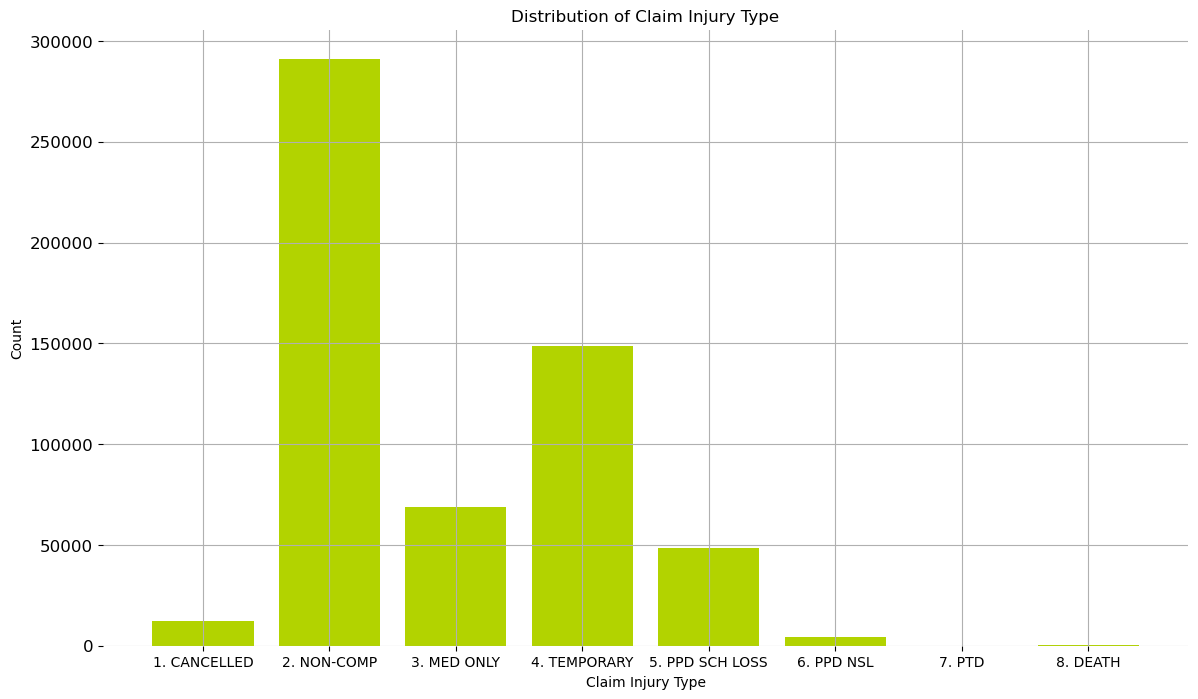

In [20]:
claim_injury_counts = df_train['Claim Injury Type'].value_counts()
claim_injury_counts = claim_injury_counts.reindex(sorted(claim_injury_counts.index, key=lambda x: int(x.split('.')[0])))

plt.figure(figsize=(14, 8))
bars = plt.bar(claim_injury_counts.index, claim_injury_counts.values, color='#B2D300')
plt.xlabel('Claim Injury Type')
plt.ylabel('Count')
plt.title('Distribution of Claim Injury Type')
plt.yticks(fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The dataset is dominated by the second category in such a way that the 7th and 8th categories appear to be empty.

In [21]:
claim_injury_table = df_train['Claim Injury Type'].value_counts().reset_index()
claim_injury_table.columns = ['Claim Injury Type', 'Count']

claim_injury_table['Claim Injury Type'] = claim_injury_table['Claim Injury Type'].astype(str)
claim_injury_table = claim_injury_table.sort_values(by='Claim Injury Type', key=lambda inj_type: inj_type.str.split('.').str[0].astype(int))
claim_injury_table.reset_index(drop=True, inplace=True)
claim_injury_table['Percentage'] = (claim_injury_table['Count'] / claim_injury_table['Count'].sum() * 100).round(2)
claim_injury_table

Claim Injury Type   Count  Percentage
0      1. CANCELLED   12477        2.17
1       2. NON-COMP  291078       50.71
2       3. MED ONLY   68906       12.00
3      4. TEMPORARY  148507       25.87
4   5. PPD SCH LOSS   48280        8.41
5        6. PPD NSL    4211        0.73
6            7. PTD      97        0.02
7          8. DEATH     470        0.08

The table allows a different view where the minority can still be seen. The target variable is clearly unbalanced. In the future, resampling and other methods could be used to compensate for this issue.

### Wide View of Numeric Variables

At this stage, some charts will be plotted. This is done because something as simple as creating histograms and boxplots for the numeric variables can reveal important insights to be further explored.

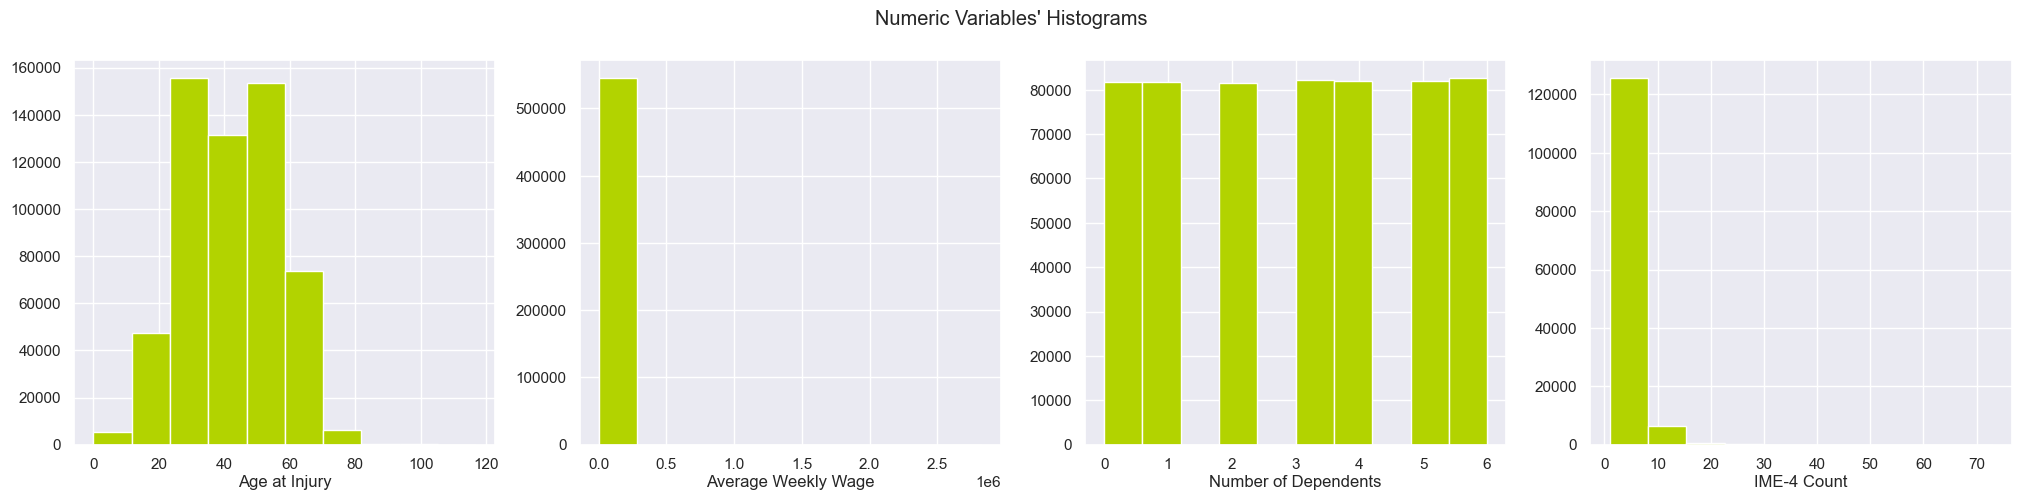

In [22]:
metric_features = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'IME-4 Count']
df = df_train

sns.set()
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat], color= '#B2D300')
    ax.set_title(feat, y=-0.13)
plt.suptitle("Numeric Variables' Histograms")
plt.show()

The age seems to be centralized around 50, as for the number of dependents it seems to be equally distributed along the various possibilities.

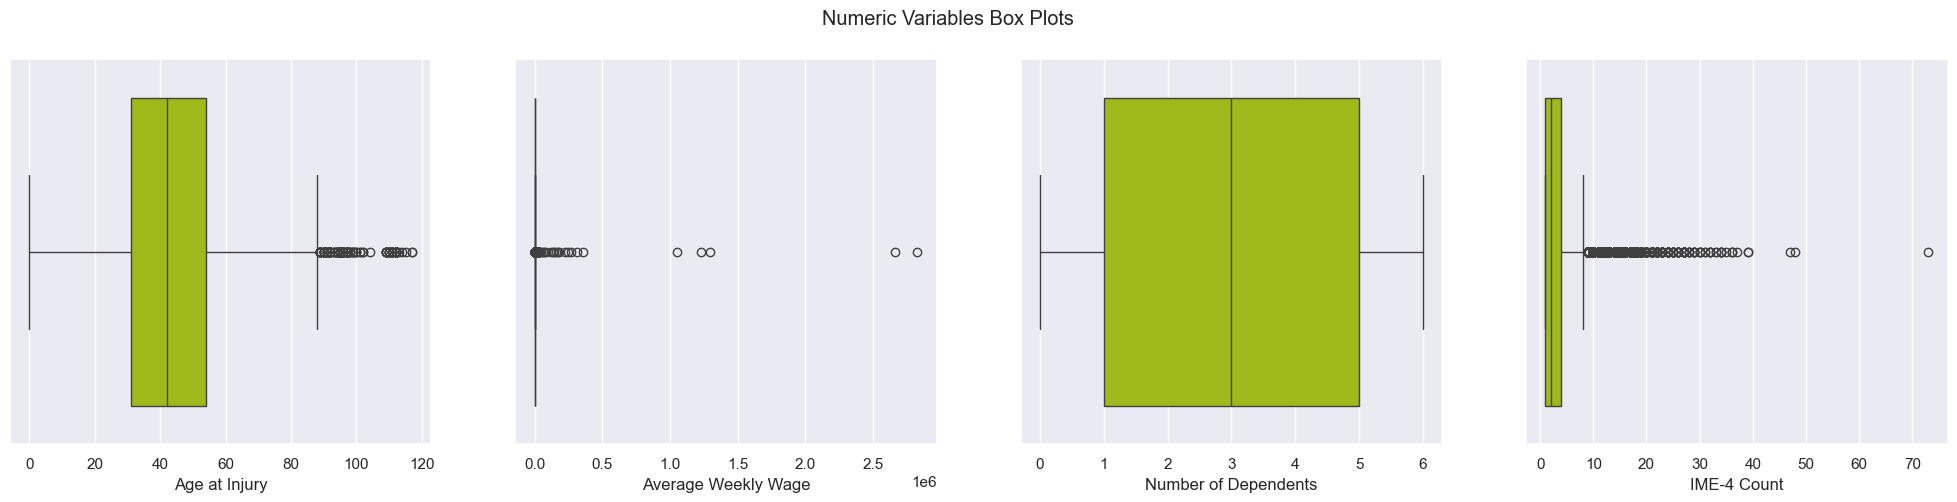

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax, color= '#B2D300')
plt.suptitle("Numeric Variables Box Plots")
plt.show()

Average Weekly Wage seems to be skewed. On a later stage, more research will be conducted to understand this variable.

### Dates

Dates can yield important insights regarding periodicity in the data (for example, tourism tends to rise in summer and decline in winter).

A plot of the frequency of accidents per year and month for every year in the data set could show these tendencies.

#### Accident Date

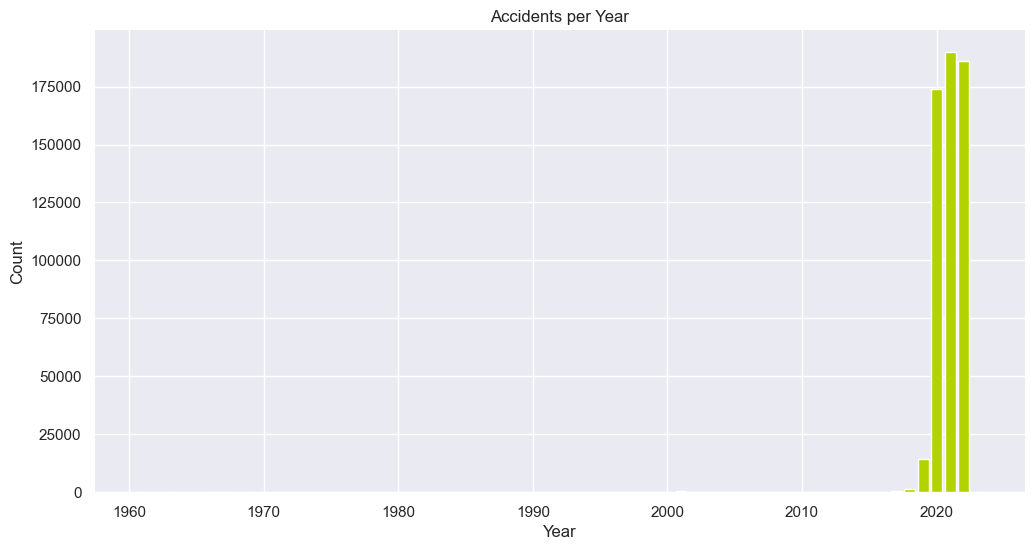

In [24]:
accidents_per_year = df_train['Accident Date'].dt.year.value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(accidents_per_year.index, accidents_per_year.values, color='#B2D300')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Accidents per Year')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The dataset provided by WCB had labeled data with the claims assembled between 2020 and 2022, so it was expected that the accidents would be recent. However, it can be seen that, while, indeed, most accidents happened around the 2020s, the range went back all the way to the 1960s. It could be that some accidents happened a long time ago but the victims only started showing symptoms decades later, which was when they filed for benefits. 

For better observation of the number of accidents, the group decided to analyze the time period from 2019 to 2023, as this was when most of the accidents occurred.

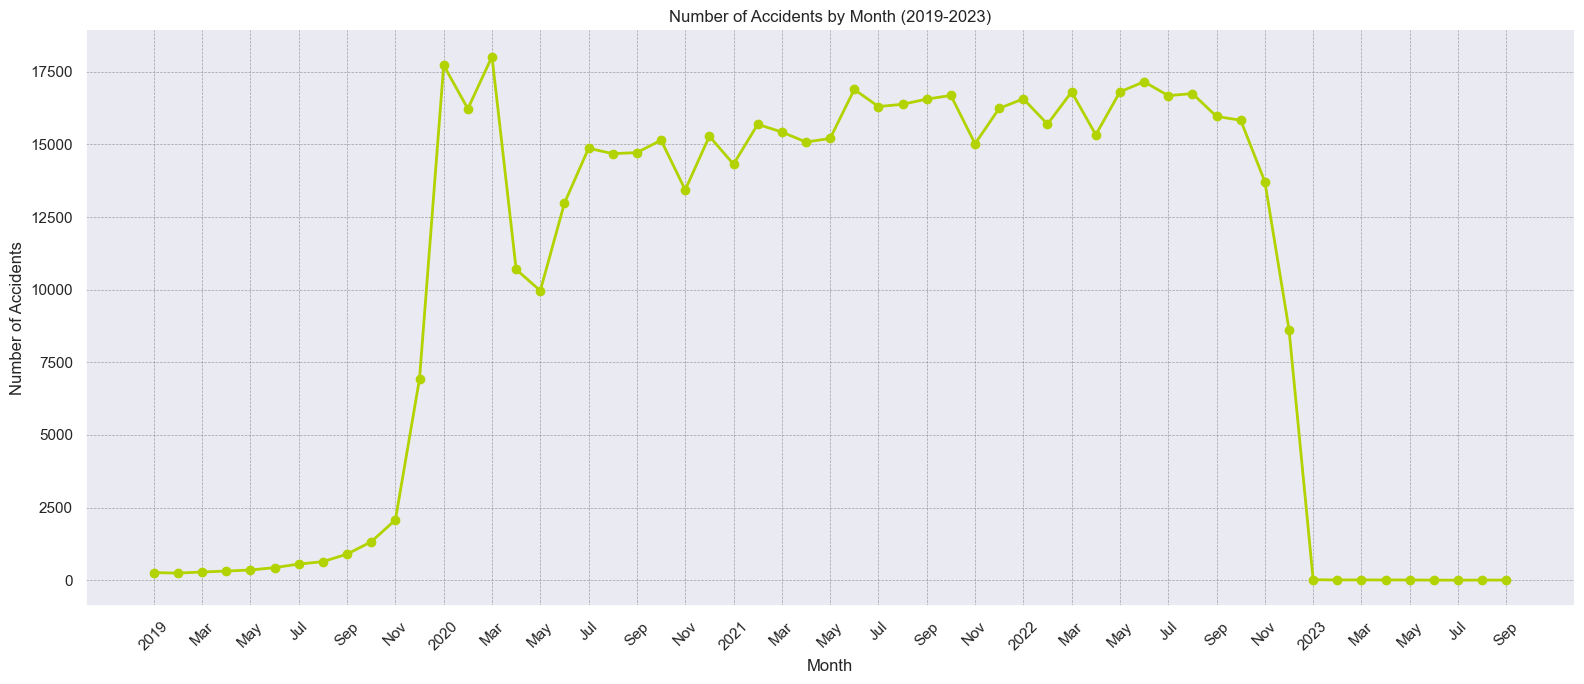

In [25]:
df_train_2019 = df_train[df_train['Accident Date'].dt.to_period('M') >= '2019-01']
accidents_by_month = df_train_2019.groupby(df_train_2019['Accident Date'].dt.to_period('M')).size()

plt.figure(figsize=(16, 7))
plt.plot(accidents_by_month.index.astype(str), accidents_by_month.values, marker='o', color='#B2D300', linestyle='-', linewidth=2)
plt.title('Number of Accidents by Month (2019-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')

labels = []
for month in accidents_by_month.index.to_timestamp():
    if month.month == 1:                          
        labels.append(f"{month.strftime('%Y')}")
    else:                                         
        labels.append(month.strftime('%b'))

plt.xticks(ticks=range(0, len(accidents_by_month), 2), labels=labels[::2], rotation=45)


plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

After this, the group decided to analyze the seasonality of accidents by month.

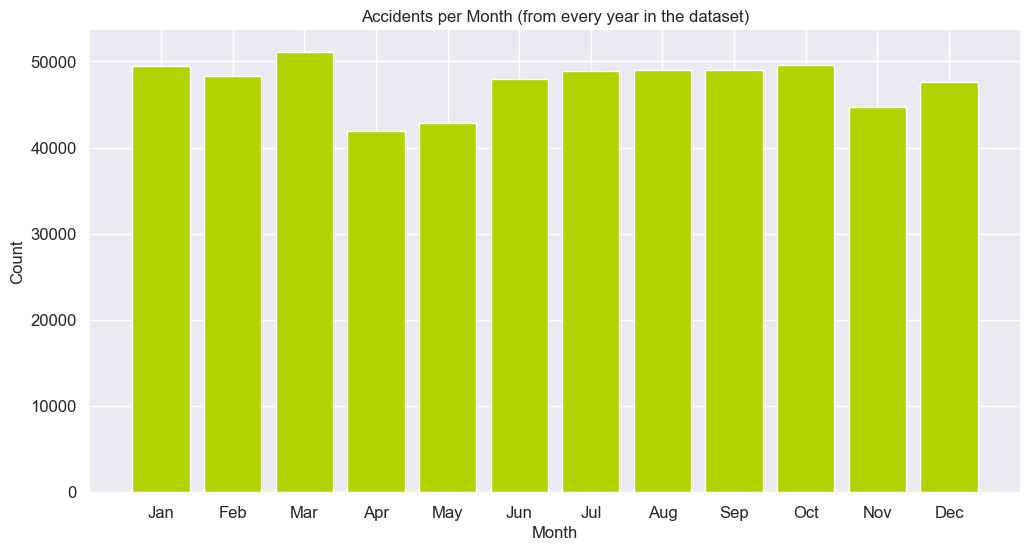

In [26]:
year_counts = df_train['Accident Date'].groupby(df_train['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (from every year in the dataset)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Trying to find some periodicity (such as less accidents during the holiday seasons) was inconclusive, as accidents seem to be somewhat uniformly distributed across the months of the year.

However, there seems to be a slight decrease in April and May. Since most of the data regards the years of 2020, 2021 and 2022, a plot aggregating these years could be more revealing.

In [27]:
df_train_recent = df_train[df_train['Accident Date'].dt.year.isin([2020, 2021, 2022])]

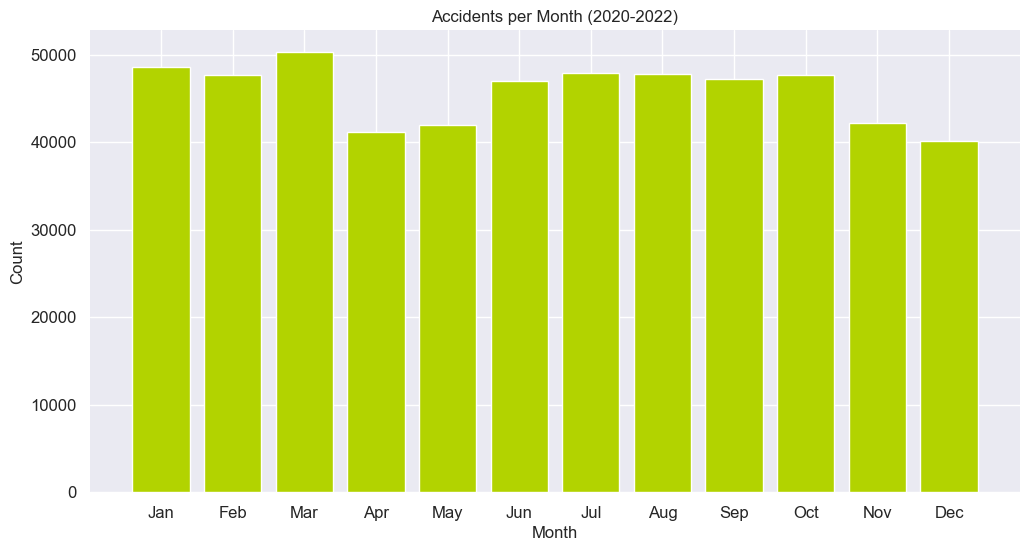

In [28]:
year_counts = df_train_recent['Accident Date'].groupby(df_train_recent['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (2020-2022)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Only Decemeber seems to have changed in the recent years, showing a small decrease. To be more specific, a line chart with the three last years can be created.

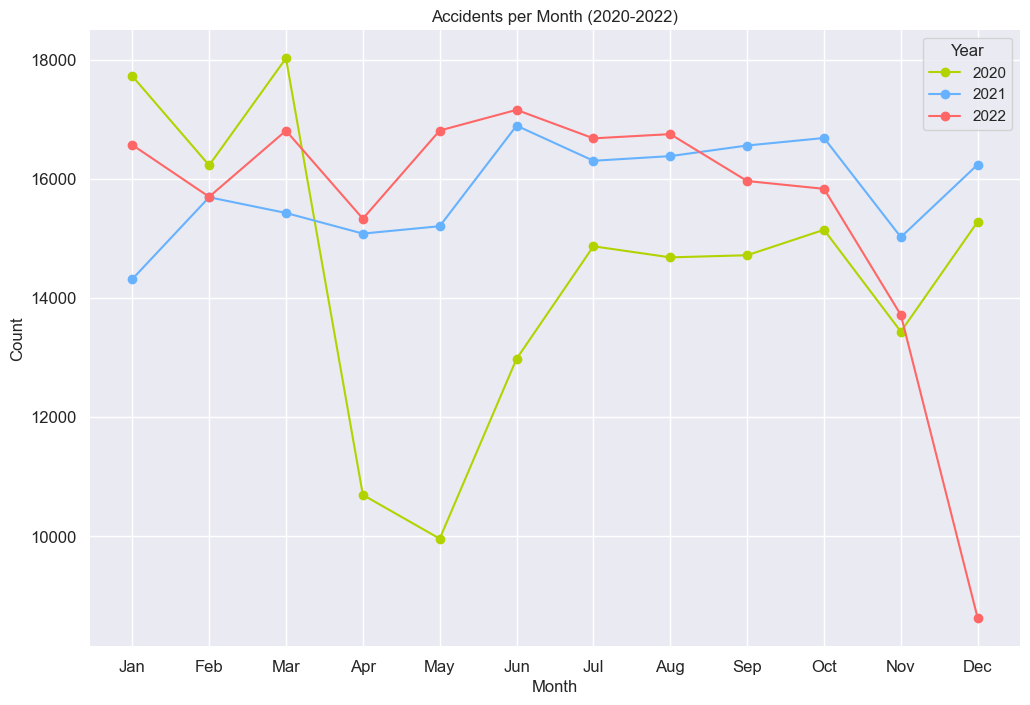

In [29]:
plt.figure(figsize=(12, 8))
years_list = [2020, 2021, 2022, 2023]
colors = ['#B2D300', '#66B2FF', '#FF6666']

for year, color in zip(years_list, colors):
    year_counts = df_train[df_train['Accident Date'].dt.year == year]['Accident Date'].dt.month.value_counts().sort_index()
    plt.plot(year_counts.index, year_counts.values, marker='o', label=str(year), color=color)
    
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (2020-2022)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(title='Year')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

It appears to be no recognizable pattern in these years. However, the group observed a decrease in accidents during the period from March to May. This could possibly be attributed to the COVID-19 outbreak, as workers were required to quarantine during this time and, consequently, were less likely to experience work-related accidents.

A look into the years before 2020, the minority subset, could explain the decrease in december in the more recent past.

In [30]:
df_train_older = df_train[df_train['Accident Date'].dt.year < 2020]

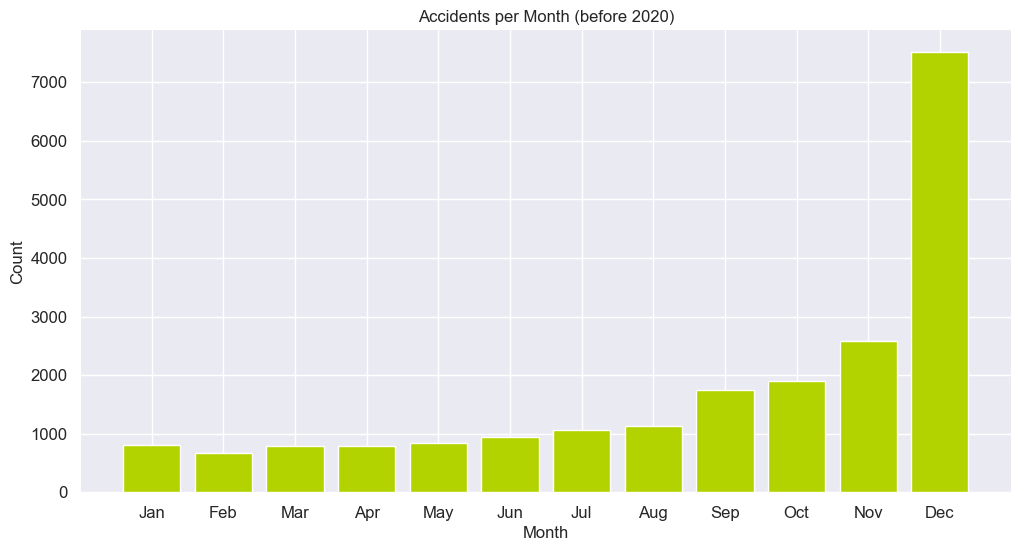

In [31]:
year_counts = df_train_older['Accident Date'].groupby(df_train_older['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (before 2020)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [32]:
most_common_year_month = df_train_older['Accident Date'].dt.to_period('M').value_counts().idxmax()
most_common_year_month

Period('2019-12', 'M')

The explosive rise in the month of december can be explained by the the date '2019-12-XX' which is the closest date to when the colection of data starts to grow. It is plausible to assume that this increase in observations is simply due to an increase in data collection and not a real life increase in insurance claims.

#### C-2 Date

Relatively to the variable C-2 Date, the first thing to do is to understand what this data represents. The group found the following information regarding the variable:

"Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2). Blank indicates no form received. For data sets published prior to the first quarter of 2022, the C-2 Date is the date of receipt of the “Employer’s Report of Work-Related Injury/Illness” for C-2. For data sets created in the first quarter of 2022 and forward, the C-2 Date is set to the earliest received date of equivalent injury/illness filings, including electronic data filed though the Board’s eClaims process."<br>

References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

Given that the data focuses mostly on the years of 2020 to 2022, the line chart for C-2 Forms will look into this period.

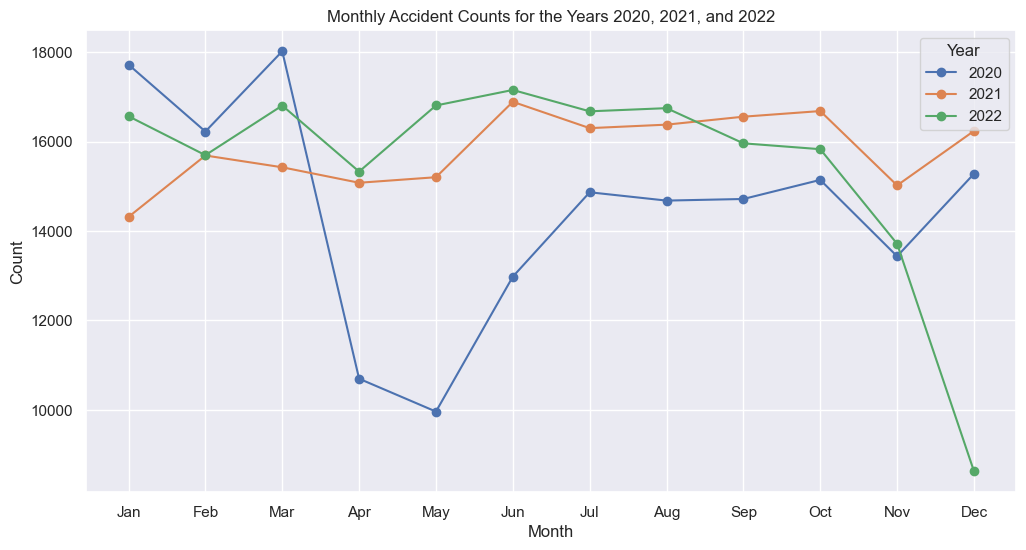

In [33]:
df_filtered = df_train[df_train['Accident Date'].dt.year.isin([2020, 2021, 2022])]
monthly_counts = df_filtered.groupby([df_filtered['Accident Date'].dt.year, df_filtered['Accident Date'].dt.month]).size().unstack(level=0)
plt.figure(figsize=(12, 6))
for year in [2020, 2021, 2022]:
    plt.plot(monthly_counts.index, monthly_counts[year], marker='o', label=str(year))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Accident Counts for the Years 2020, 2021, and 2022')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

It appears to be no type of periodicity. Since the report follows the occurrence of an accident, and accidents don't seem to be periodic, neither should this variable, so this makes sense.

Now, the group will see if the time elapsed between the accident and the submission of the C-2 Form has an impact on WCB's decision. For that, a helper variable will be created. Then it will be binned according to the following groupings:

- 1 week (7 days)
- 1 month (30 days)
- 3 Months (90 days)
- 6 months (180 days)
- 1 year (365 days)
- 365 x 10 (10 years)
- 365 x 60 (60 years, this group was created to encompass all observations)

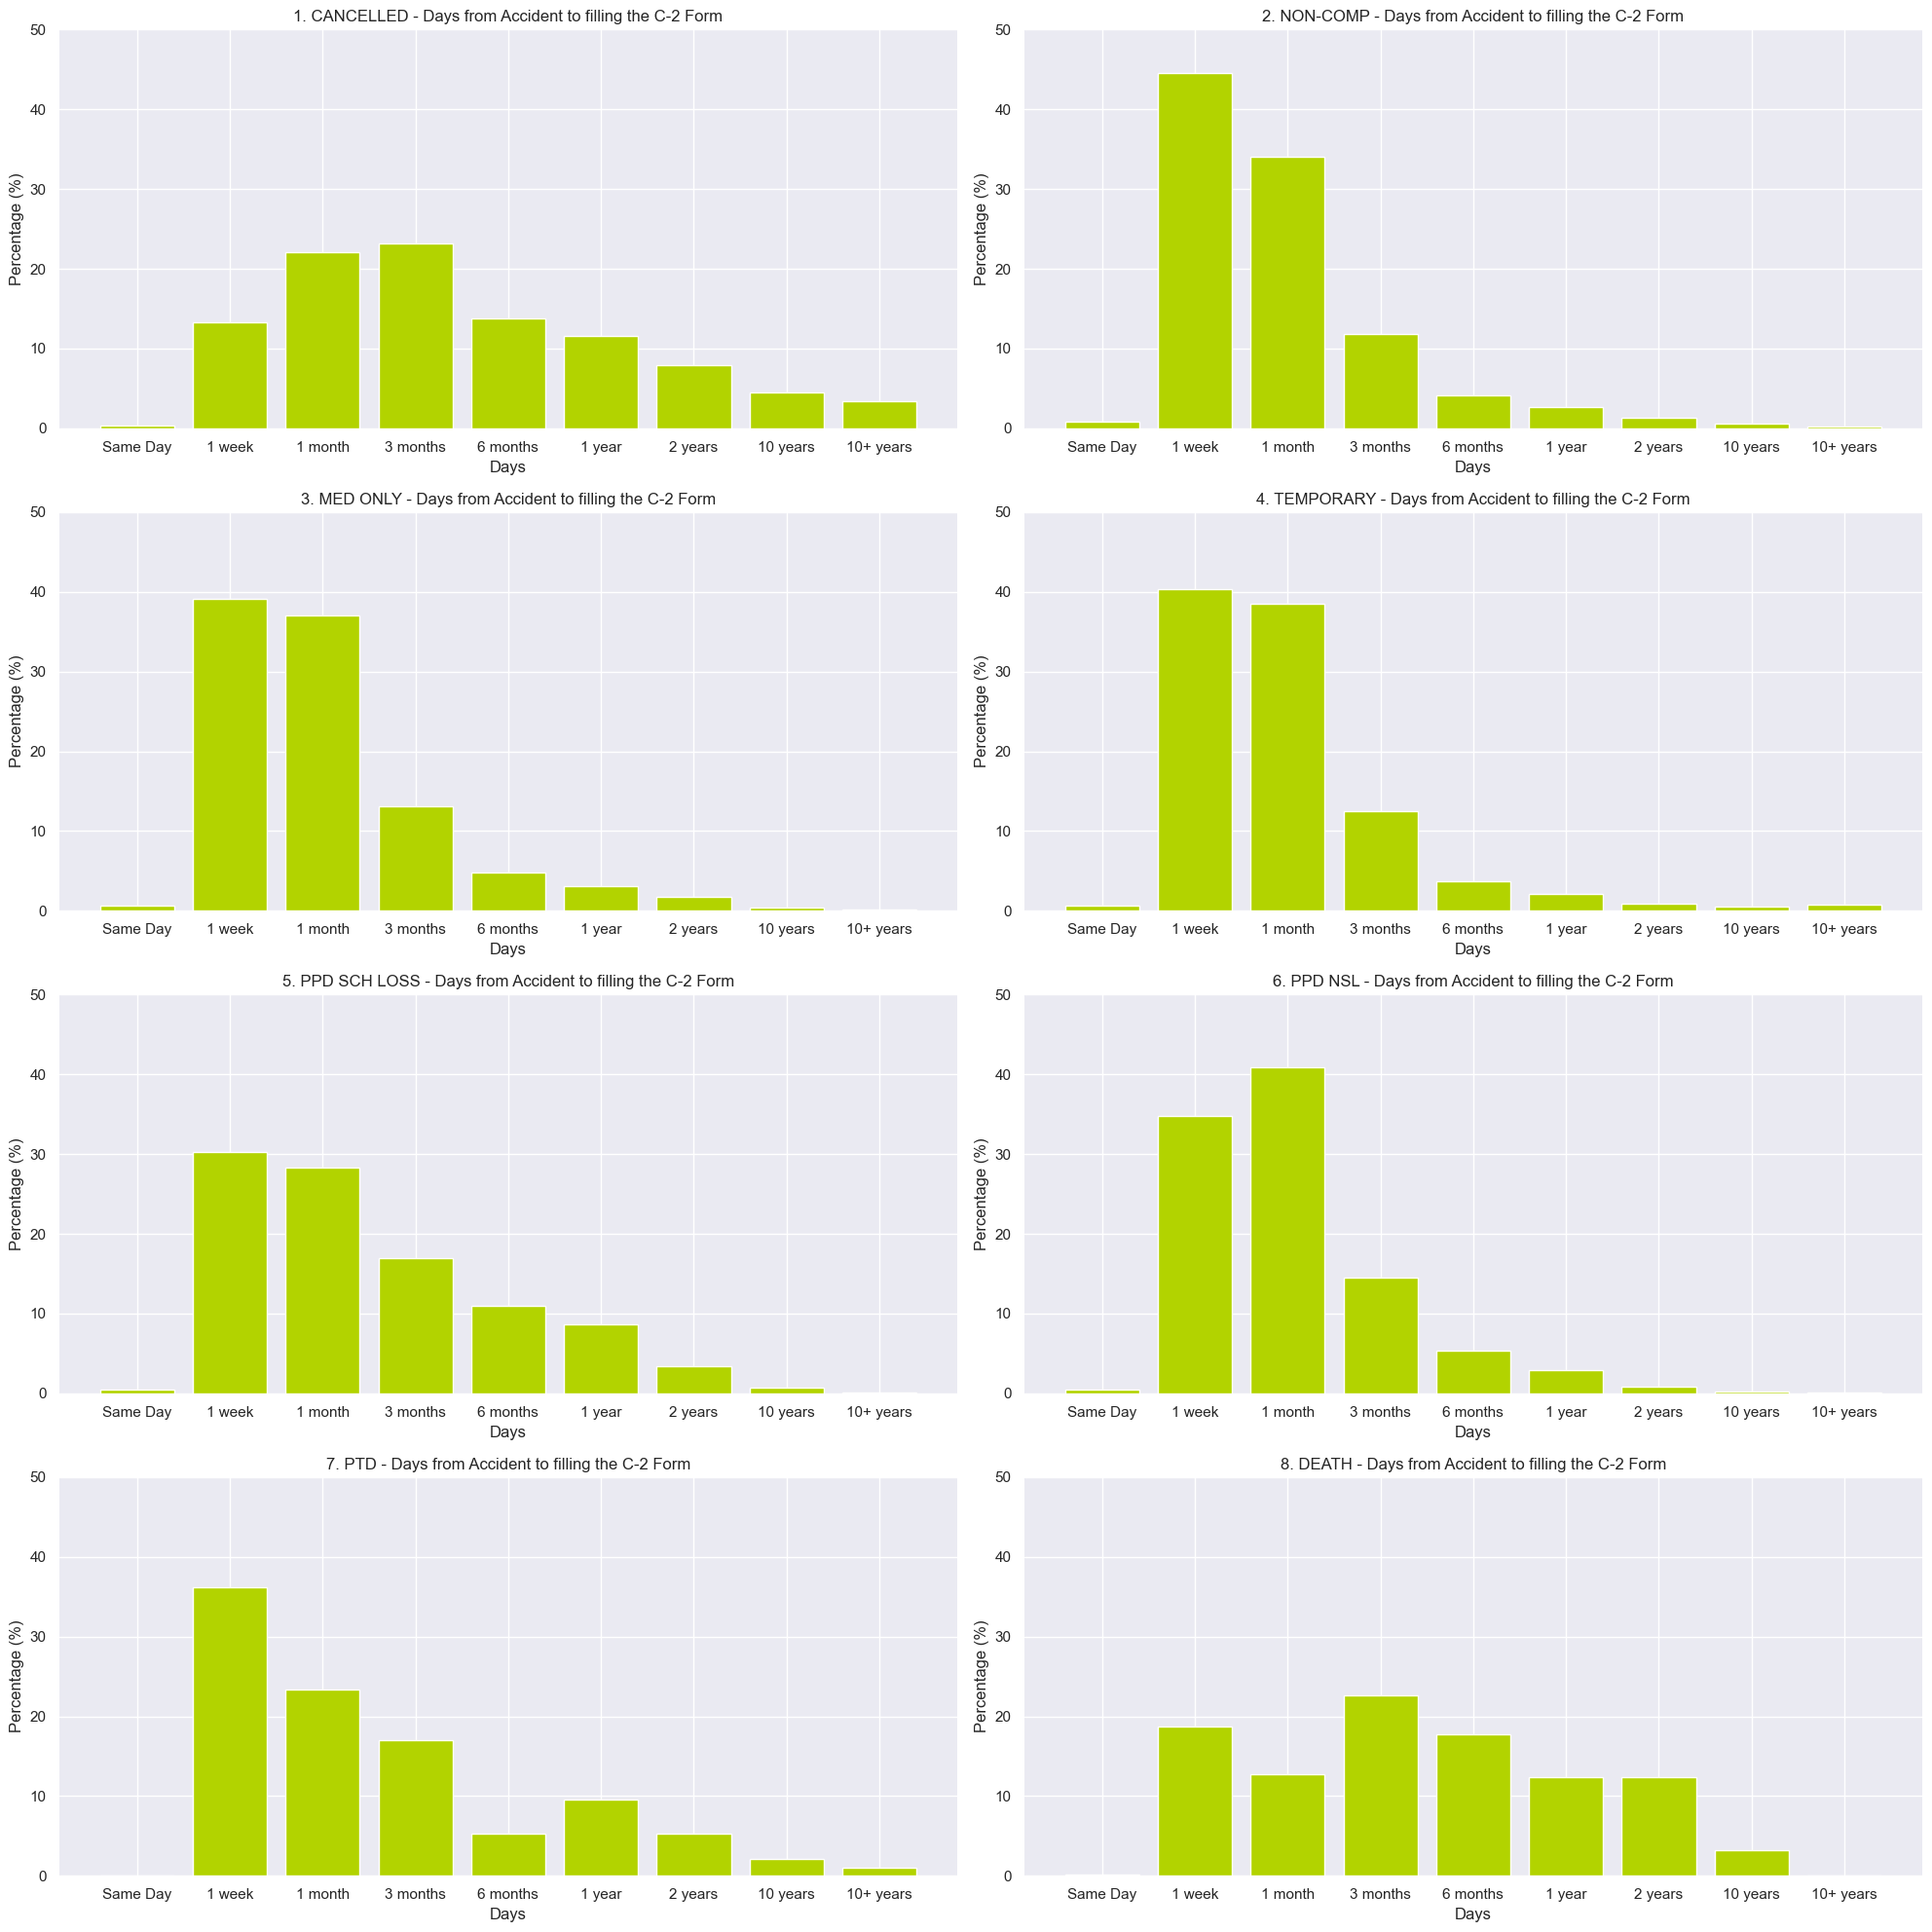

In [34]:
df_train['days_to_c2'] = (df_train['C-2 Date'] - df_train['Accident Date']).dt.days

bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_train['days_to_c2_binned'] = pd.cut(df_train['days_to_c2'], bins=bins, labels=labels)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
claim_list = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY', '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

for ax, claim in zip(axes.flatten(), claim_list):
    days_accident_binned = df_train[df_train['Claim Injury Type'] == claim]['days_to_c2_binned'].value_counts().sort_index()
    bars = ax.bar(days_accident_binned.index.astype(str), days_accident_binned.values / days_accident_binned.values.sum() * 100, color='#B2D300')
    ax.set_title(f'{claim} - Days from Accident to filling the C-2 Form')
    ax.set_xlabel('Days')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 50)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

It seems that, in most cases, the form is filled out up to a month after the accident happens. This is true for all kinds of decisions. Cases involving death seem to be the exception. In these cases, there is a more uniform distribution. This could be that employees do not bother to fill out the form in such a hurry if a death occurred.

Given that C-2 is the date of a form filled out by the employee after the accident, "C-2 Date" cannot happen before "Accident Date". In order to ensure the data is consistent, it must be confirmed if such cases occured:

In [35]:
c2_before_accident = df_train[df_train['days_to_c2'] < 0]
print(f"Number of times the C-2 report is filled before the accident happens: {c2_before_accident.shape[0]}")

Number of times the C-2 report is filled before the accident happens: 982


These rows are mistakes and will be addressed in the data cleaning stage.

### Attorney VS No Attorney

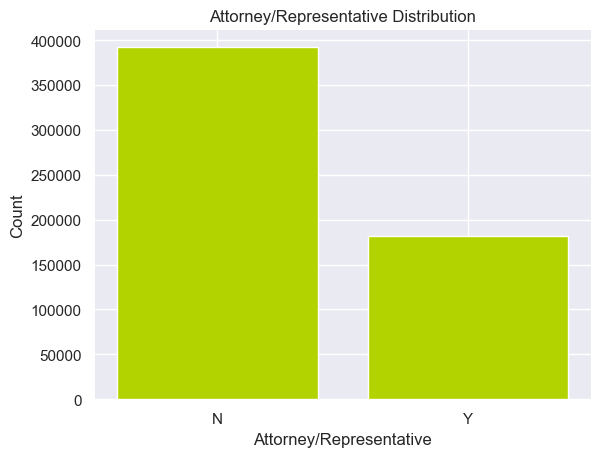

In [36]:
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].astype(str)
gender_counts = df_train['Attorney/Representative'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='#B2D300')
plt.xlabel('Attorney/Representative')
plt.ylabel('Count')
plt.title('Attorney/Representative Distribution')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In the real world, the presence of a lawyer can sometimes change the outcome of an insurance claim. How is this presence distributed across different types of claims?

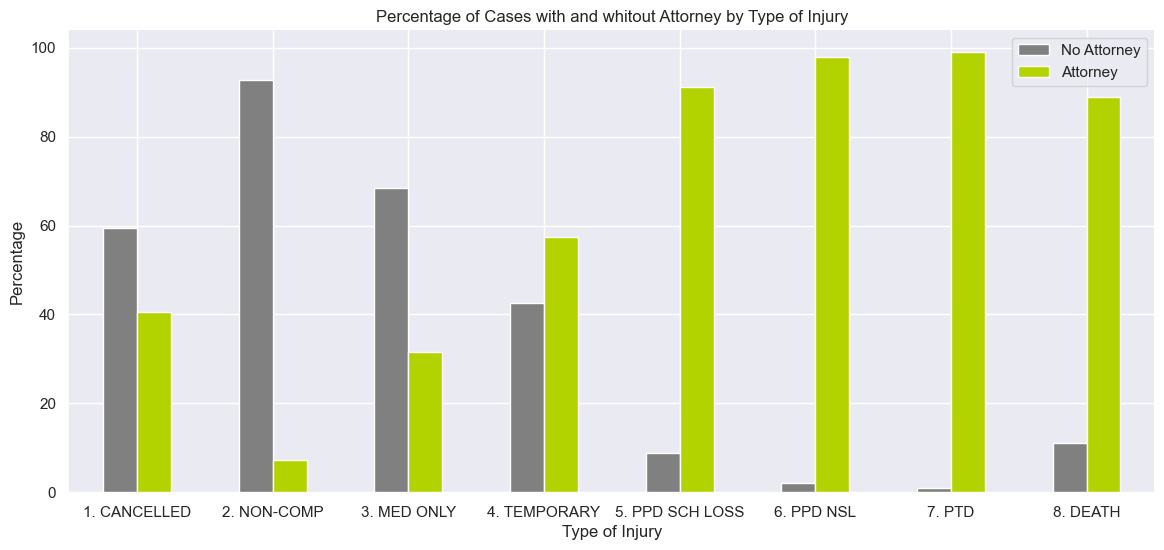

In [37]:
claim_injury_by_attorney = pd.crosstab(df_train['Claim Injury Type'], df_train['Attorney/Representative'])
claim_injury_by_attorney.columns = ['No Attorney', 'Attorney']
claim_injury_by_attorney.reset_index(inplace=True)
claim_injury_by_attorney['Attorney'] = claim_injury_by_attorney['Attorney'] / (claim_injury_by_attorney['No Attorney'] + claim_injury_by_attorney['Attorney']) * 100
claim_injury_by_attorney['No Attorney'] = 100 - claim_injury_by_attorney['Attorney']
claim_injury_by_attorney
claim_injury_by_attorney.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(14, 6))
plt.xlabel('Type of Injury')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and whitout Attorney by Type of Injury')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
plt.xticks(ticks=range(len(claim_injury_counts.index)), 
               labels=sorted(claim_injury_counts.index, key=lambda x: int(x.split('.')[0])), 
               rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

This graph shows that as the severity of cases increases so does the percentage of cases where a laywer is present, this is an indication that the presence of a laywer is highly correlated to the target variable.

### Age at Injury

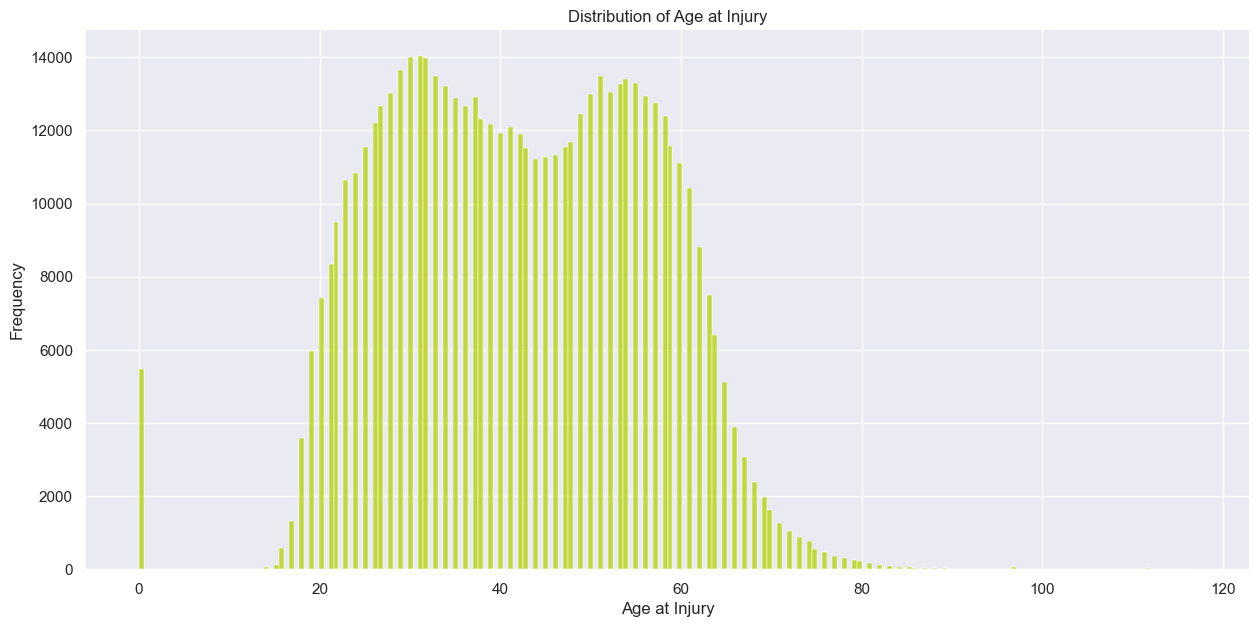

In [38]:
plt.figure(figsize=(15, 7))                              
sns.histplot(df_train['Age at Injury'], color='#B2D300')   
plt.xlabel('Age at Injury')                                
plt.ylabel('Frequency')                              
plt.title('Distribution of Age at Injury')
plt.grid(True)                                          
ax = plt.gca()                                                
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Most injuries occur in the age range of 20 to 60, with a decrease in frequency as age increases (fewer injuries reported in the older age groups). This makes sense as these are the ages where people actively take part in the workforce, and therefore could be injured at work.

Some observations show an age of 0. This will be adressed later in this section, and on the data cleaning stage.

In [39]:
pyramid_db = df_train.copy()

In [40]:
bins = (0, 10, 20, 30, 40, 50, 60, 80, 90, 100, float('inf'))
labels = ['1-10', '10-19', '20-29', '30-39', '40-49', '50-59', '60-79', '80-89', '90-99', '100+']
pyramid_db['age_group'] = pd.cut(pyramid_db['Age at Injury'], bins=bins, labels=labels)

In [41]:
# pyramid_data = piramid_db.groupby(['age_group', 'Gender']).size().unstack(fill_value=0)

# # Ensure age groups are in proper order
# pyramid_data = pyramid_data.reindex(sorted(pyramid_data.index))

# # Convert males to negative for plotting on the left
# pyramid_data['Male'] *= -1

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# age_groups = pyramid_data.index
# ax.barh(age_groups, pyramid_data['Male'], color='blue', label='Male')
# ax.barh(age_groups, pyramid_data['Female'], color='pink', label='Female')

# # Formatting
# ax.set_xlabel('Population')
# ax.set_ylabel('Age Group')
# ax.set_title('Population Pyramid')
# ax.legend()

# # Show grid and improve appearance
# ax.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

#### Age Groups  vs Target

Ages will be grouped in order to obtain visualizations that are more meaningful and easier to read. Age groups were created following the norms of the United States Census Bureau.

References:<br>
https://www2.census.gov/library/publications/decennial/2020/census-briefs/c2020br-06.pdf

In [42]:
bins = (1, 18, 25, 45, 65, float('inf'))
labels = ['1-17', '18-24', '25-44', '45-64', '65+']
df_train['age_group'] = pd.cut(df_train['Age at Injury'], bins=bins, labels=labels)

In [43]:
age_group_counts = df_train['age_group'].value_counts().sort_index()
age_group_counts_percentage = age_group_counts / age_group_counts.sum() * 100
age_group_table = pd.DataFrame({'Age Group': age_group_counts.index,'Count': age_group_counts.values,'Percentage': age_group_counts_percentage.values})
age_group_table

Age Group   Count  Percentage
0      1-17    5694    1.001477
1     18-24   64265   11.303117
2     25-44  253237   44.540066
3     45-64  225533   39.667405
4       65+   19831    3.487934

<Axes: xlabel='Claim Injury Type'>

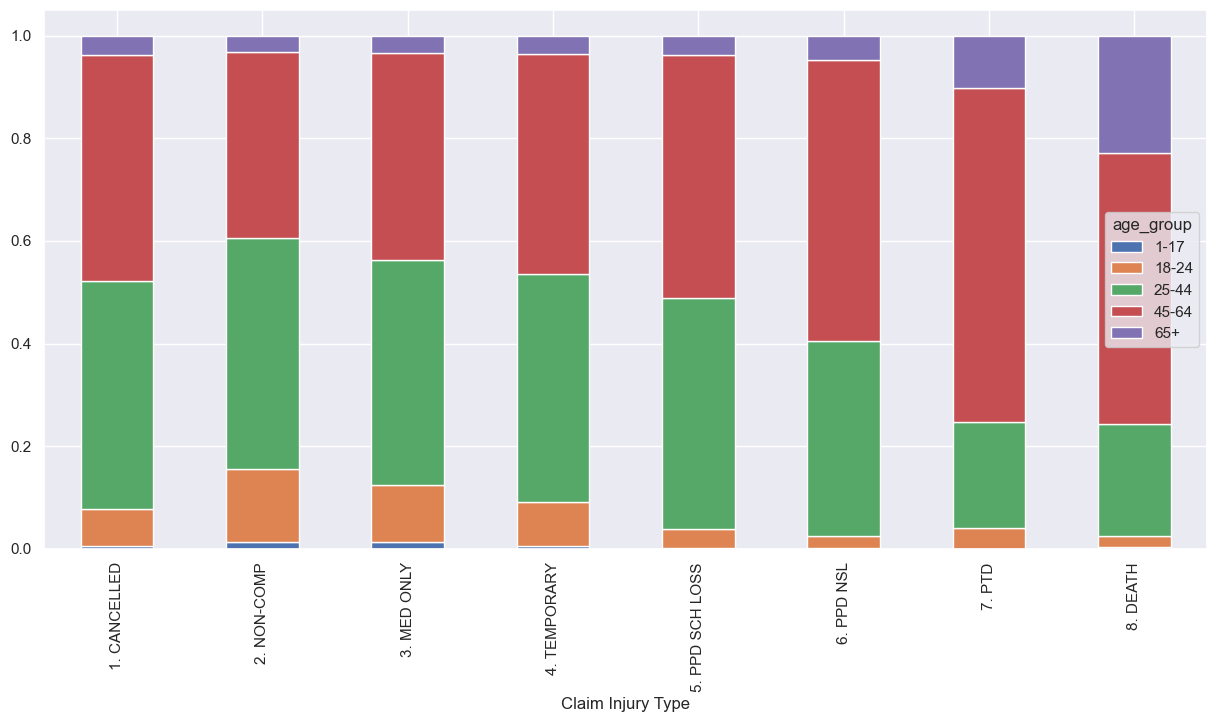

In [44]:
df_train.groupby('Claim Injury Type')['age_group'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 7))

The group then decided to investigate the observations with an age of 0.

In [45]:
df_zeros = df_train[df_train['Age at Injury'] == 0]
df_zeros.describe()

Accident Date  Age at Injury  \
count                           1775         5464.0   
mean   2018-05-30 02:25:13.014084608            0.0   
min              1967-04-05 00:00:00            0.0   
25%              2020-01-07 00:00:00            0.0   
50%              2020-09-29 00:00:00            0.0   
75%              2021-09-16 00:00:00            0.0   
max              2022-12-20 00:00:00            0.0   
std                              NaN            0.0   

                       Assembly Date  Average Weekly Wage   Birth Year  \
count                           5464          5169.000000  5204.000000   
mean   2021-05-19 05:29:57.364568064            70.099559  1238.161414   
min              2020-01-02 00:00:00             0.000000     0.000000   
25%              2020-08-21 00:00:00             0.000000     0.000000   
50%              2021-04-27 00:00:00             0.000000  1959.000000   
75%              2022-02-03 00:00:00             0.000000  1967.000000   
max              2022-12-30 00:00:00          5867.580000  2005.000000   
std                              NaN           321.922818   949.243284   

                            C-2 Date                       C-3 Date  \
count                           3081                           3807   
mean   2021-06-11 06:30:15.774099712  2021-05-16 15:55:04.964539136   
min              1997-02-07 00:00:00            2010-05-14 00:00:00   
25%              2020-10-08 00:00:00            2020-08-17 00:00:00   
50%              2021-07-16 00:00:00            2021-04-13 00:00:00   
75%              2022-05-03 00:00:00            2022-02-16 12:00:00   
max              2024-05-31 00:00:00            2024-04-02 00:00:00   
std                              NaN                            NaN   

                  First Hearing Date  IME-4 Count  Industry Code  \
count                           1664        560.0         3983.0   
mean   2021-12-27 02:53:56.538461696       2.2375      50.708009   
min              2020-02-06 00:00:00          1.0           11.0   
25%              2021-03-05 00:00:00          1.0           42.0   
50%              2021-12-22 00:00:00          2.0           48.0   
75%              2022-10-03 00:00:00          3.0           62.0   
max              2024-05-30 00:00:00         17.0           92.0   
std                              NaN     1.971811      18.743996   

       WCIO Cause of Injury Code  WCIO Nature of Injury Code  \
count                     2940.0                      2937.0   
mean                   74.727891                   53.292475   
min                          1.0                         1.0   
25%                         56.0                        37.0   
50%                         83.0                        52.0   
75%                         98.0                        72.0   
max                         99.0                        91.0   
std                    27.188004                   22.075821   

       WCIO Part Of Body Code  Agreement Reached  Number of Dependents  \
count                  2535.0             5464.0                5464.0   
mean                37.280473           0.068814              2.999817   
min                      -9.0                0.0                   0.0   
25%                      13.0                0.0                   1.0   
50%                      35.0                0.0                   3.0   
75%                      53.0                0.0                   5.0   
max                      99.0                1.0                   6.0   
std                 26.238942           0.253161              1.980733   

         days_to_c2  
count    961.000000  
mean     987.562955  
min        0.000000  
25%        6.000000  
50%       12.000000  
75%       48.000000  
max    20070.000000  
std     3163.363333

Most observations with 0 years of age do not have an "average weekly wage", and a sizable amount have 0 as their birth year.

For the ones who have a birth year, it is possible to calculate their age at the time of the accident (this is something that was done in the data cleaning section).

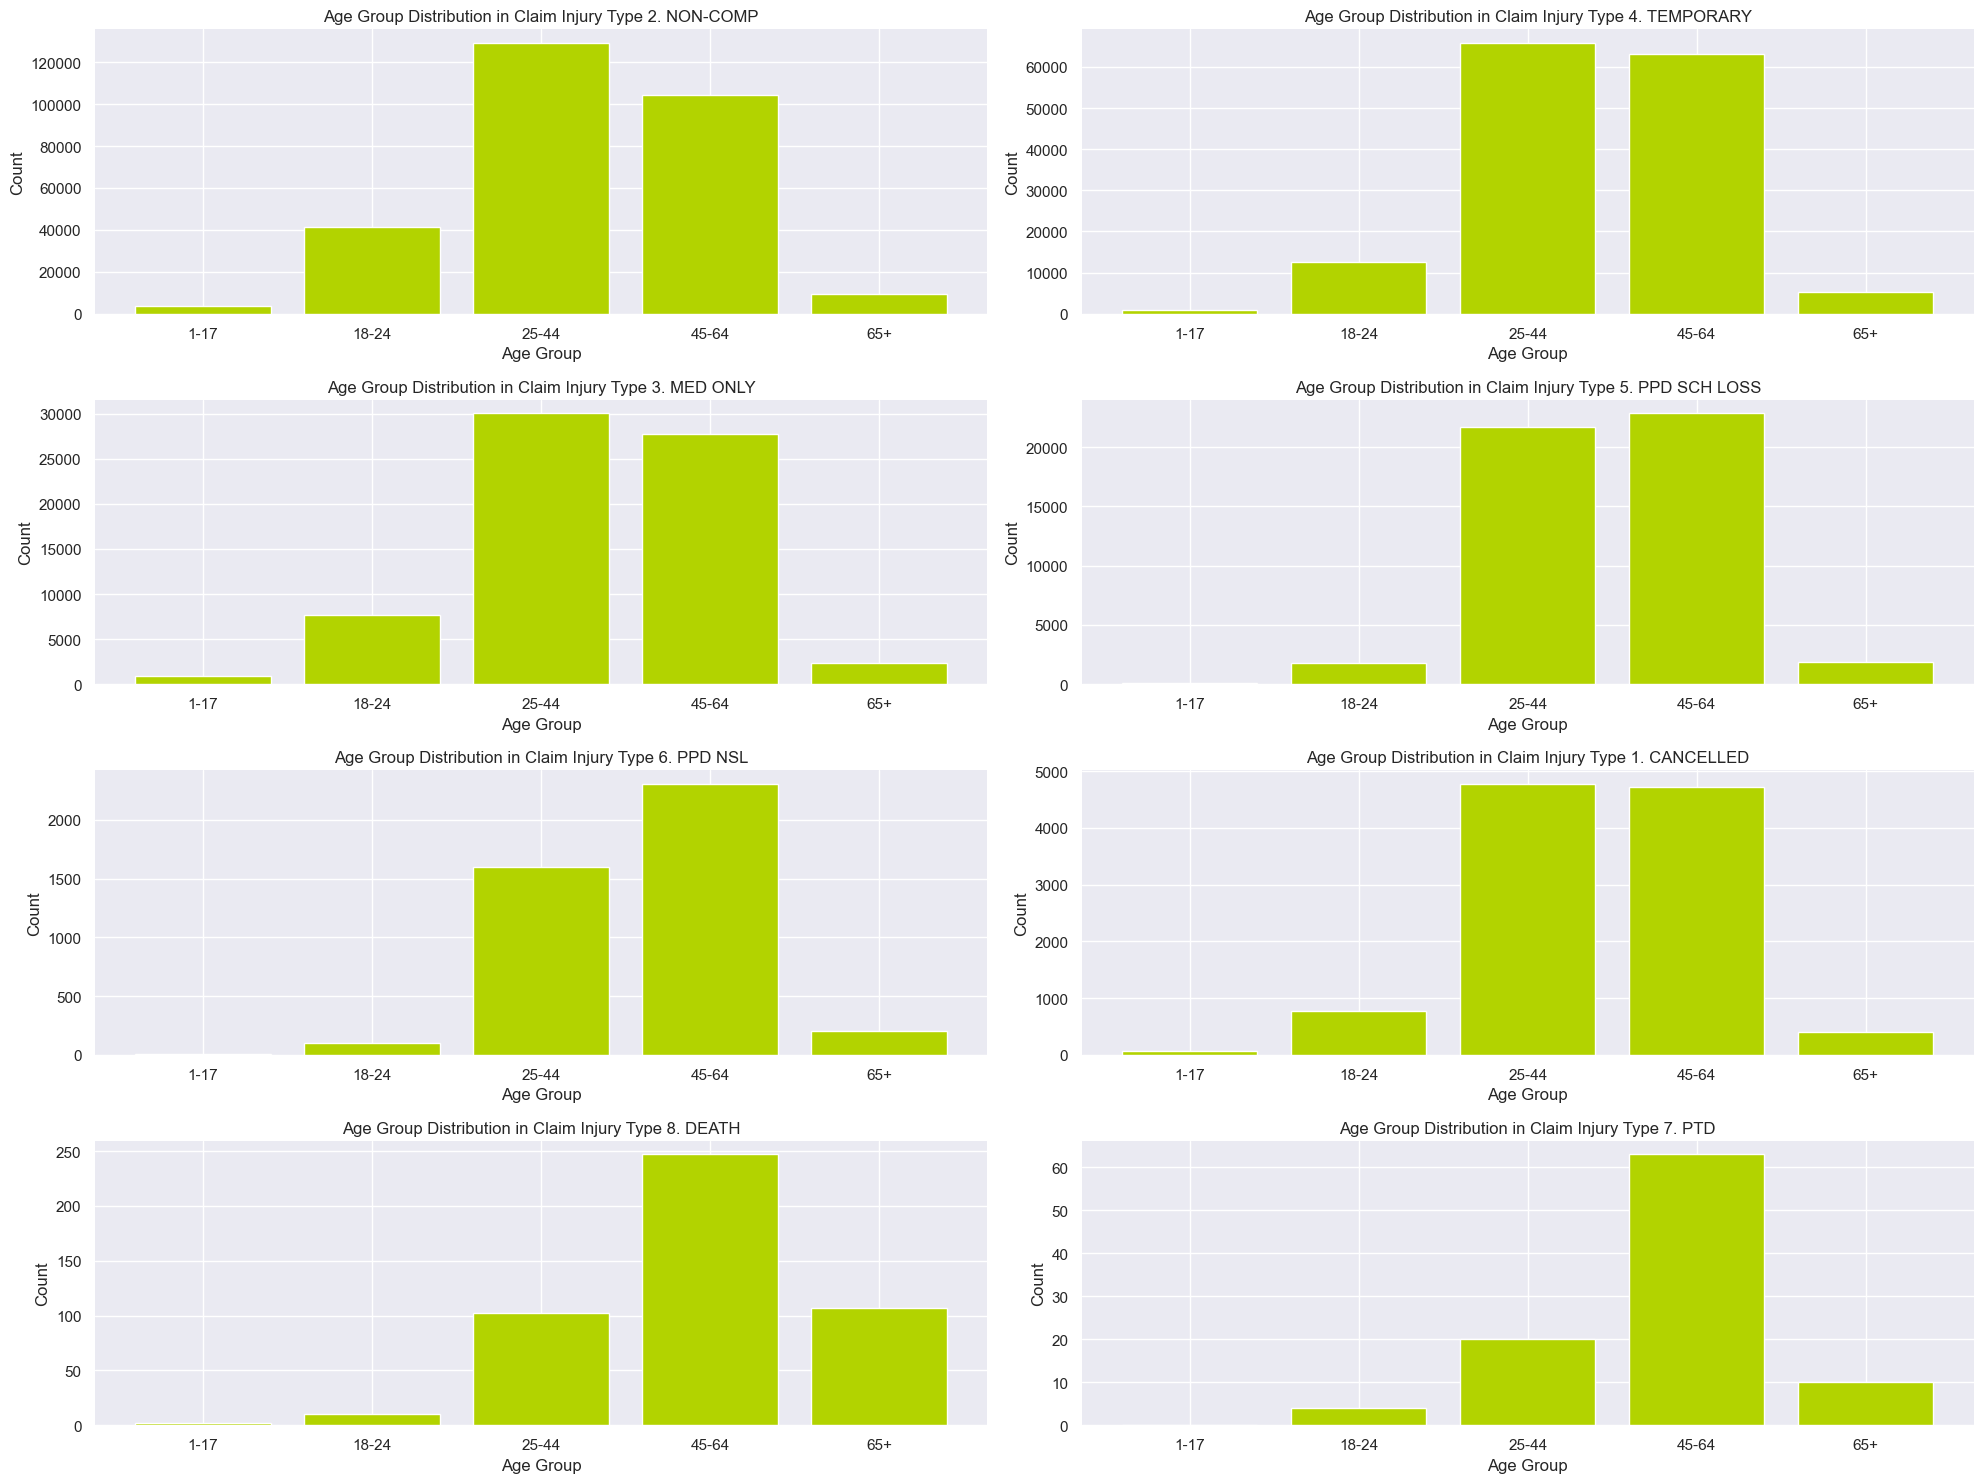

In [46]:
claim_injury_types = df_train['Claim Injury Type'].unique()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

for ax, claim_injury_type in zip(axes.flatten(), claim_injury_types):
    age_group_counts = df_train[df_train['Claim Injury Type'] == claim_injury_type]['age_group'].value_counts().sort_index()
    bars = ax.bar(age_group_counts.index, age_group_counts.values, color='#B2D300')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Count')
    ax.set_title(f'Age Group Distribution in Claim Injury Type {claim_injury_type}')
    ax.set_xticks(range(len(age_group_counts.index)))
    ax.set_xticklabels(age_group_counts.index, rotation=0)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

The group observed that the middle-age groups (25-44 and 45-64) appear to be the most vulnerable, likely due to their active participation in the workforce. In contrast, older individuals (65+) and younger individuals (1-17 and 18-24) account for a smaller proportion of claims, possibly due to their reduced involvement in the workforce.

### Genders

The next step is checking how the dataset is distributed in terms of gender.

The reported gender of the injured worker can be: 
- F – Female; 
- M - Male; 
- X - Nonbinary; 
- U – Unknown (gender not specified)

References:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

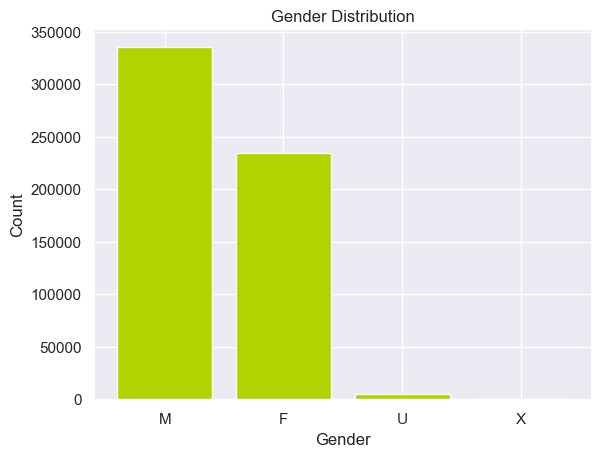

In [47]:
df_train['Gender'] = df_train['Gender'].astype(str)
gender_counts = df_train['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='#B2D300')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [48]:
gender_type_of_claim = pd.crosstab(df_train['Gender'], df_train['Claim Injury Type'])
for i in gender_type_of_claim.columns:
    gender_type_of_claim[i] = (gender_type_of_claim[i] / gender_type_of_claim[i].sum()) * 100
gender_type_of_claim

Claim Injury Type  1. CANCELLED  2. NON-COMP  3. MED ONLY  4. TEMPORARY  \
Gender                                                                    
F                     33.429510    44.401501    40.794706     37.794851   
M                     65.167909    54.538990    58.523206     61.647599   
U                      1.378537     1.055387     0.655966      0.554183   
X                      0.024044     0.004123     0.026123      0.003367   

Claim Injury Type  5. PPD SCH LOSS  6. PPD NSL    7. PTD   8. DEATH  
Gender                                                               
F                        30.292046   40.156732  23.71134  12.765957  
M                        69.320630   59.534552  76.28866  87.234043  
U                         0.370754    0.308715   0.00000   0.000000  
X                         0.016570    0.000000   0.00000   0.000000

The majority of the dataset is composed by men (M), with a smaller proportion of women (F) and two other options (Unknown and Nonbinary).

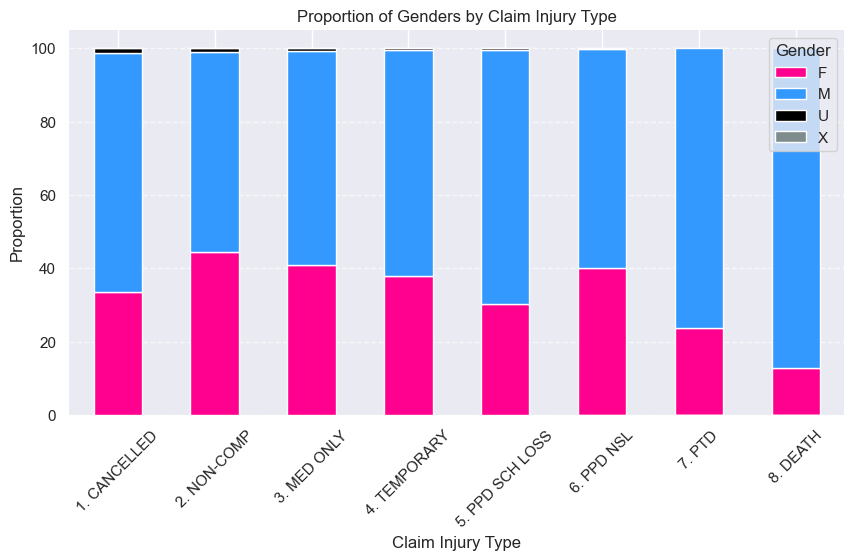

In [49]:
gender_proportion = pd.crosstab(df_train['Claim Injury Type'], df_train['Gender'], normalize='index') * 100
colors = ['#ff008f', '#3399ff', '#000000', '#7f8c8d']
fig, ax = plt.subplots(figsize=(10, 5))
gender_proportion.plot(kind='bar', stacked=True, color=colors, ax=ax)
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Claim Injury Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The graph gives a better perception of the growth in the percentage of men as cases get increasingly severe, with the highest percentage of men present in cases envolving death.

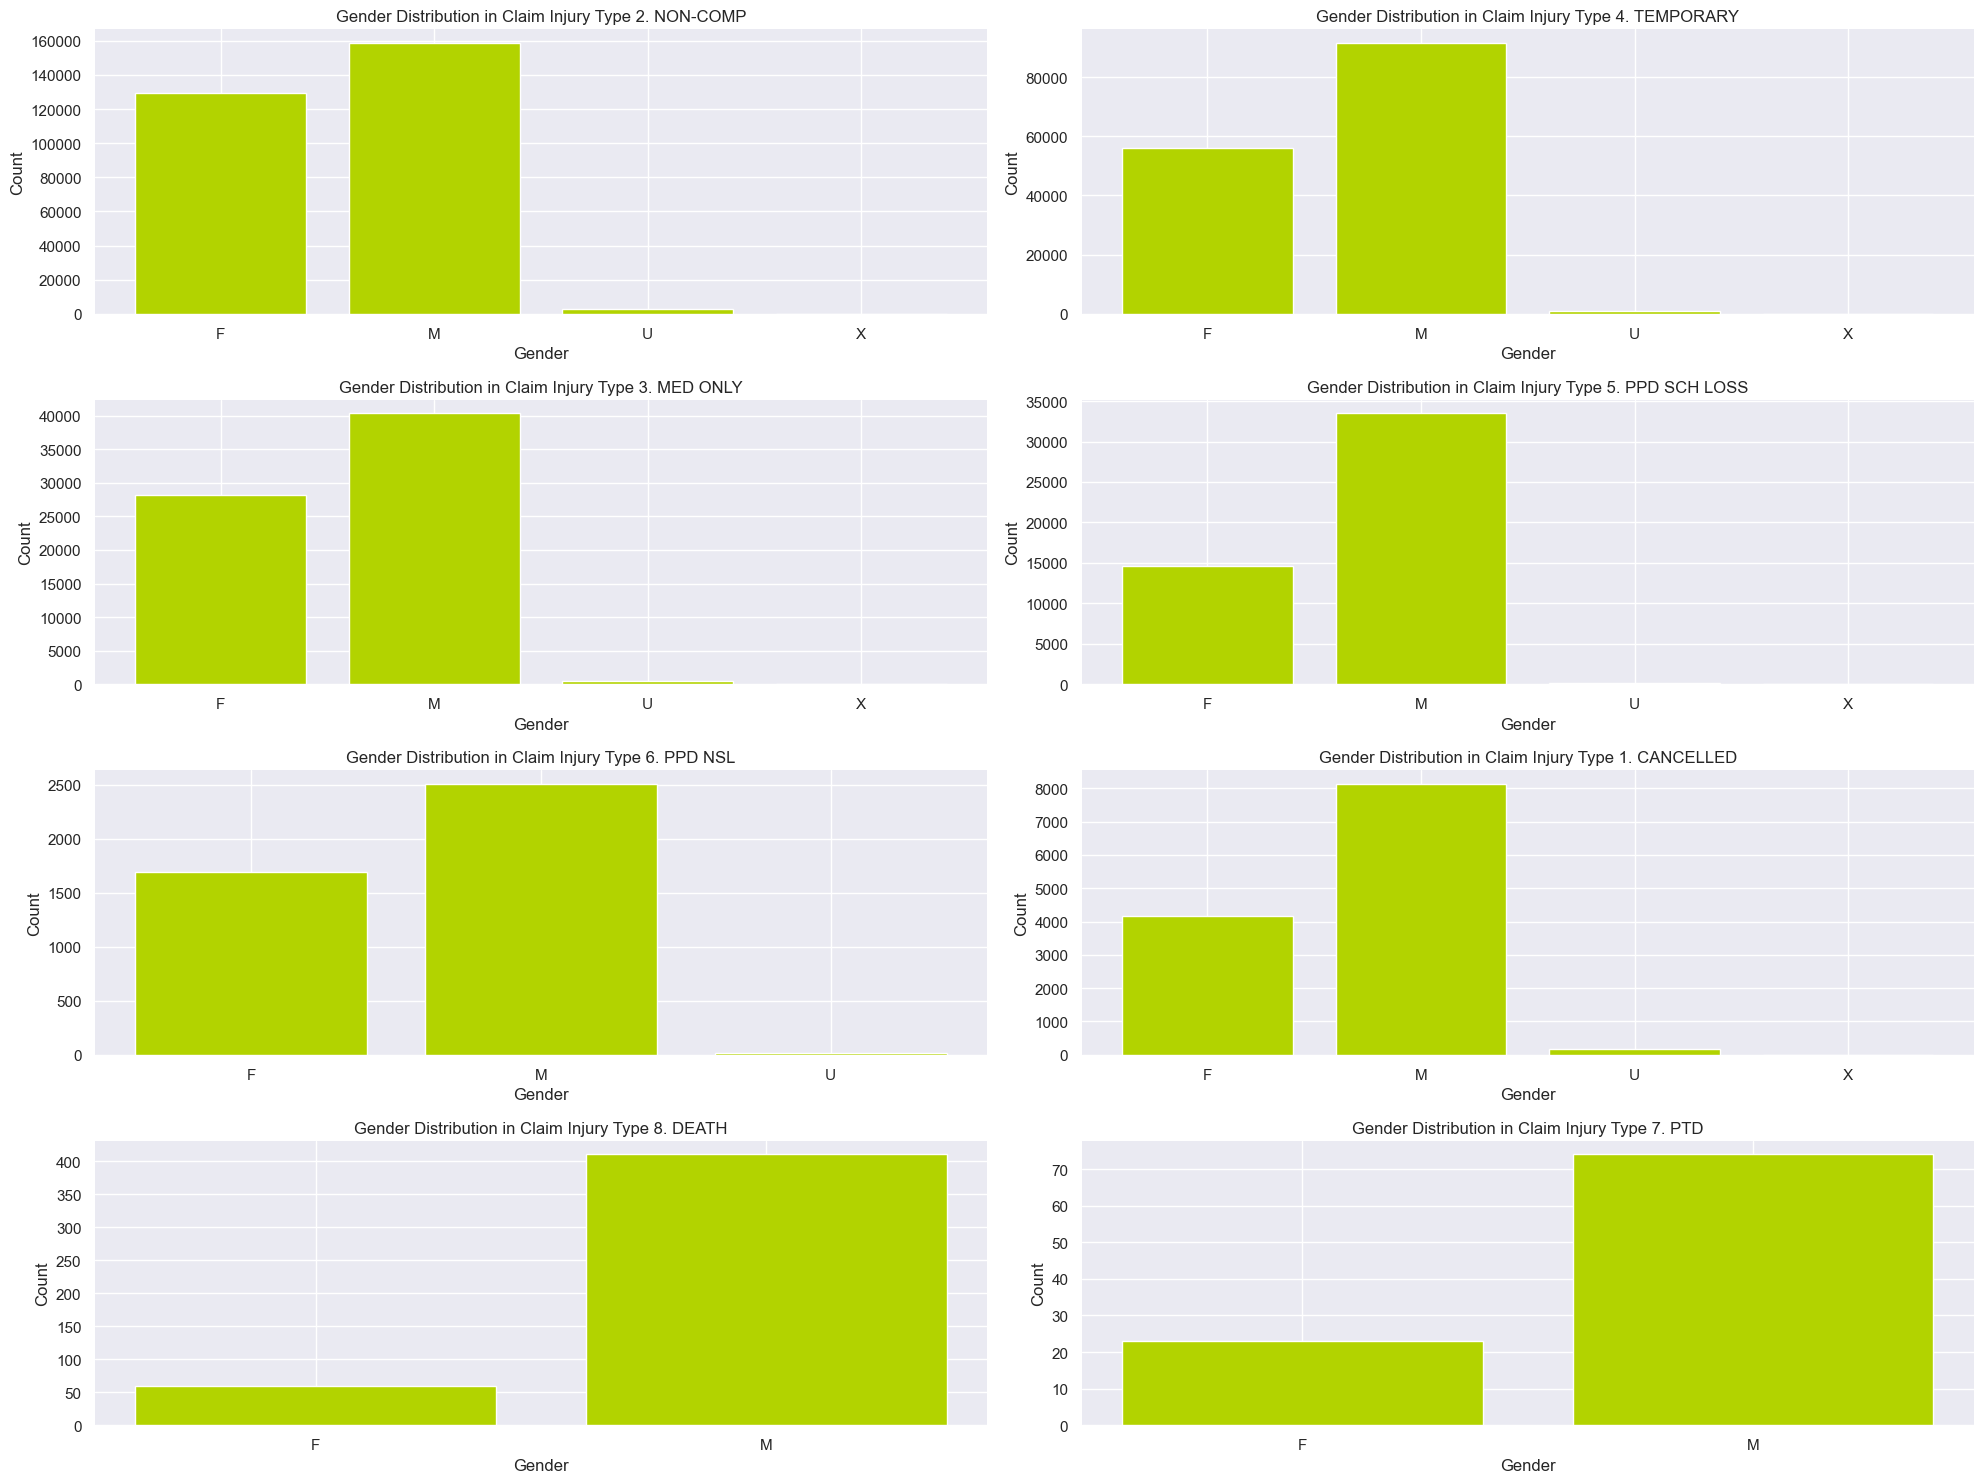

In [50]:
claim_injury_types = df_train['Claim Injury Type'].unique()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

for ax, claim_injury_type in zip(axes.flatten(), claim_injury_types):
    age_group_counts = df_train[df_train['Claim Injury Type'] == claim_injury_type]['Gender'].value_counts().sort_index()
    bars = ax.bar(age_group_counts.index, age_group_counts.values, color='#B2D300')
    ax.set_xlabel('Gender')
    ax.set_ylabel('Count')
    ax.set_title(f'Gender Distribution in Claim Injury Type {claim_injury_type}')
    ax.set_xticks(range(len(age_group_counts.index)))
    ax.set_xticklabels(age_group_counts.index, rotation=0)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

The distribution of gender across the the claim injury types was also observed.

The `Gender` variable has two minority categories, "U" and "X", this could prove to be troublesome. As such, it will be adressed in the data cleaning phase.

### Unbalanced Columns

Two columns seem to be unbalanced: `Alternative Dispute Resolution` and `COVID-19 Indicator`.

In [51]:
dispute_count = df_train['Alternative Dispute Resolution'].value_counts()
dispute_count_percent = dispute_count / dispute_count.sum() * 100
print(dispute_count_percent)

Alternative Dispute Resolution
N    99.544620
Y     0.454509
U     0.000871
Name: count, dtype: float64


In [52]:
df_train = df_train.drop(columns=['Alternative Dispute Resolution'])

`Alternative Dispute Resolution` consists of three unique values, but two of them account for less than 1% of instances. Therefore, the group removed this column.

In [53]:
covid_count = df_train['COVID-19 Indicator'].value_counts()
covid_count_percent = covid_count / covid_count.sum() * 100
print(covid_count_percent)

COVID-19 Indicator
N    95.205618
Y     4.794382
Name: count, dtype: float64


The `COVID-19 Indicator` is composed by (roughly) 95% of cases where the claimant did **not** have covid and 5% where the claimant **had** covid. This variable is highly unbalanced, which could mean its prediction power is very low. Further research is necessary to understand its utility.

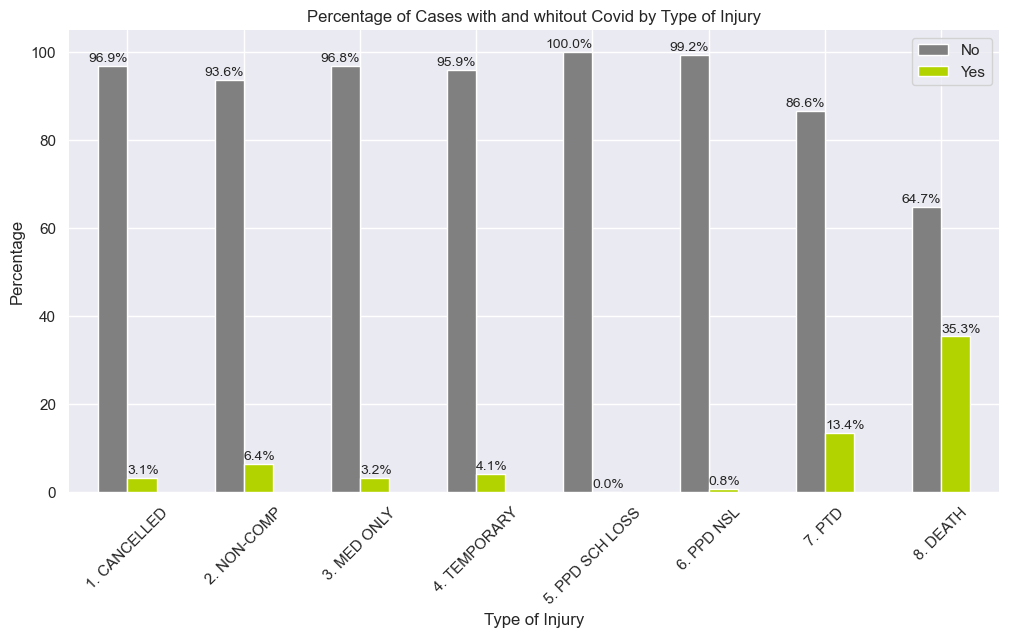

In [54]:
claim_injury_covid = pd.crosstab(df_train['Claim Injury Type'], df_train['COVID-19 Indicator'])
claim_injury_covid.columns = ['No', 'Yes']
claim_injury_covid.reset_index(inplace=True)
claim_injury_covid['Yes'] = claim_injury_covid['Yes'] / (claim_injury_covid['No'] + claim_injury_covid['Yes']) * 100
claim_injury_covid['No'] = 100 - claim_injury_covid['Yes']
claim_injury_covid
claim_injury_covid.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Type of Injury')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and whitout Covid by Type of Injury')
for index, value in enumerate(claim_injury_covid['Yes']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='left', fontsize=10)
for index, value in enumerate(claim_injury_covid['No']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='right', fontsize=10)
plt.xticks(ticks=claim_injury_covid.index, labels=claim_injury_covid['Claim Injury Type'], rotation=45)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

It can be observed that the cases where the injury type is "DEATH" have a much higher rate of covid. There could possibly be a correlation between these variables, so at this time the Covid variable will be kept.

### Accident Location

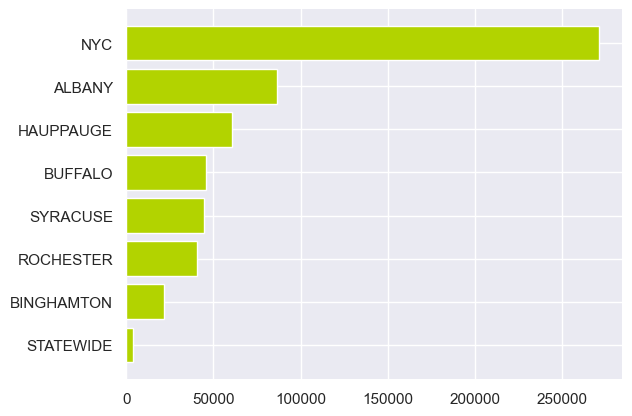

In [55]:
district_counts = df_train['District Name'].value_counts()
plt.barh(district_counts.index, district_counts.values, color='#B2D300')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

Most cases happen in the region of NYC (New York City, which accounts for 5 counties). This could be due to its higher population count.

References:

https://worldpopulationreview.com/us-counties/new-york

How does the target variable behave in these communities?

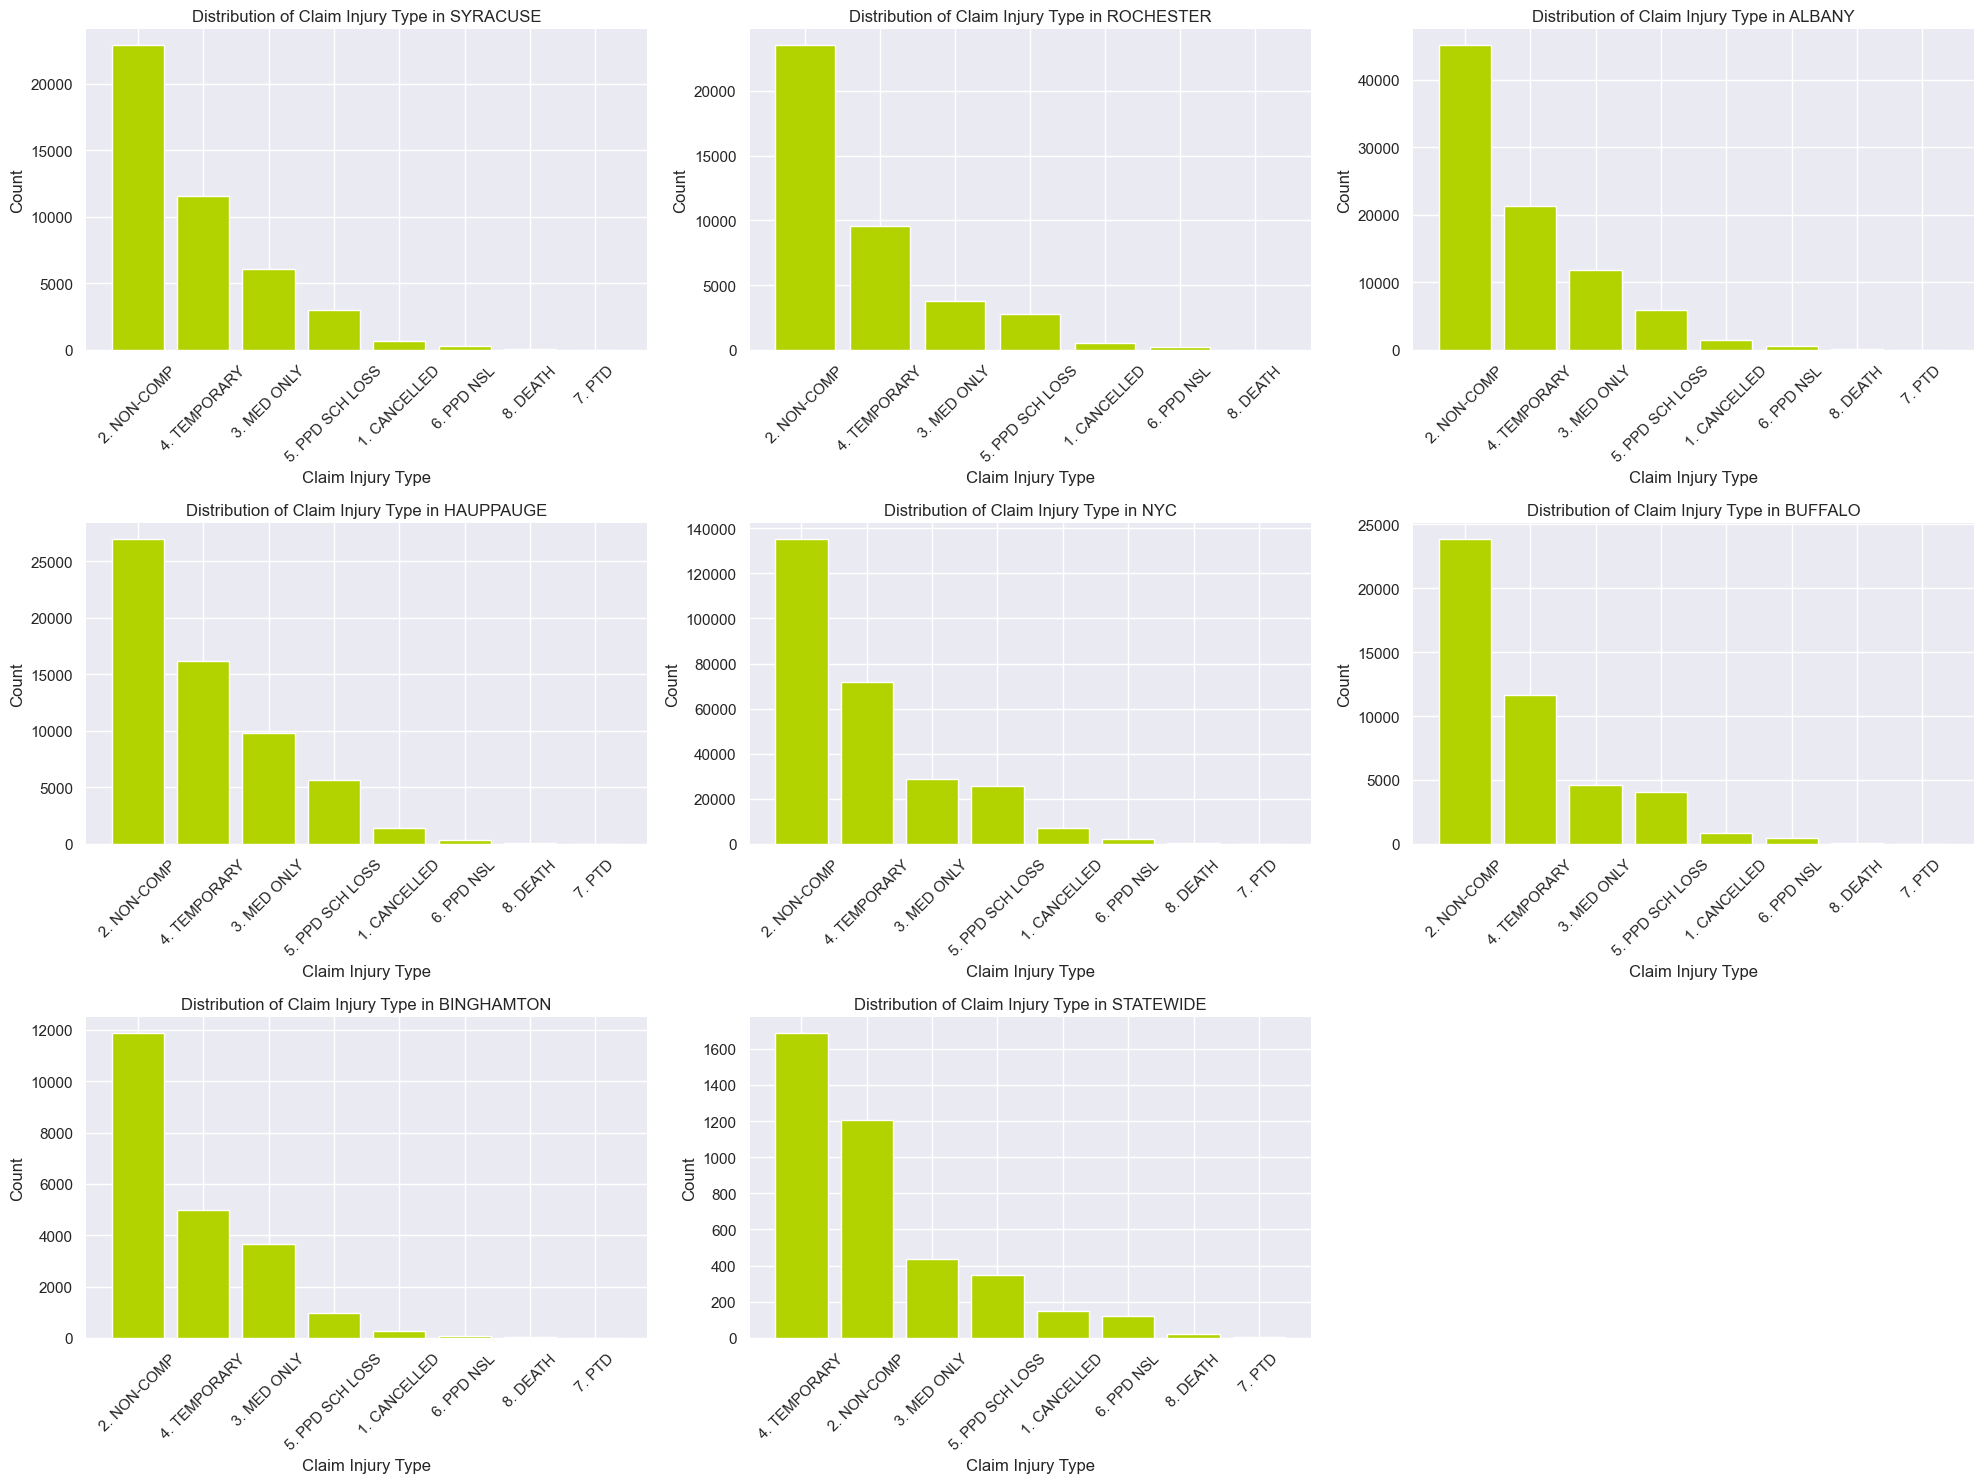

In [56]:
places = df_train['District Name'].unique()
num_places = len(places)
fig, axes = plt.subplots(nrows=ceil(num_places / 3), ncols=3, figsize=(20, 15))

for ax, place in zip(axes.flatten(), places):
    claim_injury_counts = df_train[df_train['District Name'] == place]['Claim Injury Type'].value_counts()
    bars = ax.bar(claim_injury_counts.index, claim_injury_counts.values, color='#B2D300')
    ax.set_xlabel('Claim Injury Type')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Claim Injury Type in {place}')
    ax.set_xticks(range(len(claim_injury_counts.index)))
    ax.set_xticklabels(claim_injury_counts.index, rotation=45)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Remove any empty subplots
for ax in axes.flatten()[num_places:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

The distribution of cases seems to be mostly equal for all locations, except one. In Statewide, the group observed that the most frequent claim injury type was the "4. Temporary".

### Average Weekly Wage

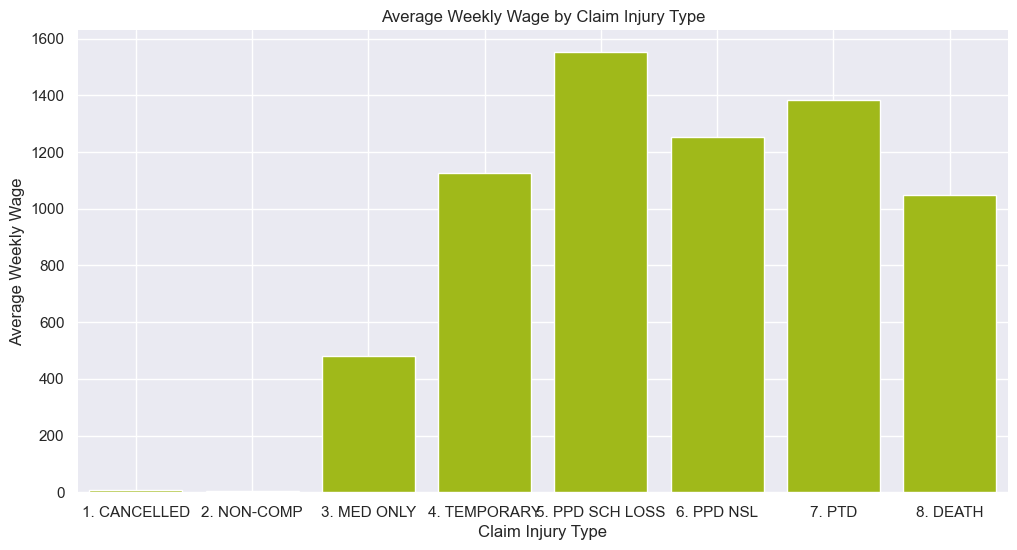

In [57]:
average_salary_by_claim = df_train.groupby('Claim Injury Type')['Average Weekly Wage'].mean()           # Group by 'Claim Injury Type' and calculate the mean of 'Average Weekly Wage'

plt.figure(figsize=(12, 6))
sns.barplot(x=average_salary_by_claim.index, y=average_salary_by_claim.values, color='#B2D300')
plt.xlabel('Claim Injury Type')
plt.ylabel('Average Weekly Wage')
plt.title('Average Weekly Wage by Claim Injury Type')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The average weekly wage represents "the wage used to calculate workers’ compensation benefits, disability benefits, or an employee’s Paid Family Leave wage replacement benefits". 

The bar chart shows that the categories with the lowest average weekly wage are the first three. This is reasonable given that these claims are the ones without monetary compensation. Yet, more can be explored in this variable.<br>

References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [58]:
bins = (0, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000, 500000, 1000000)
df_train['wage_groups'] = pd.cut(df_train['Average Weekly Wage'], bins=bins)

The group attempted to group the values of this variable.

In [59]:
wage_group_counts = df_train['wage_groups'].value_counts().sort_index()
wage_group_counts_percentage = wage_group_counts / wage_group_counts.sum() * 100
wage_group_table = pd.DataFrame({'Wage Group': wage_group_counts.index,'Count': wage_group_counts.values,'Percentage': wage_group_counts_percentage.values})
wage_group_table['Wage Group'] = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-10000', '10000-20000', '20000-30000', '30000-40000',
                                 '40000-50000', '50000-100000', '100000-200000', '200000-300000', '300000-400000', '400000-500000', '500000-1000000']
wage_group_table

Wage Group  Count  Percentage
0           0-1000  96645   46.038967
1        1000-2000  87274   41.574886
2        2000-3000  20881    9.947123
3        3000-4000   3763    1.792588
4        4000-5000    973    0.463510
5       5000-10000    328    0.156250
6      10000-20000     29    0.013815
7      20000-30000      9    0.004287
8      30000-40000      2    0.000953
9      40000-50000      2    0.000953
10    50000-100000      3    0.001429
11   100000-200000      6    0.002858
12   200000-300000      3    0.001429
13   300000-400000      2    0.000953
14   400000-500000      0    0.000000
15  500000-1000000      0    0.000000

Roughly 96% of the data falls in the range of 0 to 3000 USD. Further research into this range could reveal some important insights.

In [60]:
df_train1 = df_train[df_train['Average Weekly Wage'] < 3000]
bins = (0, 500, 1000, 1500, 2000, 2500, 3000)
df_train1['wage_groups'] = pd.cut(df_train1['Average Weekly Wage'], bins=bins)

In [61]:
df_train1['Average Weekly Wage'].mean()

437.4035081107196

The average falls bellow what it should (it should be around 1000 according to the previous table), this could be due to a large majority of low values in the 0 to 500 USD range. 

In the begining of the notebook, it was pointed out that the boxplot was skewed, so the next step is looking for zeros.

In [62]:
df_testing = df_train1[df_train1['Average Weekly Wage'] == 0]
percent = len(df_testing)/len(df_train)*100
print(f'The percentage of observations where the salary is 0 is: {percent:.2f}%')

The percentage of observations where the salary is 0 is: 58.44%


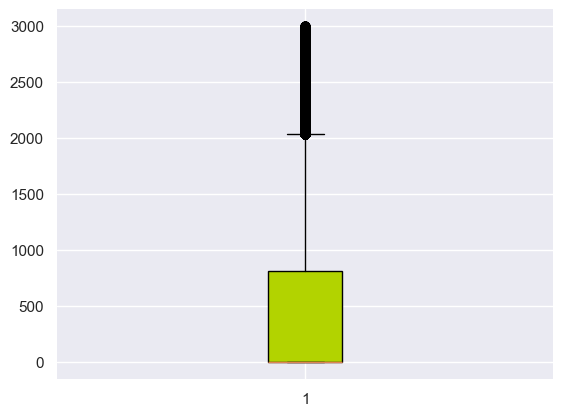

In [63]:
plt.boxplot(df_train1['Average Weekly Wage'], patch_artist=True,
            boxprops=dict(facecolor='#B2D300'))
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In the boxplot, the fact that this variable is dominated by zeros becomes obvious.

Therefore, the previously created bins are not representative of the average weekly wage variable, and will be reworked.

The new organization will work as follows:

- No Salary
- Low Salary
- Medium Salary
- High Salary

To better pick the limits of each category the data will be plotted without outliers and zeros.

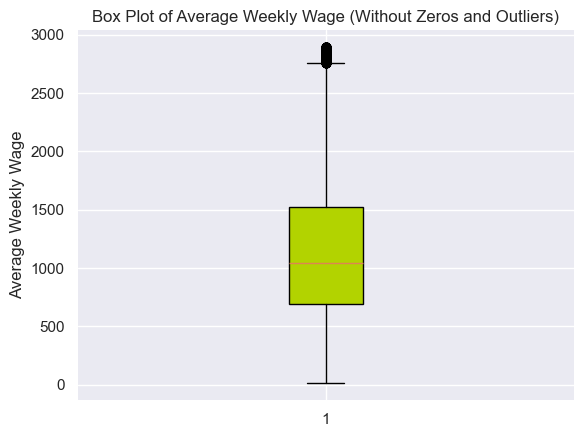

In [64]:
df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

Q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25)
Q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_non_zero_wage_no_outliers = df_non_zero_wage[(df_non_zero_wage['Average Weekly Wage'] >= lower_bound) & (df_non_zero_wage['Average Weekly Wage'] <= upper_bound)]

plt.boxplot(df_non_zero_wage_no_outliers['Average Weekly Wage'], patch_artist=True,
            boxprops=dict(facecolor='#B2D300'))
plt.title('Box Plot of Average Weekly Wage (Without Zeros and Outliers)')
plt.ylabel('Average Weekly Wage')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [65]:
# calculate the quantiles and IQR excluding claims with 0 wage
df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25) # 25th percentile or first quartile
q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)  # 75th percentile or third quartile
iqr = q3 - q1
lower_bound = max(0,q1 - 1.5 * iqr)                          # the max function ensures the lower bound cannot be less than 0, as negative wages are not valid
upper_bound = q3 + 1.5 * iqr

Given the present boxplot, the following division was decided:<br>
- No Compensation: Value = 0
- Low Wage: Lower Bound < Value < First Quartile
- Medium Wage: First Quartile <= Value <= Third Quartile
- High Wage: Third Quartile < Value <= Upper Bound
- Very High Wage: Upper Bound < Value

In [66]:
bins = [-1, 0, q1, q3, upper_bound, df_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
df_train['wage_groups'] = pd.cut(df_train['Average Weekly Wage'], bins=bins, labels=labels)
df_train[['Average Weekly Wage', 'wage_groups']]

Average Weekly Wage  wage_groups
0                      0.00      No Wage
1                   1745.93    High Wage
2                   1434.80  Medium Wage
4                       NaN          NaN
5                      0.00      No Wage
...                     ...          ...
593451                 0.00      No Wage
593455                 0.00      No Wage
593456               991.08  Medium Wage
593457                 0.00      No Wage
593467                 0.00      No Wage

[574026 rows x 2 columns]

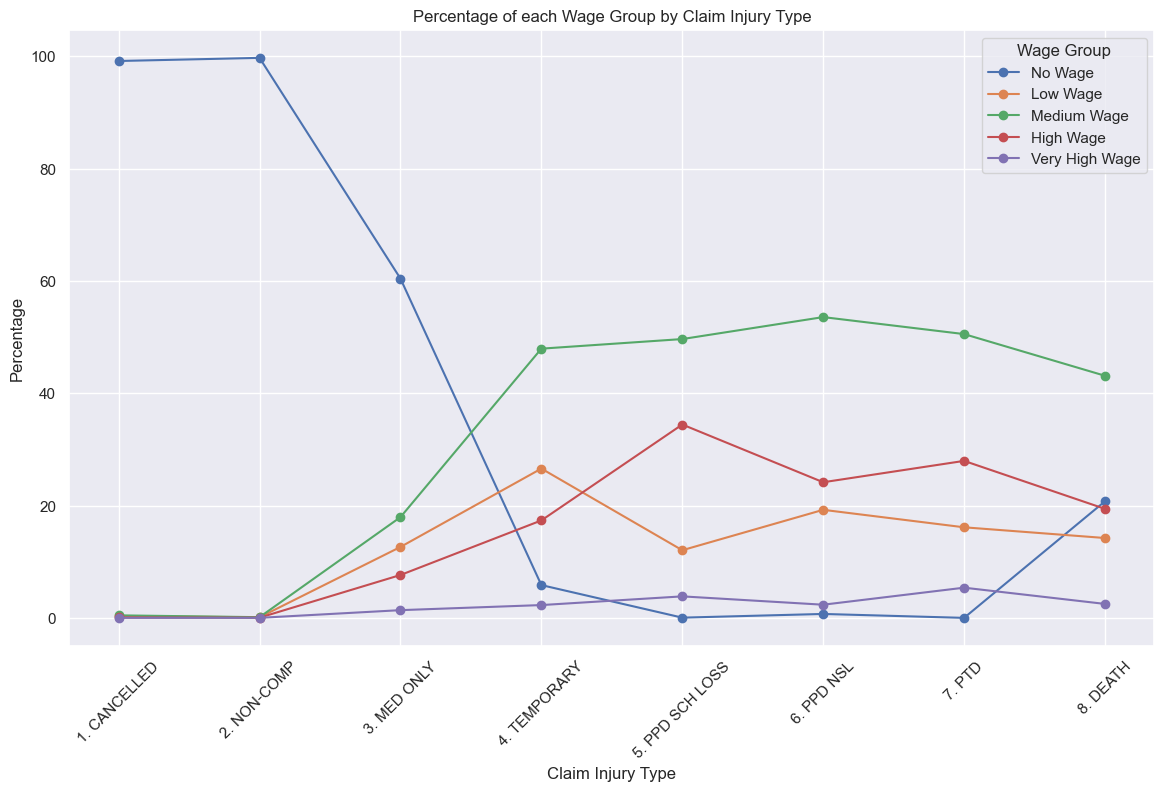

In [67]:
wage_groups_by_claim = pd.crosstab(df_train['Claim Injury Type'], df_train['wage_groups'])
wage_groups_by_claim_percentage = wage_groups_by_claim.div(wage_groups_by_claim.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
for wage_group in wage_groups_by_claim_percentage.columns:
    plt.plot(wage_groups_by_claim_percentage.index, wage_groups_by_claim_percentage[wage_group], marker='o', label=wage_group)

plt.xlabel('Claim Injury Type')
plt.ylabel('Percentage')
plt.title('Percentage of each Wage Group by Claim Injury Type')
plt.legend(title='Wage Group')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

As expected, the first two categories are dominated by "No Wage" observations. As the wage category increases, the proportion of "No Wage" observations decreases, with the exception of the "Very High Wage" category, which has few observations.

In [68]:
df_train['Average Weekly Wage'].value_counts()

Average Weekly Wage
0.00       335450
250.00       3193
600.00       2319
1765.00      1294
500.00       1264
            ...  
1409.93         1
1483.02         1
1885.51         1
2676.03         1
1008.86         1
Name: count, Length: 120024, dtype: int64

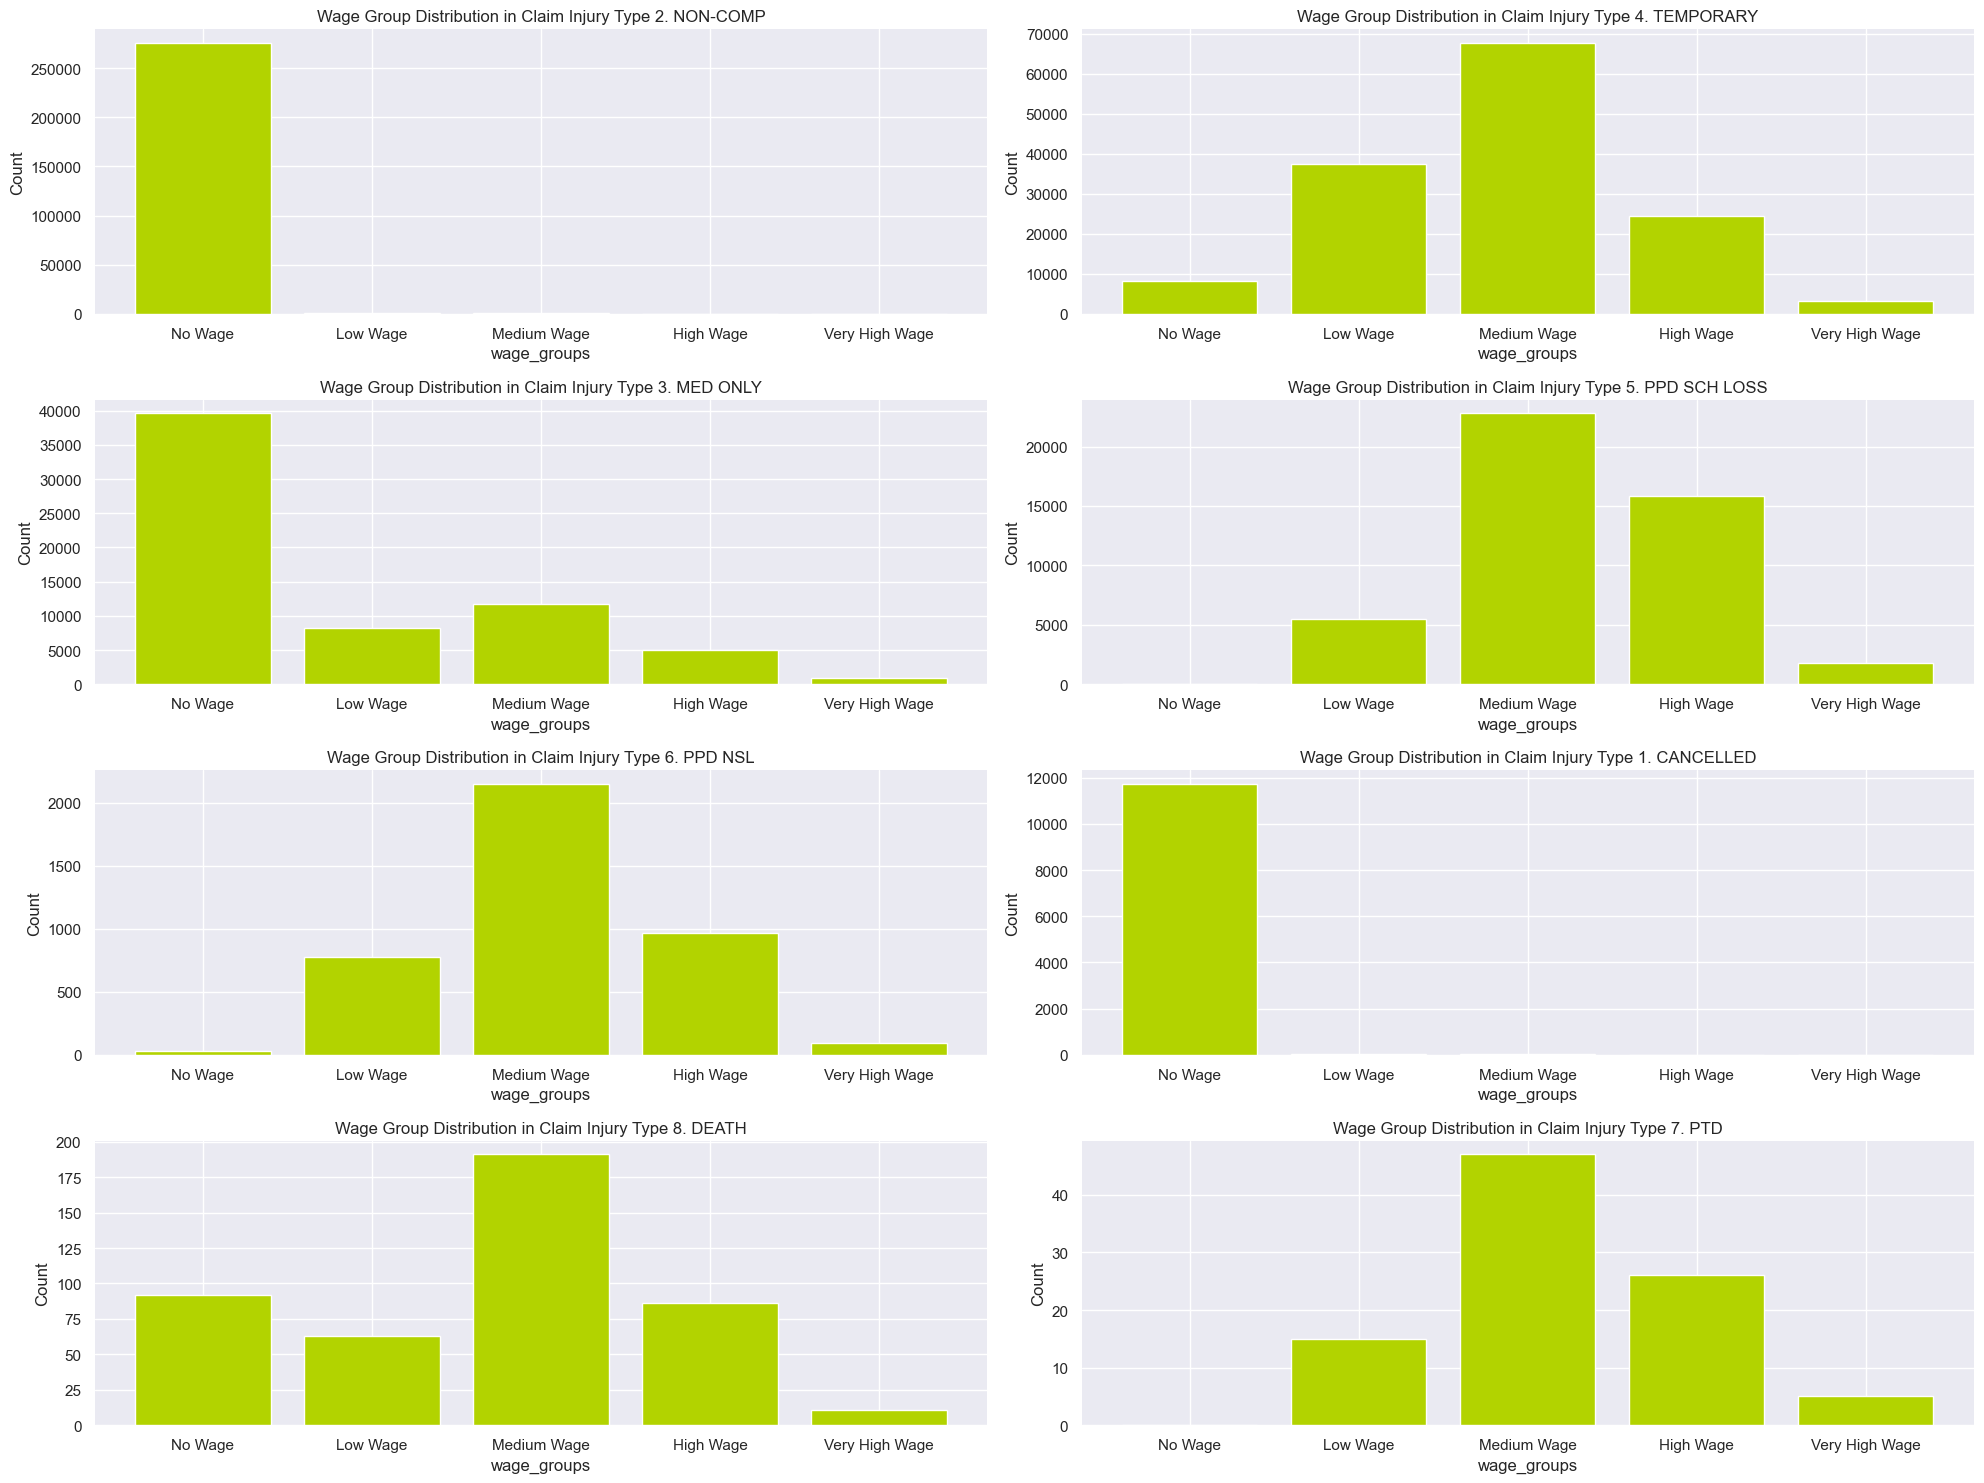

In [69]:
claim_injury_types = df_train['Claim Injury Type'].unique()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

for ax, claim_injury_type in zip(axes.flatten(), claim_injury_types):
    age_group_counts = df_train[df_train['Claim Injury Type'] == claim_injury_type]['wage_groups'].value_counts().sort_index()
    bars = ax.bar(age_group_counts.index, age_group_counts.values, color='#B2D300')
    ax.set_xlabel('wage_groups')
    ax.set_ylabel('Count')
    ax.set_title(f'Wage Group Distribution in Claim Injury Type {claim_injury_type}')
    ax.set_xticks(range(len(age_group_counts.index)))
    ax.set_xticklabels(age_group_counts.index, rotation=0)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

The distribution across claim injury types was also studied and it looks like there is some variability.

### Medical Fee Region

In [70]:
df_train['Medical Fee Region'].unique()

array(['I', 'II', 'IV', 'UK', 'III'], dtype=object)

What is the meaning of these codes:

I - Region 1: Rural areas outside of Buffalo, Albany, Syracuse, Rochester, Utica & Binghamton<br>
II - Region 2: Buffalo, Albany, Syracuse, Rochester, Utica & Binghamton<br>
III - Region 3: Westchester, Rockland & most of Suffolk, Orange, & Putnam<br>
IV - Region 4: New York City, Nassau, and Western Suffolk<br>
UK - Unknown

Reference:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

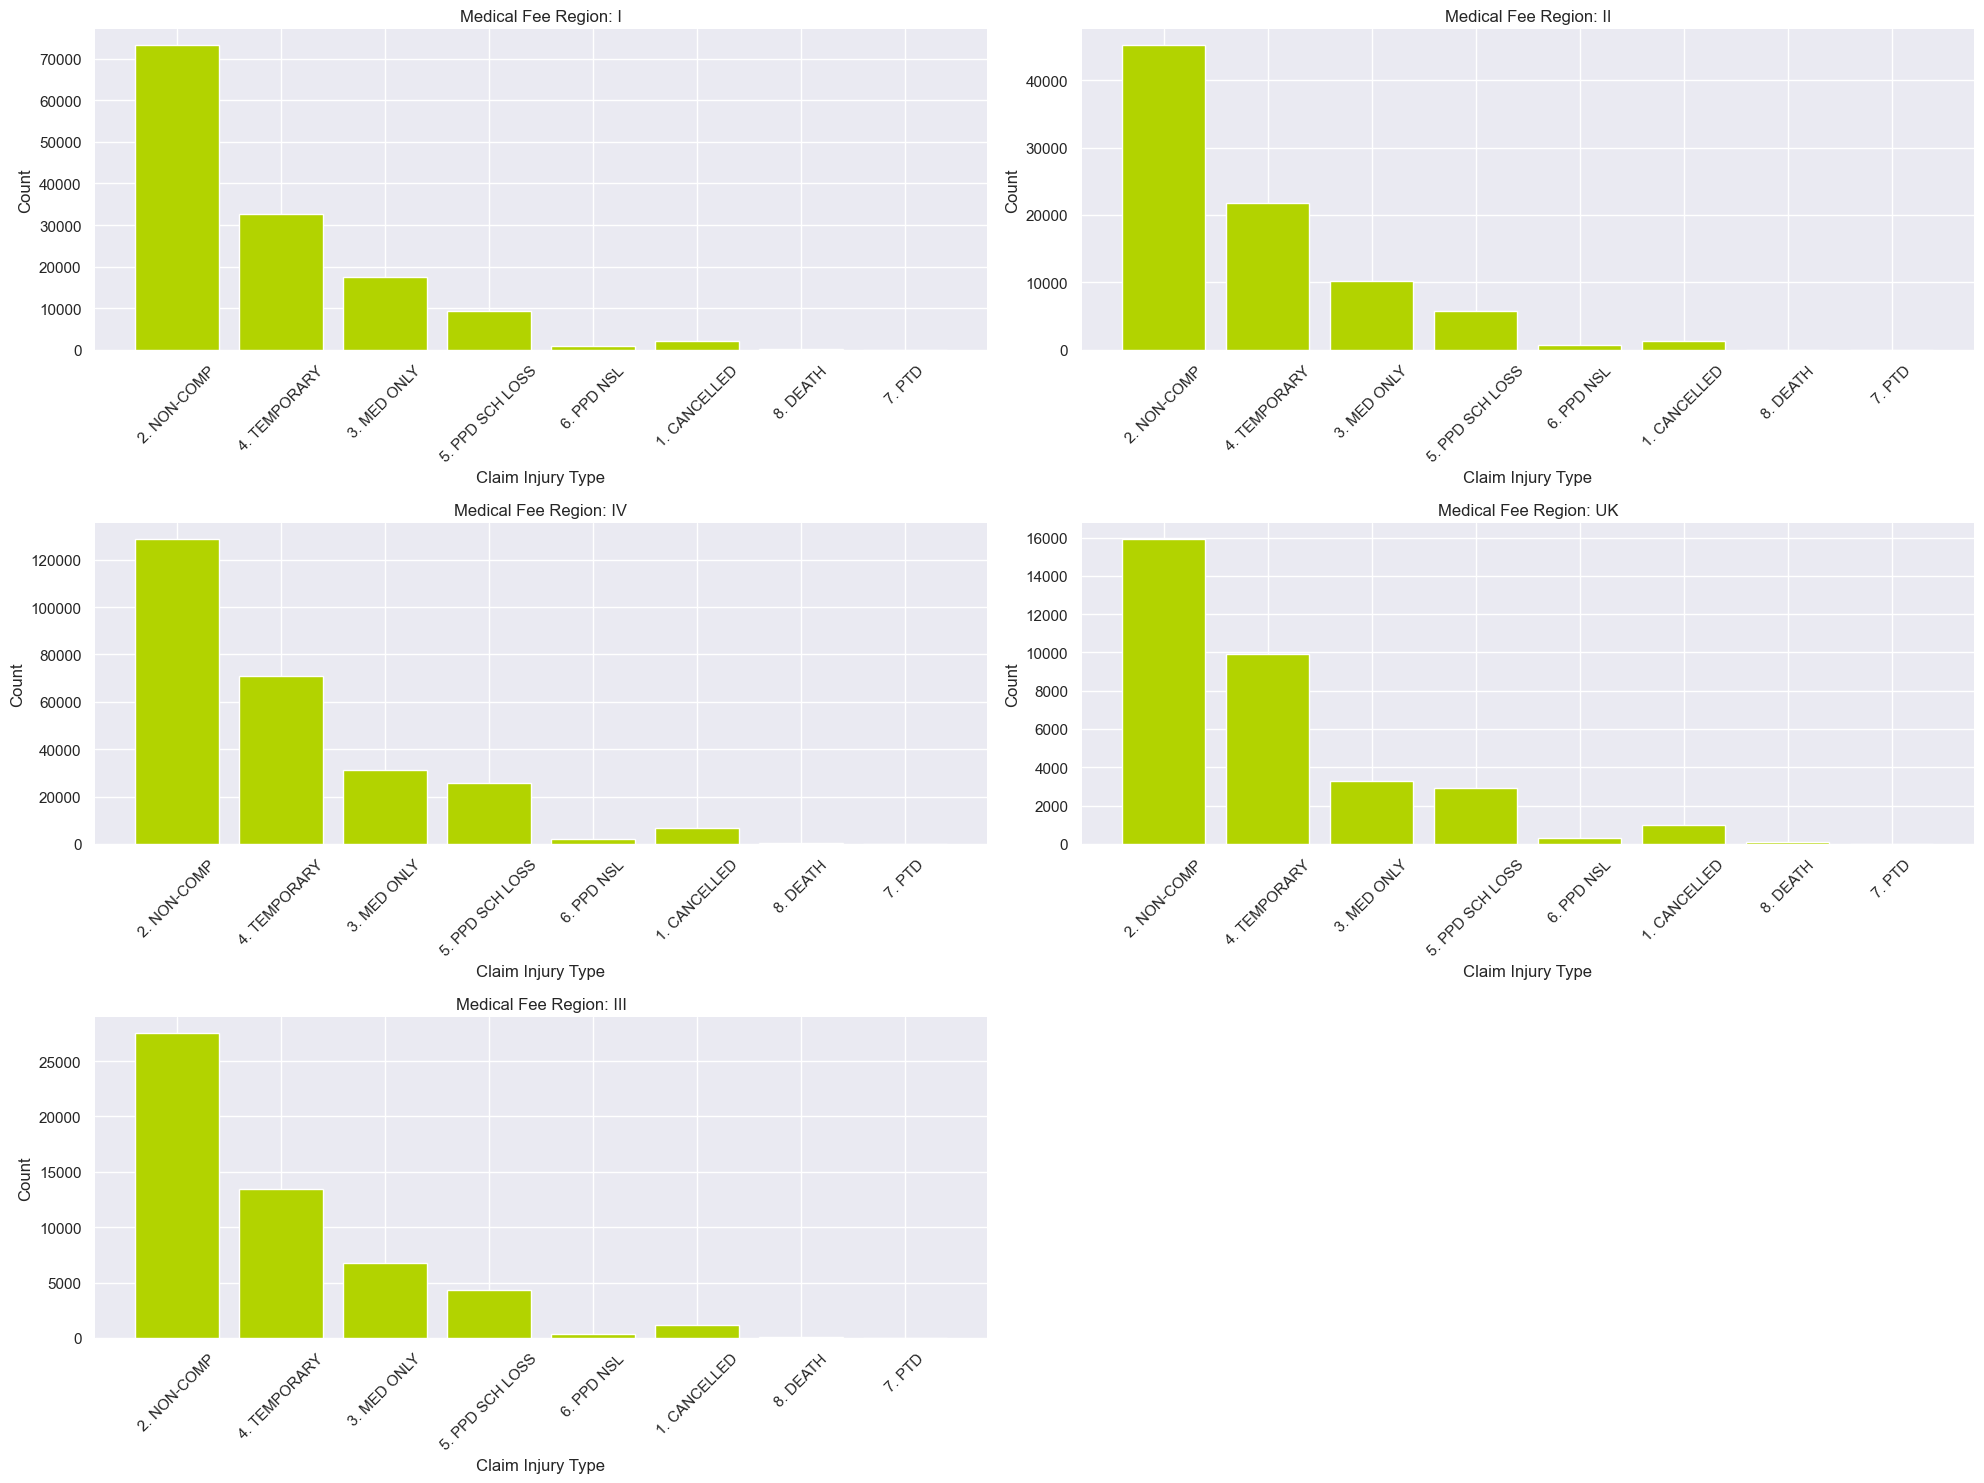

In [71]:
medical_fee_regions = df_train['Medical Fee Region'].unique()
claim_injury_types = df_train['Claim Injury Type'].unique()

fig, axes = plt.subplots(nrows=ceil(len(medical_fee_regions) / 2), ncols=2, figsize=(20, 15))
for ax, region in zip(axes.flatten(), medical_fee_regions):
    region_data = df_train[df_train['Medical Fee Region'] == region]
    claim_counts = region_data['Claim Injury Type'].value_counts().reindex(claim_injury_types, fill_value=0)
    ax.bar(claim_counts.index, claim_counts.values, color='#B2D300')
    ax.set_title(f'Medical Fee Region: {region}')
    ax.set_xlabel('Claim Injury Type')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(claim_counts.index)))
    ax.set_xticklabels(claim_counts.index, rotation=45)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
for ax in axes.flatten()[len(medical_fee_regions):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

The distribution remains the same in the first target variable.

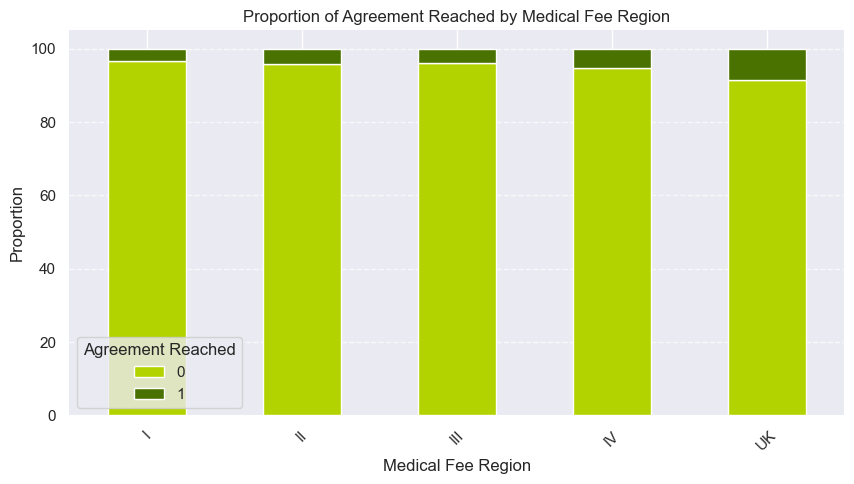

In [72]:
medfee_proportion = pd.crosstab(df_train['Medical Fee Region'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
medfee_proportion.plot(kind='bar', stacked=True, color=colors, ax=ax)
plt.xlabel('Medical Fee Region')
plt.ylabel('Proportion')
plt.title('Proportion of Agreement Reached by Medical Fee Region')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

As expected, the variable follows the same distribution and most of the cases are not agreed upon.

## Carrier Type

In [73]:
df_train['Carrier Type'].unique()

array(['1A. PRIVATE', '2A. SIF', '4A. SELF PRIVATE', '3A. SELF PUBLIC',
       'UNKNOWN', '5D. SPECIAL FUND - UNKNOWN',
       '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)',
       '5C. SPECIAL FUND - POI CARRIER WCB MENANDS'], dtype=object)

This variable has the following unique values:

- 1A. PRIVATE
- 2A. SIF
- 3A. SELF PUBLIC
- 4A. SELF PRIVATE
- 5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)
- 5C. SPECIAL FUND - POI CARRIER WCB MENANDS
- 5D. SPECIAL FUND - UNKNOWN
- UNKNOWN

In the data dictionary provided by the WCB, the following description is given:

> Type of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker’s employer (Private Carrier, State Insurance 1  Fund, Selfinsured, or Special Fund). (See FAQ for clarifications on carrier type)

From this, we can gather that the carrier types can be grouped into the following categories:

- Private Carrier
- State Insurance
- Self-Insured
- Special Fund

And in the case of the present data, another group has to be added to account for the rows where the `carrier type` is unknown.

The new carrier types will be structured as follows:

| Original Carrier Type | New Group |
|---|---|
| 1A. PRIVATE | Private Carrier |
| 2A. SIF | State Insurance |
| 3A. SELF PUBLIC | Self-Public |
| 4A. SELF PRIVATE | Self-Private |
| 5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A) | Special Fund |
| 5C. SPECIAL FUND - POI CARRIER WCB MENANDS | Special Fund |
| 5D. SPECIAL FUND - UNKNOWN | Special Fund |
| UNKNOWN | Unknown |

Note that the 3rd group (Self-Insured) isn't kept, instead its subdivisions (SELF PRIVATE and SELF PUBLIC) are kept. This is due to the fact that both these categories have enough observations to represent their own group, and there are differences among them that would be lost if they were mixed. For example, the average weekly salary in SELF-PUBLIC is almost the double of SELF-PRIVATE.

Before grouping, the group decided to take a look at the distribution of each type to see how it was affected by the transformation.

In [74]:
value_c = df_train['Carrier Type'].value_counts()
value_c_df = pd.DataFrame({'Carrier Type': value_c.index, 'Count': value_c.values})
value_c_df['Percentage'] = value_c_df['Count'] / len(df_train) * 100
value_c_df

Carrier Type   Count  Percentage
0                                  1A. PRIVATE  285368   49.713428
1                              3A. SELF PUBLIC  121920   21.239456
2                                      2A. SIF  111144   19.362189
3                             4A. SELF PRIVATE   52788    9.196099
4                                      UNKNOWN    1774    0.309045
5                   5D. SPECIAL FUND - UNKNOWN    1023    0.178215
6   5C. SPECIAL FUND - POI CARRIER WCB MENANDS       5    0.000871
7  5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)       4    0.000697

<Axes: ylabel='Carrier Type'>

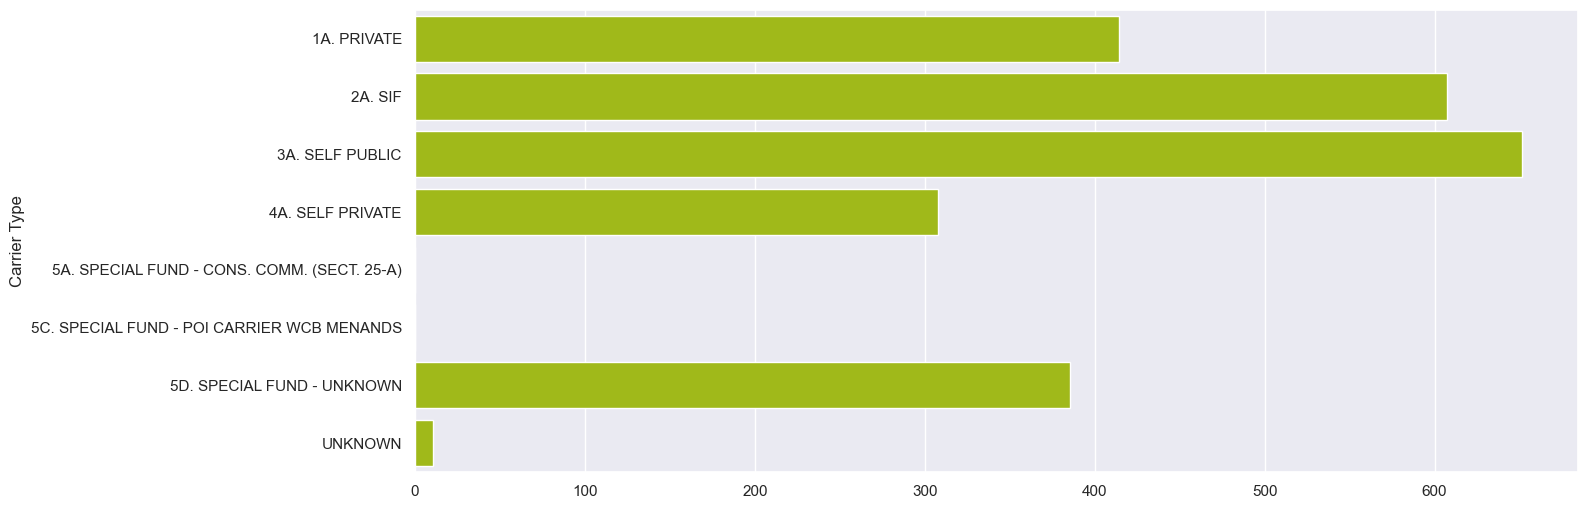

In [75]:
avg_weekly_wage_by_carrier_type = df_train.groupby('Carrier Type')['Average Weekly Wage'].mean()
plt.figure(figsize=(15, 6))
sns.barplot(x=avg_weekly_wage_by_carrier_type.values, y=avg_weekly_wage_by_carrier_type.index, color='#B2D300')

Text(0.5, 1.0, 'Proportion of Attorney/Representative by Carrier Type')

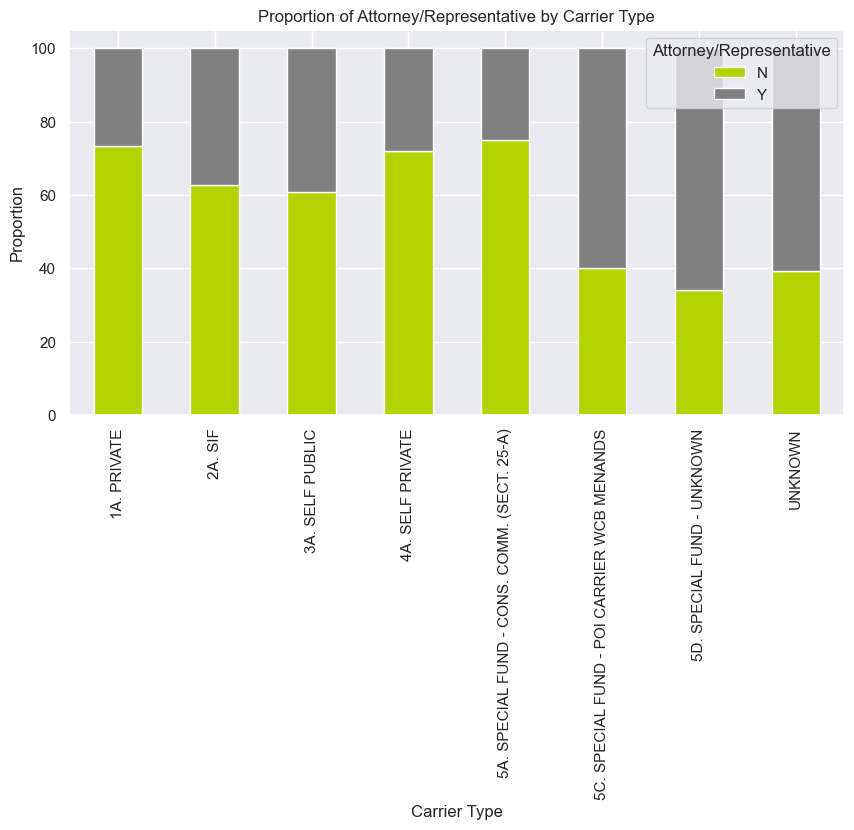

In [76]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Attorney/Representative'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax, color=['#B2D300', 'Grey'])
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Attorney/Representative by Carrier Type')

Text(0.5, 1.0, 'Proportion of Genders by Carrier Type')

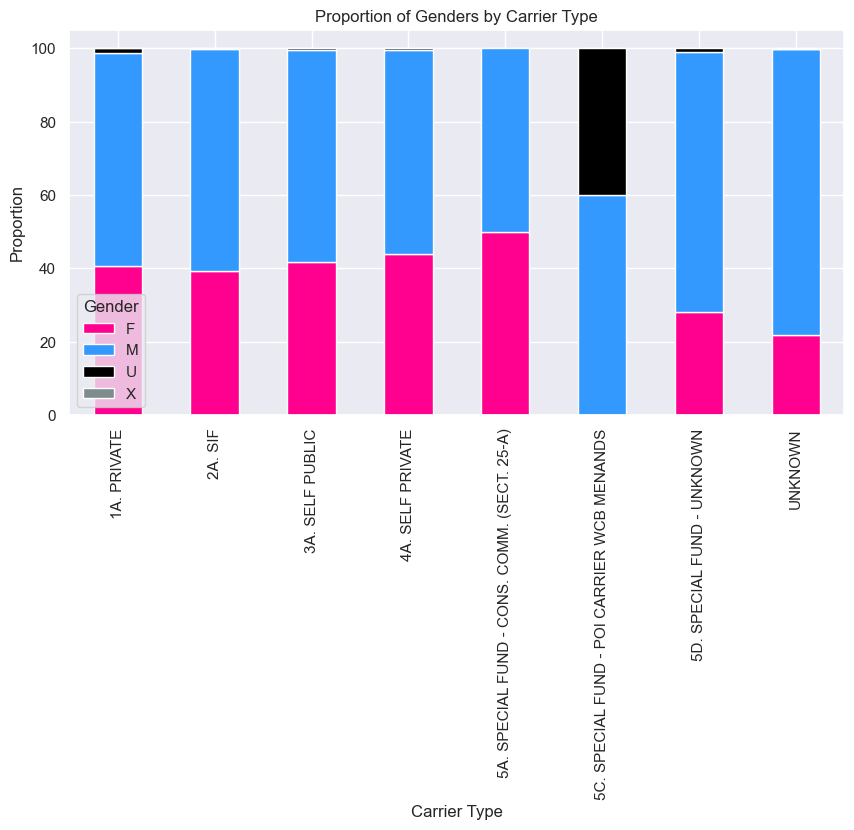

In [77]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Gender'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  
colors = ['#ff008f', '#3399ff', '#000000', '#7f8c8d']
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax, color=colors)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

The group decided to combine all Special Funds Carrier Types into a single category to simplify the analysis, as their low representation had minimal impact on the overall trends.

In [78]:
df_train['Carrier Type'] = df_train['Carrier Type'].map({
    '1A. PRIVATE': 'PRIVATE',
    '2A. SIF': 'STATE INSURANCE',
    '3A. SELF PUBLIC': 'SELF-PUBLIC',
    '4A. SELF PRIVATE': 'SELF-PRIVATE',
    '5D. SPECIAL FUND - UNKNOWN': 'SPECIAL FUND',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'SPECIAL FUND',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)':'SPECIAL FUND',
    'UNKNOWN':'UNKNOWN'
    })

In [79]:
value_c = df_train['Carrier Type'].value_counts()
value_c_df = pd.DataFrame({'Carrier Type': value_c.index, 'Count': value_c.values})
value_c_df['Percentage'] = value_c_df['Count'] / len(df_train) * 100
value_c_df

Carrier Type   Count  Percentage
0          PRIVATE  285368   49.713428
1      SELF-PUBLIC  121920   21.239456
2  STATE INSURANCE  111144   19.362189
3     SELF-PRIVATE   52788    9.196099
4          UNKNOWN    1774    0.309045
5     SPECIAL FUND    1032    0.179783

<Axes: ylabel='Carrier Type'>

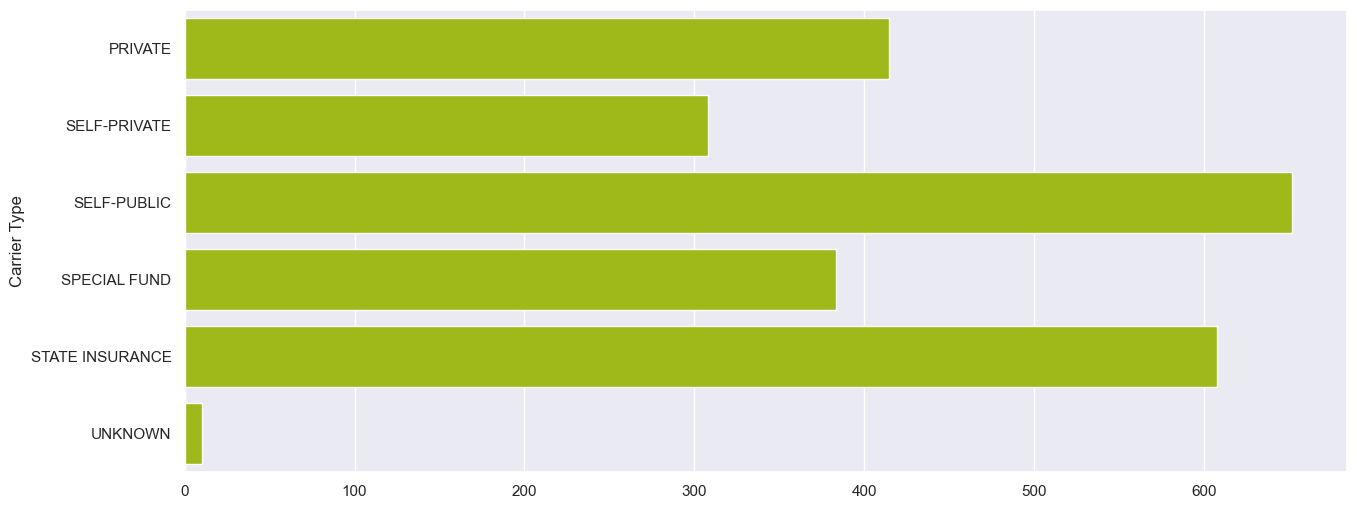

In [80]:
avg_weekly_wage_by_carrier_type = df_train.groupby('Carrier Type')['Average Weekly Wage'].mean()
plt.figure(figsize=(15, 6))
sns.barplot(x=avg_weekly_wage_by_carrier_type.values, y=avg_weekly_wage_by_carrier_type.index, color='#B2D300')

Text(0.5, 1.0, 'Proportion of Attorney/Representative by Carrier Type')

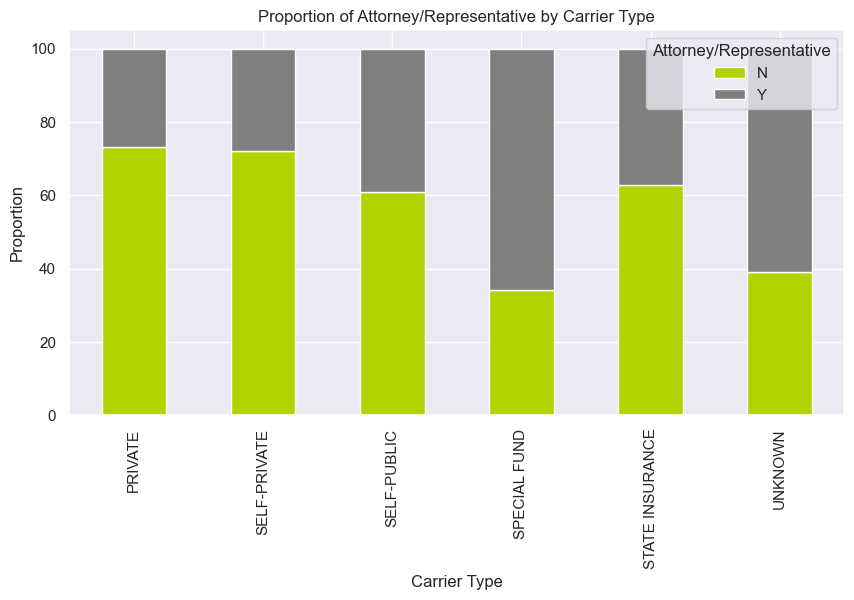

In [81]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Attorney/Representative'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax, color=['#B2D300', 'Grey'])
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Attorney/Representative by Carrier Type')

Text(0.5, 1.0, 'Proportion of Genders by Carrier Type')

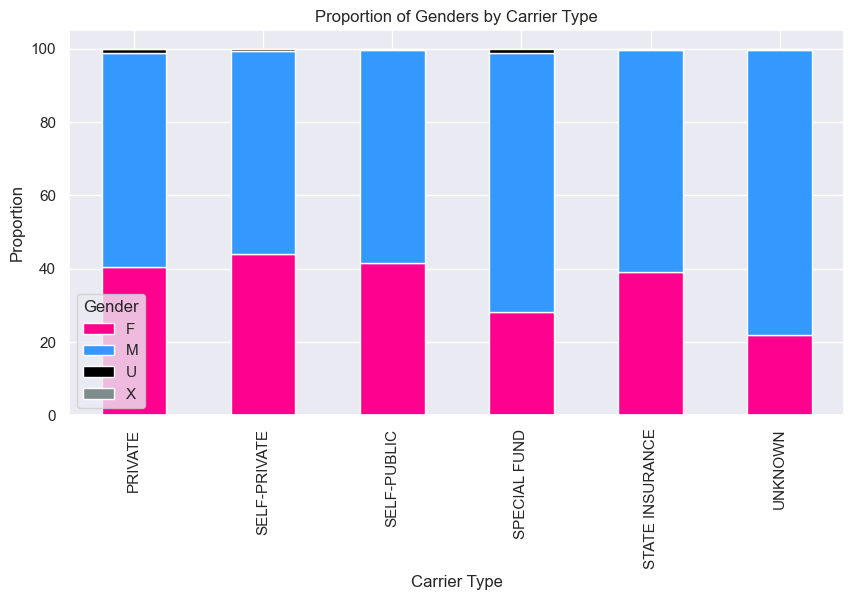

In [82]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Gender'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  
colors = ['#ff008f', '#3399ff', '#000000', '#7f8c8d']
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax, color=colors)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

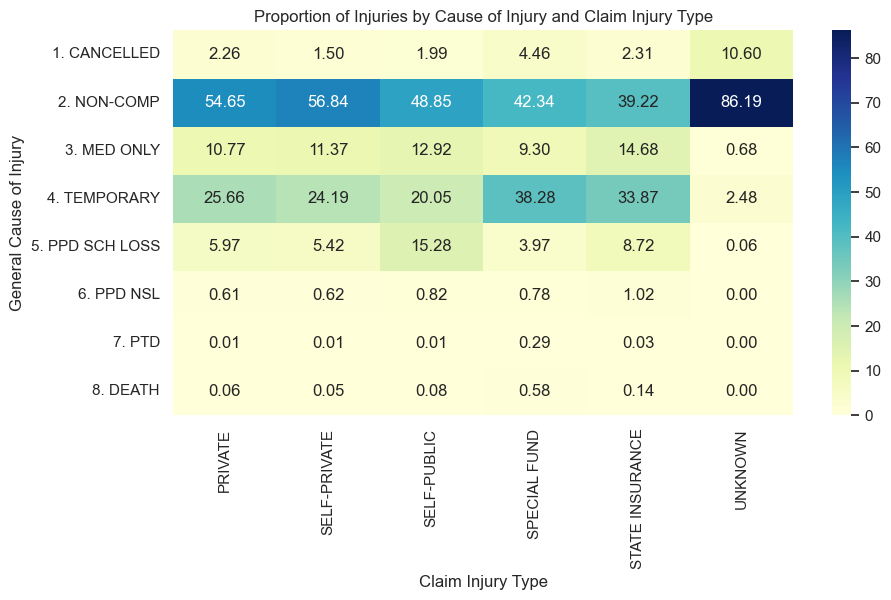

In [83]:
carrier = pd.crosstab(df_train['Claim Injury Type'], df_train['Carrier Type'], normalize='columns') * 100
plt.figure(figsize=(10, 5))
sns.heatmap(carrier, cmap='YlGnBu', annot=True, fmt='.2f')
plt.ylabel('General Cause of Injury')
plt.xlabel('Claim Injury Type')
plt.title('Proportion of Injuries by Cause of Injury and Claim Injury Type')
plt.show()

## WCIO Code Variables

In the dataset, there are a lot of columns regarding codes (industry codes, injury codes, etc.). These codes have a high cardinality (there are between 50 to 70 unique values) and, as such, they are of no use to the model or visualization.

In [84]:
unique_cause_codes = df_train[['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']].drop_duplicates()
unique_nature_codes = df_train[['WCIO Nature of Injury Code', 'WCIO Nature of Injury Description']].drop_duplicates()
unique_body_codes = df_train[['WCIO Part Of Body Code', 'WCIO Part Of Body Description']].drop_duplicates()

In [85]:
unique_body_codes

WCIO Part Of Body Code  \
0                         62   
1                         38   
2                         10   
4                         36   
8                         60   
9                         14   
10                        55   
11                        53   
12                        37   
14                        42   
16                        61   
17                        54   
18                        51   
21                        52   
24                        17   
28                        34   
29                        23   
40                        35   
41                        18   
44                        31   
45                        25   
47                        56   
53                        32   
66                        30   
70                        90   
71                        91   
74                        20   
77                        44   
100                       39   
105                       13   
111                       50   
113                       43   
122                       33   
128                       -9   
151                       22   
167                       41   
175                       11   
190                       57   
200                       19   
210                     <NA>   
241                       16   
252                       66   
302                       40   
330                       99   
342                       65   
387                       46   
434                       15   
470                       58   
583                       48   
673                       49   
827                       21   
973                       63   
1009                      12   
1158                      45   
1185                      64   
1636                      24   
2761                      47   
4856                      26   

                          WCIO Part Of Body Description  
0                                              BUTTOCKS  
1                                           SHOULDER(S)  
2                                  MULTIPLE HEAD INJURY  
4                                             FINGER(S)  
8                                                 LUNGS  
9                                                EYE(S)  
10                                                ANKLE  
11                                                 KNEE  
12                                                THUMB  
14                                      LOWER BACK AREA  
16                              ABDOMEN INCLUDING GROIN  
17                                            LOWER LEG  
18                                                  HIP  
21                                            UPPER LEG  
24                                                MOUTH  
28                                                WRIST  
29                                          SPINAL CORD  
40                                                 HAND  
41                                          SOFT TISSUE  
44                                            UPPER ARM  
45                                          SOFT TISSUE  
47                                                 FOOT  
53                                                ELBOW  
66                           MULTIPLE UPPER EXTREMITIES  
70                  MULTIPLE BODY PARTS (INCLUDING BODY  
71               BODY SYSTEMS AND MULTIPLE BODY SYSTEMS  
74                                 MULTIPLE NECK INJURY  
77                                                CHEST  
100                                 WRIST (S) & HAND(S)  
105                                              EAR(S)  
111                          MULTIPLE LOWER EXTREMITIES  
113                                                DISC  
122                                           LOWER ARM  
128                                            MULTIPLE  
151                                                DISC  
167                          

"WCIO Part Of Body Code" has a value of -9, which could be a mistake.

In [86]:
df_train_minus_9 = df_train[df_train['WCIO Part Of Body Code'] == -9]
df_train_minus_9['WCIO Part Of Body Description'].unique()

array(['MULTIPLE'], dtype=object)

This could be a value that was the result of a wrong input, it could possibly be 9.

In [87]:
df_train_9 = df_train[df_train['WCIO Part Of Body Code'] == 9]
df_train_9.head()

Empty DataFrame
Columns: [Accident Date, Age at Injury, Assembly Date, Attorney/Representative, Average Weekly Wage, Birth Year, C-2 Date, C-3 Date, Carrier Name, Carrier Type, Claim Identifier, Claim Injury Type, County of Injury, COVID-19 Indicator, District Name, First Hearing Date, Gender, IME-4 Count, Industry Code, Industry Code Description, Medical Fee Region, WCIO Cause of Injury Code, WCIO Cause of Injury Description, WCIO Nature of Injury Code, WCIO Nature of Injury Description, WCIO Part Of Body Code, WCIO Part Of Body Description, Zip Code, Agreement Reached, Number of Dependents, days_to_c2, days_to_c2_binned, age_group, wage_groups]
Index: []

[0 rows x 34 columns]

Although it is unlikely, the real value could actually be 90.

In [88]:
df_train_90 = df_train[df_train['WCIO Part Of Body Code'] == 90]
df_train_90['WCIO Part Of Body Description'].unique()

array(['MULTIPLE BODY PARTS (INCLUDING BODY'], dtype=object)

No obvious connections can be found. Hence, this value will be kept.

### Body Groups

To reduce the dimensionality, the codes can be grouped into 5 groups:
- Head
- Torso
- Arms
- Legs
- Other (for unkown codes)

This has to be done manually.

But first, the group checked that there were four descriptions with the same name (two for DISC and two for SOFT TISSUE), but for different parts of the body, so the decision was made to add the respective body part based on the codes.

In [89]:
df_train.loc[df_train['WCIO Part Of Body Code'] == 18, 'WCIO Part Of Body Description'] = 'SOFT TISSUE HEAD'
df_train.loc[df_train['WCIO Part Of Body Code'] == 25, 'WCIO Part Of Body Description'] = 'SOFT TISSUE NECK'
df_train.loc[df_train['WCIO Part Of Body Code'] == 22, 'WCIO Part Of Body Description'] = 'DISC NECK'
df_train.loc[df_train['WCIO Part Of Body Code'] == 43, 'WCIO Part Of Body Description'] = 'DISC TRUNK'

In [90]:
head = [
    "MULTIPLE HEAD INJURY", "EYE(S)", "MOUTH", "EAR(S)", "SKULL", "FACIAL BONES", 
    "TEETH", "NOSE", "BRAIN", "LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "SOFT TISSUE HEAD", "SOFT TISSUE NECK"
]

torso = [
    "TORSO", "SHOULDER(S)", "LUNGS", "BUTTOCKS", "LOWER BACK AREA", "ABDOMEN INCLUDING GROIN", 
    "HIP", "CHEST", "DISC NECK", "DISC TRUNK", "UPPER BACK AREA", "PELVIS", "HEART", "VERTEBRAE", 
    "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", "SACRUM AND COCCYX", "SPINAL CORD", "MULTIPLE TRUNK", "SPINAL CORD", "INTERNAL ORGANS"
]

arm = [
    "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES"
]

leg = [
    "LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", "GREAT TOE", 
    "MULTIPLE LOWER EXTREMITIES"
]

multiple_body_parts = [ 'ARTIFICIAL APPLIANCE', "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED",
                        'NO PHYSICAL INJURY', 'MULTIPLE BODY PARTS (INCLUDING BODY', 'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
                         'WHOLE BODY', 'MULTIPLE']

In [91]:
df_train['body_group'] = np.nan
df_train.loc[df_train['WCIO Part Of Body Description'].isin(head), 'body_group'] = 'Head'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(torso), 'body_group'] = 'Torso'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(arm), 'body_group'] = 'Arms'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(leg), 'body_group'] = 'Legs'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(multiple_body_parts), 'body_group'] = 'Multiple Body Parts'

<BarContainer object of 5 artists>

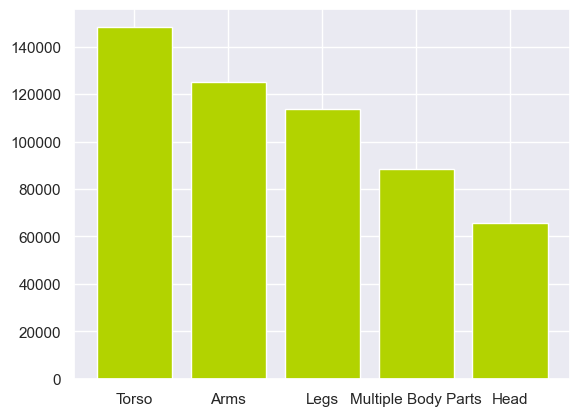

In [92]:
df_train['body_group'].value_counts()
plt.bar(df_train['body_group'].value_counts().index, df_train['body_group'].value_counts().values, color='#B2D300')

Most of our observations suffered injuries in the torso area.

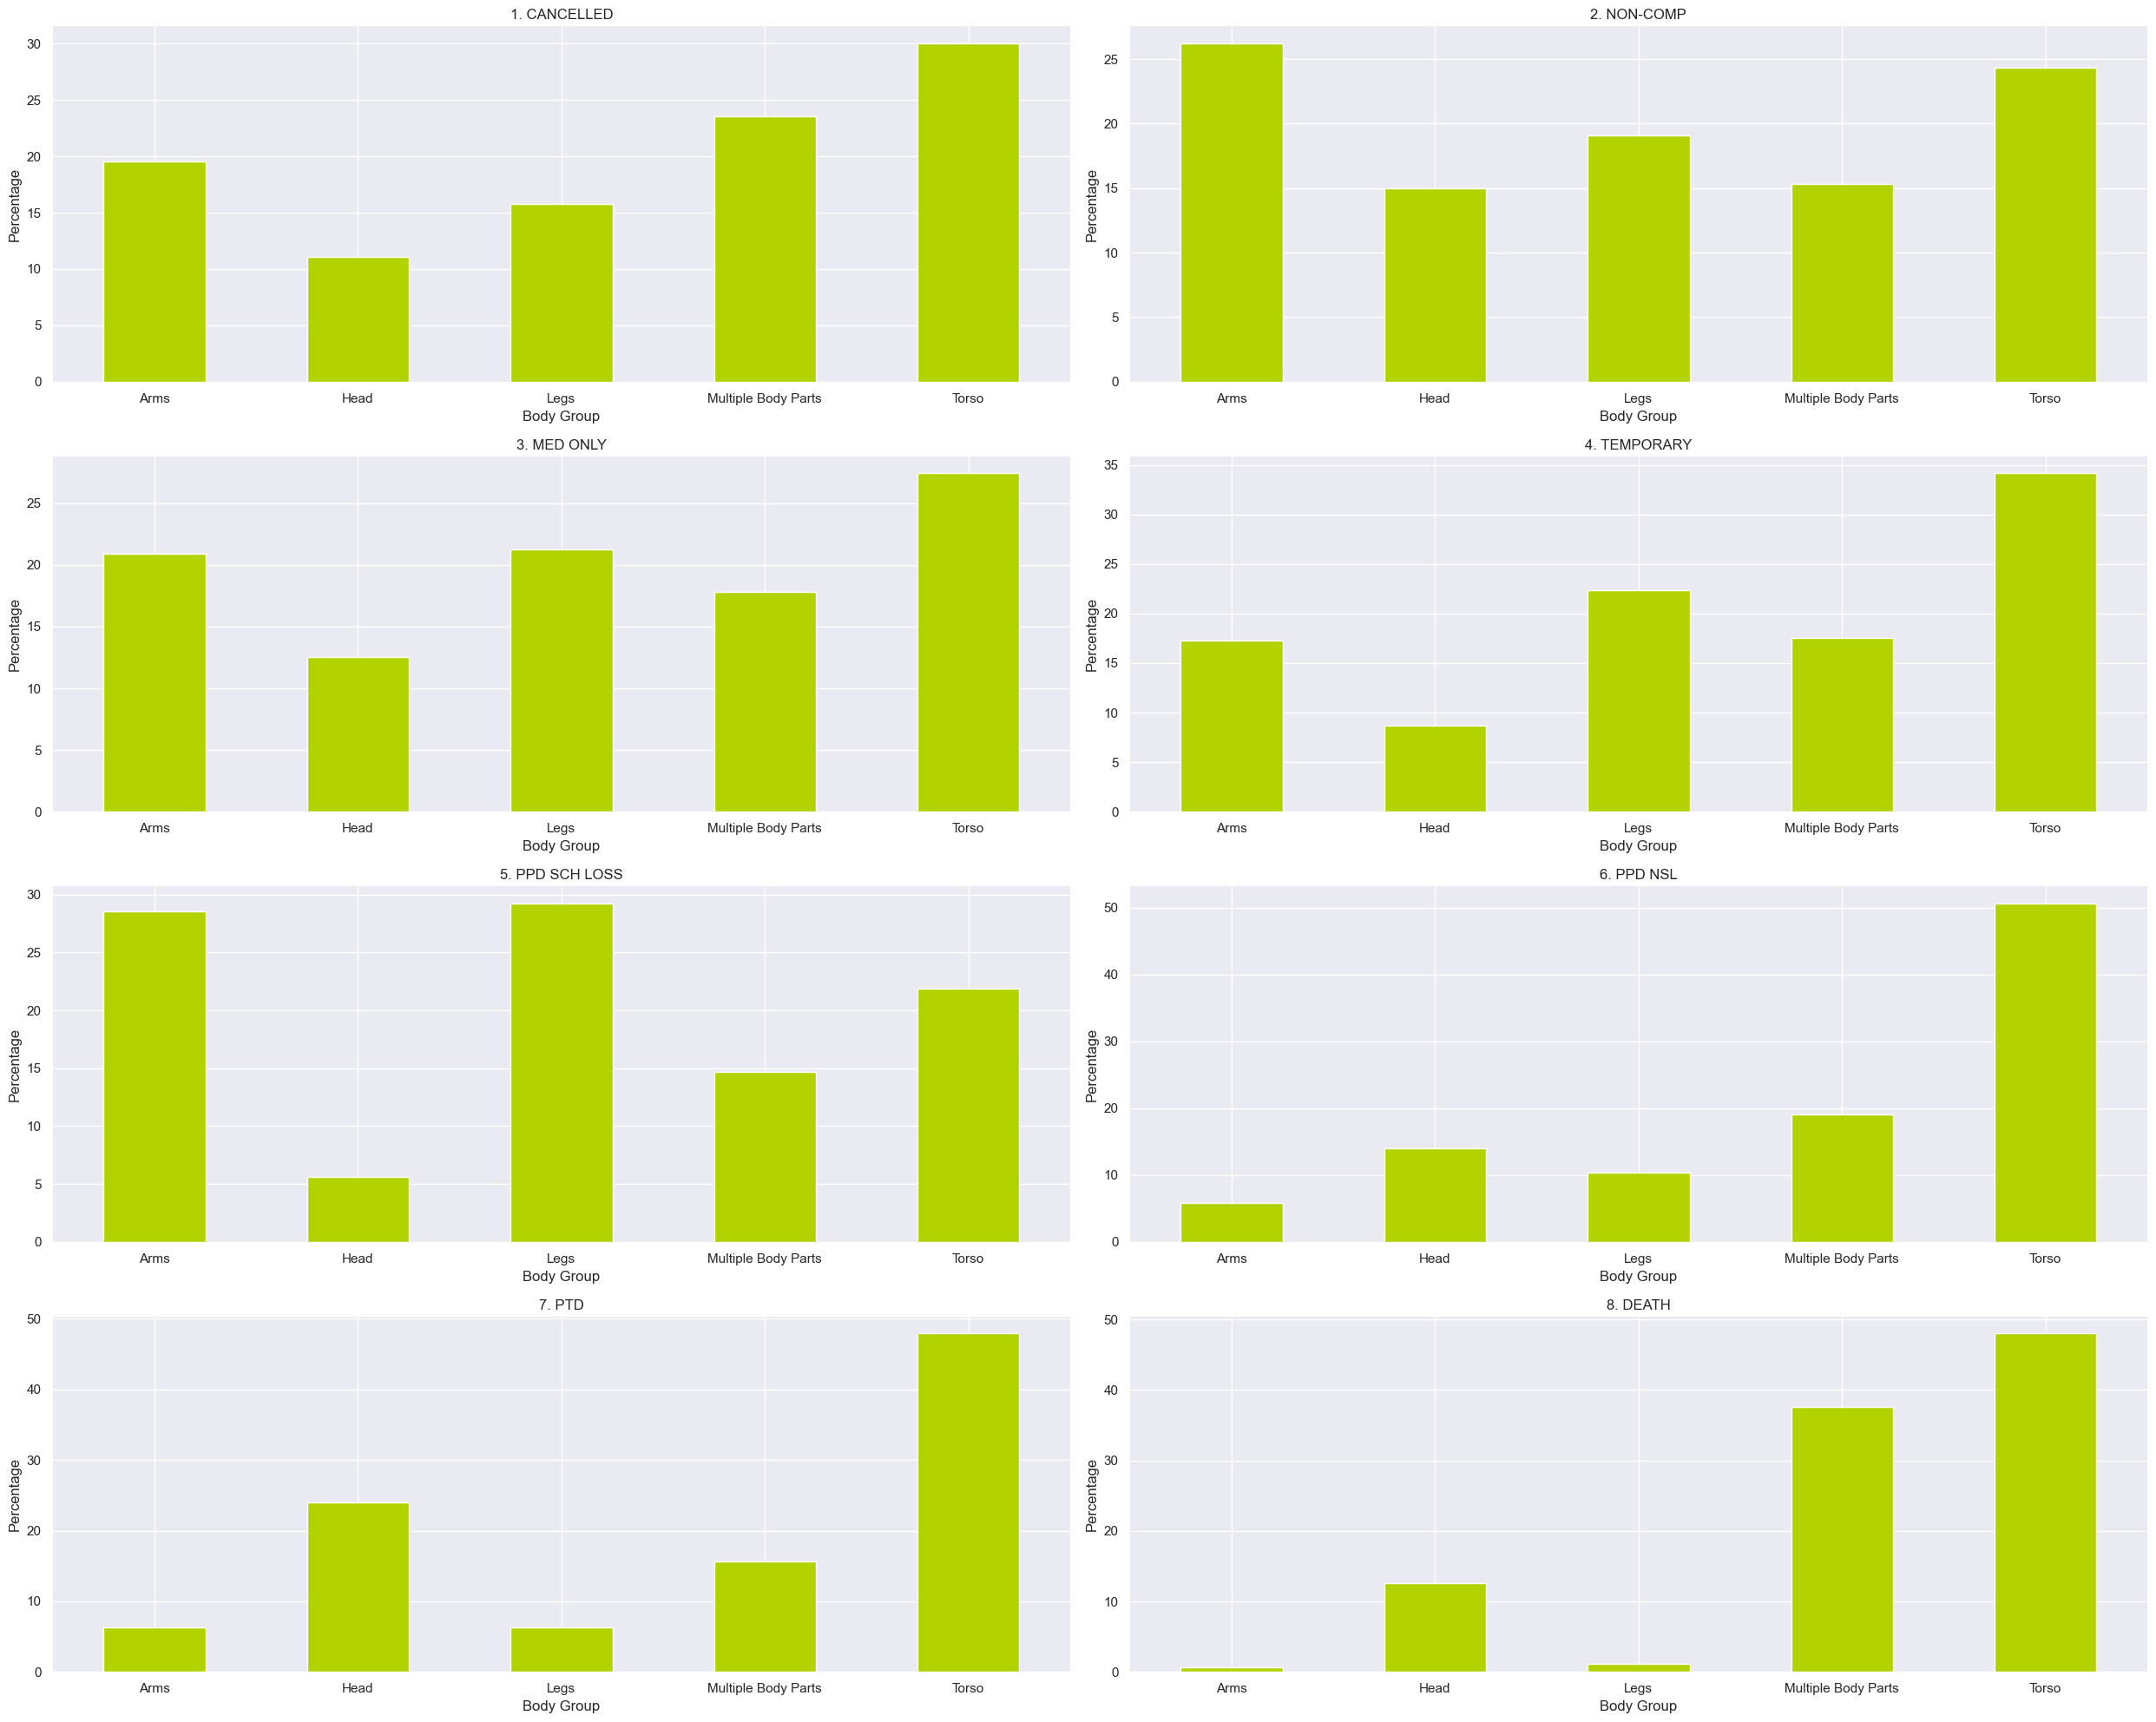

In [93]:
body_group_percentage = df_train.groupby(['Claim Injury Type', 'body_group']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, body_group_percentage.index):
    body_group_percentage.loc[claim_type].plot(kind='bar', ax=ax, color='#B2D300')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_xlabel('Body Group')
    ax.set_ylabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

The 'Other' category grows as the cases get more severe, reaching its peak in the most severe cases. The 'Head' category also shows a slight increase in the 7th and 8th categories.

In [94]:
unique_nature_codes

WCIO Nature of Injury Code  \
0                               10   
1                               49   
2                                7   
4                               43   
6                               40   
7                               71   
8                               59   
11                              37   
12                               4   
13                              52   
21                              28   
36                              25   
52                              90   
65                              46   
94                              16   
131                             80   
148                             34   
157                              3   
176                             78   
191                              1   
210                           <NA>   
236                             36   
272                             13   
359                             53   
395                             42   
481                             65   
486                             31   
589                             77   
660                             47   
840                             19   
1063                            72   
1066                            60   
1202                            68   
1724                            54   
1818                            69   
1821                            73   
1857                             2   
1991                            41   
4040                            66   
4269                            91   
4355                            58   
6197                            55   
6623                            83   
6863                            74   
14269                           32   
14516                           75   
14645                           22   
14820                           61   
14847                           67   
25299                           76   
36872                           30   
51036                           62   
113801                          64   
124046                          38   
142860                          79   
168368                          70   
399339                          63   

                        WCIO Nature of Injury Description  
0                                               CONTUSION  
1                                          SPRAIN OR TEAR  
2                                              CONCUSSION  
4                                                PUNCTURE  
6                                              LACERATION  
7              ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC  
8                        ALL OTHER SPECIFIC INJURIES, NOC  
11                                           INFLAMMATION  
12                                                   BURN  
13                                         STRAIN OR TEAR  
21                                               FRACTURE  
36                                           FOREIGN BODY  
52                        MULTIPLE PHYSICAL INJURIES ONLY  
65                                                RUPTURE  
94                                            DISLOCATION  
131                      ALL OTHER CUMULATIVE INJURY, NOC  
148                                                HERNIA  
157                                       ANGINA PECTORIS  
176                                CARPAL TUNNEL SYNDROME  
191                                    NO PHYSICAL INJURY  
210                                                   NaN  
236                                             INFECTION  
272                                              CRUSHING  
359                                               SYNCOPE  
395             POISONING - GENERAL (NOT OD OR CUMULATIVE  
481                                 RESPIRATORY DISORDERS  
486                            HEARING LOSS OR IMPAIRMENT  
589                                         MENTAL STRESS  
660                                             SEVERANCE  
840

### Injury Nature

The same can be done for the diseases, grouping them will reduce their dimensionality. They are grouped as follows:
- External Physical Trauma (caused by direct impact, injury, or physical force)
- Chronic and Repetitive Stress Injuries (due to repetitive motion or long-term strain)
- Cumulative and Occupational Injuries (work-related conditions or cumulative injuries)
- Infectious Diseases (disease or infection-related injuries)
- Poisoning and Chemical Exposure (injuries related to toxic substances or reactions)
- Cardiovascular and Respiratory Conditions (heart, lung, and vascular system-related)
- Neurological and Sensory Conditions (affecting the nervous system, vision, or hearing)
- Mental Health and Stress-Related Conditions (psychological or emotional conditions)
- Other (Multiple injuries and special/rare conditions combined)

Again, this needs to be done manually and in the case of some injuries, research was necessary.

In [95]:
physical_trauma = ["CONTUSION", "SPRAIN OR TEAR", "CONCUSSION", "PUNCTURE", "LACERATION", "BURN", 
                   "STRAIN OR TEAR", "FRACTURE", "FOREIGN BODY", "RUPTURE", "DISLOCATION", "CRUSHING", 
                   "SEVERANCE", "ELECTRIC SHOCK", "AMPUTATION"]

repetitive_stress_injuries = ["INFLAMMATION", "CARPAL TUNNEL SYNDROME", "HERNIA", "VDT - RELATED DISEASES"]

cumulative_occupational_injuries = ["ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC", 
                                    "DUST DISEASE, NOC", "ASBESTOSIS", "SILICOSIS", "BLACK LUNG", "BYSSINOSIS", "DERMATITIS"]

infectious_diseases = ["INFECTION", "COVID-19", "CONTAGIOUS DISEASE", "HEPATITIS C", "AIDS"]

poisoning_chemical_exposure = ["POISONING - GENERAL (NOT OD OR CUMULATIVE", "POISONING - CHEMICAL, (OTHER THAN METALS)", "POISONING - METAL", 
                               "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION"]

cardiovascular_respiratory = ["ANGINA PECTORIS", "MYOCARDIAL INFARCTION", "RESPIRATORY DISORDERS", 
                              "VASCULAR", "ASPHYXIATION", "HEAT PROSTRATION"]

neurological_sensory = ["HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "VISION LOSS", "ENUCLEATION", "SYNCOPE"]

mental_health_stress = ["MENTAL STRESS", "MENTAL DISORDER"]

other_injury = ["MULTIPLE PHYSICAL INJURIES ONLY", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", 
         "FREEZING", "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "CANCER", 'NO PHYSICAL INJURY']


In [96]:
df_train['injury_type'] = np.nan
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(physical_trauma), 'injury_type'] = 'Physical Trauma'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(repetitive_stress_injuries), 'injury_type'] = 'Repetitive Stress Injuries'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(cumulative_occupational_injuries), 'injury_type'] = 'Cumulative Occupational Injuries'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(infectious_diseases), 'injury_type'] = 'Infectious Diseases'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(poisoning_chemical_exposure), 'injury_type'] = 'Poisoning/Chemical Exposure'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(cardiovascular_respiratory), 'injury_type'] = 'Cardiovascular/Respiratory'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(neurological_sensory), 'injury_type'] = 'Neurological/Sensory'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(mental_health_stress), 'injury_type'] = 'Mental Health/Stress'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(other_injury), 'injury_type'] = 'Other'

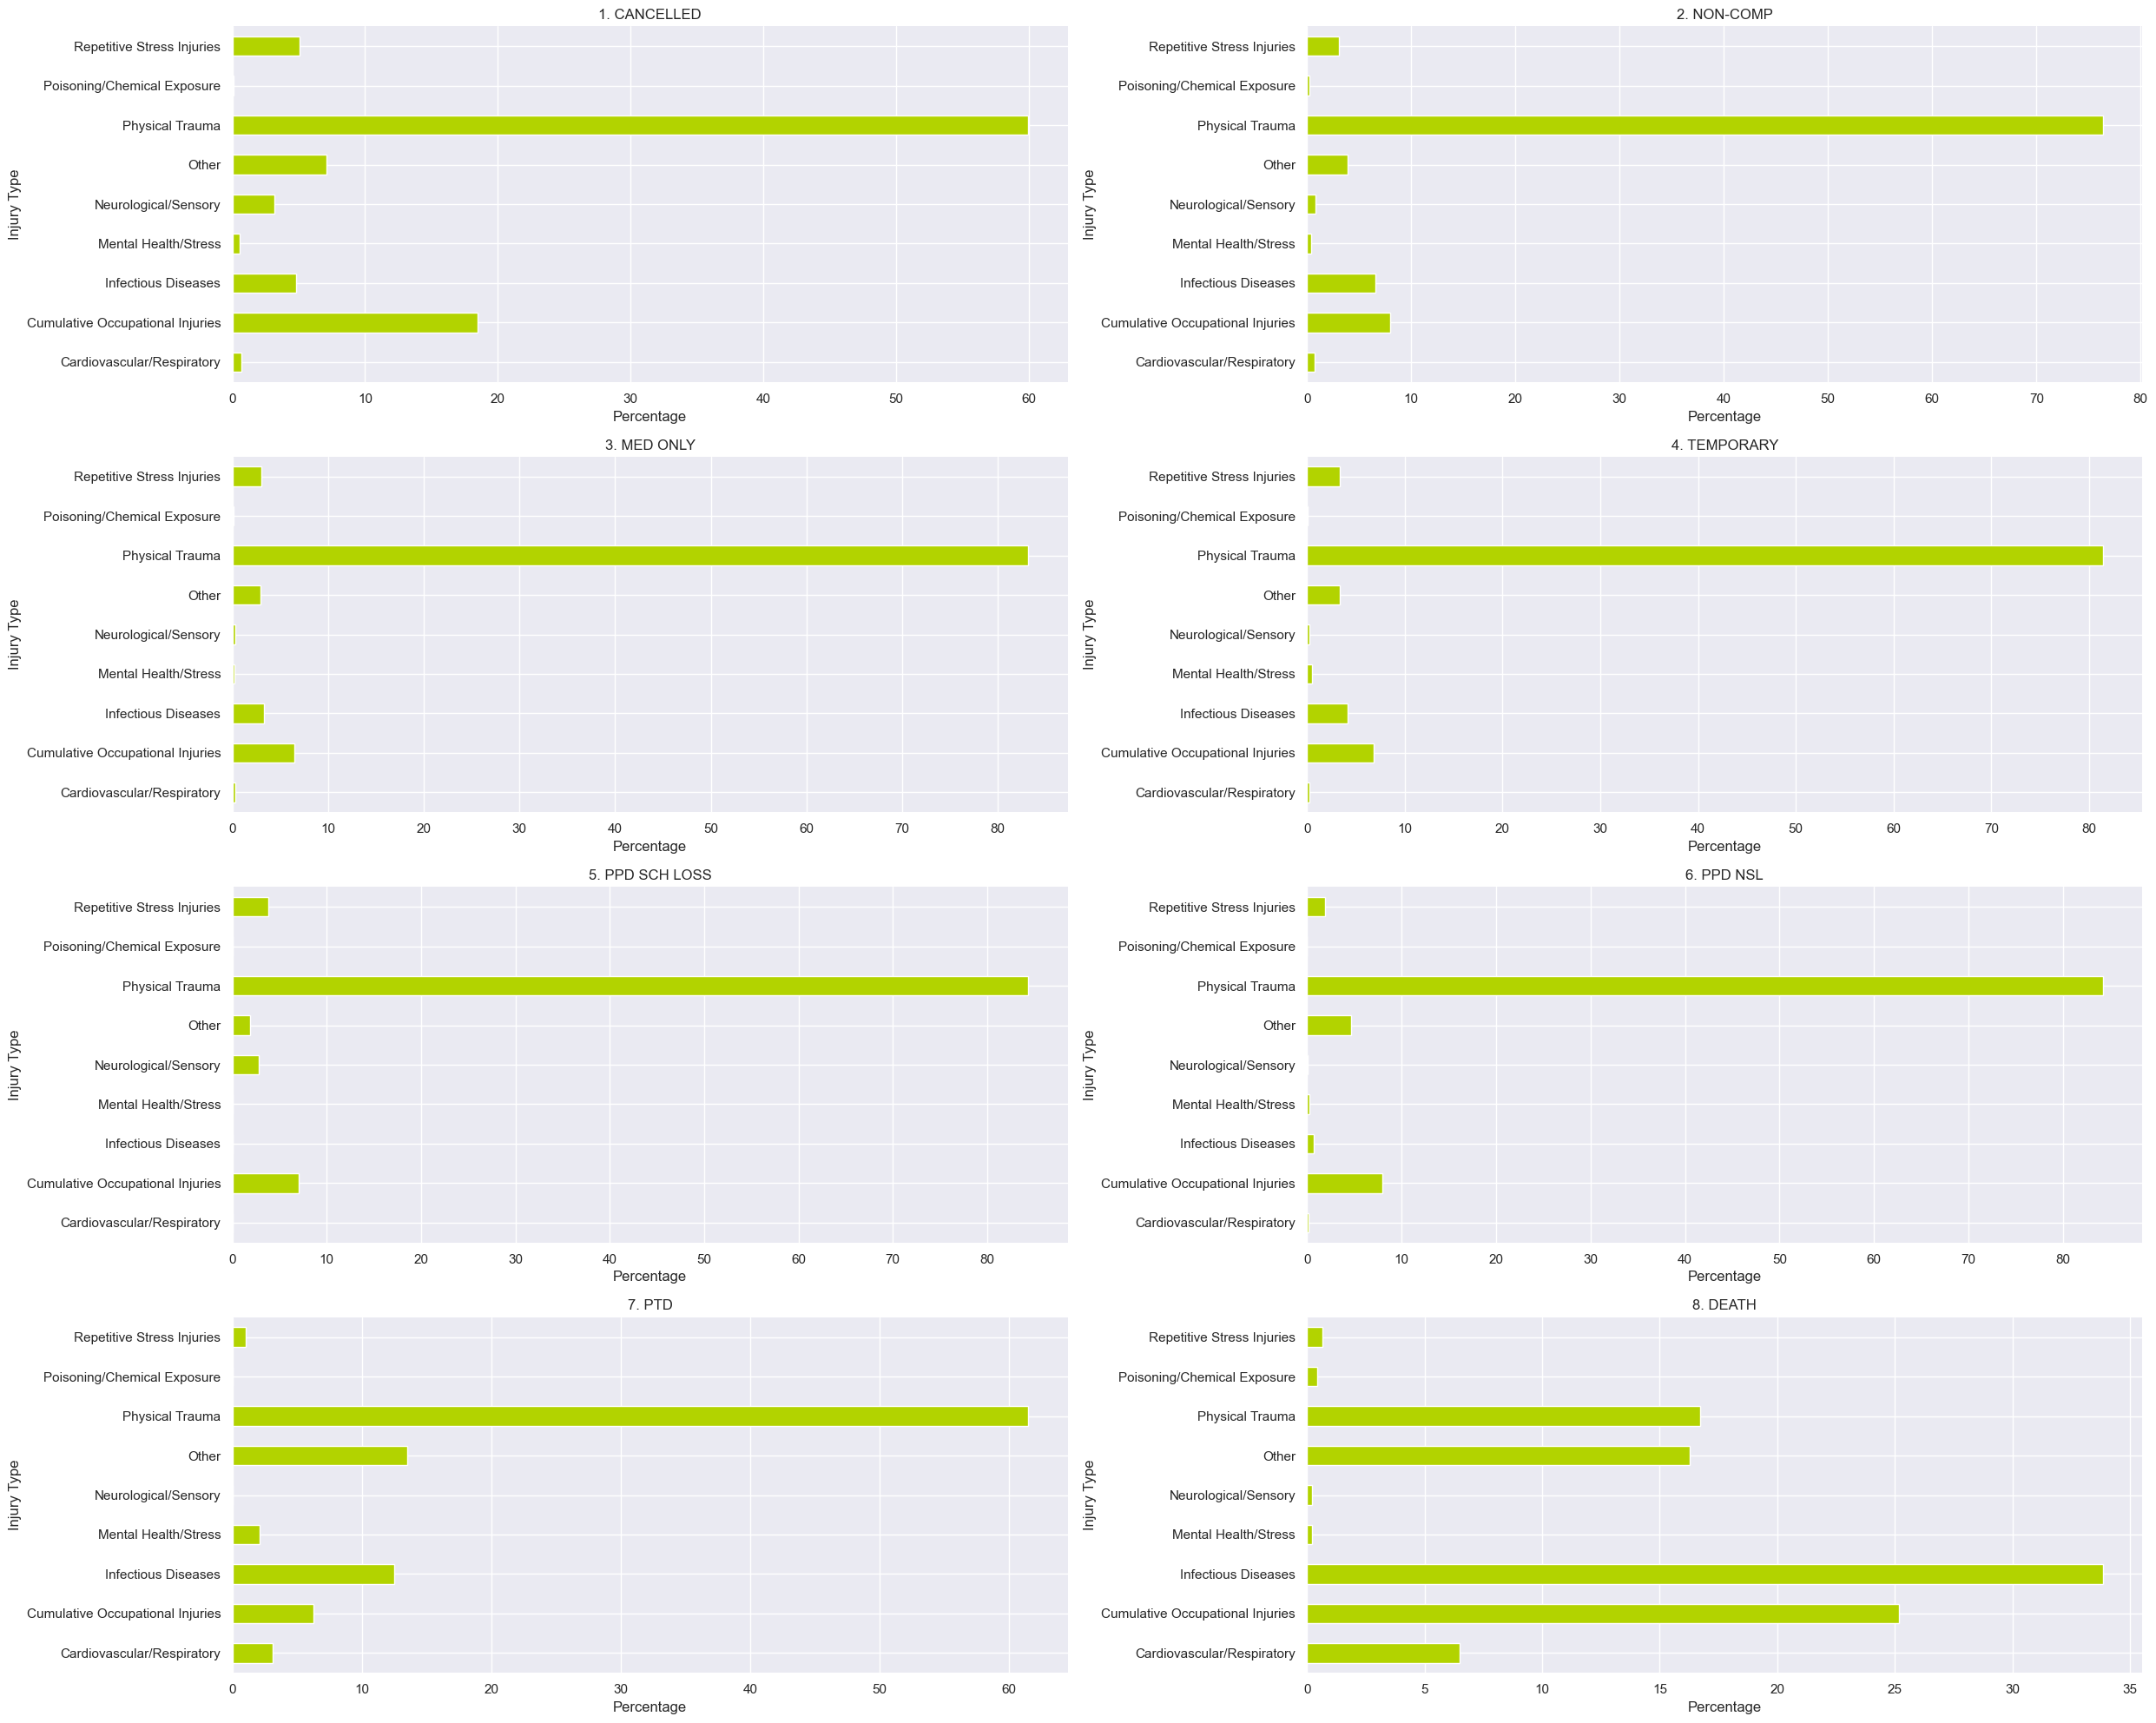

In [97]:
injury_group_percentage = df_train.groupby(['Claim Injury Type', 'injury_type']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, injury_group_percentage.index):
    injury_group_percentage.loc[claim_type].plot(kind='barh', ax=ax, color='#B2D300')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_ylabel('Injury Type')
    ax.set_xlabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

This graph, like some of the graphs showed before, changes the most in cases where death is involved. Other types of cases are not so easily separated by these codes, as the increaases and decreases are only minor.

In [98]:
for i in unique_cause_codes['WCIO Cause of Injury Description']:
    print(i)

FROM LIQUID OR GREASE SPILLS
REPETITIVE MOTION
OBJECT BEING LIFTED OR HANDLED
HAND TOOL, UTENSIL; NOT POWERED
FALL, SLIP OR TRIP, NOC
CUT, PUNCTURE, SCRAPE, NOC
OTHER - MISCELLANEOUS, NOC
STRUCK OR INJURED, NOC
FALLING OR FLYING OBJECT
CHEMICALS
COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE
LIFTING
TWISTING
ON SAME LEVEL
STRAIN OR INJURY BY, NOC
MOTOR VEHICLE, NOC
FROM DIFFERENT LEVEL (ELEVATION)
PUSHING OR PULLING
FOREIGN MATTER (BODY) IN EYE(S)
FELLOW WORKER, PATIENT OR OTHER PERSON
STEAM OR HOT FLUIDS
STATIONARY OBJECT
ON ICE OR SNOW
ABSORPTION, INGESTION OR INHALATION, NOC
PERSON IN ACT OF A CRIME
OBJECT BEING LIFTED OR HANDLED
INTO OPENINGS
ON STAIRS
FROM LADDER OR SCAFFOLDING
SLIP, OR TRIP, DID NOT FALL
JUMPING OR LEAPING
OBJECT BEING LIFTED OR HANDLED
MOTOR VEHICLE
RUBBED OR ABRADED, NOC
REACHING
OBJECT HANDLED
HOT OBJECTS OR SUBSTANCES
ELECTRICAL CURRENT
HOLDING OR CARRYING
CAUGHT IN, UNDER OR BETWEEN, NOC
nan
FIRE OR FLAME
CUMULATIVE, NOC
POWERED HAND TOOL, APPLIANCE
STRIKING AG

### Cause of Injury

The causes of accident can also be grouped:
- Slips, Trips, and Falls (related to losing balance or falling)
- Lifting, Carrying, and Handling (injuries related to lifting or handling objects)
- Struck by or Contact with Objects (injuries from being hit or coming into contact with objects)
- Vehicle and Machinery Accidents (related to collisions, crashes, or machine injuries)
- Chemical, Environmental, and Biological Hazards (exposure to harmful substances or environments)
- Manual Tools and Physical Operations (injuries caused by tools or physical operations)
- Repetitive Motion and Strain (injuries from repeated actions or excessive strain)
- Miscellaneous Causes (other causes that don’t fit into the above categories)

Note: 'NOC' means 'Not Otherwise Classified', this code is used for observations that do not fit into a specific classification/category. 'FALL, SLIP OR TRIP, NOC' means it is a fall, slip or trip that does not fit in the categories present in the list such as snow or stairs.

References:<br>
https://workinjuryrights.com/glossary/not-otherwise-classified-noc/

In [99]:
slips_trips_falls = ["FROM LIQUID OR GREASE SPILLS", "FALL, SLIP OR TRIP, NOC", "ON SAME LEVEL", "FROM DIFFERENT LEVEL (ELEVATION)", 
                     "ON ICE OR SNOW", "INTO OPENINGS", "ON STAIRS", "FROM LADDER OR SCAFFOLDING", "SLIP, OR TRIP, DID NOT FALL", 
                     "JUMPING OR LEAPING"]

lifting_carrying_handling = ["OBJECT BEING LIFTED OR HANDLED", "LIFTING", "PUSHING OR PULLING", "HOLDING OR CARRYING", 
                             "OBJECT HANDLED", "OBJECT HANDLED BY OTHERS"]

struck_by_or_contact = ["STRUCK OR INJURED, NOC", "FALLING OR FLYING OBJECT", "STEAM OR HOT FLUIDS", 
                        "STATIONARY OBJECT", "ELECTRICAL CURRENT", "HOT OBJECTS OR SUBSTANCES", 
                        "CAUGHT IN, UNDER OR BETWEEN, NOC", "FIRE OR FLAME", "CONTACT WITH, NOC", 
                        "BROKEN GLASS", "STEPPING ON SHARP OBJECT", "GUNSHOT", "ANIMAL OR INSECT"]

vehicle_machinery_accidents = ["COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE", "MOTOR VEHICLE, NOC", "MOTOR VEHICLE", "VEHICLE UPSET", "COLLISION WITH A FIXED OBJECT", 
                               "CRASH OF RAIL VEHICLE", "CRASH OF WATER VEHICLE", "CRASH OF AIRPLANE", "MOVING PARTS OF MACHINE", "MACHINE OR MACHINERY", "POWERED HAND TOOL, APPLIANCE", 
                               "USING TOOL OR MACHINERY", "MOVING PART OF MACHINE", "HAND TOOL OR MACHINE IN USE"]

chemical_environmental_biological = ["CHEMICALS", "DUST, GASES, FUMES OR VAPORS", "ABSORPTION, INGESTION OR INHALATION, NOC", 
                                     "MOLD", "CUMULATIVE, NOC", "TEMPERATURE EXTREMES", "COLD OBJECTS OR SUBSTANCES", "RADIATION", 
                                     "ABNORMAL AIR PRESSURE"]

manual_tools_operations = ["HAND TOOL, UTENSIL; NOT POWERED", "CUT, PUNCTURE, SCRAPE, NOC", "RUBBED OR ABRADED, NOC", 
                           "SANDING, SCRAPING, CLEANING OPERATION", "WELDING OPERATION", "STRIKING AGAINST OR STEPPING ON, NOC", 
                           "USING TOOL OR MACHINERY"]

repetitive_motion_strain = ["REPETITIVE MOTION", "REACHING", "TWISTING", "STRAIN OR INJURY BY, NOC"]

other_cause = ["OTHER - MISCELLANEOUS, NOC", "FELLOW WORKER, PATIENT OR OTHER PERSON", "FOREIGN MATTER (BODY) IN EYE(S)",
                "OTHER THAN PHYSICAL CAUSE OF INJURY", "PANDEMIC", "TERRORISM", "NATURAL DISASTERS", "EXPLOSION OR FLARE BACK", 
                "COLLAPSING MATERIALS (SLIDES OF EARTH)", "CONTINUAL NOISE", "WIELDING OR THROWING", "PERSON IN ACT OF A CRIME"]

In [100]:
df_train['injury_cause'] = np.nan
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(slips_trips_falls), 'injury_cause'] = 'Slips, Trips, and Falls'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(lifting_carrying_handling), 'injury_cause'] = 'Lifting, Carrying, and Handling'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(struck_by_or_contact), 'injury_cause'] = 'Struck by or Contact with Objects'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(vehicle_machinery_accidents), 'injury_cause'] = 'Vehicle and Machinery Accidents'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(chemical_environmental_biological), 'injury_cause'] = 'Chemical, Environmental, and Biological Hazards'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(manual_tools_operations), 'injury_cause'] = 'Manual Tools and Physical Operations'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(repetitive_motion_strain), 'injury_cause'] = 'Repetitive Motion and Strain'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(other_cause), 'injury_cause'] = 'Other'


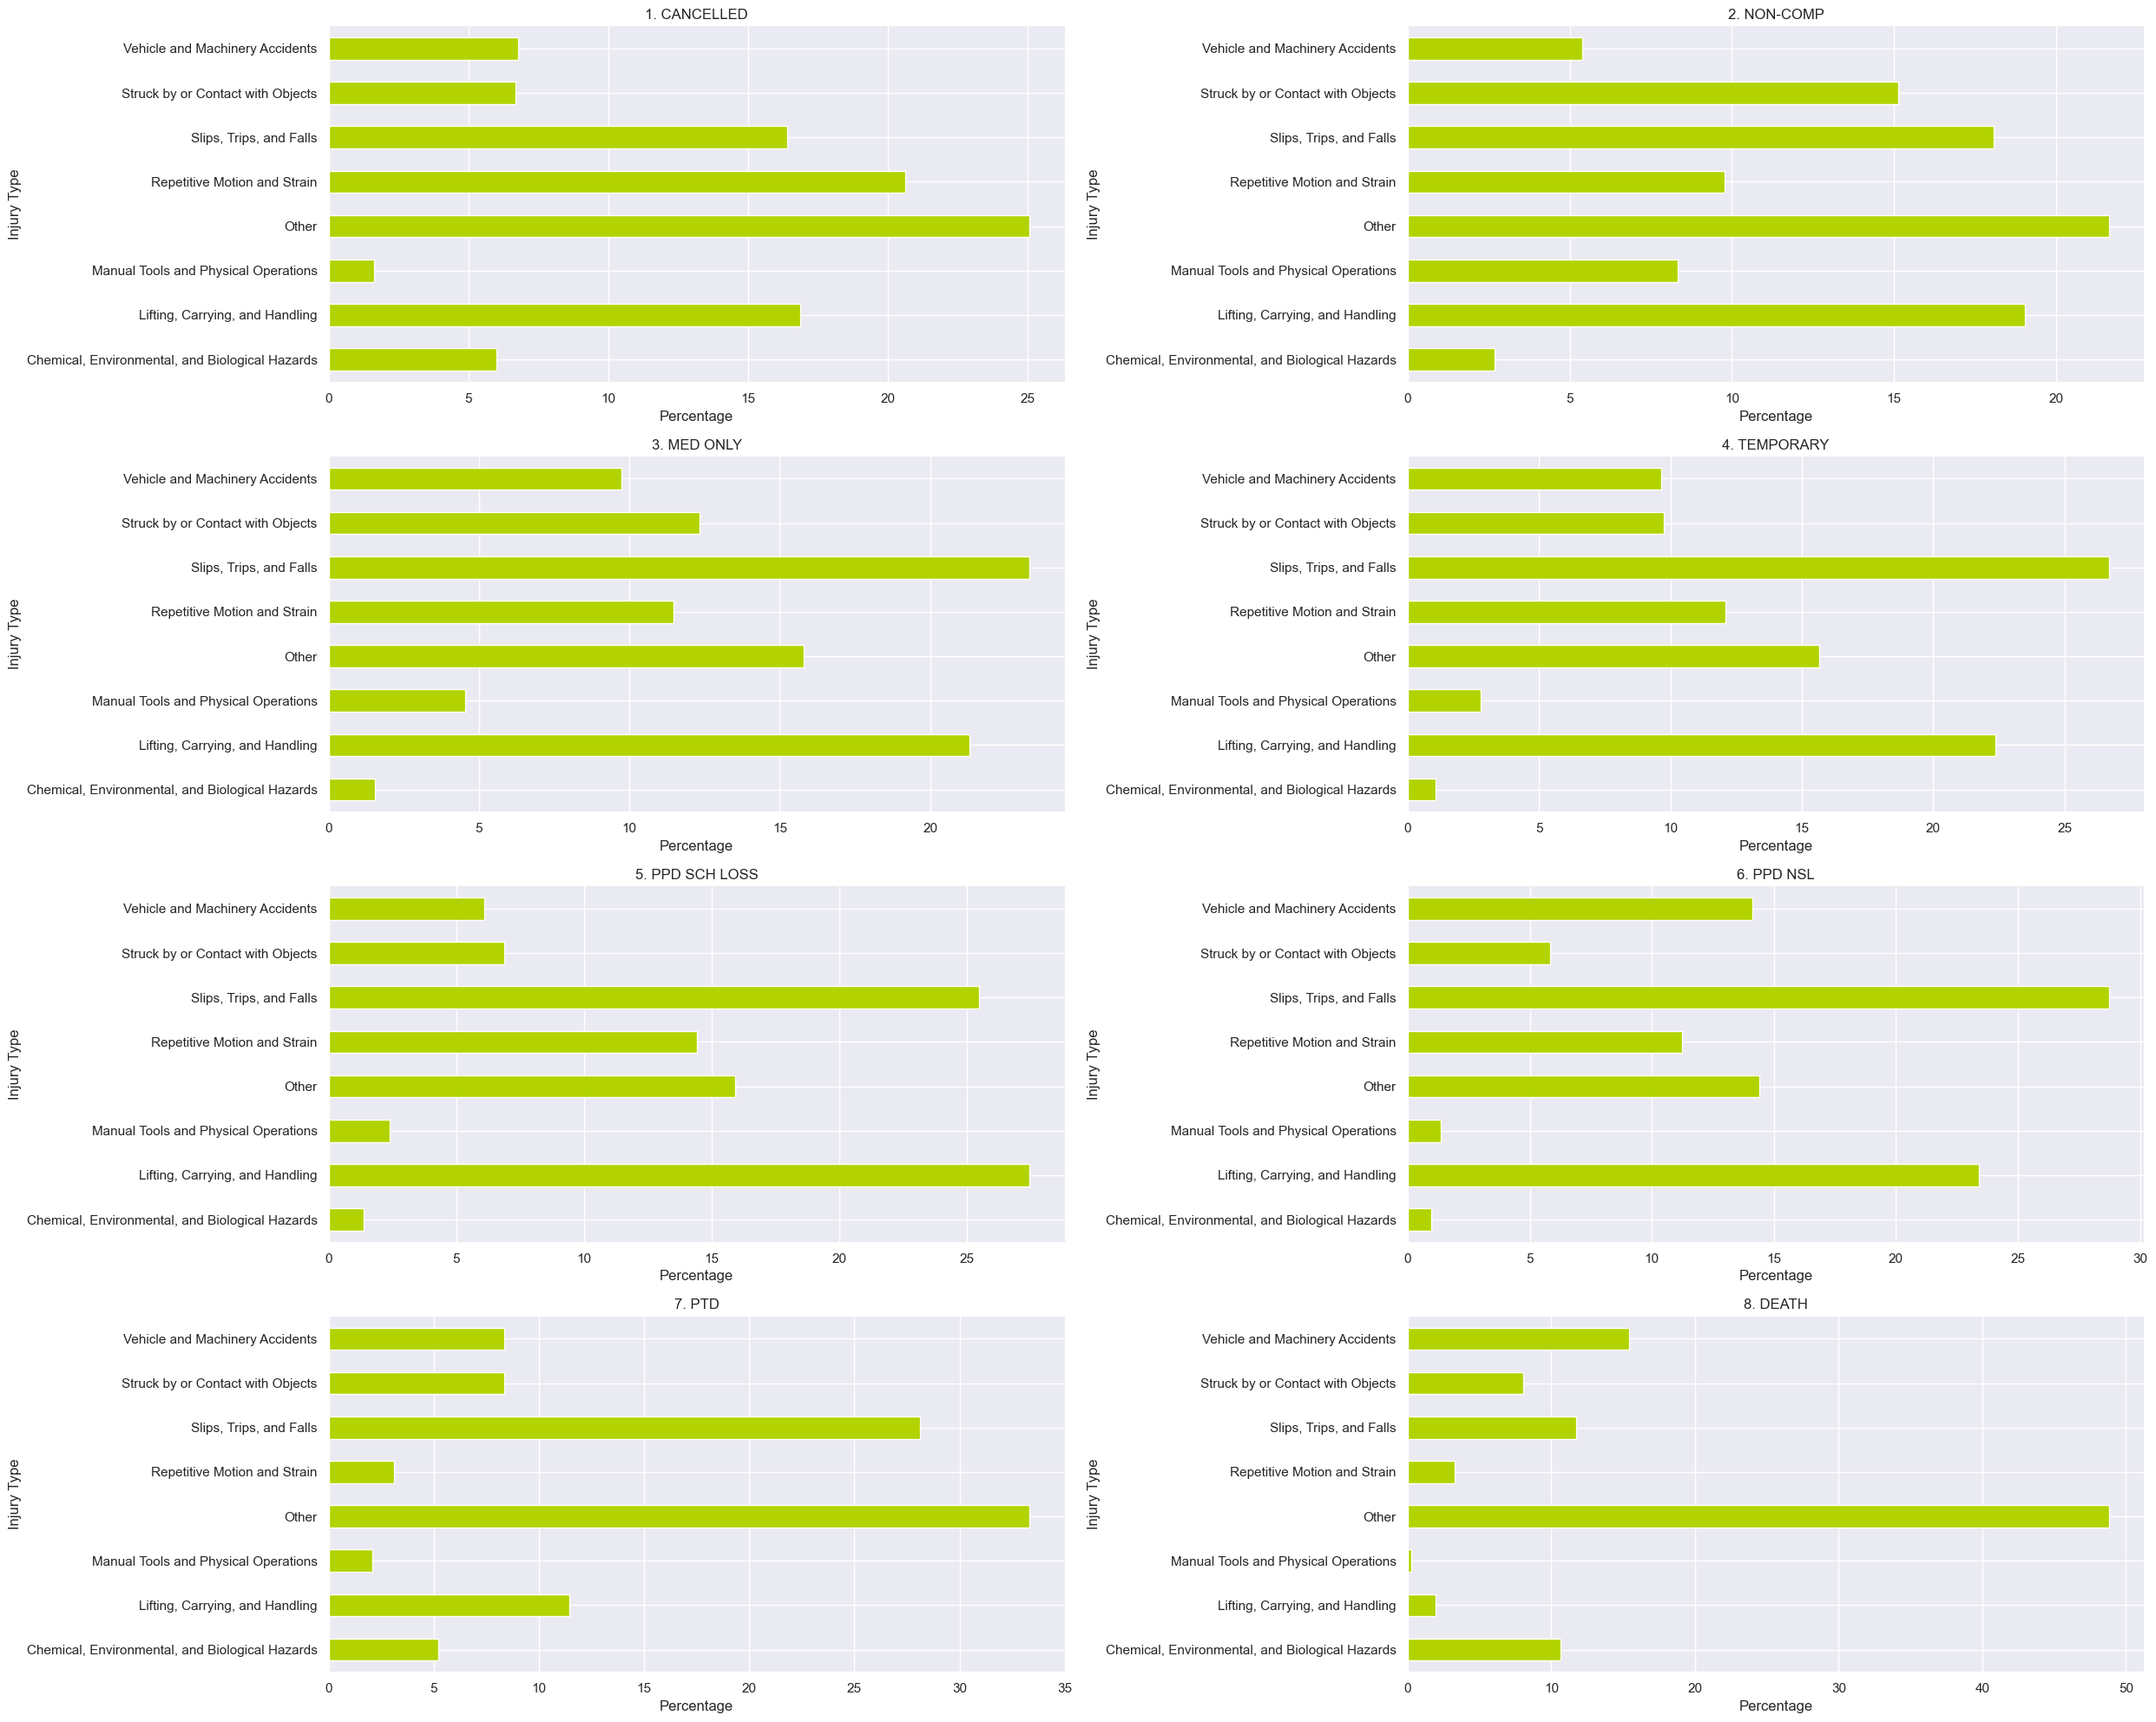

In [101]:
cause_group_percentage = df_train.groupby(['Claim Injury Type', 'injury_cause']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, cause_group_percentage.index):
    cause_group_percentage.loc[claim_type].plot(kind='barh', ax=ax, color='#B2D300')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_ylabel('Injury Type')
    ax.set_xlabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

Unlike in the other bar charts, the causes for the accidents seem to be a differenciating factor. As always, this could be due to the fact that as cases get more severe the number of cases dwindles and so a small amount of cases caused by "repetitive motion or strain" can account for a large portion of the cases in a category.

### Industry Codes

Industry codes can be categorized into five main groups:

- Natural Resources and Utilities
- Goods Production and Trade
- Services
- Education Health Public Services
- Leisure Hospitality

Like before, this selection is done manually.

In [102]:
unique_industry_codes = df_train[['Industry Code', 'Industry Code Description']].drop_duplicates()

In [103]:
unique_industry_codes

Industry Code                          Industry Code Description
0                44                                       RETAIL TRADE
1                23                                       CONSTRUCTION
2                56  ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...
4                62                  HEALTH CARE AND SOCIAL ASSISTANCE
6                72                    ACCOMMODATION AND FOOD SERVICES
8                61                               EDUCATIONAL SERVICES
11               51                                        INFORMATION
16               31                                      MANUFACTURING
17               48                     TRANSPORTATION AND WAREHOUSING
18               45                                       RETAIL TRADE
24               42                                    WHOLESALE TRADE
26               53                 REAL ESTATE AND RENTAL AND LEASING
28               52                              FINANCE AND INSURANCE
31               49                     TRANSPORTATION AND WAREHOUSING
38               81      OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)
61               92                              PUBLIC ADMINISTRATION
65               33                                      MANUFACTURING
80               54   PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES
149              32                                      MANUFACTURING
190              71                ARTS, ENTERTAINMENT, AND RECREATION
218            <NA>                                                NaN
283              22                                          UTILITIES
414              11         AGRICULTURE, FORESTRY, FISHING AND HUNTING
629              21                                             MINING
1222             55            MANAGEMENT OF COMPANIES AND ENTERPRISES

In [104]:
natural_resources_utilities = ["AGRICULTURE, FORESTRY, FISHING AND HUNTING", "MINING", "UTILITIES"]

goods_production_and_trade = ["CONSTRUCTION", "MANUFACTURING", "WHOLESALE TRADE", "RETAIL TRADE"]

services = ["TRANSPORTATION AND WAREHOUSING", "INFORMATION", "FINANCE AND INSURANCE", "REAL ESTATE AND RENTAL AND LEASING", 
    "PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES", "MANAGEMENT OF COMPANIES AND ENTERPRISES",
    "OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)", "ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT"]

education_health_public_services = ["EDUCATIONAL SERVICES", "HEALTH CARE AND SOCIAL ASSISTANCE", "PUBLIC ADMINISTRATION"]

leisure_hospitality = ["ARTS, ENTERTAINMENT, AND RECREATION", "ACCOMMODATION AND FOOD SERVICES"]

In [105]:
df_train['industry_group'] = np.nan
df_train.loc[df_train['Industry Code Description'].isin(natural_resources_utilities), 'industry_group'] = 'Natural Resources and Utilities'
df_train.loc[df_train['Industry Code Description'].isin(goods_production_and_trade), 'industry_group'] = 'Goods Production and Trade'
df_train.loc[df_train['Industry Code Description'].isin(services), 'industry_group'] = 'Services'
df_train.loc[df_train['Industry Code Description'].isin(education_health_public_services), 'industry_group'] = 'Education Health and Public Services'
df_train.loc[df_train['Industry Code Description'].isin(leisure_hospitality), 'industry_group'] = 'Leisure Hospitality'

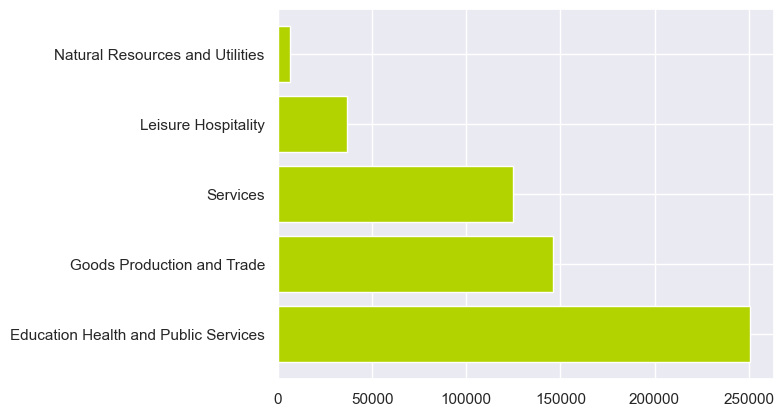

In [106]:
df_train['industry_group'].value_counts()
plt.barh(df_train['industry_group'].value_counts().index, df_train['industry_group'].value_counts().values, color='#B2D300')
plt.show()

Most of the cases belong to the education, health and public services, with almost double the number of cases of the second most frequent industry group.

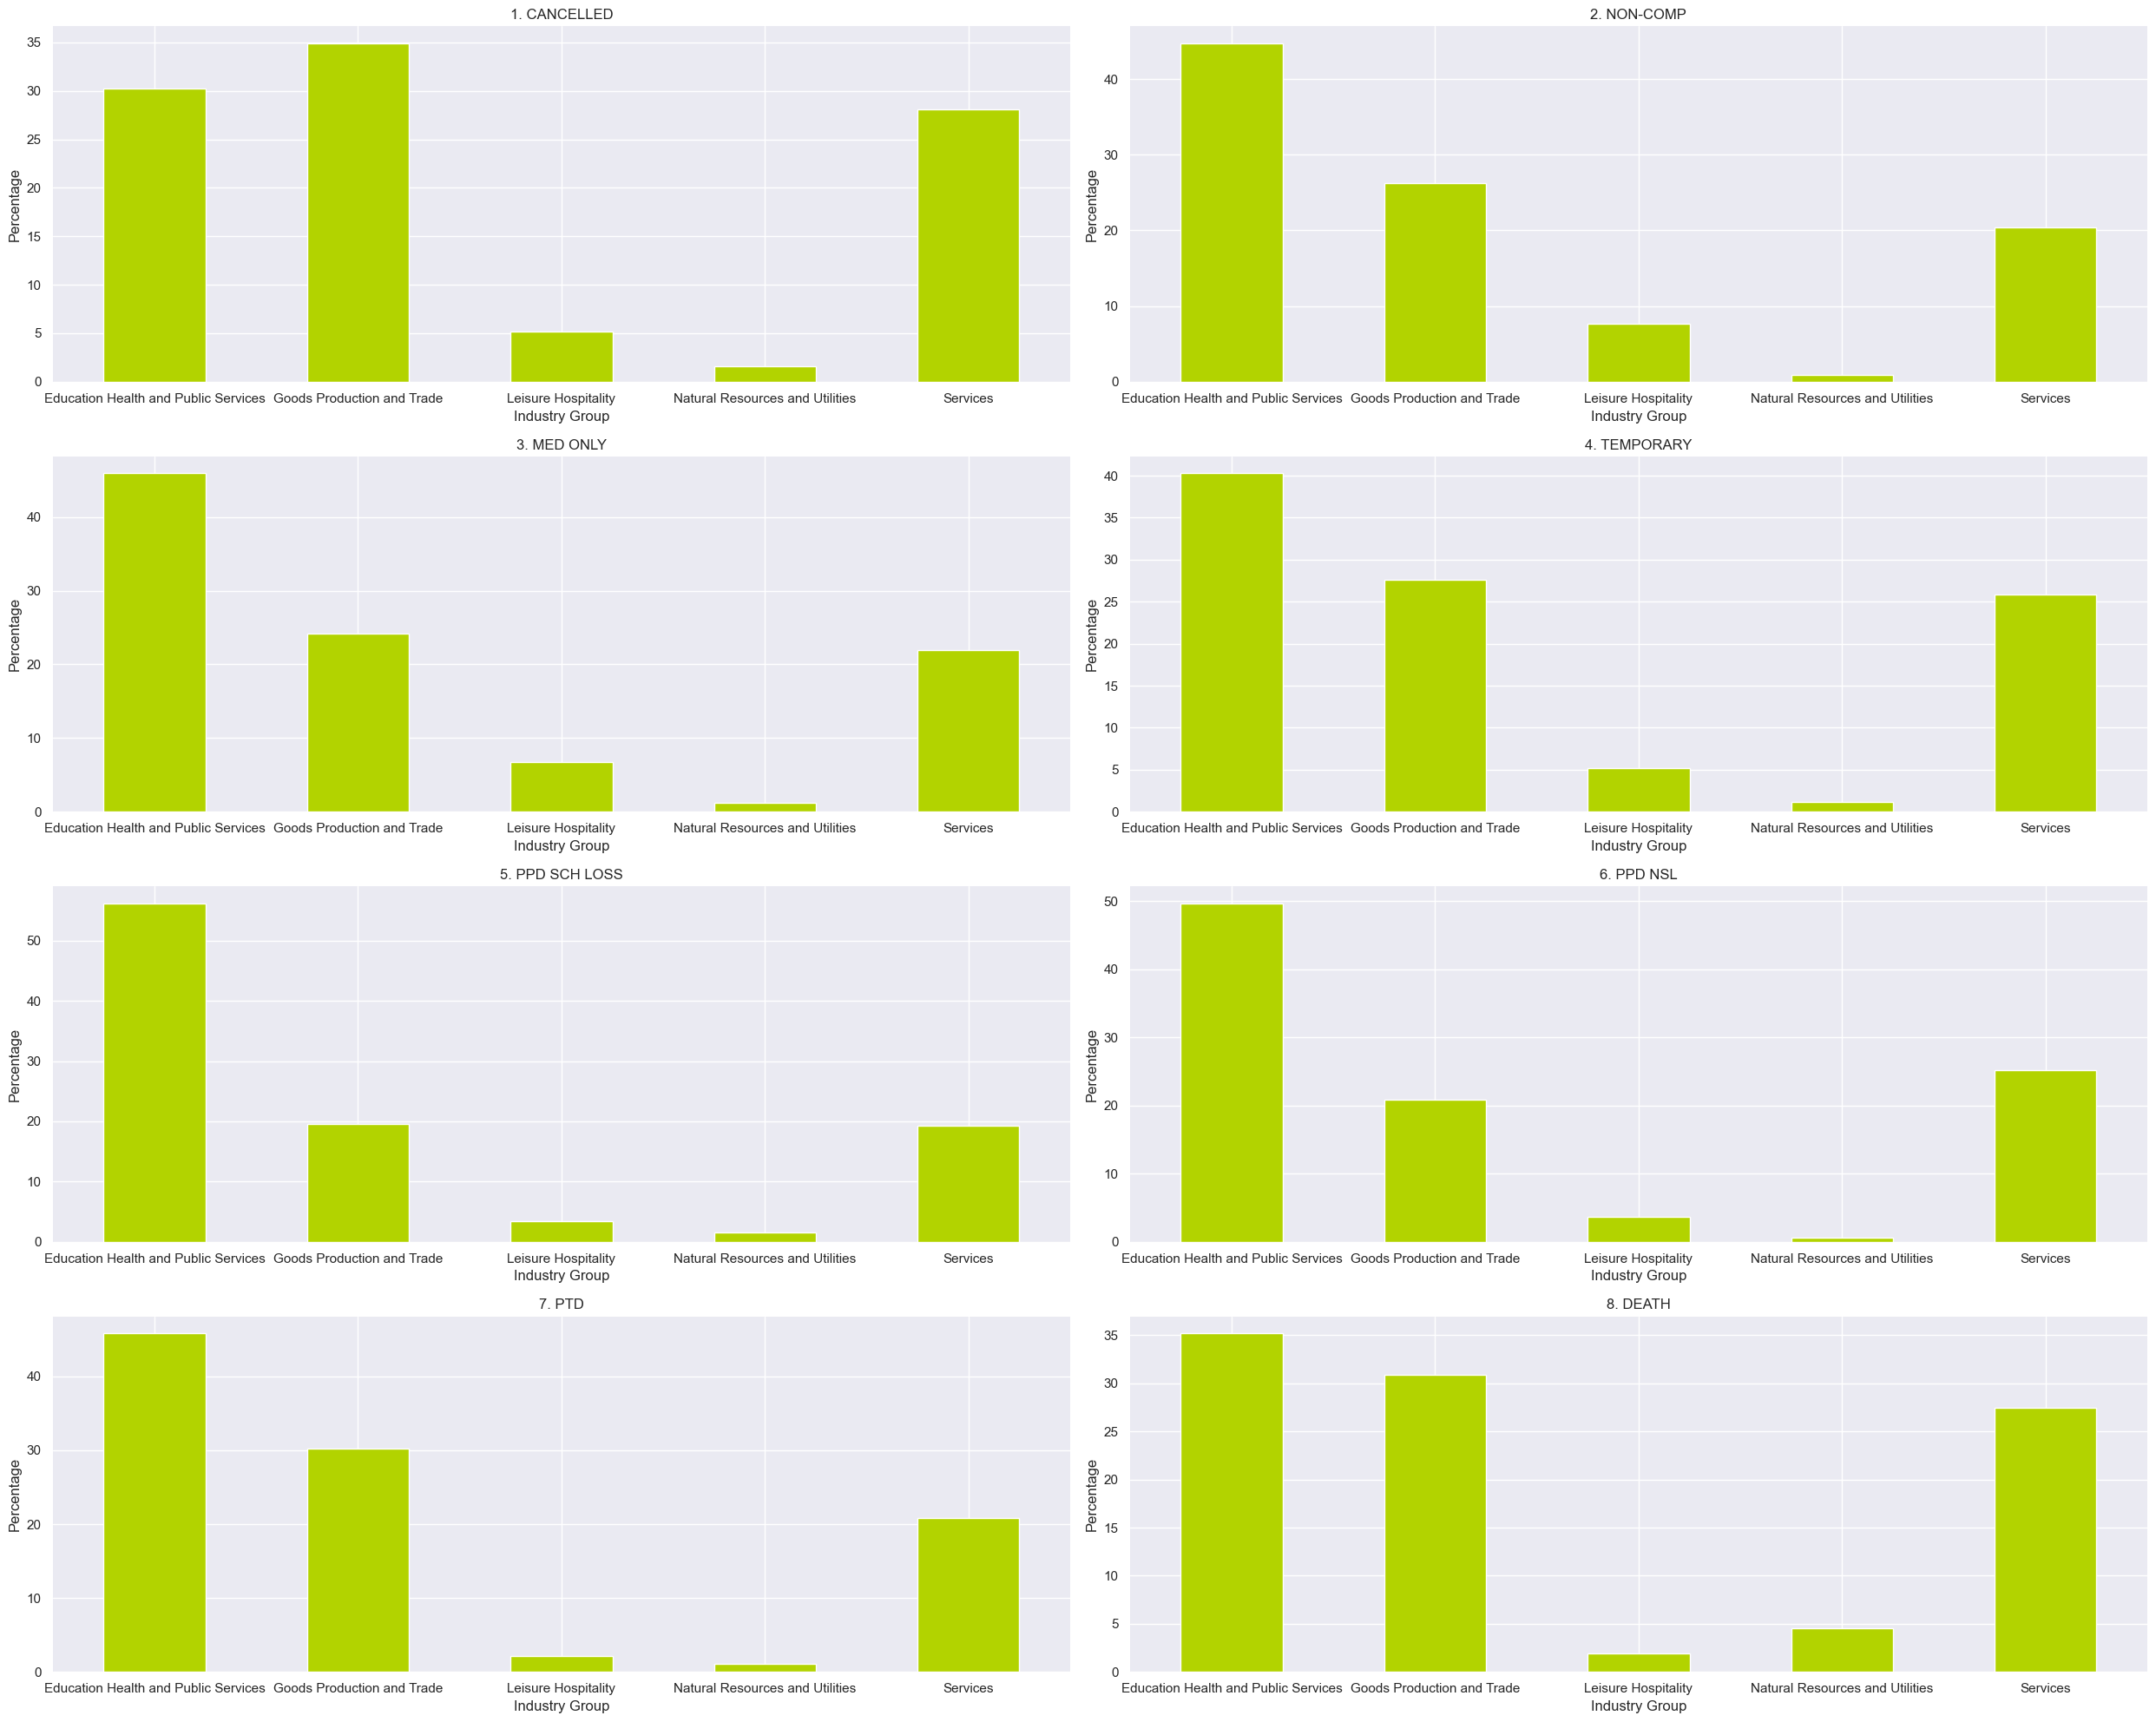

In [107]:
industry_group_percentage = df_train.groupby(['Claim Injury Type', 'industry_group']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, industry_group_percentage.index):
    industry_group_percentage.loc[claim_type].plot(kind='bar', ax=ax, color='#B2D300')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_xlabel('Industry Group')
    ax.set_ylabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

'Education Health and Public Services' takes the lead in every category, except for one. For canceled cases, the most represented industry is 'Goods Production and Trade' (by around 5%). The least represented industry is 'Natural Resources and Utilities'. This industry, like other minority code groups ('head' in the body_groups, 'Infecteous Diseases' in the nature group), reaches its peak in the most severe accidents.

## Agreement Reached

For the open-ended segment of the project, the group chose to predict an additional variable: Agreement Reached.

This variable indicates whether an agreement was reached between the parties involved before the intervention of the Workers' Compensation Board.

Exploring the relationships between 'Agreement Reached' and other variables can uncover information about the conditions that favor agreements before Workers' Compensation Board intervention.

First, the distribution of the Agreement Reached will be examined to see how this variable behaves in this data set.

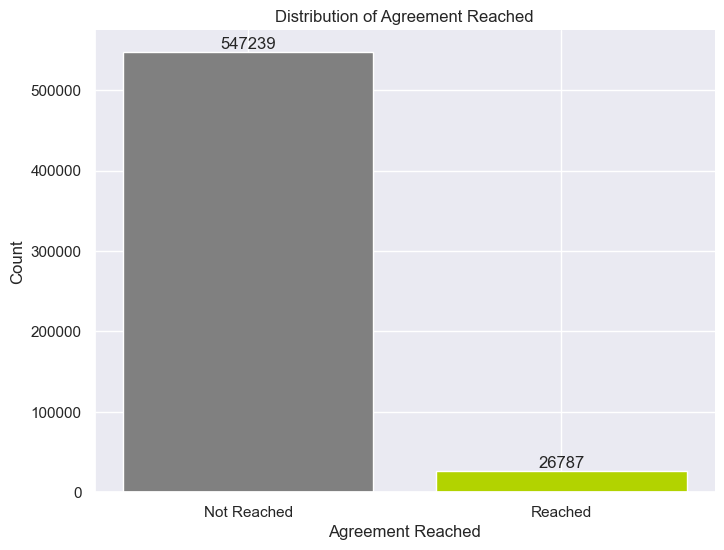

In [108]:
agreement_reached_counts = df_train['Agreement Reached'].value_counts()
plt.figure(figsize=(8, 6)) 
plt.bar(agreement_reached_counts.index, agreement_reached_counts.values, color=['grey','#B2D300'])
plt.xticks(ticks=[0, 1], labels=['Not Reached', 'Reached'])
plt.xlabel('Agreement Reached')
plt.ylabel('Count')
plt.title('Distribution of Agreement Reached')
plt.grid(True)

for index, value in enumerate(agreement_reached_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

The variable is unbalanced. This is something to take into account as it poses a challenge for prediction.

Moving forward, for now, it is essential to analyze the relationships between "Agreement Reached" and other variables in the dataset to determine its relevance for prediction.

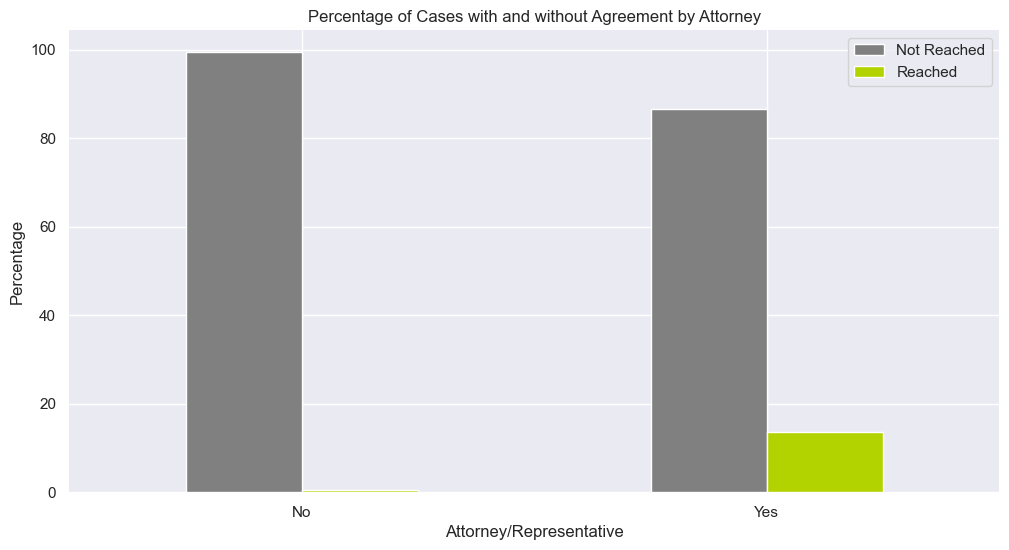

In [109]:
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].replace({'N': 'No', 'Y': 'Yes'})
agreement_by_attorney = pd.crosstab(df_train['Attorney/Representative'], df_train['Agreement Reached'])
agreement_by_attorney.columns = ['Not Reached', 'Reached']
agreement_by_attorney['Reached'] = (agreement_by_attorney['Reached'] / (agreement_by_attorney['Not Reached'] + agreement_by_attorney['Reached'])) * 100
agreement_by_attorney['Not Reached'] = 100 - agreement_by_attorney['Reached']
agreement_by_attorney.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Attorney/Representative')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Attorney')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

From this graph, it is possible to understand that the presence of an attorney influences the likelihood of reaching an agreement. Even though there are way more cases where it was not reached, there is still a big increase in the number of cases in which it is possible to reach an agreement, when an attorney is present.

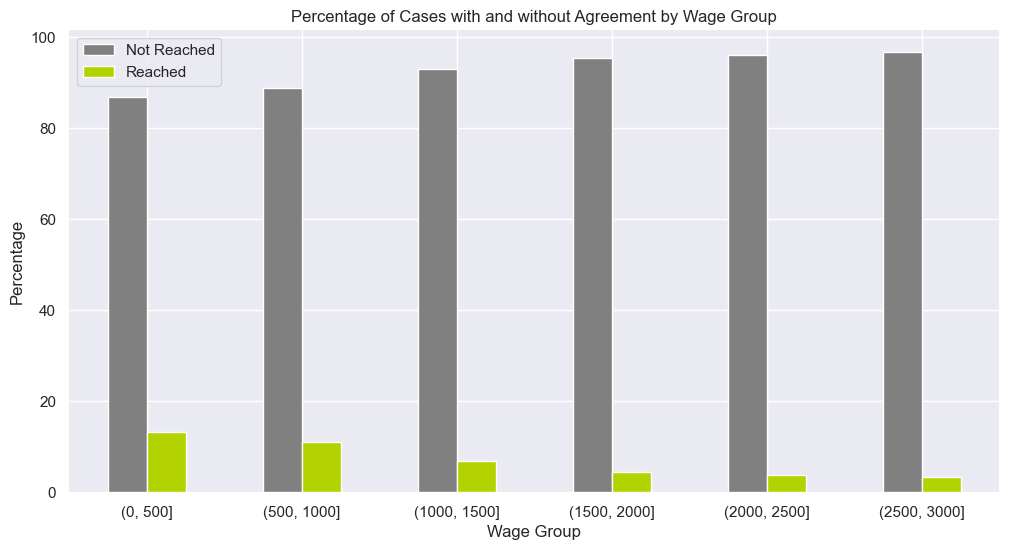

In [110]:
agreement_by_wage = pd.crosstab(df_train1['wage_groups'], df_train['Agreement Reached'])
agreement_by_wage.columns = ['Not Reached', 'Reached']
agreement_by_wage['Reached'] = (agreement_by_wage['Reached'] / (agreement_by_wage['Not Reached'] + agreement_by_wage['Reached'])) * 100
agreement_by_wage['Not Reached'] = 100 - agreement_by_wage['Reached']
agreement_by_wage.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Wage Group')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Wage Group')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Cases in lower wage groups have a higher percentage of agreements reached compared to those in higher wage groups. Additionally, as the level of wage increases, the percentage of agreement not being reached also increases.

In [111]:
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].replace({'N': 'No', 'Y': 'Yes'})
agreement_by_covid = pd.crosstab(df_train['COVID-19 Indicator'], df_train['Agreement Reached'])
agreement_by_covid.columns = ['Not Reached', 'Reached']

agreement_by_covid['Reached'] = (agreement_by_covid['Reached'] / (agreement_by_covid['Not Reached'] + agreement_by_covid['Reached'])) * 100
agreement_by_covid['Not Reached'] = 100 - agreement_by_covid['Reached']

agreement_covid_table = agreement_by_covid[['Reached', 'Not Reached']].copy()
agreement_covid_table.index.name = 'COVID-19 Indicator'
agreement_covid_table.columns = ['Agreement Reached (%)', 'Agreement Not Reached (%)'] 
pd.DataFrame(agreement_covid_table)

Agreement Reached (%)  Agreement Not Reached (%)
COVID-19 Indicator                                                  
No                               4.807092                  95.192908
Yes                              1.874932                  98.125068

The table indicates that when the claim is not related to COVID-19, the percentage of cases reaching an agreement is higher.

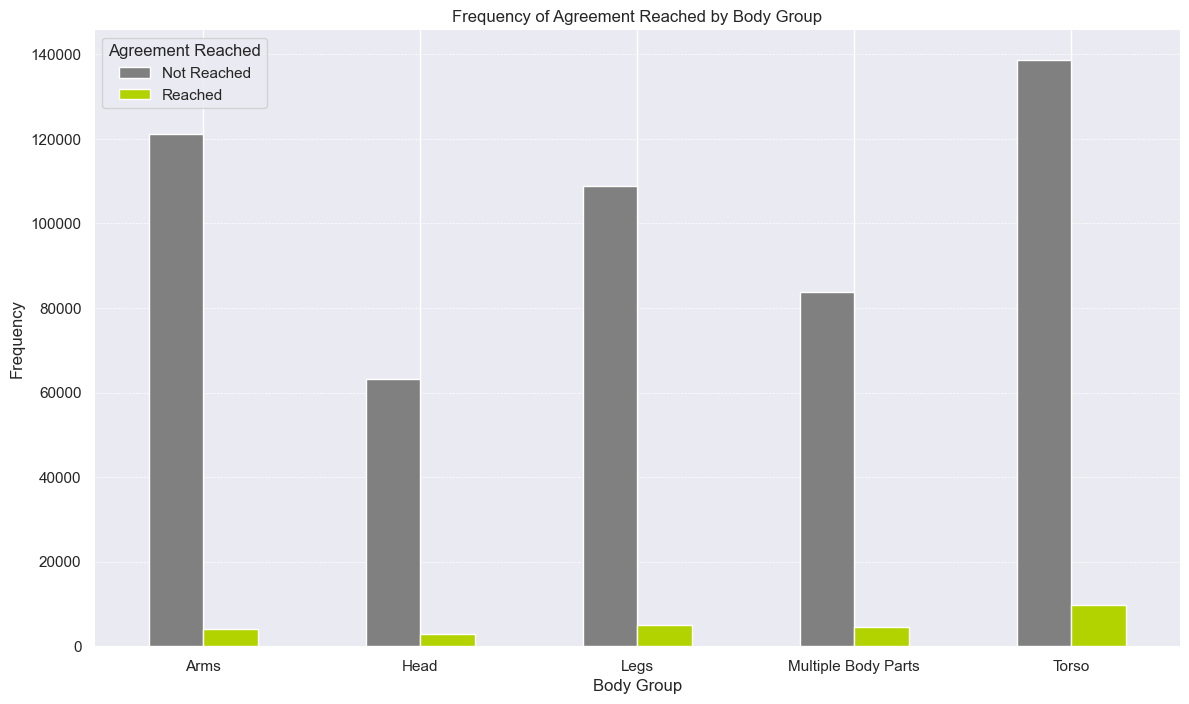

In [112]:
df_train['Agreement Reached'] = df_train['Agreement Reached'].astype(object)
df_train['Agreement Reached'] = df_train['Agreement Reached'].replace({0: 'Not Reached', 1: 'Reached'})
agreement_by_body_group = df_train.groupby(['Agreement Reached', 'body_group']).size().unstack()

fig, ax = plt.subplots(figsize=(14, 8))
agreement_by_body_group.T.plot(kind='bar', ax=ax, color=['Grey','#B2D300'], rot=0)
ax.set_xlabel('Body Group')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Agreement Reached by Body Group')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The graph shows that the percentage of cases in which an agreement is reached varies significantly across different body parts. In particular, for arm and torso injuries, the percentage of cases in which an agreement is not reached is significantly higher than the percentage of cases in which an agreement is reached.

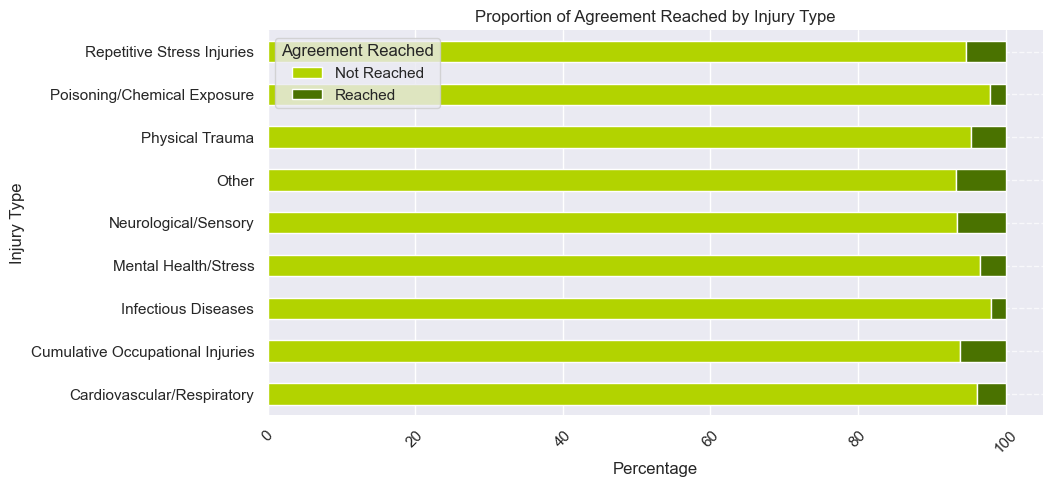

In [113]:
agreement_by_injury_type_proportion = pd.crosstab(df_train['injury_type'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
agreement_by_injury_type_proportion.plot(kind='barh', stacked=True, color=colors, ax=ax)
plt.xlabel('Percentage')
plt.ylabel('Injury Type')
plt.title('Proportion of Agreement Reached by Injury Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In both categories, "Physical Trauma" is the most common type of injury, accounting for the highest proportion. Other injuries, such as "Infectious Diseases" and "Poisoning/ Chemical Exposure" are present but with much smaller percentages. In general, the pattern of injury types is quite similar between the two groups.

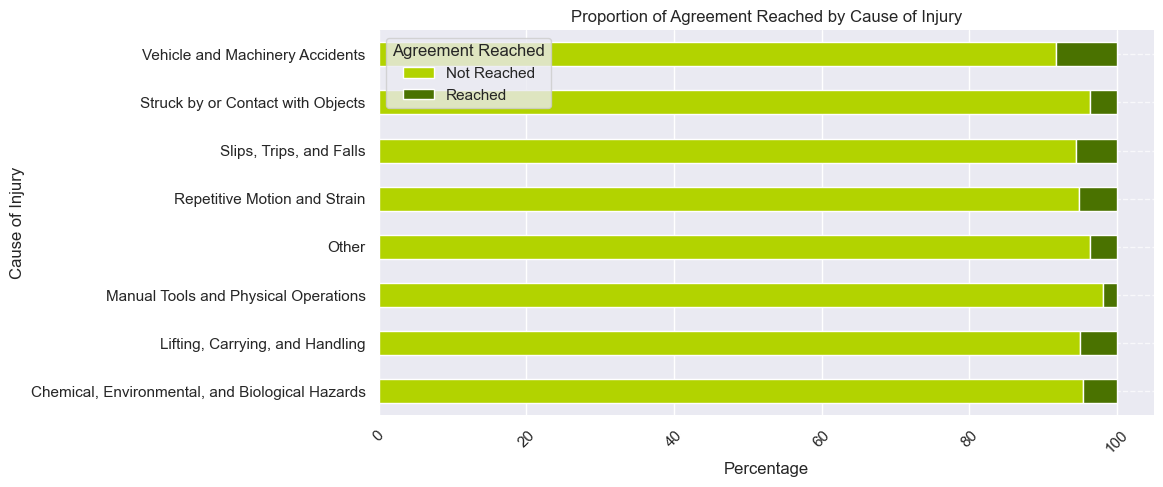

In [114]:
agreement_by_injury_cause_proportion = pd.crosstab(df_train['injury_cause'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
agreement_by_injury_cause_proportion.plot(kind='barh', stacked=True, color=colors, ax=ax)
plt.xlabel('Percentage')
plt.ylabel('Cause of Injury')
plt.title('Proportion of Agreement Reached by Cause of Injury')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The chart indicates that injury causes,  such as "Slips, Trips, and Falls" and "Vehicle and Machinery Accidents" are consistently significant contributors to injuries in both "Reached" and "Not Reached" cases. This trend could reflect common challenges in resolving cases involving these types of injuries or their overall higher frequency. Less common causes like "Manual Tools and Physical Operations" are rare across both groups, suggesting that they may be easier to resolve or simply occur less frequently.

## Zip Codes

For zip codes, the group decided to group into 2 main groups: Regions of New York State and Counties of New York State.<br>

The regions were divided into 10 regions according to the New York State map and the counties into 62 counties. This has to be done manually, as it was done before with the other grouped variables.

References:<br>
https://www.unitedstateszipcodes.org/#zips-list<br>
https://esd.ny.gov/regions<br>
https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?zip=100<br>

In [115]:
zip_code_counts = df_train['Zip Code'].value_counts().head(50)
zip_code_counts

Zip Code
11236    3302
10940    2971
11717    2807
11434    2759
11706    2728
11207    2633
11208    2559
11368    2553
12550    2530
11212    2504
11226    2466
10467    2369
10466    2287
11550    2251
11203    2227
11234    2221
11385    2170
10462    2149
10314    2103
10456    2089
10469    2067
10701    2020
11758    1949
11757    1948
12601    1906
11003    1901
11413    1866
11772    1853
11746    1829
11233    1815
11722    1815
10453    1810
11704    1798
10473    1797
11520    1780
11221    1769
12603    1765
13440    1759
11373    1747
11756    1705
10452    1694
14094    1663
10457    1646
12180    1643
10472    1624
11412    1622
11377    1620
11779    1578
10458    1569
12590    1549
Name: count, dtype: int64

In [116]:
# # Fill NaN values with an empty string
# df_train['Zip Code'] = df_train['Zip Code'].fillna('')

# # Convert all zip codes to string type
# df_train['Zip Code'] = df_train['Zip Code'].astype(str)

# # Unique zip codes
# unique_zip_codes = df_train['Zip Code'].unique()

# # Check if zip codes have letters and digits
# zip_codes_with_letters = [zip_code for zip_code in unique_zip_codes if any(char.isalpha() for char in zip_code)]

# # Check if zip codes have digits only
# zip_codes_with_digits = [zip_code for zip_code in unique_zip_codes if zip_code.isdigit()]
# # order by ascending order the list with the zip codes that contain digits
# zip_codes_with_digits.sort()

In [117]:
unique_zip_codes = df_train[['Zip Code']].drop_duplicates()

In [118]:
unique_zip_codes

Zip Code
0         13662
1         14569
2         12589
4         12603
5         11772
...         ...
592341    30046
592553    90241
592799    G9B0Y
592810    15143
593132    07122

[10061 rows x 1 columns]

In [119]:
region_ny = {
"CENTRAL NEW YORK": ["OSWEGO", "ONONDAGA", "CAYUGA", "MADISON", "CORTLAND"], 
"SOUTHERN TIER": ["DELAWARE", "CHENANGO", "BROOME", "TIOGA", "TOMPKINS", "CHEMUNG", "SCHUYLER", "STEUBEN"],
"FINGER LAKES": ["WAYNE", "SENECA", "YATES", "MONROE", "LIVINGSTON", "ONTARIO", "ORLEANS", "GENESEE", "WYOMING"], 
"WESTERN NEW YORK": ["ERIE", "NIAGARA", "CHAUTAUQUA", "CATTARAUGUS", "ALLEGANY"], 
"NORTH COUNTRY": ["JEFFERSON", "LEWIS", "ST. LAWRENCE", "FRANKLIN", "CLINTON", "ESSEX", "HAMILTON"], 
"MOHAWK VALLEY": ["HERKIMER", "ONEIDA", "OTSEGO", "MONTGOMERY", "FULTON", "SCHOHAIRE"], 
"CAPITAL REGION": ["SCHENECTADY", "ALBANY", "RENSSELAER", "SARATOGA", "GREENE", "COLUMBIA", "WARREN", "WASHINGTON"], 
"HUDSON VALLEY": ["ROCKLAND", "ORANGE", "PUTNAM", "DUTCHESS", "ULSTER", "SULLIVAN", "WESTCHESTER"],
"NEW YORK CITY": ["BRONX", "KINGS", "NEW YORK", "QUEENS", "RICHMOND"], 
"LONG ISLAND": ["NASSAU", "SUFFOLK"]
}

In [120]:
df_train['Zip Code'] = pd.to_numeric(df_train['Zip Code'], errors='coerce')

counties_ny = {'ALBANY':(12007, 12009, 12023, 12041, 12045, 12046, 12047, 12054, 12055, 12059, 12067, 12077, 12084, 12085, 12107, 12110, 12110, 12120, 12128, 
                12128, 12143, 12147, 12158, 12159, 12161, 12183, 12183, 12186, 12189, 12201, 12202, 12203, 12203, 12204, 12204, 12205, 12205, 12205, 
                12206, 12207, 12208, 12209, 12210, 12211, 12211, 12211, 12212, 12220, 12223, 12224, 12225, 12226, 12227, 12247, 12260, 12469), 
               
               'ALLEGANY':(14029, 14707, 14708, 14709, 14711, 14714, 14715, 14717, 14721, 14727, 14735, 14739, 14744, 14745, 14754, 14774, 14777, 14786, 14802,
                14803, 14804, 14806, 14813, 14822, 14880, 14884, 14895), 
               
               'BRONX':(10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469,
                10470, 10471, 10472, 10473, 10474, 10475), 
               
               'BROOME':(13737, 13744, 13745, 13746, 13748, 13749, 13754, 13760, 13760, 13761, 13762, 13763, 13777, 13787, 13790, 13794, 13795, 13797, 13802,
                13813, 13826, 13826, 13833, 13833, 13848, 13850, 13851, 13901, 13902, 13903, 13904, 13905), 
               
               'CATTARAUGUS':(14041, 14042, 14060, 14065, 14065, 14070, 14101, 14129, 14133, 14138, 14168, 14706, 14719, 14726, 14729, 14730, 14731, 14737, 14741,
                14743, 14743, 14748, 14751, 14753, 14755, 14760, 14760, 14766, 14770, 14772, 14778, 14779, 14783), 
               
               'CAYUGA':(13021, 13021, 13022, 13026, 13033, 13034, 13064, 13071, 13081, 13111, 13113, 13117, 13118, 13139, 13140, 13147, 13147, 13156, 13160,
                13166),

               'CHAUTAUQUA':(14048, 14048, 14062, 14063, 14081, 14135, 14136, 14166, 14166, 14701, 14702, 14710, 14712, 14716, 14718, 14720, 14722, 14723, 14724,
                14728, 14732, 14733, 14736, 14738, 14740, 14742, 14747, 14750, 14752, 14756, 14757, 14758, 14767, 14767, 14769, 14775, 14781, 14782,
                14784, 14785),

               'CHEMUNG':(14814, 14816, 14825, 14838, 14844, 14845, 14861, 14864, 14871, 14872, 14889, 14894, 14901, 14902, 14903, 14903, 14903, 14903, 14904,
                14905, 14925),

               'CHENANGO':(13124, 13129, 13136, 13155, 13332, 13332, 13411, 13411, 13460, 13464, 13730, 13733, 13758, 13778, 13780, 13801, 13809, 13814, 13815,
                13830, 13830, 13832, 13841, 13843, 13844),

               'CLINTON':(12901, 12903, 12910, 12911, 12911, 12911, 12912, 12918, 12919, 12921, 12923, 12924, 12924, 12929, 12933, 12934, 12935, 12944, 12952,
                12955, 12955, 12958, 12959, 12962, 12972, 12978, 12979, 12981, 12985, 12992),

               'COLUMBIA':(12017, 12029, 12037, 12050, 12060, 12062, 12075, 12106, 12115, 12125, 12125, 12130, 12132, 12136, 12165, 12172, 12173, 12174, 12184,
                12195, 12502, 12503, 12513, 12516, 12517, 12521, 12523, 12526, 12529, 12530, 12534, 12541, 12544, 12565, 12593, 12593),

               'CORTLAND':(13040, 13040, 13045, 13056, 13077, 13087, 13101, 13141, 13158, 13738, 13784, 13803),

               'DELAWARE':(12167, 12406, 12421, 12430, 12430, 12434, 12438, 12455, 12459, 12474, 13731, 13739, 13740, 13750, 13751, 13752, 13753, 13753, 13755,
                13756, 13757, 13774, 13775, 13782, 13783, 13783, 13786, 13788, 13804, 13806, 13837, 13838, 13839, 13842, 13846, 13846, 13847, 13856,
                13860),

               'DUTCHESS':(12501, 12504, 12504, 12504, 12506, 12507, 12507, 12508, 12510, 12511, 12512, 12514, 12522, 12524, 12527, 12531, 12533, 12533, 12537,
                12538, 12540, 12545, 12546, 12564, 12567, 12569, 12570, 12571, 12571, 12572, 12574, 12578, 12580, 12581, 12582, 12583, 12585, 12590,
                12590, 12592, 12601, 12602, 12603, 12603),

               'ERIE':(14001, 14004, 14006, 14010, 14025, 14026, 14027, 14030, 14031, 14032, 14033, 14034, 14035, 14038, 14043, 14047, 14051, 14051, 14052,
                14055, 14057, 14059, 14061, 14068, 14069, 14072, 14075, 14080, 14085, 14086, 14091, 14102, 14110, 14111, 14112, 14127, 14134, 14139,
                14140, 14141, 14150, 14151, 14169, 14170, 14201, 14202, 14203, 14204, 14205, 14206, 14206, 14207, 14208, 14209, 14210, 14211, 14212,
                14212, 14213, 14214, 14215, 14216, 14217, 14217, 14217, 14217, 14218, 14218, 14219, 14219, 14220, 14221, 14221, 14222, 14223, 14223,
                14223, 14224, 14225, 14225, 14226, 14226, 14226, 14226,14227, 14227, 14227, 14228, 14228, 14231, 14240, 14280),

               'ESSEX':(12851, 12852, 12855, 12857, 12858, 12858, 12870, 12872, 12879, 12879, 12883, 12913,12928, 12932, 12936, 12941, 12942, 12943, 12943,
                12946, 12946, 12950, 12956, 12960, 12961, 12964, 12974, 12975, 12977, 12987, 12993),

               'FRANKLIN':(12914, 12915, 12916, 12917, 12920, 12926, 12930, 12937, 12939, 12945, 12945, 12953,
                12957, 12966, 12966, 12966, 12969, 12970, 12976, 12980, 12983, 12986, 12986, 12989,
                12989, 12989, 13655, 13655, 13655),

               'FULTON':(12025, 12032, 12078, 12095, 12117, 12134, 12134, 13470),

               'GENESEE':(14003, 14005, 14013, 14020, 14021, 14036, 14040, 14054, 14056, 14058, 14125, 14143, 14416, 14422, 14482, 14486, 14525, 14525, 14557),

               'GREENE':(12015, 12042, 12051, 12058, 12083, 12083, 12083, 12087, 12124, 12176, 12192, 12405, 12407, 12413, 12414, 12414, 12418, 12422, 12423,
                12424, 12424, 12427, 12431, 12436, 12439, 12439, 12442, 12444, 12450, 12451, 12452, 12454, 12460, 12463, 12468, 12470, 12473, 12482, 
                12485, 12492),

               'HAMILTON':(12108, 12139, 12164, 12190, 12812, 12842, 12847, 12864, 13353, 13360, 13436),

               'HERKIMER':(13324, 13329, 13331, 13340, 13340, 13350, 13357, 13361, 13365, 13406, 13407, 13416, 13420, 13431, 13454, 13472, 13475, 13491),

               'JEFFERSON':(13601, 13602, 13603, 13605, 13606, 13607, 13607, 13608, 13608, 13611, 13612, 13615, 13616, 13618, 13619, 13622, 13624, 13624, 13624,
                13624, 13628, 13632, 13634, 13636, 13637, 13638, 13640, 13640, 13641, 13643, 13650, 13651, 13656, 13657, 13659, 13661, 13665, 13671,
                13673, 13674, 13675, 13679, 13682, 13685, 13688, 13691, 13692, 13693),

               'KINGS':(11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219,
                11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239,
                11240, 11241, 11242, 11243, 11247, 11249, 11252, 11252, 11256),

               'LEWIS':(13305, 13305, 13312, 13312, 13325, 13327, 13343, 13345, 13367, 13367, 13368, 13404, 13433, 13473, 13489, 13620, 13626, 13626, 13627, 
                13631, 13648),

               'LIVINGSTON':(14414, 14423, 14435, 14437, 14454, 14462, 14466, 14480, 14481, 14485, 14487, 14488, 14510, 14510, 14517, 14533, 14533, 14539, 14545,
                14545, 14556, 14558, 14560, 14560, 14836, 14846),

               'MADISON':(13032, 13032, 13035, 13037, 13043, 13052, 13061, 13072, 13082, 13122, 13134, 13163, 13310, 13314, 13334, 13346, 13355, 13364, 13402,
                13408, 13409, 13409, 13418, 13421, 13465, 13484),

               'MONROE':(14410, 14420, 14428, 14428, 14430, 14445, 14450, 14464, 14467, 14468, 14472, 14506, 14511, 14514, 14515, 14526, 14534, 14543, 14543,
                14546, 14559, 14580, 14586, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14612, 14613, 14614,
                14615, 14615, 14616, 14616, 14617, 14617, 14618, 14618, 14619, 14620, 14621, 14622, 14622, 14623, 14624, 14625, 14625, 14626, 14626,
                14626, 14627, 14660, 14692),

               'MONTGOMERY':(12010, 12010, 12016, 12016, 12066, 12068, 12069, 12070, 12072, 12086, 12166, 12177, 13317, 13317, 13339, 13410, 13428, 13452),

               'NASSAU':(11001, 11002, 11003, 11003, 11003, 11003, 11010, 11020, 11021, 11022, 11023, 11024, 11024, 11026, 11027, 11030, 11030, 11040, 11042,
                11050, 11050, 11096, 11096, 11501, 11507, 11509, 11510, 11510, 11514, 11516, 11518, 11520, 11530, 11530, 11531, 11542, 11545, 11547,
                11548, 11550, 11550, 11551, 11552, 11553, 11554, 11557, 11558, 11559, 11560, 11561, 11561, 11561, 11563, 11565, 11566, 11566, 11568,
                11569, 11570, 11571, 11572, 11572, 11575, 11576, 11577, 11579, 11580, 11581, 11582, 11596, 11599, 11709, 11710, 11710, 11714, 11732,
                11735, 11735, 11753, 11756, 11758, 11758, 11762, 11765, 11771, 11783, 11791, 11793, 11801, 11802, 11803, 11803, 11804, 11804),

               'NEW YORK CITY':(10001, 10002, 10002, 10003, 10004, 10004, 10005, 10006, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10012, 10013, 10013, 10013,
                10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
                10033, 10034, 10035, 10036, 10037, 10038, 10038, 10039, 10040, 10041, 10044, 10044, 10045, 10048, 10055, 10060, 10069, 10090, 10095,
                10098, 10099, 10101, 10103, 10104, 10105, 10106, 10107, 10108, 10110, 10111, 10112, 10113, 10115, 10116, 10118, 10119, 10120, 10121,
                10122, 10123, 10128, 10129, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10158, 10159, 10161, 10162, 10163, 10165, 10166, 10167,
                10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10185, 10199, 10242, 10249, 10268, 10270, 10271, 10272,
                10274, 10276, 10278, 10279, 10280, 10281, 10282),

               'NIAGARA':(14008, 14012, 14028, 14067, 14092, 14092, 14094, 14095, 14105, 14107, 14108, 14109, 14120, 14126, 14131, 14132, 14144, 14301, 14302,
                14303, 14304, 14305),

               'ONEIDA':(13054, 13123, 13157, 13162, 13301, 13303, 13304, 13308, 13309, 13313, 13316, 13318, 13319, 13321, 13322, 13323, 13328, 13338, 13341,
                13352, 13354, 13362, 13363, 13401, 13403, 13413, 13417, 13424, 13425, 13435, 13438, 13440, 13441, 13442, 13455, 13456, 13456, 13461,
                13469, 13471, 13476, 13477, 13478, 13479, 13480, 13501, 13502, 13502, 13503, 13504, 13505),

               'ONONDAGA':(13020, 13027, 13027, 13029, 13030, 13031, 13039, 13041, 13051, 13057, 13060, 13063, 13066, 13078, 13080, 13084, 13088, 13089, 13090,
                13090, 13104, 13108, 13110, 13112, 13116, 13119, 13120, 13137, 13138, 13152, 13153, 13159, 13164, 13201, 13202, 13203, 13204, 13205,
                13206, 13207, 13208, 13209, 13209, 13210, 13211, 13211, 13212, 13212, 13214, 13214, 13215, 13217, 13218, 13219, 13220, 13221, 13224,
                13235, 13261, 13290),

               'ONTARIO':(14424, 14425, 14425, 14432, 14443, 14453, 14456, 14461, 14463, 14469, 14471, 14475, 14504, 14512, 14518, 14532, 14537, 14547, 14548,
                14561, 14564, 14585),

               'ORANGE':(10910, 10912, 10914, 10915, 10916, 10917, 10918, 10919, 10921, 10922, 10924, 10925, 10926, 10928, 10930, 10932, 10933, 10940, 10940,
                10941, 10941, 10950, 10953, 10958, 10959, 10963, 10969, 10973, 10975, 10979, 10981, 10985, 10987, 10988, 10990, 10992, 10996, 10997,
                12518, 12520, 12543, 12549, 12550, 12551, 12552, 12553, 12553, 12555, 12566, 12575, 12577, 12584, 12586, 12729, 12739, 12746, 12771, 
                12780, 12780),

               'ORLEANS':(14098, 14103, 14411, 14411, 14429, 14452, 14470, 14470, 14476, 14477, 14479, 14508, 14571),

               'OSWEGO':(13028, 13036, 13042, 13044, 13069, 13074, 13076, 13083, 13093, 13103, 13107, 13114, 13115, 13121, 13126, 13131, 13132, 13135, 13142, 
                13144, 13145, 13167, 13302, 13426, 13437),

               'OTSEGO':(12064, 12116, 12155, 13315, 13320, 13326, 13326, 13333, 13335, 13337, 13342, 13348, 13415, 13439, 13450, 13457, 13468, 13482, 13485, 
                13747, 13776, 13796, 13807, 13808, 13810, 13820, 13825, 13834, 13849, 13859, 13861),

               'PUTNAM':(10509, 10512, 10512, 10516, 10516, 10524, 10537, 10541, 10541, 10542, 10579, 12563),

               'QUEENS':(11004, 11004, 11005, 11101, 11101, 11102, 11102, 11103, 11103, 11104, 11104, 11104, 11105, 11105, 11106, 11106, 11109, 11351, 11352,
                11354, 11355, 11356, 11356, 11357, 11357, 11357, 11358, 11359, 11359, 11359, 11360, 11360, 11361, 11361, 11362, 11362, 11362, 11363,
                11363, 11363, 11364, 11364, 11365, 11365, 11366, 11366, 11367, 11368, 11368, 11369, 11369, 11370, 11371, 11371, 11371, 11372, 11372,
                11372, 11373, 11373, 11374, 11374, 11375, 11375, 11377, 11378, 11378, 11379, 11379, 11379, 11380, 11380, 11380, 11385, 11385, 11385,
                11386, 11386, 11411, 11411, 11412, 11412, 11413, 11413, 11413, 11414, 11414, 11415, 11415, 11416, 11416, 11417, 11417, 11418, 11418,
                11419, 11419, 11420, 11420, 11421, 11422, 11422, 11423, 11423, 11424, 11426, 11426, 11427, 11427, 11428, 11428, 11429, 11429, 11430,
                11430, 11431, 11432, 11432, 11433, 11434, 11435, 11436, 11436, 11437, 11437, 11438, 11438, 11439, 11440, 11441, 11442, 11443, 11443,
                11444, 11445, 11446, 11446, 11447, 11447, 11449, 11449, 11451, 11451, 11452, 11453, 11453, 11454, 11455, 11455, 11456, 11456, 11457,
                11458, 11459, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475,
                11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494,
                11495, 11496, 11497, 11498, 11499, 11690, 11690, 11691, 11692, 11692, 11693, 11693, 11693, 11694, 11694, 11694, 11695, 11695, 11697,
                11697, 11697),

               'RENSSELAER':(12018, 12022, 12024, 12028, 12033, 12033, 12040, 12052, 12057, 12061, 12063, 12082, 12089, 12090, 12094, 12121, 12123, 12133, 12138,
                12138, 12138, 12140, 12144, 12153, 12154, 12156, 12168, 12169, 12180, 12181, 12182, 12185),

               'RICHMOND':(10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314),

               'ROCKLAND':(10901, 10901, 10901, 10911, 10913, 10920, 10923, 10927, 10931, 10952, 10954, 10954, 10956, 10960, 10962, 10964, 10965, 10968, 10970,
                10974, 10976, 10977, 10977, 10980, 10982, 10983, 10984, 10986, 10989, 10993,  10994),

               'SARATOGA':(12019, 12019, 12019, 12020, 12020, 12027, 12065, 12074, 12118, 12148, 12151, 12170, 12188, 12803, 12803, 12822, 12831, 12833, 12835,
                12850, 12859, 12863, 12866, 12871, 12884),

               'SCHENECTADY':(12008, 12008, 12053, 12056, 12137, 12141, 12150, 12301, 12302, 12302, 12302, 12303, 12304, 12305, 12306, 12306, 12307, 12308, 12309,
                12309, 12325, 12325),

               'SCHOHARIE':(12031, 12035, 12036, 12043, 12043, 12071, 12073, 12076, 12092, 12093, 12122, 12131, 12149, 12157, 12160, 12175, 12187, 12194, 13459),

               'SCHUYLER':(14805, 14812, 14815, 14818, 14824, 14841, 14841, 14863, 14865, 14869, 14876, 14878, 14887, 14891, 14893),

               'SENECA':(13065, 13148, 13165, 14521, 14521, 14541, 14541, 14847, 14860),

               'ST. LAWRENCE':(12922, 12927, 12949, 12965, 12965, 12967, 12973, 13613, 13614, 13617, 13621, 13623, 13625, 13630, 13633, 13635, 13639, 13642, 13645,
                13646, 13647, 13649, 13652, 13654, 13658, 13660, 13662, 13664, 13666, 13667, 13668, 13669, 13670, 13672, 13676, 13677, 13678, 13680,
                13681, 13683, 13684, 13684, 13687, 13690, 13694, 13695),

               'STEUBEN':(14529, 14572, 14801, 14807, 14808, 14808, 14809, 14809, 14810, 14810, 14819, 14820, 14821, 14823, 14826, 14827, 14830, 14839, 14840,
                14843, 14855, 14856, 14858, 14870, 14873, 14874, 14877, 14879, 14885),

               'SUFFOLK':(6390, 11701, 11701, 11702, 11702, 11702, 11702, 11702, 11703, 11703, 11704, 11704, 11705, 11706, 11706, 11706, 11706, 11707, 11707,
                11708, 11713, 11715, 11716, 11717, 11717, 11717, 11718, 11719, 11720, 11720, 11721, 11722, 11724, 11725, 11726, 11727, 11729, 11730,
                11731, 11731, 11733, 11733, 11738, 11739, 11740, 11741, 11742, 11743, 11743, 11743, 11746, 11746, 11747, 11747, 11749, 11749, 11749,
                11749, 11751, 11752, 11754, 11755, 11757, 11760, 11763, 11764, 11766, 11767, 11768, 11769, 11770, 11772, 11772, 11772, 11776, 11777,
                11777, 11777, 11777, 11778, 11779, 11779, 11780, 11782, 11782, 11782, 11784, 11786, 11787, 11788, 11788, 11789, 11790, 11792, 11795,
                11805, 11901, 11901, 11930, 11931, 11932, 11933, 11934, 11934, 11935, 11937, 11939, 11940, 11941, 11942, 11944, 11946, 11947, 11948,
                11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11967, 11967,
                11968, 11969, 11970, 11971, 11972, 11973, 11975, 11976),

               'SULLIVAN':(12701, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12732, 12733, 12734, 12736, 12737, 12738, 12740, 12741, 12742,
                12743, 12745, 12747, 12748, 12749, 12750, 12751, 12752, 12754, 12758, 12758, 12759, 12760, 12762, 12763, 12764, 12765, 12766, 12767,
                12768, 12769, 12770, 12775, 12776, 12777, 12777, 12778, 12779, 12781, 12783, 12784, 12785),

               'TIOGA':(13732, 13734, 13736, 13743, 13811, 13812, 13827, 13835, 13840, 13845, 14859, 14883, 14883, 14892),

               'TOMPKINS':(13053, 13062, 13068, 13073, 13092, 13102, 14817, 14850, 14850, 14851, 14852, 14853, 14854, 14867, 14881, 14882, 14882, 14886),

               'ULSTER':(12401, 12401, 12401, 12402, 12404, 12409, 12409, 12410, 12410, 12411, 12412, 12416, 12417, 12419, 12420, 12428, 12429, 12432, 12433,
                12435, 12440, 12441, 12443, 12446, 12448, 12449, 12453, 12456, 12457, 12458, 12461, 12461, 12464, 12465, 12466, 12471, 12472, 12475,
                12477, 12480, 12481, 12483, 12484, 12486, 12487, 12489, 12490, 12491, 12493, 12515, 12525, 12528, 12542, 12547, 12548, 12561, 12568,
                12588, 12589, 12782, 12782),

               'WARREN':(12801, 12801, 12804, 12804, 12808, 12810, 12811, 12814, 12815, 12817, 12820, 12824, 12836, 12843, 12844, 12844, 12845, 12846, 12853,
                12856, 12860, 12862, 12874, 12878, 12885, 12885),

               'WASHINGTON':(12809, 12816, 12819, 12821, 12823, 12827, 12828, 12832, 12834, 12834, 12837, 12838, 12839, 12841, 12848, 12849, 12854, 12861, 12865,
                12865, 12873),

               'WAYNE':(13143, 13146, 13154, 14413, 14433, 14449, 14489, 14502, 14505, 14513, 14513, 14516, 14519, 14520, 14522, 14538, 14542, 14551, 14551,
                14555, 14563, 14568),

               'WESTCHESTER':(10501, 10502, 10503, 10504, 10504, 10505, 10506, 10507, 10510, 10510, 10511, 10514, 10517, 10518, 10519, 10520, 10521, 10521, 10522,
                10523, 10526, 10527, 10528, 10530, 10532, 10533, 10535, 10536, 10538, 10540, 10543, 10545, 10546, 10547, 10548, 10549, 10549, 10550,
                10551, 10552, 10553, 10560, 10562, 10566, 10567, 10570, 10573, 10573, 10576, 10577, 10578, 10580, 10583, 10583, 10587, 10588, 10589,
                10590, 10591, 10591, 10591, 10594, 10595, 10596, 10597, 10604, 10706, 10707, 10707, 10708, 10709, 10801, 10802, 10803, 10804, 10805),

               'WYOMING':(14009, 14011, 14024, 14037, 14039, 14066, 14082, 14083, 14113, 14130, 14145, 14167, 14427, 14530, 14536, 14536, 14549, 14550, 14550,
                14569),

               'YATES':(14415, 14418, 14441, 14478, 14478, 14507, 14527, 14544, 14837, 14842, 14857)
                }

def region_finder(zip_code):
    for county, zips in counties_ny.items():
        if zip_code in zips:
            for region, counties in region_ny.items():
                if county in counties:
                    return region
    return 'OTHER'
    

df_train['zip_group'] = df_train['Zip Code'].apply(region_finder)

df_train[['zip_group']]

zip_group
0          NORTH COUNTRY
1           FINGER LAKES
2          HUDSON VALLEY
4          HUDSON VALLEY
5            LONG ISLAND
...                  ...
593451     NEW YORK CITY
593455             OTHER
593456  WESTERN NEW YORK
593457             OTHER
593467     HUDSON VALLEY

[574026 rows x 1 columns]

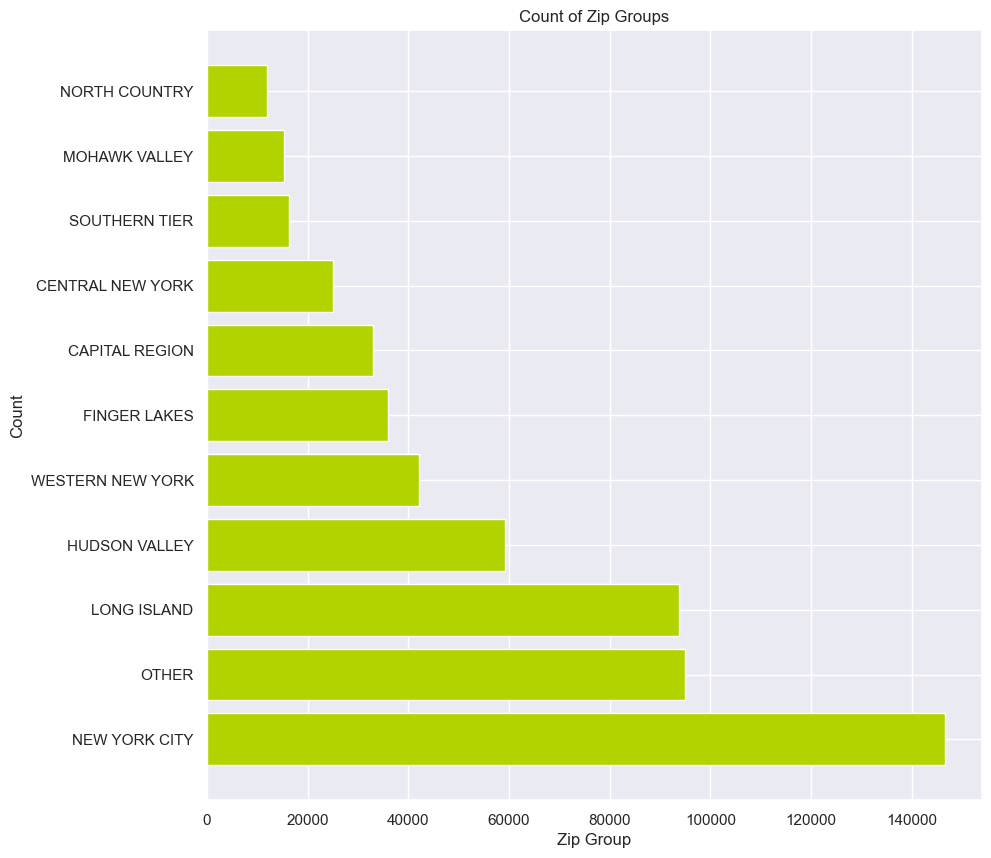

In [121]:
plt.figure(figsize=(10, 10))
plt.barh(df_train['zip_group'].value_counts().index, df_train['zip_group'].value_counts().values, color='#B2D300')
plt.xlabel('Zip Group')
plt.ylabel('Count')
plt.title('Count of Zip Groups')
plt.show()

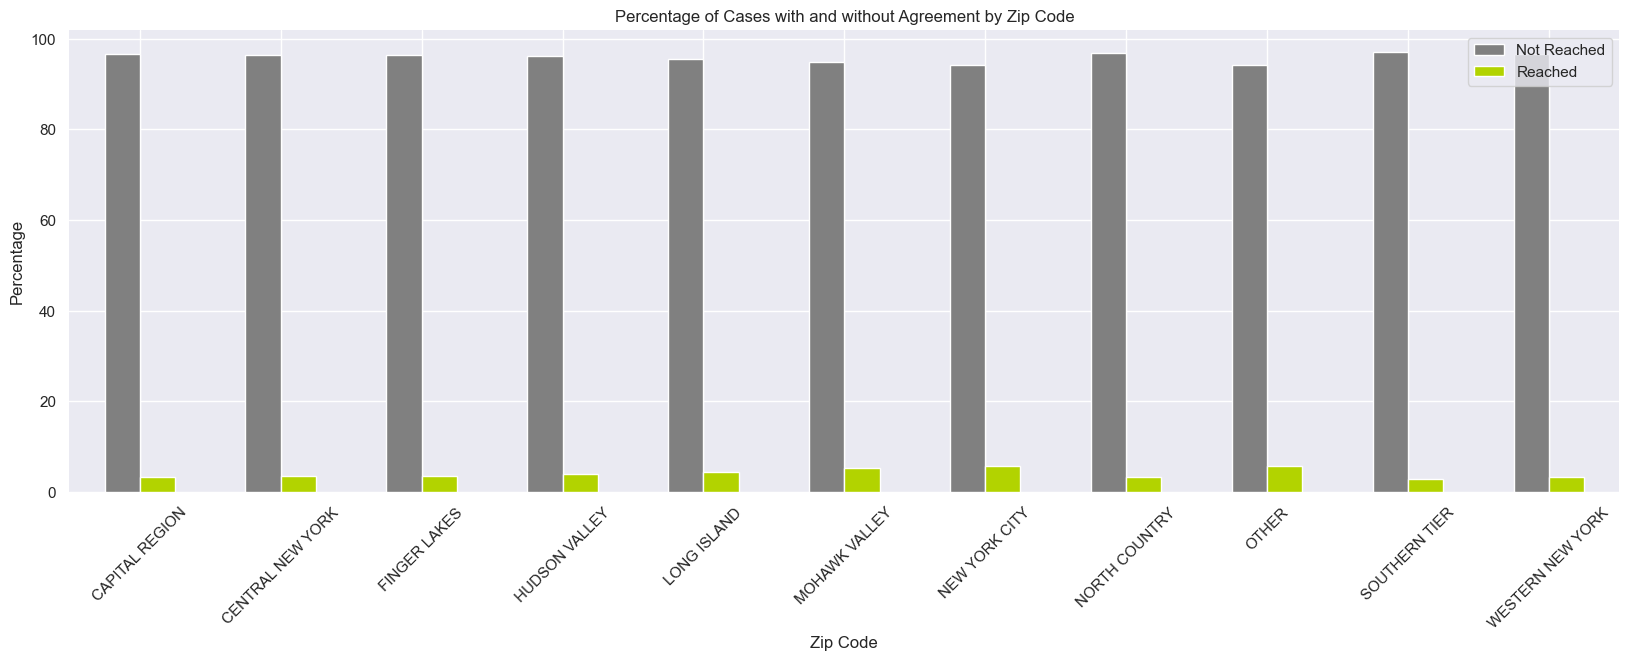

In [122]:
agreement_by_zip_code = pd.crosstab(df_train['zip_group'], df_train['Agreement Reached'])
agreement_by_zip_code.columns = ['Not Reached', 'Reached']
agreement_by_zip_code['Reached'] = (agreement_by_zip_code['Reached'] / (agreement_by_zip_code['Not Reached'] + agreement_by_zip_code['Reached'])) * 100
agreement_by_zip_code['Not Reached'] = 100 - agreement_by_zip_code['Reached']
agreement_by_zip_code.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(20, 6))
plt.xlabel('Zip Code')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Zip Code')
plt.xticks(rotation=45)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

# Feature Engineering

## Time to Assembly Date

How does the time between accidents and the day of the claim assembly vary?<br>
To create this variable, the group subtracted the accident date from the assembly date.

Note: The assembly date is the date the claim was first assembled. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker. 

Reference:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [123]:
df_train['days_accident_to_assembly'] = (df_train['Assembly Date'] - df_train['Accident Date']).dt.days

In [124]:
negative_days = df_train[df_train['days_accident_to_assembly'] < 0]
negative_days

Accident Date  Age at Injury Assembly Date Attorney/Representative  \
168       2020-02-26             57    2020-01-01                     Yes   
412       2020-01-23             62    2020-01-02                     Yes   
582       2020-03-01             62    2020-01-02                     Yes   
798       2020-01-27             57    2020-01-03                     Yes   
1332      2020-01-23             56    2020-01-03                     Yes   
...              ...            ...           ...                     ...   
590739    2023-02-02             52    2022-12-26                     Yes   
590745    2022-12-28             55    2022-12-26                      No   
591212    2022-12-30             33    2022-12-27                     Yes   
591972    2022-12-29             41    2022-12-28                      No   
592884    2023-01-04             56    2022-12-30                     Yes   

        Average Weekly Wage  Birth Year   C-2 Date   C-3 Date  \
168                 1997.87      1962.0 2019-12-31 2020-01-31   
412                 1775.89      1957.0 2020-01-14 2019-12-27   
582                 1467.47      1957.0 2020-01-17 2019-12-27   
798                 1450.00         NaN 2020-01-15 2019-12-30   
1332                1334.92         0.0 2020-01-06 2019-12-26   
...                     ...         ...        ...        ...   
590739               992.39      1970.0 2022-12-26        NaT   
590745                 0.00      1967.0 2022-12-26        NaT   
591212              2884.62      1989.0 2023-02-14 2022-12-20   
591972              2500.00      1981.0        NaT        NaT   
592884              1576.92      1966.0 2023-02-22 2022-12-21   

                        Carrier Name     Carrier Type  ... days_to_c2  \
168     CNY OTHER THAN ED, HED WATER      SELF-PUBLIC  ...      -57.0   
412            NYC TRANSIT AUTHORITY      SELF-PUBLIC  ...       -9.0   
582             STATE INSURANCE FUND  STATE INSURANCE  ...      -44.0   
798       NEW YORK CITY TRANSIT AUTH      SELF-PUBLIC  ...      -12.0   
1332            STATE INSURANCE FUND  STATE INSURANCE  ...      -17.0   
...                              ...              ...  ...        ...   
590739  MASSACHUSETTS BAY INS.CO.C/O          PRIVATE  ...      -38.0   
590745          STATE INSURANCE FUND  STATE INSURANCE  ...       -2.0   
591212  CNY OTHER THAN ED, HED WATER      SELF-PUBLIC  ...       46.0   
591972   PFL NI CARRIER UNDETERMINED     SPECIAL FUND  ...        NaN   
592884  CNY OTHER THAN ED, HED WATER      SELF-PUBLIC  ...       49.0   

       days_to_c2_binned age_group  wage_groups           body_group  \
168                  NaN     45-64    High Wage                 Arms   
412                  NaN     45-64    High Wage  Multiple Body Parts   
582                  NaN     45-64  Medium Wage                 Head   
798                  NaN     45-64  Medium Wage                 Head   
1332                 NaN     45-64  Medium Wage                 Arms   
...                  ...       ...          ...                  ...   
590739               NaN     45-64  Medium Wage                 Arms   
590745               NaN     45-64      No Wage                Torso   
591212          3 months     25-44    High Wage  Multiple Body Parts   
591972               NaN     25-44    High Wage                  NaN   
592884          3 months     45-64  Medium Wage                Torso   

                             injury_type                  injury_cause  \
168     Cumulative Occupational Injuries  Repetitive Motion and Strain   
412     Cumulative Occupational Injuries                         Other   
582                 Neurological/Sensory                         Other   
798                 Neurological/Sensory                         Other   
1332          Repetitive Stress Injuries                         Other   
...                                  ...                           ...   
590739                   Physical Trauma 

In [125]:
print(f'There are {len(negative_days)} rows where the Assembly Date is before the Accident Date, this amounts to {round(len(negative_days)/len(df_train)*100, 2)}% of the data.')

There are 1407 rows where the Assembly Date is before the Accident Date, this amounts to 0.25% of the data.


There are cases where the date of the assembly precedes the date of the accident, obviously this should be impossible. These rows will be adressed in the data cleaning proccess.

The days can be grouped into the following categories:
- Same day (0 days)
- 1 week (7 days)
- 1 month (30 days)
- 3 Months (90 days)
- 6 months (180 days)
- 1 year (365 days)
- 365 x 10 (10 years)
- 365 x 60 (60 years, this group was created to encompass all observations)

In [126]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_train['days_accident_to_assembly_binned'] = pd.cut(df_train['days_accident_to_assembly'], bins=bins, labels=labels)

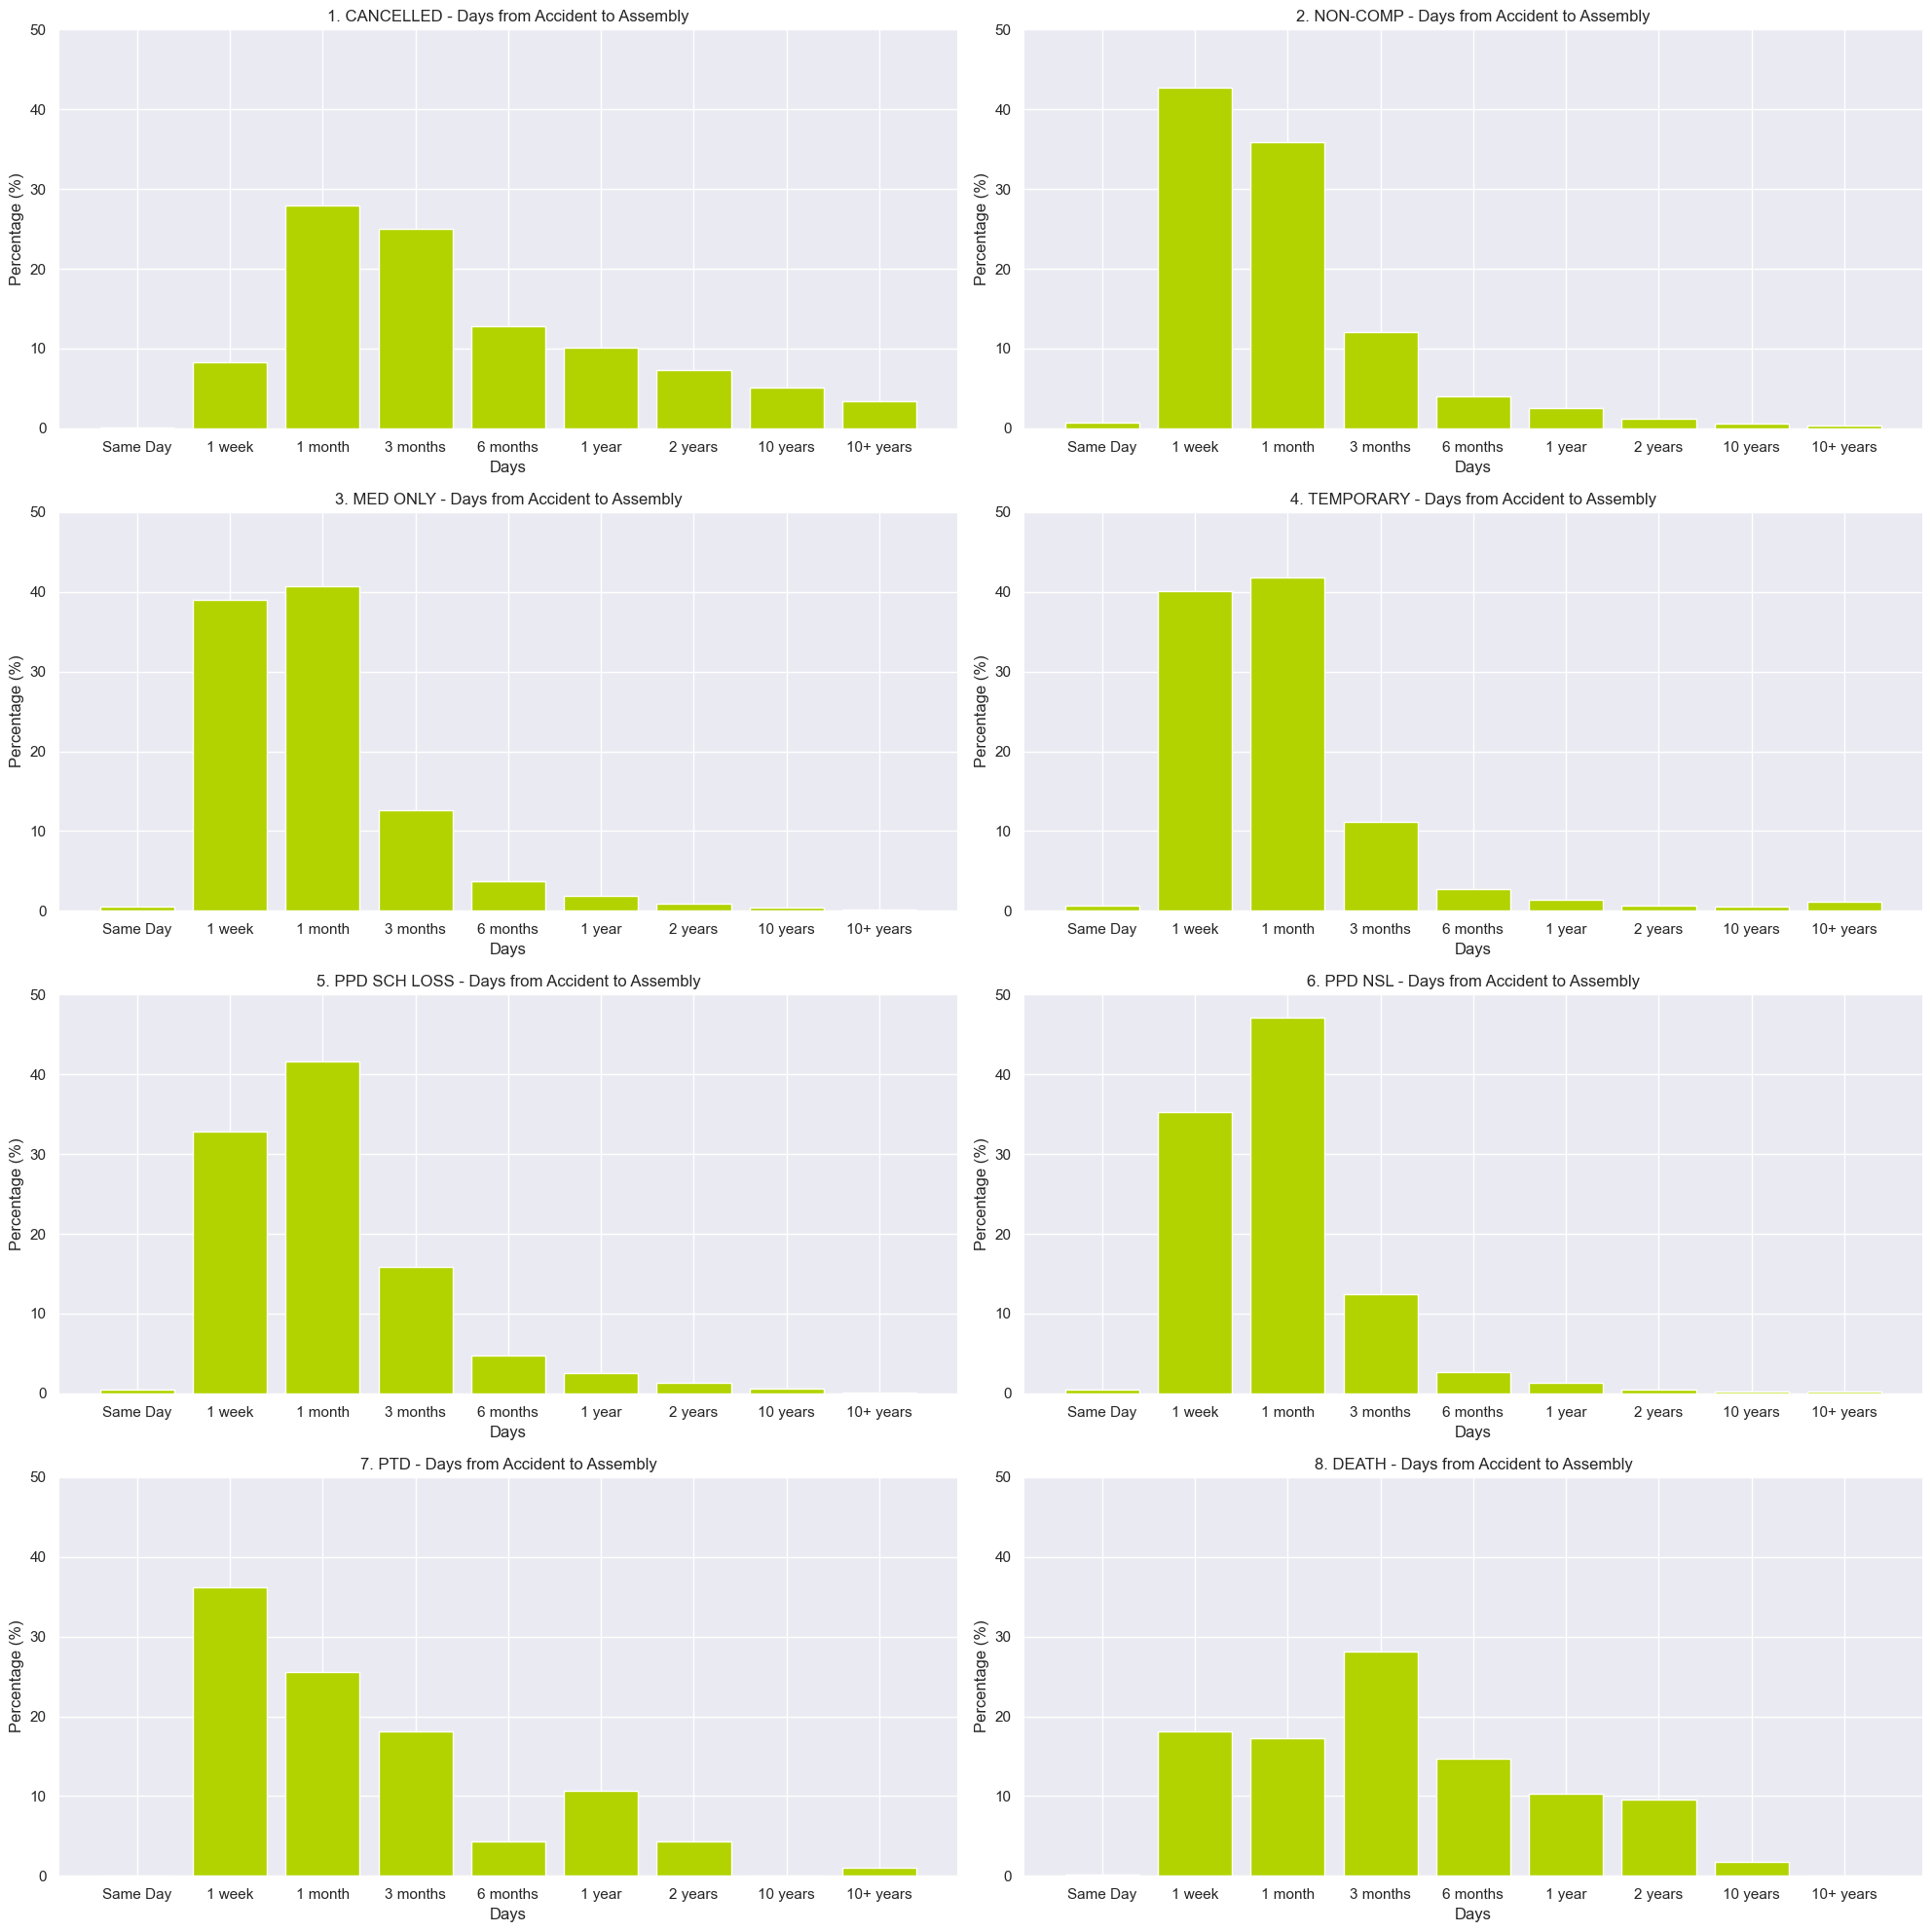

In [127]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
claim_list = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY', '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

for ax, claim in zip(axes.flatten(), claim_list):
    days_accident_binned = df_train[df_train['Claim Injury Type'] == claim]['days_accident_to_assembly_binned'].value_counts().sort_index()
    bars = ax.bar(days_accident_binned.index.astype(str), days_accident_binned.values / days_accident_binned.values.sum() * 100, color='#B2D300')
    ax.set_title(f'{claim} - Days from Accident to Assembly')
    ax.set_xlabel('Days')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 50)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

Expectedly, most of the claimants present in the dataset had their claims assembled within a month of the accident date. Unexpectedly, the type of claim where more time elapsed between accident and claim assembly are the cases involving death. This rise in 'waiting time' could possibly be due to the compexity of creating a claim for a case where a person died (such as the need for an autopsy report or police investigation).

There are some outliers - one observation waited for almost 60 years before assembeling the claim - but these cases will most likely be removed in the data cleaning phase.

## First Hearing Date and C-3 Date

The group determined that `First Hearing Date` and `C-3 Date` could not be used in their current form and needed to be transformed into new variables. It was decided to convert both variables into binary indicators, where the values would denote the presence of a date (1) or its absence (0).

In [128]:
df_train['has_hearing_date'] = df_train['First Hearing Date'].notnull().astype(int)

In [129]:
df_train['has_c3_date'] = df_train['C-3 Date'].notnull().astype(int)

In [130]:
df_train = df_train.drop(columns=['C-3 Date', 'First Hearing Date'])

## Accident Severity Score

### Reworking the AIS Codes into an Ordinal Variable  

To enhance the predictive power of injury scoring, the AIS body region codes were reworked into an ordinal variable by grouping regions and assigning corresponding weights. This approach aimed to better reflect the criticality of injuries by body region.  

| **AIS Code** | **Body Region**                      | **Associated Weight (Adult)**    |
|--------------|--------------------------------------|----------------------------------|
| 1            | Head                                 | 6.39                             |
| 2            | Face                                 | 4.18                             |
| 3            | Neck                                 | 6.39                             |
| 4            | Thorax                               | 4.80                             |
| 5            | Abdomen                              | 4.76                             |
| 6            | Spine                                | 5.32                             |
| 7            | Upper Extremity                      | 5.65                             |
| 8            | Lower Extremity                      | 5.65                             |
| 9            | Unspecified                          | NA                               |

The AIS codes represent **9 body regions**, aligned with the AIS (Abbreviated Injury Scale) standards. However, code 9 is used here to represent unspecified body regions instead of external injuries, such as burns. The weights, drawn from a 2019 study, aim to provide a more meaningful assessment of injury severity and mortality risk by emphasizing the criticality of certain body regions (e.g., head, neck, and thorax).  

**References:**<br>
Shi, J., Shen, J., Zhu, M. et al. A new weighted injury severity scoring system: better predictive power for adult trauma mortality. Inj. Epidemiol. 6, 40 (2019) <br>
Morris, Andrew, Barnes, Jo, Fildes, Brian, Bentivegna, Fulvio, Seyer, Keith. _Effectiveness of ADR 69: A Case-Control Study of Crashed Vehicles Equipped with Airbags_.


In [131]:
body_region = {
'Head':["MULTIPLE HEAD INJURY", "EAR(S)", "SKULL", 
        "BRAIN", "SOFT TISSUE HEAD"],

'Face':["EYE(S)", "MOUTH", "NOSE", "FACIAL BONES", "TEETH"],

'Neck':["LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "VERTEBRAE",
        "DISC NECK", "SPINAL CORD", "SOFT TISSUE NECK"],

"Thorax":["CHEST", "LUNGS", "HEART", "MULTIPLE TRUNK", "UPPER BACK AREA"],

"Abdomen":["ABDOMEN INCLUDING GROIN", "INTERNAL ORGANS", "PELVIS"],

"Spine":["SPINAL CORD", "VERTEBRAE", "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA)", 
        "SACRUM AND COCCYX", "LOWER BACK AREA", "DISC TRUNK", "BUTTOCKS"],

"Upper Extremity":["SHOULDER(S)", "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", 
                    "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", 
                    "LOWER ARM"],
"Lower Extremity":["LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", 
                    "GREAT TOE", "MULTIPLE LOWER EXTREMITIES", "HIP"],

"Unspecified":["ARTIFICIAL APPLIANCE", "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED", 
                "NO PHYSICAL INJURY", "MULTIPLE BODY PARTS (INCLUDING BODY", 
                "BODY SYSTEMS AND MULTIPLE BODY SYSTEMS", "WHOLE BODY", "MULTIPLE"]
}

In [132]:
df_train['body_region'] = None

def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region

df_train['body_region'] = df_train['WCIO Part Of Body Description'].apply(categorize_body)

In [133]:
ais_body_regions = {
    1: "Head",
    2: "Face",
    3: "Neck",
    4: "Thorax",
    5: "Abdomen",
    6: "Spine",
    7: "Upper Extremity",
    8: "Lower Extremity",
    9: "Unspecified"
}

In [134]:
df_train['AIS'] = None

def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

df_train['AIS'] = df_train['body_region'].apply(categorize_AIS)

In [135]:
w_adult = {
    1: 6.39,
    2: 4.18,
    3: 6.39,
    4: 4.80,
    5: 4.76,
    6: 5.32,
    7: 5.65,
    8: 5.65,
    9: 0
}

def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]

In [136]:
ais_weights = df_train.apply(lambda row: ais_weights(row), axis=1)
df_train['ais_weights'] = ais_weights

In [137]:
df_train.head()

Accident Date  Age at Injury Assembly Date Attorney/Representative  \
0    2019-12-30             31    2020-01-01                      No   
1    2019-08-30             46    2020-01-01                     Yes   
2    2019-12-06             40    2020-01-01                      No   
4    2019-12-30             61    2020-01-01                      No   
5    2019-12-26             67    2020-01-01                      No   

   Average Weekly Wage  Birth Year   C-2 Date                  Carrier Name  \
0                 0.00      1988.0 2019-12-31    NEW HAMPSHIRE INSURANCE CO   
1              1745.93      1973.0 2020-01-01  ZURICH AMERICAN INSURANCE CO   
2              1434.80      1979.0 2020-01-01     INDEMNITY INSURANCE CO OF   
4                  NaN      1958.0 2019-12-31          STATE INSURANCE FUND   
5                 0.00      1952.0 2019-12-31   INDEMNITY INS. OF N AMERICA   

      Carrier Type Claim Identifier  ...  \
0          PRIVATE          5393875  ...   
1          PRIVATE          5393091  ...   
2          PRIVATE          5393889  ...   
4  STATE INSURANCE          5393887  ...   
5          PRIVATE          5393863  ...   

                           injury_cause                        industry_group  \
0               Slips, Trips, and Falls            Goods Production and Trade   
1          Repetitive Motion and Strain            Goods Production and Trade   
2       Lifting, Carrying, and Handling                              Services   
4  Manual Tools and Physical Operations  Education Health and Public Services   
5               Slips, Trips, and Falls            Goods Production and Trade   

       zip_group days_accident_to_assembly days_accident_to_assembly_binned  \
0  NORTH COUNTRY                       2.0                           1 week   
1   FINGER LAKES                     124.0                         6 months   
2  HUDSON VALLEY                      26.0                          1 month   
4  HUDSON VALLEY                       2.0                           1 week   
5    LONG ISLAND                       6.0                           1 week   

   has_hearing_date  has_c3_date      body_region  AIS  ais_weights  
0                 0            0            Spine  6.0         5.32  
1                 1            1  Upper Extremity  7.0         5.65  
2                 0            0             Head  1.0         6.39  
4                 0            0  Upper Extremity  7.0         5.65  
5                 0            0  Upper Extremity  7.0         5.65  

[5 rows x 44 columns]

### Reworking the Injury Codes: Severity Score

The group also decided to rework the grouping of injury codes. In line with the body region codes, the objective behind this shift was to transform a categorical variable into what is effectively an ordinal variable. To achieve this goal, the following scale was used:

| **Severity Score** | **Injury**                           |
|--------------------|--------------------------------------|
| 1                  | Minor                                |
| 2                  | Moderate                             |
| 3                  | Serious                              |
| 4                  | Severe                               |
| 5                  | Critical                             |
| 6                  | Fatal                                |
| 9                  | Not Further Specified (NFS)          |

Injuries were grouped into **7 categories**, each assigned an injury severity score, which aligns with the AIS norms. This is based on the AIS structure presented in the report from the Department of Transport and Regional Services Australian Transport Safety Bureau regarding the effectiveness of ADR 69 (Australian Design Rules). These codes can then be used in conjunction with the body region codes to calculate a severity index, which will be explained later.

References:<br>
Morris, Andrew, Barnes, Jo, Fildes, Brian, Bentivegna, Fulvio, Seyer, Keith. _Effectiveness of ADR 69: A Case-Control Study of Crashed Vehicles Equipped with Airbags_.


In [138]:
injury_categories = {
    "Minor": [
        "CONTUSION", "SPRAIN OR TEAR", "BURN", "INFLAMMATION", "DERMATITIS", 
        "FOREIGN BODY", "VDT - RELATED DISEASES"
    ],

    "Moderate": [
        "CONCUSSION", "PUNCTURE", "LACERATION", "STRAIN OR TEAR", 
        "CARPAL TUNNEL SYNDROME", "HERNIA", "HEARING LOSS OR IMPAIRMENT", 
        "LOSS OF HEARING", "VISION LOSS", "SYNCOPE", "ENUCLEATION"
    ],

    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "ELECTRIC SHOCK", "INFECTION",
        "BYSSINOSIS", "BLACK LUNG", "SILICOSIS", "POISONING - METAL", 
        "POISONING - CHEMICAL, (OTHER THAN METALS)", "DUST DISEASE, NOC", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC"
    ],

    "Severe": [
        "CRUSHING", "SEVERANCE", "ASBESTOSIS", "ANGINA PECTORIS", 
        "RESPIRATORY DISORDERS", "VASCULAR", "HEAT PROSTRATION", 
        "RADIATION", "POISONING - GENERAL (NOT OD OR CUMULATIVE"
    ],

    "Critical": [
        "AMPUTATION", "MYOCARDIAL INFARCTION", "ASPHYXIATION", 
        "COVID-19", "AIDS", "HEPATITIS C", "CONTAGIOUS DISEASE"
    ],

    "Fatal": [
        "CANCER", "FATAL INFECTION", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", "MULTIPLE PHYSICAL INJURIES ONLY"
    ],

    "Not further specified (NFS)": [
        "NO PHYSICAL INJURY", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", 
        "NOT FURTHER SPECIFIED", "FREEZING", "MENTAL STRESS", "MENTAL DISORDER",
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
    ]
}

In [139]:
df_train['severity'] = None

def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

df_train['severity'] = df_train['WCIO Nature of Injury Description'].apply(categorize_injury)

In [140]:
ais_severity_map = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 6,
    "Not further specified (NFS)": 0
}

In [141]:
df_train['SS'] = None
df_train['SS'] = df_train['severity'].map(ais_severity_map)

### Calculating the Accident Severity Score (ASS)

To calculate the final score that reflects the severity of an accident (ASS for short), the following formula was used:

$$
\text{Accident Severity Score (ASS)} = \text{Body Region Weight} \times \text{Severity Score}
$$

However, there is an important caveat: if either the **AIS Body Region** or the **Severity Score** is equal to **9** (indicating unspecified values), the row is automatically assigned an **ASS score of 0.5**. This approach minimizes the introduction of noise into the data by assigning a neutral value to cases with incomplete information.  

In [142]:
df_train['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

df_train['ASS'] = df_train.apply(calculate_ass, axis=1)

In [143]:
scaler = MinMaxScaler()

values_excluding_0_5 = df_train[df_train['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
df_train['ASS'] = df_train['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [144]:
df_train.groupby('Claim Injury Type')['ASS'].mean()

Claim Injury Type
1. CANCELLED       0.308702
2. NON-COMP        0.245313
3. MED ONLY        0.248647
4. TEMPORARY       0.266671
5. PPD SCH LOSS    0.238831
6. PPD NSL         0.265534
7. PTD             0.379488
8. DEATH           0.525516
Name: ASS, dtype: float64

## Creating a Disability Risk Score (DRS)

Much like the other indexes created by the group, the Disability Risk Index (DRS) is based in the idea of quantifying an insurance claim on a measurable scale. The focus on disability comes from the fact that three of the eight injury claim types (PPD Scheduled Loss, PPD Non-Scheduled Loss, and PTD) are directly related to disabilities. Effectively "scoring" an accident based on its risk of leaving the claimant disabled could potentially be significant in predicting these variables.

**An inportant note regarding the positioning of AIDS:**

The Americans with Disabilities Act (ADA) of 1990 is a civil rights law that protects people with disabilities from discrimination. The ADA considers HIV and AIDS to be disabilities that substantially hinder one or more life activities, regardless of whether or not a person has symptoms.

Source: https://www.medicalnewstoday.com/articles/is-hiv-aids-a-disability#:~:text=The%20Americans%20with%20Disabilities%20Act%20(ADA)%20of%201990,of%20whether%20or%20not%20a%20person%20has%20symptoms.

In [145]:
disability_risk_levels = {
    "Minor": [
        "CONTUSION", "FOREIGN BODY", "INFLAMMATION", 
        "DERMATITIS", "VDT - RELATED DISEASES"
    ],
    "Moderate": [
        "SPRAIN OR TEAR", "STRAIN OR TEAR", "CONCUSSION", 
        "PUNCTURE", "LACERATION", "BURN", "CARPAL TUNNEL SYNDROME", 
        "HERNIA", "HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "SYNCOPE"
    ],
    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "INFECTION", 
        "POISONING - METAL", "POISONING - CHEMICAL, (OTHER THAN METALS)", 
        "POISONING - GENERAL (NOT OD OR CUMULATIVE", 
        "BLACK LUNG", "BYSSINOSIS", "SILICOSIS", "DUST DISEASE, NOC", 
        "RESPIRATORY DISORDERS", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "VISION LOSS"
    ],
    "Severe": [
        "CRUSHING", "SEVERANCE", "ELECTRIC SHOCK", "ASBESTOSIS", 
        "VASCULAR", "ANGINA PECTORIS", "HEAT PROSTRATION", 
        "RADIATION", "COVID-19"
    ],
    "Critical": [
        "AMPUTATION", "CONTAGIOUS DISEASE", 
        "HEPATITIS C", "AIDS", "MYOCARDIAL INFARCTION", 
        "ASPHYXIATION"
    ],
    "Fatal": [
        "CANCER", "MULTIPLE PHYSICAL INJURIES ONLY", 
        "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL"
    ],
    "Not Specified": [
        "NO PHYSICAL INJURY", "MENTAL STRESS", "MENTAL DISORDER", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", 
        "ALL OTHER SPECIFIC INJURIES, NOC", 
        "ALL OTHER CUMULATIVE INJURY, NOC", "FREEZING"
    ]
}

In [146]:
risk_scores = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 0,
    "Not Specified": 0
}

In [147]:
def categorize_disability(injury):
    for severity, injuries in disability_risk_levels.items():
        if injury in injuries:
            return severity
    return 'Not Specified'

df_train['DRS'] = df_train['WCIO Nature of Injury Description'].apply(lambda x: categorize_disability(x))
df_train['DRS'] = df_train['DRS'].apply(lambda x: risk_scores[x])
df_train['DRS'] = df_train['DRS'] * df_train['ais_weights']

In [148]:
scaler = MinMaxScaler()

values_excluding_0_5 = df_train[df_train['DRS'] != 0.5]['DRS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
df_train['DRS'] = df_train['DRS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [149]:
df_train.groupby('Claim Injury Type')['DRS'].mean()

Claim Injury Type
1. CANCELLED       0.203245
2. NON-COMP        0.245876
3. MED ONLY        0.249698
4. TEMPORARY       0.269858
5. PPD SCH LOSS    0.263338
6. PPD NSL         0.244280
7. PTD             0.296011
8. DEATH           0.248012
Name: DRS, dtype: float64

The mean value of the DRS variable for each claim type suggests that this variable might not be particularly effective in achieving its objective. However, it is notable that the score for class 7 is significantly higher, which is expected since this class pertains to permanent total disability.

## Reworking the Industry Codes: Industry Risk Index (IRS)

In the same vein as body regions and injury types, the group decided to devise a way to turn the variable regarding industries into an ordinal variable. To achieve this objective, an external dataset was necessary. The data was collected from the National Safety Council (NSC), a nonprofit public service organization promoting health and safety in the United States. According to the NSC, the data is sourced from the U.S. Bureau of Labor Statistics.

The group's idea was to use this dataset to analyze the death and injury rates across different industries to create a ranking of industries that pose the highest risk to workers. This ranking could then be used to assign a score to each industry, effectively transforming it into an ordinal variable.

References: <br>
[National Safety Council - Most Dangerous Industries](https://injuryfacts.nsc.org/work/industry-incidence-rates/most-dangerous-industries/)

In [150]:
industry_df = pd.read_excel('datasets:industry.xlsx', sheet_name=0, header=1)
industry_df = industry_df.drop(index=[0, 1, 2, 3])
industry_df = industry_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])

In [151]:
industry_df['Fatality rate per 100,000 workers'] = pd.to_numeric(industry_df['Fatality rate per 100,000 workers'], errors='coerce')
avg_fatality_industry = industry_df.groupby('Industry')['Fatality rate per 100,000 workers'].mean().sort_values(ascending=False)
avg_fatality_industry

Industry
Agriculture, forestry, fishing, and hunting    22.633333
Transportation and warehousing                 14.258333
Mining                                         13.566667
Construction                                    9.716667
Wholesale trade                                 5.025000
All industries                                  3.483333
Other services                                  2.883333
Professional and business services              2.754545
Utilities                                       2.533333
Leisure and hospitality                         2.266667
Manufacturing                                   2.245455
Retail trade                                    2.041667
Government                                      2.008333
Information                                     1.709091
Financial activities                            1.000000
Education and health services                   0.733333
Name: Fatality rate per 100,000 workers, dtype: float64

In [152]:
industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)
avg_nonfatal_industry

Industry
Transportation and warehousing                 212.291667
Agriculture, forestry, fishing, and hunting    180.358333
Government                                     172.158333
Education and health services                  135.600000
Construction                                   126.650000
Retail trade                                   115.766667
Wholesale trade                                103.508333
Manufacturing                                  102.991667
All industries                                 102.183333
Leisure and hospitality                         96.458333
Other services                                  80.100000
Utilities                                       71.808333
Mining                                          71.091667
Information                                     53.708333
Professional and business services              46.766667
Financial activities                            35.033333
Name: Nonfatal injury and illness involving days away from work

In [153]:
industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)
avg_nonfatal_industry

Industry
Transportation and warehousing                 212.291667
Agriculture, forestry, fishing, and hunting    180.358333
Government                                     172.158333
Education and health services                  135.600000
Construction                                   126.650000
Retail trade                                   115.766667
Wholesale trade                                103.508333
Manufacturing                                  102.991667
All industries                                 102.183333
Leisure and hospitality                         96.458333
Other services                                  80.100000
Utilities                                       71.808333
Mining                                          71.091667
Information                                     53.708333
Professional and business services              46.766667
Financial activities                            35.033333
Name: Nonfatal injury and illness involving days away from work

In [154]:
industry_risk_df = pd.concat(
    [avg_fatality_industry, avg_nonfatal_industry], 
    axis=1, 
    keys=['Avg Fatality Rate per 100,000', 'Avg Nonfatal Injury Rate per 10,000']
)

industry_risk_df.reset_index(inplace=True)
industry_risk_df

Industry  \
0   Agriculture, forestry, fishing, and hunting   
1                Transportation and warehousing   
2                                        Mining   
3                                  Construction   
4                               Wholesale trade   
5                                All industries   
6                                Other services   
7            Professional and business services   
8                                     Utilities   
9                       Leisure and hospitality   
10                                Manufacturing   
11                                 Retail trade   
12                                   Government   
13                                  Information   
14                         Financial activities   
15                Education and health services   

    Avg Fatality Rate per 100,000  Avg Nonfatal Injury Rate per 10,000  
0                       22.633333                           180.358333  
1                       14.258333                           212.291667  
2                       13.566667                            71.091667  
3                        9.716667                           126.650000  
4                        5.025000                           103.508333  
5                        3.483333                           102.183333  
6                        2.883333                            80.100000  
7                        2.754545                            46.766667  
8                        2.533333                            71.808333  
9                        2.266667                            96.458333  
10                       2.245455                           102.991667  
11                       2.041667                           115.766667  
12                       2.008333                           172.158333  
13                       1.709091                            53.708333  
14                       1.000000                            35.033333  
15                       0.733333                           135.600000

#### Risk Index Formula (70/30 Weighting)

To calculate the risk index for industries, the following formula is used:

$$
\text{Risk Index} = 0.7 \times \left( \frac{\text{Fatality Rate per 100,000}}{10} \right) + 0.3 \times \text{Nonfatal Injury Rate per 10,000}
$$

**Explanation:**
- **Fatality Rate per 100,000**: Divided by 10 to align the scale with the nonfatal injury rate;
- **Nonfatal Injury Rate per 10,000**: Used as is;
- **Weights (70/30)**: Reflect the greater importance of fatalities compared to nonfatal injuries.

This formula provides a composite score that quantifies the overall risk level of industries, balancing the severity and frequency of workplace incidents.

In [155]:
industry_risk_df['Avg Fatality Rate per 10,000'] = industry_risk_df['Avg Fatality Rate per 100,000'] / 10
industry_risk_df.drop(columns='Avg Fatality Rate per 100,000', inplace=True)

In [156]:
scaler = MinMaxScaler()

industry_risk_df[['Avg Nonfatal Injury Rate per 10,000 (Normalized)', 'Avg Fatality Rate per 10,000 (Normalized)']] = scaler.fit_transform(industry_risk_df[['Avg Nonfatal Injury Rate per 10,000', 'Avg Fatality Rate per 10,000']])
industry_risk_df

Industry  \
0   Agriculture, forestry, fishing, and hunting   
1                Transportation and warehousing   
2                                        Mining   
3                                  Construction   
4                               Wholesale trade   
5                                All industries   
6                                Other services   
7            Professional and business services   
8                                     Utilities   
9                       Leisure and hospitality   
10                                Manufacturing   
11                                 Retail trade   
12                                   Government   
13                                  Information   
14                         Financial activities   
15                Education and health services   

    Avg Nonfatal Injury Rate per 10,000  Avg Fatality Rate per 10,000  \
0                            180.358333                      2.263333   
1                            212.291667                      1.425833   
2                             71.091667                      1.356667   
3                            126.650000                      0.971667   
4                            103.508333                      0.502500   
5                            102.183333                      0.348333   
6                             80.100000                      0.288333   
7                             46.766667                      0.275455   
8                             71.808333                      0.253333   
9                             96.458333                      0.226667   
10                           102.991667                      0.224545   
11                           115.766667                      0.204167   
12                           172.158333                      0.200833   
13                            53.708333                      0.170909   
14                            35.033333                      0.100000   
15                           135.600000                      0.073333   

    Avg Nonfatal Injury Rate per 10,000 (Normalized)  \
0                                           0.819849   
1                                           1.000000   
2                                           0.203423   
3                                           0.516854   
4                                           0.386301   
5                                           0.378826   
6                                           0.254243   
7                                           0.066193   
8                                           0.207466   
9                                           0.346528   
10                                          0.383386   
11                                          0.455456   
12                                          0.773588   
13                                          0.105355   
14                                          0.000000   
15                                          0.567345   

    Avg Fatality Rate per 10,000 (Normalized)  
0                                    1.000000  
1                                    0.617580  
2                                    0.585997  
3                                    0.410198  
4                                    0.195967  
5                                    0.125571  
6                                    0.098174  
7                                    0.092293  
8                                    0.082192  
9                                    0.070015  
10                                   0.069047  
11                                   0.059741  
12                                   0.058219  
13                                   0.044555  
14                                   0.012177  
15                                   0.000000

In [157]:
industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3
industry_risk_df

Industry  \
0   Agriculture, forestry, fishing, and hunting   
1                Transportation and warehousing   
2                                        Mining   
3                                  Construction   
4                               Wholesale trade   
5                                All industries   
6                                Other services   
7            Professional and business services   
8                                     Utilities   
9                       Leisure and hospitality   
10                                Manufacturing   
11                                 Retail trade   
12                                   Government   
13                                  Information   
14                         Financial activities   
15                Education and health services   

    Avg Nonfatal Injury Rate per 10,000  Avg Fatality Rate per 10,000  \
0                            180.358333                      2.263333   
1                            212.291667                      1.425833   
2                             71.091667                      1.356667   
3                            126.650000                      0.971667   
4                            103.508333                      0.502500   
5                            102.183333                      0.348333   
6                             80.100000                      0.288333   
7                             46.766667                      0.275455   
8                             71.808333                      0.253333   
9                             96.458333                      0.226667   
10                           102.991667                      0.224545   
11                           115.766667                      0.204167   
12                           172.158333                      0.200833   
13                            53.708333                      0.170909   
14                            35.033333                      0.100000   
15                           135.600000                      0.073333   

    Avg Nonfatal Injury Rate per 10,000 (Normalized)  \
0                                           0.819849   
1                                           1.000000   
2                                           0.203423   
3                                           0.516854   
4                                           0.386301   
5                                           0.378826   
6                                           0.254243   
7                                           0.066193   
8                                           0.207466   
9                                           0.346528   
10                                          0.383386   
11                                          0.455456   
12                                          0.773588   
13                                          0.105355   
14                                          0.000000   
15                                          0.567345   

    Avg Fatality Rate per 10,000 (Normalized)  Risk Score  
0                                    1.000000    0.945955  
1                                    0.617580    0.732306  
2                                    0.585997    0.471225  
3                                    0.410198    0.442195  
4                                    0.195967    0.253067  
5                                    0.125571    0.201547  
6                                    0.098174    0.144994  
7                                    0.092293    0.084463  
8                                    0.082192    0.119774  
9                                    0.070015    0.152969  
10                                   0.069047    0.163348  
11                                   0.059741    0.178456  
12                                   0.058219    0.272830  
13                                   0.044555    0.062795  
14                                   0.012177    0.008524  
15              

In [158]:
df_train['industry_new'] = df_train['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

df_train['IRS'] = df_train['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_train.head()

Accident Date  Age at Injury Assembly Date Attorney/Representative  \
0    2019-12-30             31    2020-01-01                      No   
1    2019-08-30             46    2020-01-01                     Yes   
2    2019-12-06             40    2020-01-01                      No   
4    2019-12-30             61    2020-01-01                      No   
5    2019-12-26             67    2020-01-01                      No   

   Average Weekly Wage  Birth Year   C-2 Date                  Carrier Name  \
0                 0.00      1988.0 2019-12-31    NEW HAMPSHIRE INSURANCE CO   
1              1745.93      1973.0 2020-01-01  ZURICH AMERICAN INSURANCE CO   
2              1434.80      1979.0 2020-01-01     INDEMNITY INSURANCE CO OF   
4                  NaN      1958.0 2019-12-31          STATE INSURANCE FUND   
5                 0.00      1952.0 2019-12-31   INDEMNITY INS. OF N AMERICA   

      Carrier Type Claim Identifier  ... has_c3_date      body_region  AIS  \
0          PRIVATE          5393875  ...           0            Spine  6.0   
1          PRIVATE          5393091  ...           1  Upper Extremity  7.0   
2          PRIVATE          5393889  ...           0             Head  1.0   
4  STATE INSURANCE          5393887  ...           0  Upper Extremity  7.0   
5          PRIVATE          5393863  ...           0  Upper Extremity  7.0   

  ais_weights  severity   SS       ASS       DRS  \
0        5.32     Minor  1.0  0.033372  0.166510   
1        5.65     Minor  1.0  0.043033  0.353678   
2        6.39  Moderate  2.0  0.251756  0.400000   
4        5.65  Moderate  2.0  0.208431  0.353678   
5        5.65     Minor  1.0  0.043033  0.176839   

                    industry_new       IRS  
0                   Retail trade  0.178456  
1                   Construction  0.442195  
2                 Other services  0.144994  
4  Education and health services  0.170204  
5                   Retail trade  0.178456  

[5 rows x 50 columns]

In [159]:
df_train[df_train['Industry Code Description'].notnull() & df_train['industry_new'].isnull()]['Industry Code Description'].value_counts()

Series([], Name: count, dtype: int64)

In [160]:
df_train[df_train['Industry Code Description'].notnull() & df_train['industry_new'].isnull()]

Empty DataFrame
Columns: [Accident Date, Age at Injury, Assembly Date, Attorney/Representative, Average Weekly Wage, Birth Year, C-2 Date, Carrier Name, Carrier Type, Claim Identifier, Claim Injury Type, County of Injury, COVID-19 Indicator, District Name, Gender, IME-4 Count, Industry Code, Industry Code Description, Medical Fee Region, WCIO Cause of Injury Code, WCIO Cause of Injury Description, WCIO Nature of Injury Code, WCIO Nature of Injury Description, WCIO Part Of Body Code, WCIO Part Of Body Description, Zip Code, Agreement Reached, Number of Dependents, days_to_c2, days_to_c2_binned, age_group, wage_groups, body_group, injury_type, injury_cause, industry_group, zip_group, days_accident_to_assembly, days_accident_to_assembly_binned, has_hearing_date, has_c3_date, body_region, AIS, ais_weights, severity, SS, ASS, DRS, industry_new, IRS]
Index: []

[0 rows x 50 columns]

# Early check for correlations

### Cramér's V

Cramér's V is a metric for measuring the correlation between categorical variables. In python, there are no functions to calculate this metric, instead a function that is available online will be used. Here is the formula for Cramér's V:


$$
V = \sqrt{\frac{\chi^2}{n \cdot \min(k - 1, r - 1)}}
$$

Where:
- **χ²** = Chi-squared statistic
- **n** = Total number of observations
- **k** = Number of categories in one variable
- **r** = Number of categories in the other variable
- **min(k - 1, r - 1)** = The smaller of (k - 1) or (r - 1)

The higher the Cramér's V coefficient, the stronger the association between two variables. A value close to 1 indicates a strong association, suggesting that the variables are more useful for predicting the target variable.



References:<br>
https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792<br>
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

### Claim Injury Type

In [161]:
var_list = ['age_group', 'body_group', 'injury_type', 'injury_cause', 'industry_group','Attorney/Representative', 'COVID-19 Indicator', 'days_accident_to_assembly_binned', 'Carrier Type', 'zip_group']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

for i in var_list:
    cvi = cramers_v(df_train['Claim Injury Type'], df_train[i])
    if cvi >= 0.1:
        print(f'{i} : {cvi:.2f}')

Attorney/Representative : 0.61
COVID-19 Indicator : 0.10


According to Cramér's V, the variable `Attorney/Representative` is highly correlated to the first target variable and therefore could prove to be a powerful predictor.

### Agreement Reached

In [162]:
for i in var_list:
    cvi = cramers_v(df_train['Agreement Reached'], df_train[i])
    if cvi >= 0.1:
        print(f'{i} : {cvi:.2f}')

Attorney/Representative : 0.29
days_accident_to_assembly_binned : 0.18
Carrier Type : 0.10


The same result is obtained in the second target variable, althought the connection is weaker. Two other variables also appear, `days_accident_to_assembly_binned` and `Carrier Type`, these variables could be important to predict the secondary target.

In [163]:
df_train.to_csv('df_train_v1.csv', index=False) #this cell is a checkpoint that the group used to avoid running the whole notebook when working

# Data Cleaning

### Transforming the test data

Before beginning the data cleaning process, all the alterations that were performed on df_train will be applied to df_test:

In [164]:
df_test = pd.read_csv('test_data.csv')
df_train = pd.read_csv('df_train_v1.csv') #this line is a checkpoint that the group used to avoid running the whole notebook when working

In [165]:
for i in df_train.columns:
    if i not in df_test.columns:
        print(i)

Claim Injury Type
Agreement Reached
days_to_c2
days_to_c2_binned
age_group
wage_groups
body_group
injury_type
injury_cause
industry_group
zip_group
days_accident_to_assembly
days_accident_to_assembly_binned
has_hearing_date
has_c3_date
body_region
AIS
ais_weights
severity
SS
ASS
DRS
industry_new
IRS


In [166]:
missing_rows_train = df_train.isnull().any(axis=1).sum()
total_rows_train = len(df_train)
percent_missing_train = (missing_rows_train / total_rows_train) * 100
print(f"Missing rows in df_train: {round(percent_missing_train, 2)}%")

Missing rows in df_train: 81.12%


Drop irrelevant column and change datatypes:

In [167]:
df_test = df_test.drop(columns=['OIICS Nature of Injury Description'])

In [168]:
int_list_train = ['Age at Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'IME-4 Count']
int_list_test = ['Age at Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents', 'IME-4 Count']
for i in int_list_train:
    df_train[i] = pd.to_numeric(df_train[i], errors='coerce').astype('Int64')

for i in int_list_test:
    df_test[i] = pd.to_numeric(df_test[i], errors='coerce').astype('Int64')

In [169]:
date_list_test = ['Accident Date', 'Assembly Date', 'C-2 Date', 'First Hearing Date', 'C-3 Date']
date_list_train = ['Accident Date', 'Assembly Date', 'C-2 Date']
for i in date_list_test:
    df_test[i] = pd.to_datetime(df_test[i], errors='coerce')

for i in date_list_train:
    df_train[i] = pd.to_datetime(df_train[i], errors='coerce')

In [170]:
bins = (1, 18, 25, 45, 65, float('inf'))
labels = ['1-17', '18-24', '25-44', '45-64', '65+']
df_test['age_group'] = pd.cut(df_test['Age at Injury'], bins=bins, labels=labels)

In [171]:
## Uncomment if you want to run the project without the eda

df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25) 
q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)  
iqr = q3 - q1
lower_bound = max(0,q1 - 1.5 * iqr)                        
upper_bound = q3 + 1.5 * iqr

In [172]:
bins = [-1, 0, q1, q3, upper_bound, df_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
df_test['wage_groups'] = pd.cut(df_test['Average Weekly Wage'], bins=bins, labels=labels)
df_test[['Average Weekly Wage', 'wage_groups']]

Average Weekly Wage wage_groups
0                       NaN         NaN
1                       NaN         NaN
2                       0.0     No Wage
3                       0.0     No Wage
4                       0.0     No Wage
...                     ...         ...
387970                  NaN         NaN
387971                  0.0     No Wage
387972                  0.0     No Wage
387973                  0.0     No Wage
387974                  0.0     No Wage

[387975 rows x 2 columns]

In [173]:
df_test.loc[df_test['WCIO Part Of Body Code'] == 18, 'WCIO Part Of Body Description'] = 'SOFT TISSUE HEAD'

df_test.loc[df_test['WCIO Part Of Body Code'] == 25, 'WCIO Part Of Body Description'] = 'SOFT TISSUE NECK'

df_test.loc[df_test['WCIO Part Of Body Code'] == 22, 'WCIO Part Of Body Description'] = 'DISC NECK'

df_test.loc[df_test['WCIO Part Of Body Code'] == 43, 'WCIO Part Of Body Description'] = 'DISC TRUNK'

In [174]:
head = [
    "MULTIPLE HEAD INJURY", "EYE(S)", "MOUTH", "EAR(S)", "SKULL", "FACIAL BONES", 
    "TEETH", "NOSE", "BRAIN", "LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "SOFT TISSUE HEAD", "SOFT TISSUE NECK", "DISC NECK"
]

torso = [
    "TORSO", "SHOULDER(S)", "LUNGS", "BUTTOCKS", "LOWER BACK AREA", "ABDOMEN INCLUDING GROIN", 
    "HIP", "CHEST", "DISC TRUNK", "UPPER BACK AREA", "PELVIS", "HEART", "VERTEBRAE", 
    "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", "SACRUM AND COCCYX", "SPINAL CORD", "MULTIPLE TRUNK", "SPINAL CORD", "INTERNAL ORGANS"
]

arm = [
    "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", "LOWER ARM"
]

leg = [
    "LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", "GREAT TOE", 
    "MULTIPLE LOWER EXTREMITIES"
]

multiple_body_parts = [ 
    'ARTIFICIAL APPLIANCE', "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED",
    'NO PHYSICAL INJURY', 'MULTIPLE BODY PARTS (INCLUDING BODY', 'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
    'WHOLE BODY', 'MULTIPLE'
]

Check for codes in the WCIO variables that are in the test dataset and are not in the train dataset. This process is going to be repeated for all variables of this type.

In [175]:
defined_body_parts = set(head + torso + arm + leg + multiple_body_parts)

unique_body_parts = set(df_test['WCIO Part Of Body Description'].dropna().unique())

new = list(unique_body_parts - defined_body_parts)

print(new)

[]


Now, the codes are added to the respective categories.

In [176]:
df_test['body_group'] = np.nan
df_test.loc[df_test['WCIO Part Of Body Description'].isin(head), 'body_group'] = 'Head'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(torso), 'body_group'] = 'Torso'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(arm), 'body_group'] = 'Arms'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(leg), 'body_group'] = 'Legs'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(multiple_body_parts), 'body_group'] = 'Multiple Body Parts'

In [177]:
physical_trauma = ["CONTUSION", "SPRAIN OR TEAR", "CONCUSSION", "PUNCTURE", "LACERATION", "BURN", 
                   "STRAIN OR TEAR", "FRACTURE", "FOREIGN BODY", "RUPTURE", "DISLOCATION", "CRUSHING", 
                   "SEVERANCE", "ELECTRIC SHOCK", "AMPUTATION"]

repetitive_stress_injuries = ["INFLAMMATION", "CARPAL TUNNEL SYNDROME", "HERNIA", "VDT - RELATED DISEASES"]

cumulative_occupational_injuries = ["ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC", 
                                    "DUST DISEASE, NOC", "ASBESTOSIS", "SILICOSIS", "BLACK LUNG", "BYSSINOSIS", "DERMATITIS"]

infectious_diseases = ["INFECTION", "COVID-19", "CONTAGIOUS DISEASE", "HEPATITIS C", "AIDS"]

poisoning_chemical_exposure = ["POISONING - GENERAL (NOT OD OR CUMULATIVE", "POISONING - CHEMICAL, (OTHER THAN METALS)", "POISONING - METAL", 
                               "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION",  'POISONING - CHEMICAL, (OTHER THAN METALS)']

cardiovascular_respiratory = ["ANGINA PECTORIS", "MYOCARDIAL INFARCTION", "RESPIRATORY DISORDERS", 
                              "VASCULAR", "ASPHYXIATION", "HEAT PROSTRATION"]

neurological_sensory = ["HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "VISION LOSS", "ENUCLEATION", "SYNCOPE"]

mental_health_stress = ["MENTAL STRESS", "MENTAL DISORDER"]

other_injury = ["MULTIPLE PHYSICAL INJURIES ONLY", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", 
         "FREEZING", "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "CANCER", 'NO PHYSICAL INJURY']

In [178]:
defined_nature_types = set(physical_trauma + repetitive_stress_injuries + cumulative_occupational_injuries + infectious_diseases + poisoning_chemical_exposure + cardiovascular_respiratory + neurological_sensory + mental_health_stress + other_injury)	

unique_nature_types = set(df_test['WCIO Nature of Injury Description'].dropna().unique())

new = list(unique_nature_types - defined_nature_types)

print(new)

[]


In [179]:
df_test['injury_type'] = np.nan
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(physical_trauma), 'injury_type'] = 'Physical Trauma'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(repetitive_stress_injuries), 'injury_type'] = 'Repetitive Stress Injuries'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(cumulative_occupational_injuries), 'injury_type'] = 'Cumulative Occupational Injuries'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(infectious_diseases), 'injury_type'] = 'Infectious Diseases'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(poisoning_chemical_exposure), 'injury_type'] = 'Poisoning/Chemical Exposure'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(cardiovascular_respiratory), 'injury_type'] = 'Cardiovascular/Respiratory'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(neurological_sensory), 'injury_type'] = 'Neurological/Sensory'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(mental_health_stress), 'injury_type'] = 'Mental Health/Stress'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(other_injury), 'injury_type'] = 'Other'

In [180]:
slips_trips_falls = ["FROM LIQUID OR GREASE SPILLS", "FALL, SLIP OR TRIP, NOC", "ON SAME LEVEL", "FROM DIFFERENT LEVEL (ELEVATION)", 
                     "ON ICE OR SNOW", "INTO OPENINGS", "ON STAIRS", "FROM LADDER OR SCAFFOLDING", "SLIP, OR TRIP, DID NOT FALL", 
                     "JUMPING OR LEAPING"]

lifting_carrying_handling = ["OBJECT BEING LIFTED OR HANDLED", "LIFTING", "PUSHING OR PULLING", "HOLDING OR CARRYING", 
                             "OBJECT HANDLED", "OBJECT HANDLED BY OTHERS"]

struck_by_or_contact = ["STRUCK OR INJURED, NOC", "FALLING OR FLYING OBJECT", "STEAM OR HOT FLUIDS", 
                        "STATIONARY OBJECT", "ELECTRICAL CURRENT", "HOT OBJECTS OR SUBSTANCES", 
                        "CAUGHT IN, UNDER OR BETWEEN, NOC", "FIRE OR FLAME", "CONTACT WITH, NOC", 
                        "BROKEN GLASS", "STEPPING ON SHARP OBJECT", "GUNSHOT", "ANIMAL OR INSECT"]

vehicle_machinery_accidents = ["COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE", "MOTOR VEHICLE, NOC", "MOTOR VEHICLE", "VEHICLE UPSET", "COLLISION WITH A FIXED OBJECT", 
                               "CRASH OF RAIL VEHICLE", "CRASH OF WATER VEHICLE", "CRASH OF AIRPLANE", "MOVING PARTS OF MACHINE", "MACHINE OR MACHINERY", "POWERED HAND TOOL, APPLIANCE", 
                               "USING TOOL OR MACHINERY", "MOVING PART OF MACHINE", "HAND TOOL OR MACHINE IN USE"]

chemical_environmental_biological = ["CHEMICALS", "DUST, GASES, FUMES OR VAPORS", "ABSORPTION, INGESTION OR INHALATION, NOC", 
                                     "MOLD", "CUMULATIVE, NOC", "TEMPERATURE EXTREMES", "COLD OBJECTS OR SUBSTANCES", "RADIATION", 
                                     "ABNORMAL AIR PRESSURE"]

manual_tools_operations = ["HAND TOOL, UTENSIL; NOT POWERED", "CUT, PUNCTURE, SCRAPE, NOC", "RUBBED OR ABRADED, NOC", 
                           "SANDING, SCRAPING, CLEANING OPERATION", "WELDING OPERATION", "STRIKING AGAINST OR STEPPING ON, NOC", 
                           "USING TOOL OR MACHINERY"]

repetitive_motion_strain = ["REPETITIVE MOTION", "REACHING", "TWISTING", "STRAIN OR INJURY BY, NOC"]

other_cause = ["OTHER - MISCELLANEOUS, NOC", "FELLOW WORKER, PATIENT OR OTHER PERSON", "FOREIGN MATTER (BODY) IN EYE(S)",
                "OTHER THAN PHYSICAL CAUSE OF INJURY", "PANDEMIC", "TERRORISM", "NATURAL DISASTERS", "EXPLOSION OR FLARE BACK", 
                "COLLAPSING MATERIALS (SLIDES OF EARTH)", "CONTINUAL NOISE", "WIELDING OR THROWING", "PERSON IN ACT OF A CRIME"]

In [181]:
defined_cause_types = set(slips_trips_falls + lifting_carrying_handling + struck_by_or_contact + vehicle_machinery_accidents + chemical_environmental_biological + manual_tools_operations + repetitive_motion_strain + other_cause)

unique_cause_types = set(df_test['WCIO Cause of Injury Description'].dropna().unique())

new = list(unique_cause_types - defined_cause_types)

print(new)

[]


In [182]:
df_test['injury_cause'] = np.nan
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(slips_trips_falls), 'injury_cause'] = 'Slips, Trips, and Falls'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(lifting_carrying_handling), 'injury_cause'] = 'Lifting, Carrying, and Handling'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(struck_by_or_contact), 'injury_cause'] = 'Struck by or Contact with Objects'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(vehicle_machinery_accidents), 'injury_cause'] = 'Vehicle and Machinery Accidents'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(chemical_environmental_biological), 'injury_cause'] = 'Chemical, Environmental, and Biological Hazards'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(manual_tools_operations), 'injury_cause'] = 'Manual Tools and Physical Operations'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(repetitive_motion_strain), 'injury_cause'] = 'Repetitive Motion and Strain'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(other_cause), 'injury_cause'] = 'Other'


In [183]:
natural_resources_utilities = ["AGRICULTURE, FORESTRY, FISHING AND HUNTING", "MINING", "UTILITIES"]

goods_production_and_trade = ["CONSTRUCTION", "MANUFACTURING", "WHOLESALE TRADE", "RETAIL TRADE"]

services = ["TRANSPORTATION AND WAREHOUSING", "INFORMATION", "FINANCE AND INSURANCE", "REAL ESTATE AND RENTAL AND LEASING", 
    "PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES", "MANAGEMENT OF COMPANIES AND ENTERPRISES",
    "OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)", "ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT"]

education_health_public_services = ["EDUCATIONAL SERVICES", "HEALTH CARE AND SOCIAL ASSISTANCE", "PUBLIC ADMINISTRATION"]

leisure_hospitality = ["ARTS, ENTERTAINMENT, AND RECREATION", "ACCOMMODATION AND FOOD SERVICES"]

In [184]:
defined_industries = set(natural_resources_utilities + goods_production_and_trade + services + education_health_public_services + leisure_hospitality)

unique_industries = set(df_test['Industry Code Description'].dropna().unique())

new_industries = list(unique_industries - defined_industries)
print(new_industries)


[]


In [185]:
df_test['industry_group'] = np.nan
df_test.loc[df_test['Industry Code Description'].isin(natural_resources_utilities), 'industry_group'] = 'Natural Resources Utilities'
df_test.loc[df_test['Industry Code Description'].isin(goods_production_and_trade), 'industry_group'] = 'Goods Production and Trade'
df_test.loc[df_test['Industry Code Description'].isin(services), 'industry_group'] = 'Services'
df_test.loc[df_test['Industry Code Description'].isin(education_health_public_services), 'industry_group'] = 'Education Health Public Services'
df_test.loc[df_test['Industry Code Description'].isin(leisure_hospitality), 'industry_group'] = 'Leisure Hospitality'

In [186]:
df_test['days_accident_to_assembly'] = (df_test['Assembly Date'] - df_test['Accident Date']).dt.days

In [187]:
negative_days = df_test[df_test['days_accident_to_assembly'] < 0]
percentage_negative_days = len(negative_days) / len(df_test) * 100
print(f'Percentage of rows with negative days: {percentage_negative_days:.2f}%')

Percentage of rows with negative days: 0.06%


0.06% of the rows in 'df_test' have accident dates that happen after the claim was assembled, this should be impossible and will, therefore, be changed.

In [188]:
df_train.loc[df_train['days_accident_to_assembly'] < 0, 'days_accident_to_assembly'] = np.nan
df_test.loc[df_test['days_accident_to_assembly'] < 0, 'days_accident_to_assembly'] = np.nan

In [189]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_test['days_accident_to_assembly_binned'] = pd.cut(df_test['days_accident_to_assembly'], bins=bins, labels=labels)

In [190]:
df_test['has_hearing_date'] = df_test['First Hearing Date'].notnull().astype(int)
df_test['has_c3_date'] = df_test['C-3 Date'].notnull().astype(int)
df_test = df_test.drop(columns=['C-3 Date', 'First Hearing Date'])

In [191]:
region_ny = {
"CENTRAL NEW YORK": ["OSWEGO", "ONONDAGA", "CAYUGA", "MADISON", "CORTLAND"], 
"SOUTHERN TIER": ["DELAWARE", "CHENANGO", "BROOME", "TIOGA", "TOMPKINS", "CHEMUNG", "SCHUYLER", "STEUBEN"],
"FINGER LAKES": ["WAYNE", "SENECA", "YATES", "MONROE", "LIVINGSTON", "ONTARIO", "ORLEANS", "GENESEE", "WYOMING"], 
"WESTERN NEW YORK": ["ERIE", "NIAGARA", "CHAUTAUQUA", "CATTARAUGUS", "ALLEGANY"], 
"NORTH COUNTRY": ["JEFFERSON", "LEWIS", "ST. LAWRENCE", "FRANKLIN", "CLINTON", "ESSEX", "HAMILTON"], 
"MOHAWK VALLEY": ["HERKIMER", "ONEIDA", "OTSEGO", "MONTGOMERY", "FULTON", "SCHOHAIRE"], 
"CAPITAL REGION": ["SCHENECTADY", "ALBANY", "RENSSELAER", "SARATOGA", "GREENE", "COLUMBIA", "WARREN", "WASHINGTON"], 
"HUDSON VALLEY": ["ROCKLAND", "ORANGE", "PUTNAM", "DUTCHESS", "ULSTER", "SULLIVAN", "WESTCHESTER"],
"NEW YORK CITY": ["BRONX", "KINGS", "NEW YORK", "QUEENS", "RICHMOND"], 
"LONG ISLAND": ["NASSAU", "SUFFOLK"]
}

df_test['Zip Code'] = pd.to_numeric(df_test['Zip Code'], errors='coerce')

counties_ny = {'ALBANY':(12007, 12009, 12023, 12041, 12045, 12046, 12047, 12054, 12055, 12059, 12067, 12077, 12084, 12085, 12107, 12110, 12110, 12120, 12128, 
                12128, 12143, 12147, 12158, 12159, 12161, 12183, 12183, 12186, 12189, 12201, 12202, 12203, 12203, 12204, 12204, 12205, 12205, 12205, 
                12206, 12207, 12208, 12209, 12210, 12211, 12211, 12211, 12212, 12220, 12223, 12224, 12225, 12226, 12227, 12247, 12260, 12469), 
               
               'ALLEGANY':(14029, 14707, 14708, 14709, 14711, 14714, 14715, 14717, 14721, 14727, 14735, 14739, 14744, 14745, 14754, 14774, 14777, 14786, 14802,
                14803, 14804, 14806, 14813, 14822, 14880, 14884, 14895), 
               
               'BRONX':(10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469,
                10470, 10471, 10472, 10473, 10474, 10475), 
               
               'BROOME':(13737, 13744, 13745, 13746, 13748, 13749, 13754, 13760, 13760, 13761, 13762, 13763, 13777, 13787, 13790, 13794, 13795, 13797, 13802,
                13813, 13826, 13826, 13833, 13833, 13848, 13850, 13851, 13901, 13902, 13903, 13904, 13905), 
               
               'CATTARAUGUS':(14041, 14042, 14060, 14065, 14065, 14070, 14101, 14129, 14133, 14138, 14168, 14706, 14719, 14726, 14729, 14730, 14731, 14737, 14741,
                14743, 14743, 14748, 14751, 14753, 14755, 14760, 14760, 14766, 14770, 14772, 14778, 14779, 14783), 
               
               'CAYUGA':(13021, 13021, 13022, 13026, 13033, 13034, 13064, 13071, 13081, 13111, 13113, 13117, 13118, 13139, 13140, 13147, 13147, 13156, 13160,
                13166),

               'CHAUTAUQUA':(14048, 14048, 14062, 14063, 14081, 14135, 14136, 14166, 14166, 14701, 14702, 14710, 14712, 14716, 14718, 14720, 14722, 14723, 14724,
                14728, 14732, 14733, 14736, 14738, 14740, 14742, 14747, 14750, 14752, 14756, 14757, 14758, 14767, 14767, 14769, 14775, 14781, 14782,
                14784, 14785),

               'CHEMUNG':(14814, 14816, 14825, 14838, 14844, 14845, 14861, 14864, 14871, 14872, 14889, 14894, 14901, 14902, 14903, 14903, 14903, 14903, 14904,
                14905, 14925),

               'CHENANGO':(13124, 13129, 13136, 13155, 13332, 13332, 13411, 13411, 13460, 13464, 13730, 13733, 13758, 13778, 13780, 13801, 13809, 13814, 13815,
                13830, 13830, 13832, 13841, 13843, 13844),

               'CLINTON':(12901, 12903, 12910, 12911, 12911, 12911, 12912, 12918, 12919, 12921, 12923, 12924, 12924, 12929, 12933, 12934, 12935, 12944, 12952,
                12955, 12955, 12958, 12959, 12962, 12972, 12978, 12979, 12981, 12985, 12992),

               'COLUMBIA':(12017, 12029, 12037, 12050, 12060, 12062, 12075, 12106, 12115, 12125, 12125, 12130, 12132, 12136, 12165, 12172, 12173, 12174, 12184,
                12195, 12502, 12503, 12513, 12516, 12517, 12521, 12523, 12526, 12529, 12530, 12534, 12541, 12544, 12565, 12593, 12593),

               'CORTLAND':(13040, 13040, 13045, 13056, 13077, 13087, 13101, 13141, 13158, 13738, 13784, 13803),

               'DELAWARE':(12167, 12406, 12421, 12430, 12430, 12434, 12438, 12455, 12459, 12474, 13731, 13739, 13740, 13750, 13751, 13752, 13753, 13753, 13755,
                13756, 13757, 13774, 13775, 13782, 13783, 13783, 13786, 13788, 13804, 13806, 13837, 13838, 13839, 13842, 13846, 13846, 13847, 13856,
                13860),

               'DUTCHESS':(12501, 12504, 12504, 12504, 12506, 12507, 12507, 12508, 12510, 12511, 12512, 12514, 12522, 12524, 12527, 12531, 12533, 12533, 12537,
                12538, 12540, 12545, 12546, 12564, 12567, 12569, 12570, 12571, 12571, 12572, 12574, 12578, 12580, 12581, 12582, 12583, 12585, 12590,
                12590, 12592, 12601, 12602, 12603, 12603),

               'ERIE':(14001, 14004, 14006, 14010, 14025, 14026, 14027, 14030, 14031, 14032, 14033, 14034, 14035, 14038, 14043, 14047, 14051, 14051, 14052,
                14055, 14057, 14059, 14061, 14068, 14069, 14072, 14075, 14080, 14085, 14086, 14091, 14102, 14110, 14111, 14112, 14127, 14134, 14139,
                14140, 14141, 14150, 14151, 14169, 14170, 14201, 14202, 14203, 14204, 14205, 14206, 14206, 14207, 14208, 14209, 14210, 14211, 14212,
                14212, 14213, 14214, 14215, 14216, 14217, 14217, 14217, 14217, 14218, 14218, 14219, 14219, 14220, 14221, 14221, 14222, 14223, 14223,
                14223, 14224, 14225, 14225, 14226, 14226, 14226, 14226,14227, 14227, 14227, 14228, 14228, 14231, 14240, 14280),

               'ESSEX':(12851, 12852, 12855, 12857, 12858, 12858, 12870, 12872, 12879, 12879, 12883, 12913,12928, 12932, 12936, 12941, 12942, 12943, 12943,
                12946, 12946, 12950, 12956, 12960, 12961, 12964, 12974, 12975, 12977, 12987, 12993),

               'FRANKLIN':(12914, 12915, 12916, 12917, 12920, 12926, 12930, 12937, 12939, 12945, 12945, 12953,
                12957, 12966, 12966, 12966, 12969, 12970, 12976, 12980, 12983, 12986, 12986, 12989,
                12989, 12989, 13655, 13655, 13655),

               'FULTON':(12025, 12032, 12078, 12095, 12117, 12134, 12134, 13470),

               'GENESEE':(14003, 14005, 14013, 14020, 14021, 14036, 14040, 14054, 14056, 14058, 14125, 14143, 14416, 14422, 14482, 14486, 14525, 14525, 14557),

               'GREENE':(12015, 12042, 12051, 12058, 12083, 12083, 12083, 12087, 12124, 12176, 12192, 12405, 12407, 12413, 12414, 12414, 12418, 12422, 12423,
                12424, 12424, 12427, 12431, 12436, 12439, 12439, 12442, 12444, 12450, 12451, 12452, 12454, 12460, 12463, 12468, 12470, 12473, 12482, 
                12485, 12492),

               'HAMILTON':(12108, 12139, 12164, 12190, 12812, 12842, 12847, 12864, 13353, 13360, 13436),

               'HERKIMER':(13324, 13329, 13331, 13340, 13340, 13350, 13357, 13361, 13365, 13406, 13407, 13416, 13420, 13431, 13454, 13472, 13475, 13491),

               'JEFFERSON':(13601, 13602, 13603, 13605, 13606, 13607, 13607, 13608, 13608, 13611, 13612, 13615, 13616, 13618, 13619, 13622, 13624, 13624, 13624,
                13624, 13628, 13632, 13634, 13636, 13637, 13638, 13640, 13640, 13641, 13643, 13650, 13651, 13656, 13657, 13659, 13661, 13665, 13671,
                13673, 13674, 13675, 13679, 13682, 13685, 13688, 13691, 13692, 13693),

               'KINGS':(11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219,
                11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239,
                11240, 11241, 11242, 11243, 11247, 11249, 11252, 11252, 11256),

               'LEWIS':(13305, 13305, 13312, 13312, 13325, 13327, 13343, 13345, 13367, 13367, 13368, 13404, 13433, 13473, 13489, 13620, 13626, 13626, 13627, 
                13631, 13648),

               'LIVINGSTON':(14414, 14423, 14435, 14437, 14454, 14462, 14466, 14480, 14481, 14485, 14487, 14488, 14510, 14510, 14517, 14533, 14533, 14539, 14545,
                14545, 14556, 14558, 14560, 14560, 14836, 14846),

               'MADISON':(13032, 13032, 13035, 13037, 13043, 13052, 13061, 13072, 13082, 13122, 13134, 13163, 13310, 13314, 13334, 13346, 13355, 13364, 13402,
                13408, 13409, 13409, 13418, 13421, 13465, 13484),

               'MONROE':(14410, 14420, 14428, 14428, 14430, 14445, 14450, 14464, 14467, 14468, 14472, 14506, 14511, 14514, 14515, 14526, 14534, 14543, 14543,
                14546, 14559, 14580, 14586, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14612, 14613, 14614,
                14615, 14615, 14616, 14616, 14617, 14617, 14618, 14618, 14619, 14620, 14621, 14622, 14622, 14623, 14624, 14625, 14625, 14626, 14626,
                14626, 14627, 14660, 14692),

               'MONTGOMERY':(12010, 12010, 12016, 12016, 12066, 12068, 12069, 12070, 12072, 12086, 12166, 12177, 13317, 13317, 13339, 13410, 13428, 13452),

               'NASSAU':(11001, 11002, 11003, 11003, 11003, 11003, 11010, 11020, 11021, 11022, 11023, 11024, 11024, 11026, 11027, 11030, 11030, 11040, 11042,
                11050, 11050, 11096, 11096, 11501, 11507, 11509, 11510, 11510, 11514, 11516, 11518, 11520, 11530, 11530, 11531, 11542, 11545, 11547,
                11548, 11550, 11550, 11551, 11552, 11553, 11554, 11557, 11558, 11559, 11560, 11561, 11561, 11561, 11563, 11565, 11566, 11566, 11568,
                11569, 11570, 11571, 11572, 11572, 11575, 11576, 11577, 11579, 11580, 11581, 11582, 11596, 11599, 11709, 11710, 11710, 11714, 11732,
                11735, 11735, 11753, 11756, 11758, 11758, 11762, 11765, 11771, 11783, 11791, 11793, 11801, 11802, 11803, 11803, 11804, 11804),

               'NEW YORK CITY':(10001, 10002, 10002, 10003, 10004, 10004, 10005, 10006, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10012, 10013, 10013, 10013,
                10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
                10033, 10034, 10035, 10036, 10037, 10038, 10038, 10039, 10040, 10041, 10044, 10044, 10045, 10048, 10055, 10060, 10069, 10090, 10095,
                10098, 10099, 10101, 10103, 10104, 10105, 10106, 10107, 10108, 10110, 10111, 10112, 10113, 10115, 10116, 10118, 10119, 10120, 10121,
                10122, 10123, 10128, 10129, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10158, 10159, 10161, 10162, 10163, 10165, 10166, 10167,
                10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10185, 10199, 10242, 10249, 10268, 10270, 10271, 10272,
                10274, 10276, 10278, 10279, 10280, 10281, 10282),

               'NIAGARA':(14008, 14012, 14028, 14067, 14092, 14092, 14094, 14095, 14105, 14107, 14108, 14109, 14120, 14126, 14131, 14132, 14144, 14301, 14302,
                14303, 14304, 14305),

               'ONEIDA':(13054, 13123, 13157, 13162, 13301, 13303, 13304, 13308, 13309, 13313, 13316, 13318, 13319, 13321, 13322, 13323, 13328, 13338, 13341,
                13352, 13354, 13362, 13363, 13401, 13403, 13413, 13417, 13424, 13425, 13435, 13438, 13440, 13441, 13442, 13455, 13456, 13456, 13461,
                13469, 13471, 13476, 13477, 13478, 13479, 13480, 13501, 13502, 13502, 13503, 13504, 13505),

               'ONONDAGA':(13020, 13027, 13027, 13029, 13030, 13031, 13039, 13041, 13051, 13057, 13060, 13063, 13066, 13078, 13080, 13084, 13088, 13089, 13090,
                13090, 13104, 13108, 13110, 13112, 13116, 13119, 13120, 13137, 13138, 13152, 13153, 13159, 13164, 13201, 13202, 13203, 13204, 13205,
                13206, 13207, 13208, 13209, 13209, 13210, 13211, 13211, 13212, 13212, 13214, 13214, 13215, 13217, 13218, 13219, 13220, 13221, 13224,
                13235, 13261, 13290),

               'ONTARIO':(14424, 14425, 14425, 14432, 14443, 14453, 14456, 14461, 14463, 14469, 14471, 14475, 14504, 14512, 14518, 14532, 14537, 14547, 14548,
                14561, 14564, 14585),

               'ORANGE':(10910, 10912, 10914, 10915, 10916, 10917, 10918, 10919, 10921, 10922, 10924, 10925, 10926, 10928, 10930, 10932, 10933, 10940, 10940,
                10941, 10941, 10950, 10953, 10958, 10959, 10963, 10969, 10973, 10975, 10979, 10981, 10985, 10987, 10988, 10990, 10992, 10996, 10997,
                12518, 12520, 12543, 12549, 12550, 12551, 12552, 12553, 12553, 12555, 12566, 12575, 12577, 12584, 12586, 12729, 12739, 12746, 12771, 
                12780, 12780),

               'ORLEANS':(14098, 14103, 14411, 14411, 14429, 14452, 14470, 14470, 14476, 14477, 14479, 14508, 14571),

               'OSWEGO':(13028, 13036, 13042, 13044, 13069, 13074, 13076, 13083, 13093, 13103, 13107, 13114, 13115, 13121, 13126, 13131, 13132, 13135, 13142, 
                13144, 13145, 13167, 13302, 13426, 13437),

               'OTSEGO':(12064, 12116, 12155, 13315, 13320, 13326, 13326, 13333, 13335, 13337, 13342, 13348, 13415, 13439, 13450, 13457, 13468, 13482, 13485, 
                13747, 13776, 13796, 13807, 13808, 13810, 13820, 13825, 13834, 13849, 13859, 13861),

               'PUTNAM':(10509, 10512, 10512, 10516, 10516, 10524, 10537, 10541, 10541, 10542, 10579, 12563),

               'QUEENS':(11004, 11004, 11005, 11101, 11101, 11102, 11102, 11103, 11103, 11104, 11104, 11104, 11105, 11105, 11106, 11106, 11109, 11351, 11352,
                11354, 11355, 11356, 11356, 11357, 11357, 11357, 11358, 11359, 11359, 11359, 11360, 11360, 11361, 11361, 11362, 11362, 11362, 11363,
                11363, 11363, 11364, 11364, 11365, 11365, 11366, 11366, 11367, 11368, 11368, 11369, 11369, 11370, 11371, 11371, 11371, 11372, 11372,
                11372, 11373, 11373, 11374, 11374, 11375, 11375, 11377, 11378, 11378, 11379, 11379, 11379, 11380, 11380, 11380, 11385, 11385, 11385,
                11386, 11386, 11411, 11411, 11412, 11412, 11413, 11413, 11413, 11414, 11414, 11415, 11415, 11416, 11416, 11417, 11417, 11418, 11418,
                11419, 11419, 11420, 11420, 11421, 11422, 11422, 11423, 11423, 11424, 11426, 11426, 11427, 11427, 11428, 11428, 11429, 11429, 11430,
                11430, 11431, 11432, 11432, 11433, 11434, 11435, 11436, 11436, 11437, 11437, 11438, 11438, 11439, 11440, 11441, 11442, 11443, 11443,
                11444, 11445, 11446, 11446, 11447, 11447, 11449, 11449, 11451, 11451, 11452, 11453, 11453, 11454, 11455, 11455, 11456, 11456, 11457,
                11458, 11459, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475,
                11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494,
                11495, 11496, 11497, 11498, 11499, 11690, 11690, 11691, 11692, 11692, 11693, 11693, 11693, 11694, 11694, 11694, 11695, 11695, 11697,
                11697, 11697),

               'RENSSELAER':(12018, 12022, 12024, 12028, 12033, 12033, 12040, 12052, 12057, 12061, 12063, 12082, 12089, 12090, 12094, 12121, 12123, 12133, 12138,
                12138, 12138, 12140, 12144, 12153, 12154, 12156, 12168, 12169, 12180, 12181, 12182, 12185),

               'RICHMOND':(10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314),

               'ROCKLAND':(10901, 10901, 10901, 10911, 10913, 10920, 10923, 10927, 10931, 10952, 10954, 10954, 10956, 10960, 10962, 10964, 10965, 10968, 10970,
                10974, 10976, 10977, 10977, 10980, 10982, 10983, 10984, 10986, 10989, 10993,  10994),

               'SARATOGA':(12019, 12019, 12019, 12020, 12020, 12027, 12065, 12074, 12118, 12148, 12151, 12170, 12188, 12803, 12803, 12822, 12831, 12833, 12835,
                12850, 12859, 12863, 12866, 12871, 12884),

               'SCHENECTADY':(12008, 12008, 12053, 12056, 12137, 12141, 12150, 12301, 12302, 12302, 12302, 12303, 12304, 12305, 12306, 12306, 12307, 12308, 12309,
                12309, 12325, 12325),

               'SCHOHARIE':(12031, 12035, 12036, 12043, 12043, 12071, 12073, 12076, 12092, 12093, 12122, 12131, 12149, 12157, 12160, 12175, 12187, 12194, 13459),

               'SCHUYLER':(14805, 14812, 14815, 14818, 14824, 14841, 14841, 14863, 14865, 14869, 14876, 14878, 14887, 14891, 14893),

               'SENECA':(13065, 13148, 13165, 14521, 14521, 14541, 14541, 14847, 14860),

               'ST. LAWRENCE':(12922, 12927, 12949, 12965, 12965, 12967, 12973, 13613, 13614, 13617, 13621, 13623, 13625, 13630, 13633, 13635, 13639, 13642, 13645,
                13646, 13647, 13649, 13652, 13654, 13658, 13660, 13662, 13664, 13666, 13667, 13668, 13669, 13670, 13672, 13676, 13677, 13678, 13680,
                13681, 13683, 13684, 13684, 13687, 13690, 13694, 13695),

               'STEUBEN':(14529, 14572, 14801, 14807, 14808, 14808, 14809, 14809, 14810, 14810, 14819, 14820, 14821, 14823, 14826, 14827, 14830, 14839, 14840,
                14843, 14855, 14856, 14858, 14870, 14873, 14874, 14877, 14879, 14885),

               'SUFFOLK':(6390, 11701, 11701, 11702, 11702, 11702, 11702, 11702, 11703, 11703, 11704, 11704, 11705, 11706, 11706, 11706, 11706, 11707, 11707,
                11708, 11713, 11715, 11716, 11717, 11717, 11717, 11718, 11719, 11720, 11720, 11721, 11722, 11724, 11725, 11726, 11727, 11729, 11730,
                11731, 11731, 11733, 11733, 11738, 11739, 11740, 11741, 11742, 11743, 11743, 11743, 11746, 11746, 11747, 11747, 11749, 11749, 11749,
                11749, 11751, 11752, 11754, 11755, 11757, 11760, 11763, 11764, 11766, 11767, 11768, 11769, 11770, 11772, 11772, 11772, 11776, 11777,
                11777, 11777, 11777, 11778, 11779, 11779, 11780, 11782, 11782, 11782, 11784, 11786, 11787, 11788, 11788, 11789, 11790, 11792, 11795,
                11805, 11901, 11901, 11930, 11931, 11932, 11933, 11934, 11934, 11935, 11937, 11939, 11940, 11941, 11942, 11944, 11946, 11947, 11948,
                11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11967, 11967,
                11968, 11969, 11970, 11971, 11972, 11973, 11975, 11976),

               'SULLIVAN':(12701, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12732, 12733, 12734, 12736, 12737, 12738, 12740, 12741, 12742,
                12743, 12745, 12747, 12748, 12749, 12750, 12751, 12752, 12754, 12758, 12758, 12759, 12760, 12762, 12763, 12764, 12765, 12766, 12767,
                12768, 12769, 12770, 12775, 12776, 12777, 12777, 12778, 12779, 12781, 12783, 12784, 12785),

               'TIOGA':(13732, 13734, 13736, 13743, 13811, 13812, 13827, 13835, 13840, 13845, 14859, 14883, 14883, 14892),

               'TOMPKINS':(13053, 13062, 13068, 13073, 13092, 13102, 14817, 14850, 14850, 14851, 14852, 14853, 14854, 14867, 14881, 14882, 14882, 14886),

               'ULSTER':(12401, 12401, 12401, 12402, 12404, 12409, 12409, 12410, 12410, 12411, 12412, 12416, 12417, 12419, 12420, 12428, 12429, 12432, 12433,
                12435, 12440, 12441, 12443, 12446, 12448, 12449, 12453, 12456, 12457, 12458, 12461, 12461, 12464, 12465, 12466, 12471, 12472, 12475,
                12477, 12480, 12481, 12483, 12484, 12486, 12487, 12489, 12490, 12491, 12493, 12515, 12525, 12528, 12542, 12547, 12548, 12561, 12568,
                12588, 12589, 12782, 12782),

               'WARREN':(12801, 12801, 12804, 12804, 12808, 12810, 12811, 12814, 12815, 12817, 12820, 12824, 12836, 12843, 12844, 12844, 12845, 12846, 12853,
                12856, 12860, 12862, 12874, 12878, 12885, 12885),

               'WASHINGTON':(12809, 12816, 12819, 12821, 12823, 12827, 12828, 12832, 12834, 12834, 12837, 12838, 12839, 12841, 12848, 12849, 12854, 12861, 12865,
                12865, 12873),

               'WAYNE':(13143, 13146, 13154, 14413, 14433, 14449, 14489, 14502, 14505, 14513, 14513, 14516, 14519, 14520, 14522, 14538, 14542, 14551, 14551,
                14555, 14563, 14568),

               'WESTCHESTER':(10501, 10502, 10503, 10504, 10504, 10505, 10506, 10507, 10510, 10510, 10511, 10514, 10517, 10518, 10519, 10520, 10521, 10521, 10522,
                10523, 10526, 10527, 10528, 10530, 10532, 10533, 10535, 10536, 10538, 10540, 10543, 10545, 10546, 10547, 10548, 10549, 10549, 10550,
                10551, 10552, 10553, 10560, 10562, 10566, 10567, 10570, 10573, 10573, 10576, 10577, 10578, 10580, 10583, 10583, 10587, 10588, 10589,
                10590, 10591, 10591, 10591, 10594, 10595, 10596, 10597, 10604, 10706, 10707, 10707, 10708, 10709, 10801, 10802, 10803, 10804, 10805),

               'WYOMING':(14009, 14011, 14024, 14037, 14039, 14066, 14082, 14083, 14113, 14130, 14145, 14167, 14427, 14530, 14536, 14536, 14549, 14550, 14550,
                14569),

               'YATES':(14415, 14418, 14441, 14478, 14478, 14507, 14527, 14544, 14837, 14842, 14857)
                }

def region_finder(zip_code):
    for county, zips in counties_ny.items():
        if zip_code in zips:
            for region, counties in region_ny.items():
                if county in counties:
                    return region
    return 'OTHER'
    

df_test['zip_group'] = df_test['Zip Code'].apply(region_finder)

In [192]:
df_test['Carrier Type'] = df_test['Carrier Type'].map({
    '1A. PRIVATE': 'PRIVATE',
    '2A. SIF': 'STATE INSURANCE',
    '3A. SELF PUBLIC': 'SELF-PUBLIC',
    '4A. SELF PRIVATE': 'SELF-PRIVATE',
    '5D. SPECIAL FUND - UNKNOWN': 'SPECIAL FUND',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'SPECIAL FUND',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)':'SPECIAL FUND',
    'UNKNOWN':'UNKNOWN'
    })

In [193]:
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days

In [194]:
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_test['days_to_c2_binned'] = pd.cut(df_test['days_to_c2'], bins=bins, labels=labels)

In [195]:
body_region = {
'Head':["MULTIPLE HEAD INJURY", "EAR(S)", "SKULL", 
        "BRAIN", "SOFT TISSUE HEAD"],

'Face':["EYE(S)", "MOUTH", "NOSE", "FACIAL BONES", "TEETH"],

'Neck':["LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "VERTEBRAE",
        "DISC NECK", "SPINAL CORD", "SOFT TISSUE NECK"],

"Thorax":["CHEST", "LUNGS", "HEART", "MULTIPLE TRUNK", "UPPER BACK AREA"],

"Abdomen":["ABDOMEN INCLUDING GROIN", "INTERNAL ORGANS", "PELVIS"],

"Spine":["SPINAL CORD", "VERTEBRAE", "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", 
        "SACRUM AND COCCYX", "LOWER BACK AREA", "DISC TRUNK", "BUTTOCKS", ],

"Upper Extremity":["SHOULDER(S)", "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", 
                    "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", 
                    "LOWER ARM"],
"Lower Extremity":["LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", 
                    "GREAT TOE", "MULTIPLE LOWER EXTREMITIES", "HIP"],

"Unspecified":["ARTIFICIAL APPLIANCE", "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED", 
                "NO PHYSICAL INJURY", "MULTIPLE BODY PARTS (INCLUDING BODY", 
                "BODY SYSTEMS AND MULTIPLE BODY SYSTEMS", "WHOLE BODY", "MULTIPLE"]
}

df_test['body_region'] = None

def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region

df_test['body_region'] = df_test['WCIO Part Of Body Description'].apply(categorize_body)

ais_body_regions = {
    1: "Head",
    2: "Face",
    3: "Neck",
    4: "Thorax",
    5: "Abdomen",
    6: "Spine",
    7: "Upper Extremity",
    8: "Lower Extremity",
    9: "Unspecified"
}

df_test['AIS'] = None

def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

df_test['AIS'] = df_test['body_region'].apply(categorize_AIS)

w_adult = {
    1: 6.39,
    2: 4.18,
    3: 6.39,
    4: 4.80,
    5: 4.76,
    6: 5.32,
    7: 5.65,
    8: 5.65,
    9: 0
}

def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]
    
ais_weights = df_test.apply(lambda row: ais_weights(row), axis=1)
df_test['ais_weights'] = ais_weights

In [196]:
injury_categories = {
    "Minor": [
        "CONTUSION", "SPRAIN OR TEAR", "BURN", "INFLAMMATION", "DERMATITIS", 
        "FOREIGN BODY", "VDT - RELATED DISEASES"
    ],

    "Moderate": [
        "CONCUSSION", "PUNCTURE", "LACERATION", "STRAIN OR TEAR", 
        "CARPAL TUNNEL SYNDROME", "HERNIA", "HEARING LOSS OR IMPAIRMENT", 
        "LOSS OF HEARING", "VISION LOSS", "SYNCOPE", "ENUCLEATION"
    ],

    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "ELECTRIC SHOCK", "INFECTION",
        "BYSSINOSIS", "BLACK LUNG", "SILICOSIS", "POISONING - METAL", 
        "POISONING - CHEMICAL, (OTHER THAN METALS)", "DUST DISEASE, NOC", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC"
    ],

    "Severe": [
        "CRUSHING", "SEVERANCE", "ASBESTOSIS", "ANGINA PECTORIS", 
        "RESPIRATORY DISORDERS", "VASCULAR", "HEAT PROSTRATION", 
        "RADIATION", "POISONING - GENERAL (NOT OD OR CUMULATIVE"
    ],

    "Critical": [
        "AMPUTATION", "MYOCARDIAL INFARCTION", "ASPHYXIATION", 
        "COVID-19", "AIDS", "HEPATITIS C", "CONTAGIOUS DISEASE"
    ],

    "Fatal": [
        "CANCER", "FATAL INFECTION", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", "MULTIPLE PHYSICAL INJURIES ONLY"
    ],

    "Not further specified (NFS)": [
        "NO PHYSICAL INJURY", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", 
        "NOT FURTHER SPECIFIED", "FREEZING", "MENTAL STRESS", "MENTAL DISORDER",
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
    ]
}


df_test['severity'] = None

def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

df_test['severity'] = df_test['WCIO Nature of Injury Description'].apply(categorize_injury)

ais_severity_map = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 6,
    "Not further specified (NFS)": 0
}

df_test['SS'] = None

df_test['SS'] = df_test['severity'].map(ais_severity_map)

In [197]:
df_test['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

df_test['ASS'] = df_test.apply(calculate_ass, axis=1)

scaler = MinMaxScaler()

values_excluding_0_5 = df_test[df_test['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
df_test['ASS'] = df_test['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [198]:
############################# First part of this cell only needs to be run if the EDA is being skipped #######################################################################################

# industry_df = pd.read_excel('datasets/industry.xlsx', sheet_name=0, header=1)
# industry_df = industry_df.drop(index=[0, 1, 2, 3])
# industry_df = industry_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])

# industry_df['Fatality rate per 100,000 workers'] = pd.to_numeric(industry_df['Fatality rate per 100,000 workers'], errors='coerce')
# avg_fatality_industry = industry_df.groupby('Industry')['Fatality rate per 100,000 workers'].mean().sort_values(ascending=False)

# industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
# avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)

# industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
# avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)

# industry_risk_df = pd.concat(
#     [avg_fatality_industry, avg_nonfatal_industry], 
#     axis=1, 
#     keys=['Avg Fatality Rate per 100,000', 'Avg Nonfatal Injury Rate per 10,000']
# )

# industry_risk_df.reset_index(inplace=True)

# industry_risk_df['Avg Fatality Rate per 10,000'] = industry_risk_df['Avg Fatality Rate per 100,000'] / 10
# industry_risk_df.drop(columns='Avg Fatality Rate per 100,000', inplace=True)

# scaler = MinMaxScaler()

# industry_risk_df[['Avg Nonfatal Injury Rate per 10,000 (Normalized)', 'Avg Fatality Rate per 10,000 (Normalized)']] = scaler.fit_transform(industry_risk_df[['Avg Nonfatal Injury Rate per 10,000', 'Avg Fatality Rate per 10,000']])
# industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3

# industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3
# industry_risk_df

df_test['industry_new'] = df_test['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY': 'Agriculture, forestry, fishing, and hunting',
    'FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

df_test['IRS'] = df_test['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_test.head()

Accident Date  Age at Injury Alternative Dispute Resolution Assembly Date  \
0    2022-12-24             19                              N    2023-01-02   
1    2022-11-20             19                              N    2023-01-02   
2    2022-12-26             59                              N    2023-01-02   
3    2022-12-28             55                              N    2023-01-02   
4    2022-12-20             25                              N    2023-01-02   

  Attorney/Representative  Average Weekly Wage  Birth Year   C-2 Date  \
0                       N                  NaN      2003.0 2023-01-02   
1                       N                  NaN      2003.0 2023-01-02   
2                       N                  0.0      1963.0 2022-12-31   
3                       N                  0.0         0.0 2023-01-02   
4                       N                  0.0      1997.0 2022-12-31   

                  Carrier Name Carrier Type  ...  days_to_c2  \
0    INDEMNITY INSURANCE CO OF      PRIVATE  ...         9.0   
1      A I U INSURANCE COMPANY      PRIVATE  ...        43.0   
2    AMGUARD INSURANCE COMPANY      PRIVATE  ...         5.0   
3  INDEMNITY INS. OF N AMERICA      PRIVATE  ...         5.0   
4   NEW HAMPSHIRE INSURANCE CO      PRIVATE  ...        11.0   

  days_to_c2_binned      body_region  AIS ais_weights  severity   SS  \
0           1 month  Lower Extremity  8.0        5.65     Minor  1.0   
1          3 months             Head  1.0        6.39     Minor  1.0   
2            1 week            Spine  6.0        5.32     Minor  1.0   
3            1 week  Lower Extremity  8.0        5.65     Minor  1.0   
4           1 month  Upper Extremity  7.0        5.65  Moderate  2.0   

        ASS                        industry_new       IRS  
0  0.043033      Transportation and warehousing  0.732306  
1  0.064696                        Retail trade  0.178456  
2  0.033372                      Other services  0.144994  
3  0.043033      Transportation and warehousing  0.732306  
4  0.208431  Professional and business services  0.084463  

[5 rows x 48 columns]

In [199]:
df_test[df_test['Industry Code Description'].notnull() & df_test['industry_new'].isnull()]['Industry Code Description'].value_counts()

Series([], Name: count, dtype: int64)

In [200]:
disability_risk_levels = {
    "Minor": [
        "CONTUSION", "FOREIGN BODY", "INFLAMMATION", 
        "DERMATITIS", "VDT - RELATED DISEASES"
    ],
    "Moderate": [
        "SPRAIN OR TEAR", "STRAIN OR TEAR", "CONCUSSION", 
        "PUNCTURE", "LACERATION", "BURN", "CARPAL TUNNEL SYNDROME", 
        "HERNIA", "HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "SYNCOPE"
    ],
    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "INFECTION", 
        "POISONING - METAL", "POISONING - CHEMICAL, (OTHER THAN METALS)", 
        "POISONING - GENERAL (NOT OD OR CUMULATIVE", 
        "BLACK LUNG", "BYSSINOSIS", "SILICOSIS", "DUST DISEASE, NOC", 
        "RESPIRATORY DISORDERS", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "VISION LOSS"
    ],
    "Severe": [
        "CRUSHING", "SEVERANCE", "ELECTRIC SHOCK", "ASBESTOSIS", 
        "VASCULAR", "ANGINA PECTORIS", "HEAT PROSTRATION", 
        "RADIATION", "COVID-19"
    ],
    "Critical": [
        "AMPUTATION", "CONTAGIOUS DISEASE", 
        "HEPATITIS C", "AIDS", "MYOCARDIAL INFARCTION", 
        "ASPHYXIATION"
    ],
    "Fatal": [
        "CANCER", "MULTIPLE PHYSICAL INJURIES ONLY", 
        "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL"
    ],
    "Not Specified": [
        "NO PHYSICAL INJURY", "MENTAL STRESS", "MENTAL DISORDER", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", 
        "ALL OTHER SPECIFIC INJURIES, NOC", 
        "ALL OTHER CUMULATIVE INJURY, NOC", "FREEZING"
    ]
}


risk_scores = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 0,
    "Not Specified": 0
}

def categorize_disability(injury):
    for severity, injuries in disability_risk_levels.items():
        if injury in injuries:
            return severity
    return 'Not Specified'

df_test['DRS'] = df_test['WCIO Nature of Injury Description'].apply(lambda x: categorize_disability(x))
df_test['DRS'] = df_test['DRS'].apply(lambda x: risk_scores[x])
df_test['DRS'] = df_test['DRS'] * df_test['ais_weights']

scaler = MinMaxScaler()

df_test['DRS'] = scaler.fit_transform(df_test['DRS'].values.reshape(-1, 1))

In [201]:
for i in df_train.columns:
    if i not in df_test.columns:
        print(i)

Claim Injury Type
Agreement Reached


In [202]:
df_test['wage_groups'].unique()

[NaN, 'No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
Categories (5, object): ['No Wage' < 'Low Wage' < 'Medium Wage' < 'High Wage' < 'Very High Wage']

In [203]:
df_train['wage_groups'].unique()

array(['No Wage', 'High Wage', 'Medium Wage', nan, 'Low Wage',
       'Very High Wage'], dtype=object)

### Irrelevant Data

Some of the data columns are simply irrelevant to the project's goal, they will, therefore, be removed.

In [204]:
dropping = ['Carrier Name', 'Industry Code',
            'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
            'WCIO Part Of Body Code']

df_train.drop(columns=dropping, inplace=True)
df_test.drop(columns=dropping, inplace=True)

### Duplicates

The training set has already been checked for duplicates, but the test set has not.

In [205]:
duplicates = df_test[df_test.duplicated()]
if not duplicates.empty:
    display(duplicates)
else:
    print('No duplicates found in df_test.')

No duplicates found in df_test.


### Type Conversion

Most conversions were handled to simplify the data exploration, but a second check is necessary to make sure no column was overlooked in both datasets.

In [206]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387975 entries, 0 to 387974
Data columns (total 44 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Accident Date                      385531 non-null  datetime64[ns]
 1   Age at Injury                      387975 non-null  Int64         
 2   Alternative Dispute Resolution     387975 non-null  object        
 3   Assembly Date                      387975 non-null  datetime64[ns]
 4   Attorney/Representative            387975 non-null  object        
 5   Average Weekly Wage                368771 non-null  float64       
 6   Birth Year                         368505 non-null  float64       
 7   C-2 Date                           378841 non-null  datetime64[ns]
 8   Carrier Type                       387975 non-null  object        
 9   Claim Identifier                   387975 non-null  int64         
 10  County of Injury    

In [207]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574026 entries, 0 to 574025
Data columns (total 45 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Accident Date                      570337 non-null  datetime64[ns]
 1   Age at Injury                      574026 non-null  Int64         
 2   Assembly Date                      574026 non-null  datetime64[ns]
 3   Attorney/Representative            574026 non-null  object        
 4   Average Weekly Wage                545375 non-null  float64       
 5   Birth Year                         544948 non-null  float64       
 6   C-2 Date                           559466 non-null  datetime64[ns]
 7   Carrier Type                       574026 non-null  object        
 8   Claim Identifier                   574026 non-null  int64         
 9   Claim Injury Type                  574026 non-null  object        
 10  County of Injury    

## Splitting the Data

To avoid data leakage, the train and validation data is separated before imputation.

In [208]:
df_train.set_index('Claim Identifier', inplace = True)
df_test.set_index('Claim Identifier', inplace = True)

In [209]:
df_train['claim_injury_num'] = df_train['Claim Injury Type'].astype('category').cat.codes + 1
df_train.drop(columns = {'Claim Injury Type'}, inplace=True)

In [210]:
X = df_train.drop(columns ={'claim_injury_num'}, axis = 1) # axis = 1 means column
y = df_train['claim_injury_num']

The size of the slip is arbitrary, a usual value is 70/30 but the group decided on 75/25.

In [211]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, 
                                                  random_state = 13, 
                                                  stratify = df_train['claim_injury_num'],
                                                  shuffle = True)

## Imputation


The first columns to undergo the process are the code group variables (those created by the group to reduce cardinality). Due to project time constraints, the group decided that using predictive models for imputation would be too time-intensive, so an alternative imputation method was chosen.<br>
The group proposed using a conditional mode approach. The reasoning behind this choice was the following: code variables are likely to influence each other, as they are related to the causes and outcomes of accidents. This suggests that certain code or code group combinations are more probable than others (i.e. more frequent). With this in mind, missing values can be filled using the most common value for each code variable, conditional on the values of the other code variables.

However, a problem remains: some rows have most (if not all) codes missing. In those cases, the approach is to impute based on the column mode.

References:<br>
https://towardsdatascience.com/missing-value-imputation-explained-a-visual-guide-with-code-examples-for-beginners-93e0726284eb<br>
https://medium.com/@megha.natarajan/mastering-data-imputation-a-comprehensive-guide-with-visualizations-43466c51bcab<br>

In [212]:
def imputer(target, list_of_features, df):
    mode_df = (X_train.dropna(subset=[target])
                 .groupby(list_of_features)[target]
                 .agg(lambda x: x.value_counts().idxmax())
                 .reset_index()
                 .rename(columns={target: f"{target}_mode"}))
    df = df.reset_index().merge(mode_df, on=list_of_features, how='left').set_index('Claim Identifier')
    df[target] = df[target].fillna(df[f"{target}_mode"])
    df = df.drop(columns=[f"{target}_mode"])
    overall_mode = X_train[target].mode()[0]
    df[target] = df[target].fillna(overall_mode)
    return df

In [213]:
X_train = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], X_train)

In [214]:
X_val = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], X_val)

In [215]:
df_test = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], df_test)

In [216]:
X_train['industry_new'] = X_train['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

X_val['industry_new'] = X_val['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

df_test['industry_new'] = df_test['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
    })
X_train['IRS'] = X_train['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
X_val['IRS'] = X_val['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_test['IRS'] = df_test['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])

The group assigned the imputed values to their respective general category.

- Body Part

In [217]:
X_train

Accident Date  Age at Injury Assembly Date  \
Claim Identifier                                              
5562417             2020-09-16             59    2020-09-21   
5984379             2022-05-03             44    2022-05-06   
5903110             2020-08-27             38    2022-01-20   
6160670             2022-12-15             55    2022-12-22   
5986791             2022-05-07             39    2022-05-10   
...                        ...            ...           ...   
5621711             2020-11-01             60    2020-12-21   
6112869             2022-10-13             50    2022-10-19   
5811991             2021-09-10             60    2021-09-15   
5520483             2020-07-12             34    2020-07-21   
5678694             2021-03-08             27    2021-03-12   

                 Attorney/Representative  Average Weekly Wage  Birth Year  \
Claim Identifier                                                            
5562417                               No                 0.00         NaN   
5984379                               No                 0.00      1978.0   
5903110                               No                  NaN      1981.0   
6160670                               No                  NaN      1967.0   
5986791                               No                 0.00      1982.0   
...                                  ...                  ...         ...   
5621711                              Yes              1204.70      1960.0   
6112869                              Yes               870.91      1972.0   
5811991                               No               787.37      1961.0   
5520483                              Yes              1260.32      1986.0   
5678694                               No                 0.00      1994.0   

                   C-2 Date     Carrier Type County of Injury  \
Claim Identifier                                                
5562417          2020-09-21      SELF-PUBLIC         ONONDAGA   
5984379          2022-05-06          PRIVATE            BRONX   
5903110          2022-01-20  STATE INSURANCE         ONONDAGA   
6160670          2022-12-22          PRIVATE         NEW YORK   
5986791          2022-05-10  STATE INSURANCE          MADISON   
...                     ...              ...              ...   
5621711          2020-12-29      SELF-PUBLIC            KINGS   
6112869          2022-10-19  STATE INSURANCE            KINGS   
5811991          2021-09-15     SELF-PRIVATE             ERIE   
5520483          2021-04-25      SELF-PUBLIC           QUEENS   
5678694          2021-03-12      SELF-PUBLIC         DUTCHESS   

                 COVID-19 Indicator  ... has_c3_date      body_region  AIS  \
Claim Identifier                     ...                                     
5562417                          No  ...           0           Thorax  4.0   
5984379                          No  ...           0             Face  2.0   
5903110                          No  ...           0  Upper Extremity  7.0   
6160670                          No  ...           0  Lower Extremity  8.0   
5986791                          No  ...           0      Unspecified  9.0   
...                             ...  ...         ...              ...  ...   
5621711                          No  ...           1             Head  1.0   
6112869                          No  ...           1      Unspecified  9.0   
5811991                         Yes  ...           0      Unspecified  9.0   
5520483                          No  ...           1  Lower Extremity  8.0   
5678694                          No  ...           0              NaN  NaN   

                 ais_weights  severity   SS       ASS       DRS  \
Claim Identifier                                                  
5562417                 4.80  Moderate  2.0  0.158665  0.300469   
5984379                 4.18  Moderate  2.0  0.122365  0.261659   
5903110                 5.65     Minor  1.0  0.043033  0.176839   

In [218]:
datasets = [X_train, X_val, df_test]
body_groups = {
    'Head': head,
    'Torso': torso,
    'Arms': arm,
    'Legs': leg,
    'Multiple Body Part': multiple_body_parts
}

for dataset in datasets:
    for group, parts in body_groups.items():
        dataset.loc[dataset['WCIO Part Of Body Description'].isin(parts), 'body_group'] = group

- Nature of Injury

In [219]:
datasets = [X_train, X_val, df_test]
injury_type = {
    'Physical Trauma': physical_trauma,
    'Repetitive Stress Injuries': repetitive_stress_injuries,
    'Cumulative Occupational Injuries': cumulative_occupational_injuries,
    'Infectious Diseases': infectious_diseases,
    'Poisoning/Chemical Exposure': poisoning_chemical_exposure,
    'Cardiovascular/Respiratory': cardiovascular_respiratory,
    'Neurological/Sensory': neurological_sensory,
    'Mental Health/Stress': mental_health_stress,
    'Other': other_injury
}

for dataset in datasets:
    for group, parts in injury_type.items():
        dataset.loc[dataset['WCIO Nature of Injury Description'].isin(parts), 'injury_type'] = group

- Cause of Injury

In [220]:
datasets = [X_train, X_val, df_test]
injury_cause = {
    'Slips, Trips, and Falls': slips_trips_falls,
    'Lifting, Carrying, and Handling': lifting_carrying_handling,
    'Struck by or Contact with Objects': struck_by_or_contact,
    'Vehicle and Machinery Accidents': vehicle_machinery_accidents,
    'Chemical, Environmental, and Biological Hazards': chemical_environmental_biological,
    'Manual Tools and Physical Operations': manual_tools_operations,
    'Repetitive Motion and Strain': repetitive_motion_strain,
    'Other': other_cause
}

for dataset in datasets:
    for group, parts in injury_cause.items():
        dataset.loc[dataset['WCIO Cause of Injury Description'].isin(parts), 'injury_cause'] = group

- Industry

In [221]:
datasets = [X_train, X_val, df_test]
industry = {
    'Natural Resources and Utilities': natural_resources_utilities,
    'Goods Production and Trade': goods_production_and_trade,
    'Services': services,
    'Education Health and Public Services': education_health_public_services,
    'Leisure Hospitality': leisure_hospitality
}

for dataset in datasets:
    for group, parts in industry.items():
        dataset.loc[dataset['Industry Code Description'].isin(parts), 'industry_group'] = group

- For AIS Weights, SS and ASS

In [222]:
def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region
        
X_train['body_region'] = None
X_val['body_region'] = None
df_test['body_region'] = None
X_train['body_region'] = X_train['WCIO Part Of Body Description'].apply(categorize_body)
X_val['body_region'] = X_val['WCIO Part Of Body Description'].apply(categorize_body)
df_test['body_region'] = df_test['WCIO Part Of Body Description'].apply(categorize_body)

def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

X_train['AIS'] = None
X_val['AIS'] = None
df_test['AIS'] = None
X_train['AIS'] = X_train['body_region'].apply(categorize_AIS)
X_val['AIS'] = X_val['body_region'].apply(categorize_AIS)
df_test['AIS'] = df_test['body_region'].apply(categorize_AIS)


X_train['severity'] = None
X_val['severity'] = None
df_test['severity'] = None

def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

X_train['severity'] = X_train['WCIO Nature of Injury Description'].apply(categorize_injury)
X_val['severity'] = X_val['WCIO Nature of Injury Description'].apply(categorize_injury)
df_test['severity'] = df_test['WCIO Nature of Injury Description'].apply(categorize_injury)

X_train['SS'] = None
X_val['SS'] = None
df_test['SS'] = None

X_train['SS'] = X_train['severity'].map(ais_severity_map)
X_val['SS'] = X_val['severity'].map(ais_severity_map)
df_test['SS'] = df_test['severity'].map(ais_severity_map)

It was previously noted that in some rows the date of the accident and the birth year were available and could be used to calculate the age of the claimant. In communication with the WCB the group was told:
>"As our data team explained it, “Age at Injury” is the difference between the injured worker’s date of birth and the reported date of injury or illness. This calculation is not 100% foolproof as it depends on the availability and quality of the information provided to the Board."<br>

Firstly, the group checked how many rows had wrong ages. Then, corrections were made.

In [223]:
def check_age(df):
    age_after_anniversary = df['Accident Date'].dt.year - df['Birth Year'] 
    age_before_anniversary = age_after_anniversary - 1

    df['Age_Correct'] = (df['Age at Injury'] == age_after_anniversary) | (df['Age at Injury'] == age_before_anniversary) 
    incorrect_rows = df[~df['Age_Correct']]   
    if incorrect_rows.empty:
        print("All ages are correct.")
    else:
        print(f"Number of incorrect ages: {len(incorrect_rows)}\n")
    
    return incorrect_rows
incorrect_age_train = check_age(X_train)
incorrect_age_train = check_age(df_test)
incorrect_age_train = check_age(X_val)

Number of incorrect ages: 18752

Number of incorrect ages: 19705

Number of incorrect ages: 6388



In [224]:
print(f"X_train: {round(X_train['Age at Injury'].isnull().sum() / len(X_train) * 100, 2)}%")
print(f"X_val: {round(X_val['Age at Injury'].isnull().sum() / len(X_val) * 100, 2)}%")
print(f"df_test: {round(df_test['Age at Injury'].isnull().sum() / len(df_test) * 100, 2)}%")

X_train: 0.0%
X_val: 0.0%
df_test: 0.0%


Firstly, it is necessary to replace any values equal to 0 into missing values. This is done in order to avoid the calculation result being the year the accident took place in.

In [225]:
df_test['Birth Year'] = df_test['Birth Year'].replace(0, np.nan)
X_train['Birth Year'] = X_train['Birth Year'].replace(0, np.nan)
X_val['Birth Year'] = X_val['Birth Year'].replace(0, np.nan)

In [226]:
def age_correction(df):
    mask = df['Age at Injury'] == 0
    valid_conditions = mask & df['Accident Date'].notnull() & df['Birth Year'].notnull()
    df.loc[valid_conditions, 'Age at Injury'] = (df.loc[valid_conditions, 'Accident Date'].dt.year).astype(int) - (df.loc[valid_conditions, 'Birth Year']).astype(int)
    df.loc[mask & ~valid_conditions, 'Age at Injury'] = np.nan

def ages(df):
    age_correction(df)
    age_after_anniversary = df['Accident Date'].dt.year - df['Birth Year'] 
    age_before_anniversary = age_after_anniversary - 1
    df['Age_Correct'] = (df['Age at Injury'] == age_after_anniversary) | (df['Age at Injury'] == age_before_anniversary)
    incorrect_rows = df[~df['Age_Correct']]
    if incorrect_rows.empty:
        print("All ages have been corrected.")
    else:
        df.loc[incorrect_rows.index, 'Age at Injury'] = (df.loc[incorrect_rows.index, 'Accident Date'].dt.year).astype(int) - (df.loc[incorrect_rows.index, 'Birth Year']).astype(int)


ages(X_train)
ages(df_test)
ages(X_val)

Checking the percentage of data still missing.

In [227]:
print(f"X_train: {round(X_train['Age at Injury'].isnull().sum() / len(X_train) * 100, 2)}%")
print(f"X_val: {round(X_val['Age at Injury'].isnull().sum() / len(X_val) * 100, 2)}%")
print(f"df_test: {round(df_test['Age at Injury'].isnull().sum() / len(df_test) * 100, 2)}%")

X_train: 0.94%
X_val: 0.94%
df_test: 0.8%


There are still missing values but they represent a small percentage of the data. The group used the median to fill in these values to avoid creating too much noise.

In [228]:
X_train['Age at Injury'] = X_train['Age at Injury'].fillna(X_train['Age at Injury'].median())
X_val['Age at Injury'] = X_val['Age at Injury'].fillna(X_train['Age at Injury'].median())
df_test['Age at Injury'] = df_test['Age at Injury'].fillna(X_train['Age at Injury'].median())

In [229]:
X_train.drop(columns = {'Age_Correct'}, inplace=True)
X_val.drop(columns = {'Age_Correct'}, inplace=True)
df_test.drop(columns = {'Age_Correct'}, inplace=True)

After the ages were corrected, the final version of the AIS weights could be calculated.

In [230]:
def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]
    
X_train['ais_weights'] = X_train.apply(lambda row: ais_weights(row), axis=1)
X_val['ais_weights'] = X_val.apply(lambda row: ais_weights(row), axis=1)
df_test['ais_weights'] = df_test.apply(lambda row: ais_weights(row), axis=1)

In [231]:
X_train['ASS'] = None
X_val['ASS'] = None
df_test['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

X_train['ASS'] = X_train.apply(calculate_ass, axis=1)
X_val['ASS'] = X_val.apply(calculate_ass, axis=1)
df_test['ASS'] = df_test.apply(calculate_ass, axis=1)

scaler = MinMaxScaler()

values_excluding_0_5 = X_train[X_train['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
X_train['ASS'] = X_train['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

values_excluding_0_5 = X_val[X_val['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.transform(values_excluding_0_5)
X_val['ASS'] = X_val['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

values_excluding_0_5 = df_test[df_test['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.transform(values_excluding_0_5)
df_test['ASS'] = df_test['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [232]:
def categorize_disability(injury):
    for severity, injuries in disability_risk_levels.items():
        if injury in injuries:
            return severity
    return 'Not Specified'

X_train['DRS'] = X_train['WCIO Nature of Injury Description'].apply(lambda x: categorize_disability(x))
X_train['DRS'] = X_train['DRS'].apply(lambda x: risk_scores[x])
X_train['DRS'] = X_train['DRS'] * X_train['ais_weights']

X_val['DRS'] = X_val['WCIO Nature of Injury Description'].apply(lambda x: categorize_disability(x))
X_val['DRS'] = X_val['DRS'].apply(lambda x: risk_scores[x])
X_val['DRS'] = X_val['DRS'] * X_val['ais_weights']

df_test['DRS'] = df_test['WCIO Nature of Injury Description'].apply(lambda x: categorize_disability(x))
df_test['DRS'] = df_test['DRS'].apply(lambda x: risk_scores[x])
df_test['DRS'] = df_test['DRS'] * df_test['ais_weights']

scaler = MinMaxScaler()

X_train['DRS'] = scaler.fit_transform(X_train['DRS'].values.reshape(-1, 1))
X_val['DRS'] = scaler.transform(X_val['DRS'].values.reshape(-1, 1))
df_test['DRS'] = scaler.transform(df_test['DRS'].values.reshape(-1, 1))

In [233]:
bins = [0, 17, 24, 49, 64, 79, float('inf')]  
labels = ['0-17', '18-24', '25-49', '50-64', '65-79', '80+']
df_test['age_group'] = pd.cut(df_test['Age at Injury'], bins=bins, labels=labels)
X_train['age_group'] = pd.cut(X_train['Age at Injury'], bins=bins, labels=labels)
X_val['age_group'] = pd.cut(X_val['Age at Injury'], bins=bins, labels=labels)

In [234]:
X_train.drop(columns=['Birth Year'], inplace=True)
X_val.drop(columns=['Birth Year'], inplace=True)
df_test.drop(columns=['Birth Year'], inplace=True)

Previously, the group encontered negative values in the variable "days_accident_to_assembly". These values were dismissed as errors and turned into missing values. To fill these values, the median will be used.

In [235]:
X_train['days_accident_to_assembly'] = X_train['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())
X_val['days_accident_to_assembly'] = X_val['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())
df_test['days_accident_to_assembly'] = df_test['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())

In [236]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
X_train['days_accident_to_assembly_binned'] = pd.cut(X_train['days_accident_to_assembly'], bins=bins, labels=labels)
X_val['days_accident_to_assembly_binned'] = pd.cut(X_val['days_accident_to_assembly'], bins=bins, labels=labels)
df_test['days_accident_to_assembly_binned'] = pd.cut(df_test['days_accident_to_assembly'], bins=bins, labels=labels)

The group decided to impute the missing values using the mean of the average weekly wage by industry. In calculating the mean, instances where the Average Weekly Wage was 0 were excluded. This was done to prevent the mean from being influenced by a large number of zeros, which could distort the results. This approach is preferred over using the median because it provides a more industry-specific estimate. Wages can vary significantly across industries, and by calculating the mean wage for each industry separately, the imputation is more accurate.

In [237]:
wages_not_zero = X_train[X_train['Average Weekly Wage'] != 0]
industry_avg_wage = wages_not_zero.groupby('Industry Code Description')['Average Weekly Wage'].mean().sort_values(ascending=False)

X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].fillna(X_train['Industry Code Description'].map(industry_avg_wage))
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].fillna(X_val['Industry Code Description'].map(industry_avg_wage))
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].fillna(df_test['Industry Code Description'].map(industry_avg_wage))

In [238]:
bins = [-1, 0, q1, q3, upper_bound, X_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
X_train['wage_groups'] = pd.cut(X_train['Average Weekly Wage'], bins=bins, labels=labels)
X_val['wage_groups'] = pd.cut(X_val['Average Weekly Wage'], bins=bins, labels=labels)
df_test['wage_groups'] = pd.cut(df_test['Average Weekly Wage'], bins=bins, labels=labels)

As previously mentioned, the `Gender` variable has two underrepresented genders. The group decided to reassign these rows to the most common gender.

In [239]:
mode_gender = X_train['Gender'].mode()[0]
X_train["Gender"] = X_train["Gender"].replace('X', mode_gender)
X_val["Gender"] = X_val["Gender"].replace('X', mode_gender)
df_test["Gender"] = df_test["Gender"].replace('X', mode_gender)


X_train["Gender"] = X_train["Gender"].replace('U', mode_gender)
X_val["Gender"] = X_val["Gender"].replace('U', mode_gender)
df_test["Gender"] = df_test["Gender"].replace('U', mode_gender)

Missing values in Accident Date were also filled in. 

In the cases where Accident Date was missing but C-2 Date was not, the group calculated the most common value of days to c2. Then the group subtracted this value with the C-2 Date to get the date for the Accident Date.

In [240]:
X_train["Accident Date"] = X_train.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

X_val["Accident Date"] = X_val.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

df_test["Accident Date"] = df_test.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

In [241]:
X_train['Accident Date'] = X_train['Accident Date'].fillna(X_train['Accident Date'].median())
X_val['Accident Date'] = X_val['Accident Date'].fillna(X_train['Accident Date'].median())
df_test['Accident Date'] = df_test['Accident Date'].fillna(X_train['Accident Date'].median())

For C-2 Date, as mentioned in the visualization section, missing values mean the report was never received. Therefore, in order to clean the missing values, it will be considered that in these cases C-2 Date = Accident Date.

In [242]:
X_train['C-2 Date'] = X_train['C-2 Date'].fillna(X_train['Accident Date'])
X_val['C-2 Date'] = X_val['C-2 Date'].fillna(X_val['Accident Date'])
df_test['C-2 Date'] = df_test['C-2 Date'].fillna(df_test['Accident Date'])

In the data visualization section, it was noted that some values of C-2 Date did not seem correct as they preceeded Accident Date. This must also be fixed.

In [243]:
c2_before_accident = X_train[X_train['C-2 Date'] < X_train['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in X_train (after previous data treatments): {c2_before_accident.shape[0]}")

c2_before_accident = X_val[X_val['C-2 Date'] < X_val['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in X_val (after previous data treatments): {c2_before_accident.shape[0]}")

c2_before_accident = df_test[df_test['C-2 Date'] < df_test['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in df_test: {c2_before_accident.shape[0]}")

Number of times the C-2 report is filled before the accident happens in X_train (after previous data treatments): 734
Number of times the C-2 report is filled before the accident happens in X_val (after previous data treatments): 248
Number of times the C-2 report is filled before the accident happens in df_test: 181


In these cases, the values for C-2 Date will be considered incorrect and treated as NaN, since rows cannot be deleted. Thus, the previous approach will be adopted, and these values will be set to the corresponding Accident Date

In [244]:
X_train['C-2 Date'] = np.where(X_train['days_to_c2'] < 0, X_train['Accident Date'], X_train['C-2 Date'])
X_val['C-2 Date'] = np.where(X_val['days_to_c2'] < 0, X_val['Accident Date'], X_val['C-2 Date'])
df_test['C-2 Date'] = np.where(df_test['days_to_c2'] < 0, df_test['Accident Date'], df_test['C-2 Date'])

X_train['days_to_c2'] = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
X_val['days_to_c2'] = (X_val['C-2 Date'] - X_val['Accident Date']).dt.days
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days

In [245]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
X_train['days_to_c2_binned'] = pd.cut(X_train['days_to_c2'], bins=bins, labels=labels)
X_val['days_to_c2_binned'] = pd.cut(X_val['days_to_c2'], bins=bins, labels=labels)
df_test['days_to_c2_binned'] = pd.cut(df_test['days_to_c2'], bins=bins, labels=labels)

Zip codes will also be filled. In this case, it makes more sense to fill with the most common value rather than the one in the middle, since it is a categorical data with no inherent order. Therefore, the mode will be used.

In [246]:
X_train['Zip Code'] = X_train['Zip Code'].fillna(X_train['Zip Code'].mode()[0])
X_val['Zip Code'] = X_val['Zip Code'].fillna(X_train['Zip Code'].mode()[0])
df_test['Zip Code'] = df_test['Zip Code'].fillna(X_train['Zip Code'].mode()[0])

In [247]:
X_train['zip_group'] = X_train['zip_group'].fillna(X_train['zip_group'].mode()[0])
X_val['zip_group'] = X_val['zip_group'].fillna(X_train['zip_group'].mode()[0])
df_test['zip_group'] = df_test['zip_group'].fillna(X_train['zip_group'].mode()[0])

Imputation of the IME-4 Count variable.

In [248]:
X_train['IME-4 Count'].fillna(0, inplace=True)
X_val['IME-4 Count'].fillna(0, inplace=True)
df_test['IME-4 Count'].fillna(0, inplace=True)

## Logarithmizing Numerical Variables

In [249]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 430519 entries, 5562417 to 5678694
Data columns (total 42 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Accident Date                      430519 non-null  datetime64[ns]
 1   Age at Injury                      430519 non-null  Int64         
 2   Assembly Date                      430519 non-null  datetime64[ns]
 3   Attorney/Representative            430519 non-null  object        
 4   Average Weekly Wage                430519 non-null  float64       
 5   C-2 Date                           430519 non-null  datetime64[ns]
 6   Carrier Type                       430519 non-null  object        
 7   County of Injury                   430519 non-null  object        
 8   COVID-19 Indicator                 430519 non-null  object        
 9   District Name                      430519 non-null  object        
 10  Gender            

In [250]:
X_train[['days_to_c2', 'days_accident_to_assembly', 'Average Weekly Wage']].describe()

days_to_c2  days_accident_to_assembly  Average Weekly Wage
count  430519.000000              430519.000000         4.305190e+05
mean       68.931601                  82.162063         5.277707e+02
std       504.077157                 603.469710         6.382321e+03
min         0.000000                   0.000000         0.000000e+00
25%         4.000000                   5.000000         0.000000e+00
50%         9.000000                  10.000000         0.000000e+00
75%        26.000000                  24.000000         9.507500e+02
max     21503.000000               21503.000000         2.828079e+06

In [251]:
X_train['days_to_c2_log'] = np.log1p(X_train['days_to_c2'])
X_val['days_to_c2_log'] = np.log1p(X_val['days_to_c2'])
df_test['days_to_c2_log'] = np.log1p(df_test['days_to_c2'])

X_train['days_accident_to_assembly_log'] = np.log1p(X_train['days_accident_to_assembly'])
X_val['days_accident_to_assembly_log'] = np.log1p(X_val['days_accident_to_assembly'])
df_test['days_accident_to_assembly_log'] = np.log1p(df_test['days_accident_to_assembly'])

X_train['Average Weekly Wage log'] = np.log1p(X_train['Average Weekly Wage'])
X_val['Average Weekly Wage log'] = np.log1p(X_val['Average Weekly Wage'])
df_test['Average Weekly Wage log'] = np.log1p(df_test['Average Weekly Wage'])

In [252]:
X_train[['days_to_c2_log', 'days_accident_to_assembly_log', 'Average Weekly Wage log']].describe()

days_to_c2_log  days_accident_to_assembly_log  Average Weekly Wage log
count   430519.000000                  430519.000000            430519.000000
mean         2.583258                       2.637907                 2.885315
std          1.399628                       1.302217                 3.445427
min          0.000000                       0.000000                 0.000000
25%          1.609438                       1.791759                 0.000000
50%          2.302585                       2.397895                 0.000000
75%          3.295837                       3.218876                 6.858302
max          9.975994                       9.975994                14.855109

## Dealing with Outliers

Now that the missing values have been attended, outliers have to be dealt with.

In [253]:
X_train.describe()

Accident Date  Age at Injury  \
count                         430519       430519.0   
mean   2021-04-29 06:36:12.698533632      42.511857   
min              1961-09-06 00:00:00            1.0   
25%              2020-09-15 00:00:00           31.0   
50%              2021-06-28 00:00:00           42.0   
75%              2022-03-21 00:00:00           54.0   
max              2024-05-21 00:00:00          120.0   
std                              NaN       13.67783   

                       Assembly Date  Average Weekly Wage  \
count                         430519         4.305190e+05   
mean   2021-07-19 22:59:00.052819968         5.277707e+02   
min              2020-01-01 00:00:00         0.000000e+00   
25%              2020-10-27 00:00:00         0.000000e+00   
50%              2021-07-30 00:00:00         0.000000e+00   
75%              2022-04-19 00:00:00         9.507500e+02   
max              2022-12-31 00:00:00         2.828079e+06   
std                              NaN         6.382321e+03   

                            C-2 Date  IME-4 Count       Zip Code  \
count                         430519     430519.0  430519.000000   
mean   2021-07-07 04:57:43.038797312     0.742859   12436.458956   
min              1969-04-01 00:00:00          0.0       0.000000   
25%              2020-11-02 00:00:00          0.0   11207.000000   
50%              2021-08-03 00:00:00          0.0   11706.000000   
75%              2022-04-22 00:00:00          0.0   13072.000000   
max              2024-05-31 00:00:00         48.0   99999.000000   
std                              NaN     1.920141    5272.552165   

       Number of Dependents     days_to_c2  days_accident_to_assembly  ...  \
count              430519.0  430519.000000              430519.000000  ...   
mean               3.007921      68.931601                  82.162063  ...   
min                     0.0       0.000000                   0.000000  ...   
25%                     1.0       4.000000                   5.000000  ...   
50%                     3.0       9.000000                  10.000000  ...   
75%                     5.0      26.000000                  24.000000  ...   
max                     6.0   21503.000000               21503.000000  ...   
std                2.000888     504.077157                 603.469710  ...   

         has_c3_date            AIS    ais_weights             SS  \
count  430519.000000  430519.000000  430519.000000  430519.000000   
mean        0.325869       6.539702       4.679131       1.826521   
min         0.000000       1.000000       0.000000       0.000000   
25%         0.000000       6.000000       4.800000       1.000000   
50%         0.000000       7.000000       5.650000       2.000000   
75%         1.000000       8.000000       5.650000       2.000000   
max         1.000000       9.000000       6.390000       6.000000   
std         0.468699       2.198381       2.042596       1.247477   

                 ASS            DRS            IRS  days_to_c2_log  \
count  430519.000000  430519.000000  430519.000000   430519.000000   
mean        0.249687       0.256574       0.251940        2.583258   
min         0.000000       0.000000       0.008524        0.000000   
25%         0.043033       0.150235       0.163348        1.609438   
50%         0.208431       0.333020       0.170204        2.302585   
75%         0.500000       0.353678       0.272830        3.295837   
max         1.000000       1.000000       0.945955        9.975994   
std         0.189741       0.174783       0.180111        1.399628   

       days_accident_to_assembly_log  Average Weekly Wage log  
count                  430519.000000            430519.000000  
mean                        2.637907                 2.885315  
min                         0.000000                 0.000000  
25%                         1.791759                 0.000000  
50%                         2.397895                 0.000000  
75%                     

There is a maximum value of 21503 days between the accident date and assembly date. The same happens in the time from the accident to the submission of the C-2 form.

In [254]:
X_val.describe()

Accident Date  Age at Injury  \
count                      143507       143507.0   
mean   2021-04-29 13:33:52.583776      42.568474   
min           1966-09-13 00:00:00            1.0   
25%           2020-09-16 00:00:00           31.0   
50%           2021-06-28 00:00:00           42.0   
75%           2022-03-21 00:00:00           54.0   
max           2024-02-12 00:00:00          120.0   
std                           NaN      13.686458   

                       Assembly Date  Average Weekly Wage  \
count                         143507         1.435070e+05   
mean   2021-07-19 07:09:27.618304512         5.281273e+02   
min              2020-01-01 00:00:00         0.000000e+00   
25%              2020-10-27 00:00:00         0.000000e+00   
50%              2021-07-30 00:00:00         0.000000e+00   
75%              2022-04-20 00:00:00         9.626064e+02   
max              2022-12-30 00:00:00         1.227017e+06   
std                              NaN         4.359480e+03   

                            C-2 Date  IME-4 Count       Zip Code  \
count                         143507     143507.0  143507.000000   
mean   2021-07-06 18:38:35.376950016     0.739539   12436.719798   
min              1970-12-10 00:00:00          0.0       0.000000   
25%              2020-11-02 00:00:00          0.0   11207.000000   
50%              2021-08-03 00:00:00          0.0   11705.000000   
75%              2022-04-22 00:00:00          0.0   13074.000000   
max              2024-06-01 00:00:00         73.0   99999.000000   
std                              NaN     1.918359    5227.456567   

       Number of Dependents     days_to_c2  days_accident_to_assembly  ...  \
count              143507.0  143507.000000              143507.000000  ...   
mean               3.002474      68.211606                  81.355258  ...   
min                     0.0       0.000000                   0.000000  ...   
25%                     1.0       4.000000                   5.000000  ...   
50%                     3.0       9.000000                  10.000000  ...   
75%                     5.0      26.000000                  24.000000  ...   
max                     6.0   19887.000000               19887.000000  ...   
std                2.000544     497.946119                 597.614523  ...   

         has_c3_date            AIS    ais_weights             SS  \
count  143507.000000  143507.000000  143507.000000  143507.000000   
mean        0.327176       6.539569       4.673508       1.822629   
min         0.000000       1.000000       0.000000       0.000000   
25%         0.000000       6.000000       4.800000       1.000000   
50%         0.000000       7.000000       5.650000       2.000000   
75%         1.000000       8.000000       5.650000       2.000000   
max         1.000000       9.000000       6.390000       6.000000   
std         0.469184       2.201218       2.048008       1.245211   

                 ASS            DRS            IRS  days_to_c2_log  \
count  143507.000000  143507.000000  143507.000000   143507.000000   
mean        0.250183       0.255897       0.251756        2.577103   
min         0.000000       0.000000       0.008524        0.000000   
25%         0.043033       0.148983       0.163348        1.609438   
50%         0.208431       0.333020       0.170204        2.302585   
75%         0.500000       0.353678       0.272830        3.295837   
max         1.000000       1.000000       0.945955        9.897872   
std         0.189886       0.174787       0.179706        1.398850   

       days_accident_to_assembly_log  Average Weekly Wage log  
count                  143507.000000            143507.000000  
mean                        2.628991                 2.899429  
min                         0.000000                 0.000000  
25%                         1.791759                 0.000000  
50%                         2.397895                 0.000000  
75%                         3.218876            

In [255]:
df_test.describe()

Accident Date  Age at Injury  \
count                         387975       387975.0   
mean   2023-07-11 02:06:29.882853632      41.797263   
min              1966-10-28 00:00:00            5.0   
25%              2023-04-13 00:00:00           30.0   
50%              2023-08-22 00:00:00           41.0   
75%              2024-01-06 00:00:00           53.0   
max              2024-06-04 00:00:00          119.0   
std                              NaN      14.078264   

                       Assembly Date  Average Weekly Wage  \
count                         387975         3.879750e+05   
mean   2023-09-16 22:54:40.126811904         2.336305e+02   
min              2023-01-02 00:00:00         0.000000e+00   
25%              2023-05-10 00:00:00         0.000000e+00   
50%              2023-09-18 00:00:00         0.000000e+00   
75%              2024-01-26 00:00:00         0.000000e+00   
max              2024-06-05 00:00:00         1.950317e+06   
std                              NaN         3.461272e+03   

                            C-2 Date  IME-4 Count       Zip Code  \
count                         387975     387975.0  387975.000000   
mean   2023-09-03 14:08:38.489078528      0.19244   12383.438758   
min              1973-01-12 00:00:00          0.0       0.000000   
25%              2023-05-09 00:00:00          0.0   11201.000000   
50%              2023-09-17 00:00:00          0.0   11590.000000   
75%              2024-01-26 00:00:00          0.0   13069.000000   
max              2024-06-04 00:00:00         18.0   99999.000000   
std                              NaN     0.752115    5455.712098   

       Number of Dependents  days_accident_to_assembly  has_hearing_date  ...  \
count              387975.0              387975.000000     387975.000000  ...   
mean               3.000284                  66.242714          0.110904  ...   
min                     0.0                   0.000000          0.000000  ...   
25%                     1.0                   4.000000          0.000000  ...   
50%                     3.0                   9.000000          0.000000  ...   
75%                     5.0                  20.000000          0.000000  ...   
max                     6.0               20822.000000          1.000000  ...   
std                1.997982                 556.240926          0.314014  ...   

          days_to_c2            AIS    ais_weights             SS  \
count  387975.000000  387975.000000  387975.000000  387975.000000   
mean       54.501488       6.658903       4.401774       1.656354   
min         0.000000       1.000000       0.000000       0.000000   
25%         4.000000       6.000000       4.760000       1.000000   
50%         8.000000       7.000000       5.650000       2.000000   
75%        20.000000       8.000000       5.650000       2.000000   
max     20822.000000       9.000000       6.390000       6.000000   
std       476.713055       2.282161       2.280732       1.048769   

                 ASS            IRS            DRS  days_to_c2_log  \
count  387975.000000  387975.000000  387975.000000   387975.000000   
mean        0.255358       0.241161       0.230938        2.418153   
min         0.000000       0.008524       0.000000        0.000000   
25%         0.064696       0.163348       0.000000        1.609438   
50%         0.208431       0.170204       0.300469        2.197225   
75%         0.500000       0.272830       0.353678        3.044522   
max         1.000000       0.945955       1.000000        9.943813   
std         0.187317       0.173295       0.171004        1.271570   

       days_accident_to_assembly_log  Average Weekly Wage log  
count                  387975.000000            387975.000000  
mean                        2.483365                 1.283722  
min                         0.000000                 0.000000  
25%                         1.609438                 0.000000  
50%                         2.302585                 0.000000

Like in the train data, there is a extreme value in the column refering to days elapsed from the accident to the assembly of the claim (21503 days). The same happens in the time from the accident to the submission of the C-2 form.

In [256]:
X_train.loc[[X_train['days_to_c2'].idxmax()]]

Accident Date  Age at Injury Assembly Date  \
Claim Identifier                                              
6061985             1963-10-01             31    2022-08-15   

                 Attorney/Representative  Average Weekly Wage   C-2 Date  \
Claim Identifier                                                           
6061985                               No                  0.0 2022-08-15   

                 Carrier Type County of Injury COVID-19 Indicator  \
Claim Identifier                                                    
6061985               PRIVATE            KINGS                 No   

                 District Name  ... ais_weights                     severity  \
Claim Identifier                ...                                            
6061985                    NYC  ...        5.65  Not further specified (NFS)   

                 SS  ASS  DRS                    industry_new       IRS  \
Claim Identifier                                                          
6061985           0  0.5  0.0  Transportation and warehousing  0.732306   

                  days_to_c2_log days_accident_to_assembly_log  \
Claim Identifier                                                 
6061985                 9.975994                      9.975994   

                  Average Weekly Wage log  
Claim Identifier                           
6061985                               0.0  

[1 rows x 45 columns]

In [257]:
X_val.loc[[X_val['days_to_c2'].idxmax()]]

Accident Date  Age at Injury Assembly Date  \
Claim Identifier                                              
5665076             1966-09-13             22    2021-02-23   

                 Attorney/Representative  Average Weekly Wage   C-2 Date  \
Claim Identifier                                                           
5665076                               No                  0.0 2021-02-23   

                 Carrier Type County of Injury COVID-19 Indicator  \
Claim Identifier                                                    
5665076               PRIVATE          CLINTON                 No   

                 District Name  ... ais_weights  severity SS      ASS  \
Claim Identifier                ...                                     
5665076                 ALBANY  ...        5.32  Moderate  2  0.18911   

                      DRS   industry_new       IRS  days_to_c2_log  \
Claim Identifier                                                     
5665076           0.33302  Manufacturing  0.163348        9.897872   

                 days_accident_to_assembly_log  Average Weekly Wage log  
Claim Identifier                                                         
5665076                               9.897872                      0.0  

[1 rows x 45 columns]

In [258]:
df_test.loc[[df_test['days_to_c2'].idxmax()]]

Accident Date  Age at Injury Alternative Dispute Resolution  \
Claim Identifier                                                               
6396017             1966-10-28             38                              N   

                 Assembly Date Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                              
6396017             2023-10-31                       N                  0.0   

                   C-2 Date Carrier Type County of Injury COVID-19 Indicator  \
Claim Identifier                                                               
6396017          2023-10-31  SELF-PUBLIC           NASSAU                  N   

                  ... ais_weights                     severity  SS  ASS  \
Claim Identifier  ...                                                     
6396017           ...        6.39  Not further specified (NFS)   0  0.5   

                 industry_new      IRS  DRS days_to_c2_log  \
Claim Identifier                                             
6396017            Government  0.27283  0.0       9.943813   

                  days_accident_to_assembly_log  Average Weekly Wage log  
Claim Identifier                                                          
6396017                                9.943813                      0.0  

[1 rows x 45 columns]

In both data sets, this happens in extreme cases where the accident occurs in the 1960s but are only brought to court in the 2020s. This case, and other, will be dealt with in order to make sure the model runs properly.

In order to treat outliers, due to the constraint of not being able to drop rows, the group will instead identify the outliers using the IQR method. Then, the outliers will be treated by using the Winsorizing method, which caps at a certain value  and brings any observation beyond that value to the defined limit.

First, some helper functions will be defined. Then, they will be applied to the data to detect and treat outliers. 

- detect_outliers: uses the IQR method to detect outliers
- plot_boxplots: plots the box plots for a variable, side by side, for X_train, X_val and X_test, for a visualization of the outliers
- winsorize: winsorizes the outliers.
 
References:

https://statisticsbyjim.com/basics/outliers/ <br>
https://ndgigliotti.medium.com/trimming-vs-winsorizing-outliers-e5cae0bf22cb

In [259]:
X_test = df_test

In [260]:
def detect_outliers_ages(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 105
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [261]:
def winsorize_ages(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 105
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

### Age at Injury

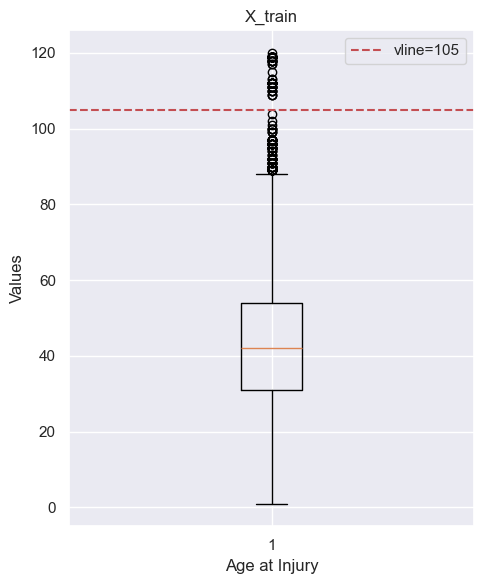

In [262]:
def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['Age at Injury'],
    titles=['X_train'],
    vertical_lines=[105]
)

In [263]:
print(f"X_train: {len(detect_outliers_ages(X_train, "Age at Injury"))} outliers")
print(f"X_val: {len(detect_outliers_ages(X_val, "Age at Injury"))} outliers")
print(f"X_test: {len(detect_outliers_ages(df_test, "Age at Injury"))} outliers")

X_train: 14499 outliers
X_val: 4720 outliers
X_test: 13944 outliers


In [264]:
winsorize_ages(X_train, X_train, "Age at Injury")
winsorize_ages(X_train, X_val, "Age at Injury")
winsorize_ages(X_train, X_test, "Age at Injury")

### Average Weekly Wage

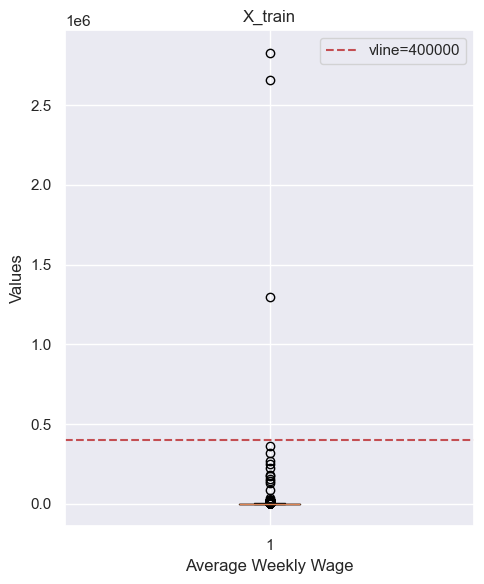

In [265]:
def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['Average Weekly Wage'],
    titles=['X_train'],
    vertical_lines=[400000]
)

In [266]:
def detect_outliers_wages(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 400000
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [267]:
def winsorize_wages(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 400000
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [268]:
print(f"X_train: {len(detect_outliers_wages(X_train, "Average Weekly Wage"))} outliers")
print(f"X_val: {len(detect_outliers_wages(X_val, "Average Weekly Wage"))} outliers")
print(f"X_test: {len(detect_outliers_wages(df_test, "Average Weekly Wage"))} outliers")

X_train: 3 outliers
X_val: 2 outliers
X_test: 2 outliers


In [269]:
winsorize_wages(X_train, X_train, "Average Weekly Wage")
winsorize_wages(X_train, X_val, "Average Weekly Wage")
winsorize_wages(X_train, X_test, "Average Weekly Wage")

### days_to_c2

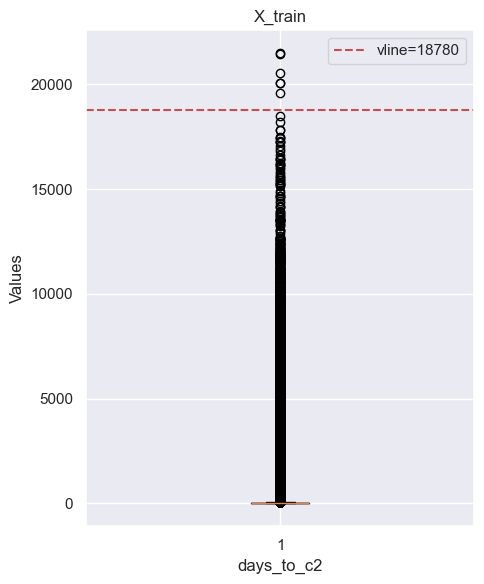

In [270]:
def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['days_to_c2'],
    titles=['X_train'],
    vertical_lines=[18780]
)

In [271]:
def detect_outliers_days_c2(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18780
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [272]:
def winsorize_c2(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18780
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [273]:
print(f"X_train: {len(detect_outliers_days_c2(X_train, "days_to_c2"))} outliers")
print(f"X_val: {len(detect_outliers_days_c2(X_val, "days_to_c2"))} outliers")
print(f"X_test: {len(detect_outliers_days_c2(df_test, "days_to_c2"))} outliers")

X_train: 14643 outliers
X_val: 4845 outliers
X_test: 12187 outliers


In [274]:
winsorize_c2(X_train, X_train, "days_to_c2")
winsorize_c2(X_train, X_val, "days_to_c2")
winsorize_c2(X_train, X_test, "days_to_c2")

### days_accident_to_assembly

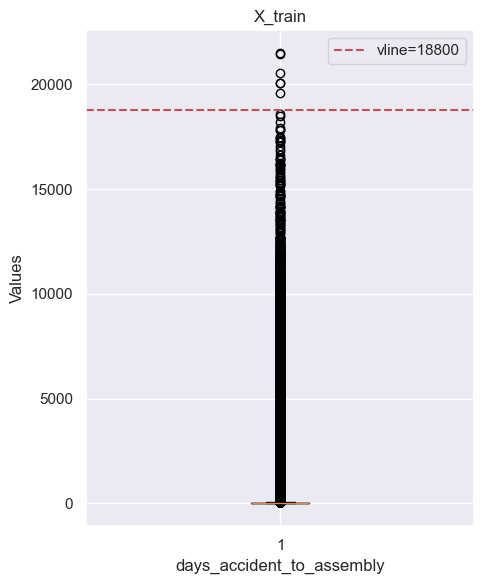

In [275]:
def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['days_accident_to_assembly'],
    titles=['X_train'],
    vertical_lines=[18800]
)

In [276]:
def detect_outliers_days_assembly(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18800
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [277]:
def winsorize_assembly(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18800
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [278]:
print(f"X_train: {len(detect_outliers_days_assembly(X_train, "days_accident_to_assembly"))} outliers")
print(f"X_val: {len(detect_outliers_days_assembly(X_val, "days_accident_to_assembly"))} outliers")
print(f"X_test: {len(detect_outliers_days_assembly(df_test, "days_accident_to_assembly"))} outliers")

X_train: 18188 outliers
X_val: 6236 outliers
X_test: 18834 outliers


In [279]:
winsorize_assembly(X_train, X_train, "days_accident_to_assembly")
winsorize_assembly(X_train, X_val, "days_accident_to_assembly")
winsorize_assembly(X_train, X_test, "days_accident_to_assembly")

### "Log" variables

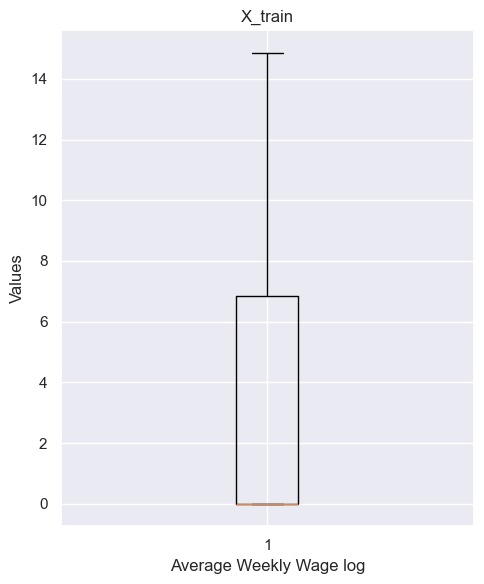

In [280]:
def plot_boxplots(dfs, columns, titles):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title) in enumerate(zip(dfs, columns, titles)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.set_title(title)
        ax.set_xlabel(column)
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['Average Weekly Wage log'],
    titles=['X_train']
)

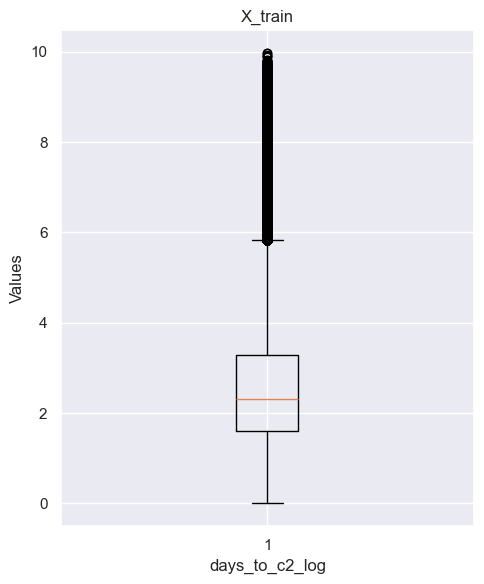

In [281]:
def plot_boxplots(dfs, columns, titles):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title) in enumerate(zip(dfs, columns, titles)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.set_title(title)
        ax.set_xlabel(column)
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['days_to_c2_log'],
    titles=['X_train']
)

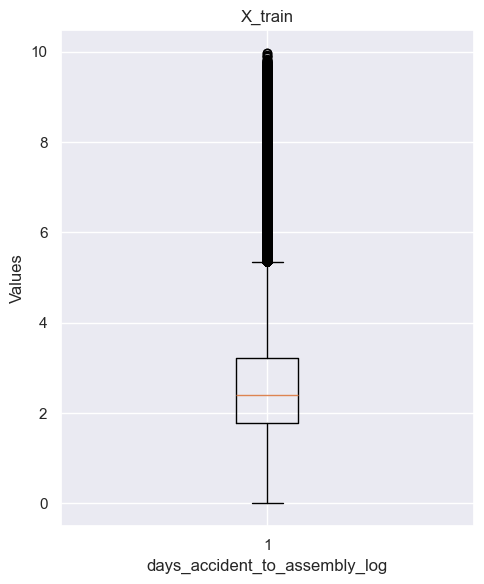

In [282]:
def plot_boxplots(dfs, columns, titles):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title) in enumerate(zip(dfs, columns, titles)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.set_title(title)
        ax.set_xlabel(column)
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

plot_boxplots(
    dfs=[X_train],
    columns=['days_accident_to_assembly_log'],
    titles=['X_train']
)

In [283]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387975 entries, 6165911 to 6553594
Data columns (total 45 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Accident Date                      387975 non-null  datetime64[ns]
 1   Age at Injury                      387975 non-null  Int64         
 2   Alternative Dispute Resolution     387975 non-null  object        
 3   Assembly Date                      387975 non-null  datetime64[ns]
 4   Attorney/Representative            387975 non-null  object        
 5   Average Weekly Wage                387975 non-null  float64       
 6   C-2 Date                           387975 non-null  datetime64[ns]
 7   Carrier Type                       387975 non-null  object        
 8   County of Injury                   387975 non-null  object        
 9   COVID-19 Indicator                 387975 non-null  object        
 10  District Name     

## Last changes

Some last changes are made to the data to ensure it is ready for feature selection.

In [284]:
X_train = X_train.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_train['days_accident_to_assembly'] = X_train['days_accident_to_assembly'].astype(int)

In [285]:
X_val = X_val.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_val['days_accident_to_assembly'] = X_val['days_accident_to_assembly'].astype(int)

In [286]:
X_test = X_test.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_test['days_accident_to_assembly'] = X_test['days_accident_to_assembly'].astype(int)

## Splitting the Data for Agreement Reached

For the open-ended section, the group chose to create a model that predict other variable: Agreement Reached. For this purpose, it is necessary to separate the secondary target variable from the other variables.

In [287]:
y_train_ar = X_train['Agreement Reached']
X_train_ar = X_train.copy()
X_train_ar = X_train_ar.drop(columns=['Agreement Reached'])

In [288]:
y_val_ar = X_val['Agreement Reached']
X_val_ar = X_val.copy()
X_val_ar = X_val_ar.drop(columns=['Agreement Reached'])

In [289]:
#this cell was used as a checkpoint so the group could avoid running the whole notebook when working
X_train.to_csv('X_train_v1.csv', index=True)
X_val.to_csv('X_val_v1.csv', index=True)
X_test.to_csv('X_test_v1.csv', index=True)
y_train.to_csv('y_train_v1.csv', index=True, header=True)
y_val.to_csv('y_val_v1.csv', index=True, header=True)

X_train_ar.to_csv('X_train_ar_v1.csv', index=True)
X_val_ar.to_csv('X_val_ar_v1.csv', index=True)
y_train_ar.to_csv('y_train_ar_v1.csv', index=True, header=True)
y_val_ar.to_csv('y_val_ar_v1.csv', index=True, header=True)

In [290]:
#this cell was used as a checkpoint so the group could avoid running the whole notebook when working
X_train = pd.read_csv('X_train_v1.csv', index_col=0)
X_val = pd.read_csv('X_val_v1.csv',  index_col=0)
X_test = pd.read_csv('X_test_v1.csv', index_col=0)
y_train = pd.read_csv('y_train_v1.csv', index_col=0)
y_val = pd.read_csv('y_val_v1.csv', index_col=0)

X_train_ar = pd.read_csv('X_train_ar_v1.csv', index_col=0)
X_val_ar = pd.read_csv('X_val_ar_v1.csv', index_col=0)
y_train_ar = pd.read_csv('y_train_ar_v1.csv', index_col=0)
y_val_ar = pd.read_csv('y_val_ar_v1.csv', index_col=0)


# y_train.set_index('Claim Identifier', inplace=True)
# y_val.set_index('Claim Identifier', inplace=True)
# y_train_ar.set_index('Claim Identifier', inplace=True)
# y_val_ar.set_index('Claim Identifier', inplace=True)

In [291]:
y_train_ar.head()

Agreement Reached
Claim Identifier                  
5562417                Not Reached
5984379                Not Reached
5903110                Not Reached
6160670                Not Reached
5986791                Not Reached

## Encoding

### Binary Encoding

Binary Variables do not require too much work to be encoded. In this case, the group decided to turn No to 0 and Yes to 1.

In [292]:
binary_features = ['Attorney/Representative', 'COVID-19 Indicator']
for feature in binary_features:
    X_train[feature] = X_train[feature].map({'No': 0, 'Yes': 1}).astype(int)
    X_val[feature] = X_val[feature].map({'No': 0, 'Yes': 1}).astype(int)
    X_test[feature] = X_test[feature].map({'N': 0, 'Y': 1}).astype(int)

X_train['Gender'] = X_train['Gender'].map({'F': 0, 'M': 1}).astype(int)
X_val['Gender'] = X_val['Gender'].map({'F': 0, 'M': 1}).astype(int)
X_test['Gender'] = X_test['Gender'].map({'F': 0, 'M': 1}).astype(int)

X_train['Agreement Reached'] = X_train['Agreement Reached'].map({'Not Reached': 0, 'Reached': 1}).astype(int)
X_val['Agreement Reached'] = X_val['Agreement Reached'].map({'Not Reached': 0, 'Reached': 1}).astype(int)

In [293]:
binary_features = ['Attorney/Representative', 'COVID-19 Indicator']
for feature in binary_features:
    X_train_ar[feature] = X_train_ar[feature].map({'No': 0, 'Yes': 1}).astype(int)
    X_val_ar[feature] = X_val_ar[feature].map({'No': 0, 'Yes': 1}).astype(int)

X_train_ar['Gender'] = X_train_ar['Gender'].map({'F': 0, 'M': 1}).astype(int)
X_val_ar['Gender'] = X_val_ar['Gender'].map({'F': 0, 'M': 1}).astype(int)

y_train_ar = y_train_ar['Agreement Reached'].map({'Not Reached': 0, 'Reached': 1}).astype(int)
y_val_ar = y_val_ar['Agreement Reached'].map({'Not Reached': 0, 'Reached': 1}).astype(int)

During the process of creating a final model and trying to obtain the best score possible in Kaggle, the group tried several encoding techniques. Two techniques were chosen as the best ones.

### Count Encoding
The first method the group settled on was count encoding. In this method, categorical variables are substituted by their respective frequency count. This encoding method is simplistic, which makes it easy to use. However, it comes with some disadvantages. Its biggest flaw is the following:<br>
If a variable 'A' has 3 possible values, let´s say 'red', 'green' and 'blue'. If 2 of the values are equally represented in the variable (as in they have the same encoded representation) then the encoding will 'delete' one of the values. This happens because the encoding for each value is the same, this type of error is called collision.

References: <br>
https://towardsdatascience.com/4-ways-to-encode-categorical-features-with-high-cardinality-1bc6d8fd7b13#99d8

In [294]:
X_test.drop(columns=['Alternative Dispute Resolution'], inplace=True)

In [295]:
y_train

claim_injury_num
Claim Identifier                  
5562417                          2
5984379                          2
5903110                          2
6160670                          2
5986791                          2
...                            ...
5621711                          3
6112869                          3
5811991                          4
5520483                          5
5678694                          2

[430519 rows x 1 columns]

In [296]:
X_train.head()

Age at Injury  Attorney/Representative  Average Weekly Wage  \
Claim Identifier                                                                
5562417                      59                        0             0.000000   
5984379                      44                        0             0.000000   
5903110                      38                        0          1056.871276   
6160670                      55                        0           826.087078   
5986791                      39                        0             0.000000   

                     Carrier Type  COVID-19 Indicator District Name  Gender  \
Claim Identifier                                                              
5562417               SELF-PUBLIC                   0      SYRACUSE       1   
5984379                   PRIVATE                   0           NYC       0   
5903110           STATE INSURANCE                   0      SYRACUSE       0   
6160670                   PRIVATE                   0           NYC       0   
5986791           STATE INSURANCE                   0      SYRACUSE       1   

                  IME-4 Count          Industry Code Description  \
Claim Identifier                                                   
5562417                     0               EDUCATIONAL SERVICES   
5984379                     0  HEALTH CARE AND SOCIAL ASSISTANCE   
5903110                     0               EDUCATIONAL SERVICES   
6160670                     0                       RETAIL TRADE   
5986791                     0              PUBLIC ADMINISTRATION   

                 Medical Fee Region  ... ais_weights  severity SS       ASS  \
Claim Identifier                     ...                                      
5562417                           I  ...        4.80  Moderate  2  0.158665   
5984379                          IV  ...        4.18  Moderate  2  0.122365   
5903110                           I  ...        5.65     Minor  1  0.043033   
6160670                          IV  ...        5.65  Moderate  2  0.208431   
5986791                           I  ...        0.00  Moderate  2  0.500000   

                       DRS                   industry_new       IRS  \
Claim Identifier                                                      
5562417           0.300469  Education and health services  0.170204   
5984379           0.261659  Education and health services  0.170204   
5903110           0.176839  Education and health services  0.170204   
6160670           0.353678                   Retail trade  0.178456   
5986791           0.000000                     Government  0.272830   

                 days_to_c2_log days_accident_to_assembly_log  \
Claim Identifier                                                
5562417                1.791759                      1.791759   
5984379                1.386294                      1.386294   
5903110                6.238325                      6.238325   
6160670                2.079442                      2.079442   
5986791                1.386294                      1.386294   

                 Average Weekly Wage log  
Claim Identifier                          
5562417                         0.000000  
5984379                         0.000000  
5903110                         6.964014  
6160670                         6.717910  
5986791                         0.000000  

[5 rows x 40 columns]

In [297]:
categorical_features = ['Carrier Type', 'District Name', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'age_group', 'wage_groups', 'body_group', 'injury_type', 'injury_cause',
                        'industry_group', 'days_accident_to_assembly_binned', 'zip_group','days_to_c2_binned', 'body_region', 'AIS', 'severity', 'industry_new']

enc = CountEncoder(cols=categorical_features).fit(X_train, y_train)
enc_ar = CountEncoder(cols=categorical_features).fit(X_train_ar, y_train_ar)
X_train_encoded = enc.transform(X_train)
X_val_encoded = enc.transform(X_val)
X_train_encoded_ar = enc_ar.transform(X_train_ar)
X_val_encoded_ar = enc_ar.transform(X_val_ar)
X_test_encoded = enc_ar.transform(X_test)

### Hashing
After trying with the Count Encoder, the group wondered if there was a method that might yield better results. Standard techniques such as dummy variables or one-hot encoding were tested, but the results weren’t compelling. Eventually, through research, a new method was discovered: the 'Hashing Trick'.<br>
This encoding technique (also available in the category_encoders package) maps data of arbitrary size to a fixed size. In simple terms, the hashing function assigns specific numbers to each item it receives. The number itself is not important; what matters is that the assignment is consistent.<br>
The function takes a parameter, 'n_components' which defines the number of columns, or 'lockers'. Like the Count Encoder, the hashing function can result in collisions (when two different categories receive the same value). Increasing this parameter reduces collisions but also increases the sparsity of the data. The final value of 64 was chosen after several iterations in a trial-and-error process.



References:<br>
https://stats.stackexchange.com/questions/411767/encoding-of-categorical-variables-with-high-cardinality<br>
https://contrib.scikit-learn.org/category_encoders/hashing.html<br>
https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f

In [298]:
# X_test.drop(columns=['Alternative Dispute Resolution'], inplace=True)

In [299]:
# categorical_features = ['Carrier Type', 'District Name', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description',
#                         'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'age_group', 'wage_groups', 'body_group', 'injury_type', 'injury_cause',
#                         'industry_group', 'days_accident_to_assembly_binned', 'zip_group','days_to_c2_binned', 'body_region', 'AIS', 'severity', 'industry_new']

# encoder = ce.HashingEncoder(cols=categorical_features, n_components=64)

# X_train_encoded = encoder.fit_transform(X_train)
# X_val_encoded = encoder.transform(X_val)
# X_test_encoded = encoder.transform(X_test)

Making sure the columns are in the correct order so the scaler can funtion properly.

In [300]:
# dfs = [X_train_encoded, X_val_encoded, X_test_encoded]
# for df in dfs:
#     df.drop(columns=['body_region', 'AIS', 'severity', 'industry_new'], inplace=True)


## Scaling

In [301]:
features_to_scale = ['Age at Injury', 'Average Weekly Wage', 'Carrier Type', 'District Name',
                    'Industry Code Description', 'Medical Fee Region',
                    'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description',
                    'Number of Dependents', 'age_group', 'wage_groups', 'days_to_c2', 'days_to_c2_binned',
                    'body_group', 'injury_type', 'injury_cause', 'industry_group', 'zip_group',
                    'days_accident_to_assembly', 'days_accident_to_assembly_binned', 'ASS', 'SS', 'ais_weights', 'IRS', 'AIS',
                    'severity', 'industry_new', 'body_region',
                    'IME-4 Count', 'days_to_c2_log', 'days_accident_to_assembly_log', 'Average Weekly Wage log']

#features_to_scale = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'days_to_c2', 'days_accident_to_assembly', 'ais_weights', 'SS', 'ASS', 'IRS']

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train_encoded[features_to_scale] = scaler.fit_transform(X_train_encoded[features_to_scale])

X_val_encoded[features_to_scale] = scaler.transform(X_val_encoded[features_to_scale])
X_test_encoded[features_to_scale] = scaler.transform(X_test_encoded[features_to_scale])

X_train_scaled = X_train_encoded
X_val_scaled = X_val_encoded
X_test_scaled = X_test_encoded

In [302]:
# Agreement Reached
X_train_encoded_ar[features_to_scale] = scaler.fit_transform(X_train_encoded_ar[features_to_scale])
X_val_encoded_ar[features_to_scale] = scaler.transform(X_val_encoded_ar[features_to_scale])

X_train_scaled_ar = X_train_encoded_ar
X_val_scaled_ar = X_val_encoded_ar

## Resampling

In [303]:
print("Original class distribution:", Counter(y_train['claim_injury_num']))

Original class distribution: Counter({2: 218308, 4: 111380, 3: 51679, 5: 36210, 1: 9358, 6: 3158, 8: 353, 7: 73})


### SMOTE

In [304]:

desired_samples = {1: 9358, 2: 218308, 3: 51679, 4: 111380, 5: 36210, 6: 10000, 7: 2500, 8: 5000}

smote = SMOTE(sampling_strategy=desired_samples, random_state=13)

X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)


print(Counter(y_resampled['claim_injury_num']))

Counter({2: 218308, 4: 111380, 3: 51679, 5: 36210, 6: 10000, 1: 9358, 8: 5000, 7: 2500})


In [305]:
#this cell was used as a checkpoint so the group could avoid running the whole notebook when working
X_resampled.to_csv('X_resampled.csv', index=True)
X_val_scaled.to_csv('X_val_scaled.csv', index=True)
X_test_scaled.to_csv('X_test_scaled.csv', index=True)
y_resampled.to_csv('y_resampled.csv', index=True, header=True)
y_val.to_csv('y_val_v2.csv', index=True, header=True)

In [306]:
#this cell was used as a checkpoint so the group could avoid running the whole notebook when working
X_resampled = pd.read_csv('X_resampled.csv', index_col=0)
X_val_scaled = pd.read_csv('X_val_scaled.csv', index_col=0)
X_test_scaled = pd.read_csv('X_test_scaled.csv', index_col=0)
y_resampled = pd.read_csv('y_resampled.csv', index_col=0).squeeze()
y_val = pd.read_csv('y_val_v2.csv', index_col=0).squeeze()

## Resampling for Agreement Reached

### Borderline-SMOTE


In [307]:
bsmote = BorderlineSMOTE(random_state=13)
X_train_ar_resampling, y_train_ar_resampling = bsmote.fit_resample(X_train_scaled_ar, y_train_ar)

In [308]:
# y_train_ar.value_counts()

In [309]:
# y_train_ar_resampling.value_counts()

In [310]:
X_train_scaled_ar = X_train_ar_resampling 
y_train_ar = y_train_ar_resampling

# Feature Selection

## Filter Methods

Filter methods identify the most important features by applying statistical measures to evaluate their correlation to the target variable. They are simple, fast, and can be applied before the modeling stage, which makes them a good starting point for feature selection. Indeed, they were crucial in the selection of features for the first models the group obtained (like in the case of the decision trees using the count encoder).

The group decided to use Spearman's correlation coefficient because, in comparison to Pearson's, Spearman's correlation offers better results when data is non-linear or does not follow a normal distribution. The idea is that very highly correlated variables should be removed, as they're adding redundancy to the model without offering new information and that variables highly correlated to the target should be the most explanatory.

### 1) Correlations

Some features are highly correlated to each other and will result in duplication of information. In order to avoid redundancy, these highly correlated features were identified and removed in advance.

Highly correlated variables were identified using a threshold of 0.80. For correlations higher than this threshold, the group decided to drop one feature from each pair of correlated variables.

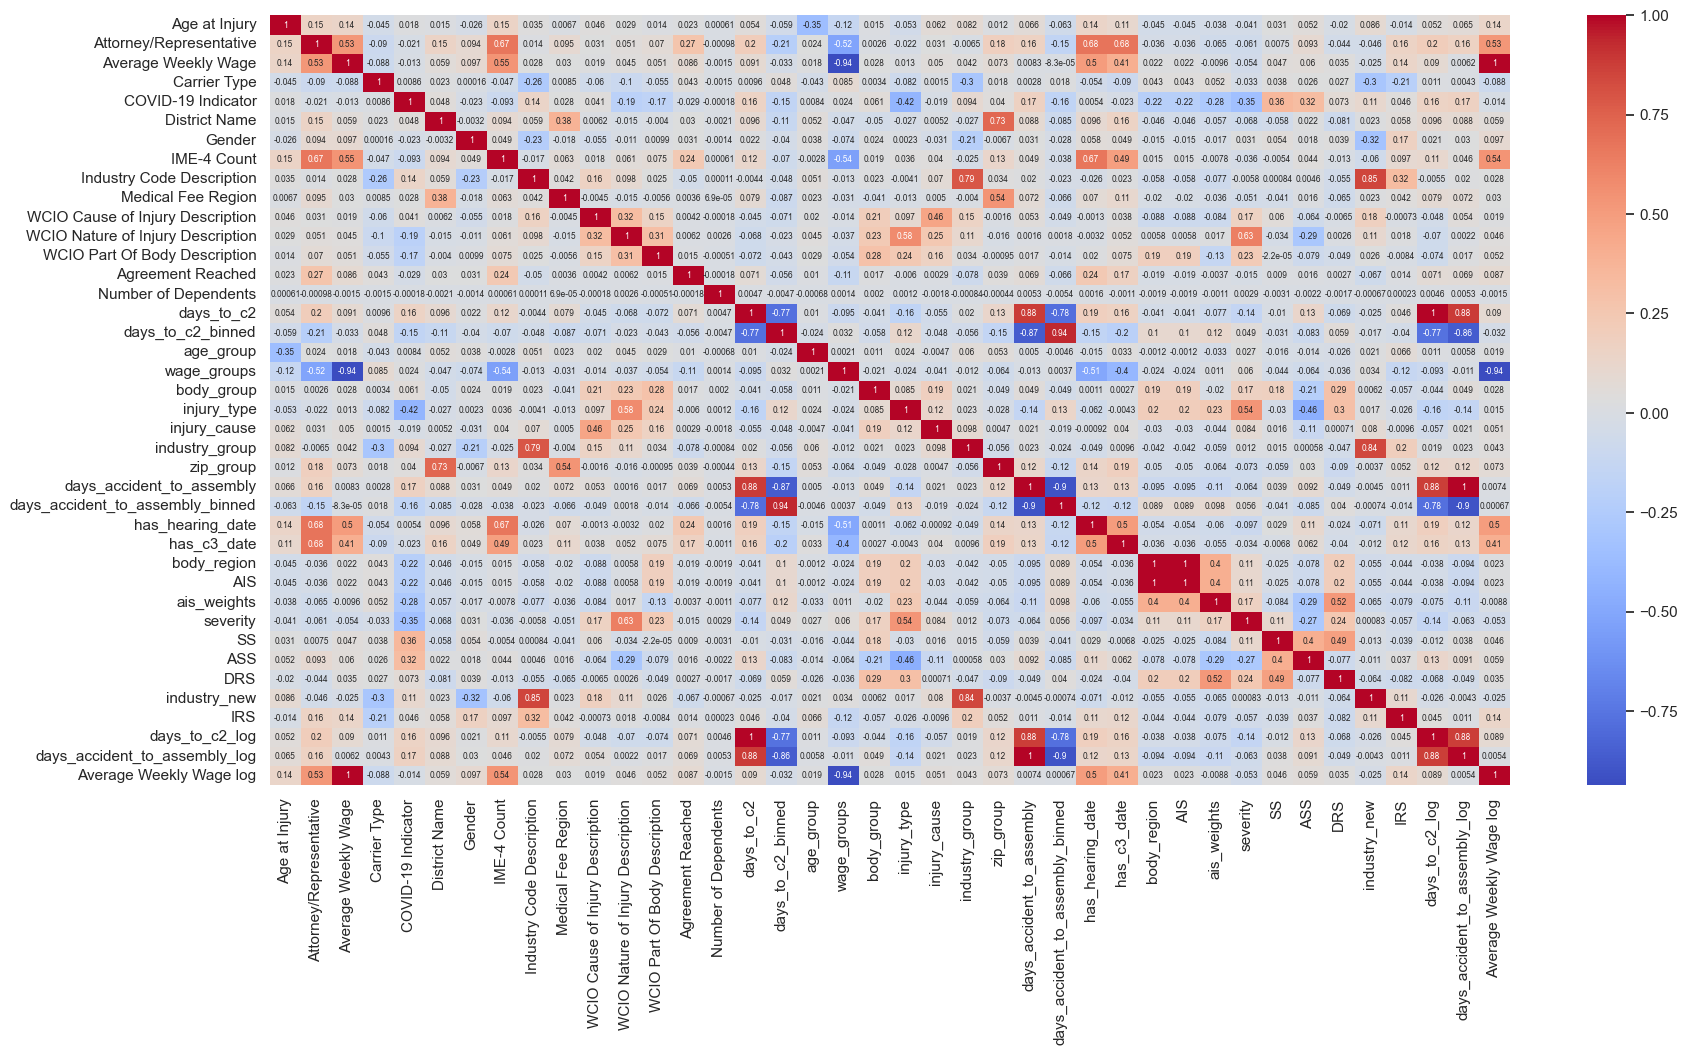

In [311]:
corr = X_resampled.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.show()

In [312]:
cor_spearman = X_resampled.corr(method ='spearman')
for i in range(len(cor_spearman.columns)):
    for j in range(i):
        if abs(cor_spearman.iloc[i, j]) > 0.80:
            print(f"The columns: {cor_spearman.columns[i]} & {cor_spearman.columns[j]} have a correlation of: {cor_spearman.iloc[i, j]} \n")

The columns: wage_groups & Average Weekly Wage have a correlation of: -0.9369888045283958 

The columns: days_accident_to_assembly & days_to_c2 have a correlation of: 0.880036363943986 

The columns: days_accident_to_assembly & days_to_c2_binned have a correlation of: -0.8656903135833861 

The columns: days_accident_to_assembly_binned & days_to_c2_binned have a correlation of: 0.9353247140533554 

The columns: days_accident_to_assembly_binned & days_accident_to_assembly have a correlation of: -0.9029520547979342 

The columns: AIS & body_region have a correlation of: 1.0 

The columns: industry_new & Industry Code Description have a correlation of: 0.8527323983699735 

The columns: industry_new & industry_group have a correlation of: 0.8446246457281145 

The columns: days_to_c2_log & days_to_c2 have a correlation of: 0.9992411286525906 

The columns: days_to_c2_log & days_accident_to_assembly have a correlation of: 0.8750438561113715 

The columns: days_accident_to_assembly_log & days_

After analyzing the correlation matrix, the group identified features that were highly correlated, making them redundant for the model. Therefore, these features were removed.

In [313]:
X_resampled.drop(columns=['wage_groups', 'Average Weekly Wage', 'industry_new', 'days_to_c2', 'days_accident_to_assembly', 'days_to_c2_binned', 'AIS', 
                          'days_accident_to_assembly_binned', 'body_region'], inplace=True)
X_val_scaled.drop(columns=['wage_groups', 'Average Weekly Wage', 'industry_new', 'days_to_c2', 'days_accident_to_assembly', 'days_to_c2_binned', 'AIS', 
                          'days_accident_to_assembly_binned', 'body_region'], inplace=True)
X_test_scaled.drop(columns=['wage_groups', 'Average Weekly Wage', 'industry_new', 'days_to_c2', 'days_to_c2_binned', 'AIS', 
                          'days_accident_to_assembly_binned', 'body_region'], inplace=True)

The two variables that were retained and showed a decline were `days_accident_to_assembly_log` and `days_to_c2_log`. The group decided to analyze them using other feature selection methods to determine which one to keep.

The variable `days_accident_to_assembly`was kept in X_test_scaled because it will be needed in the open ended section.

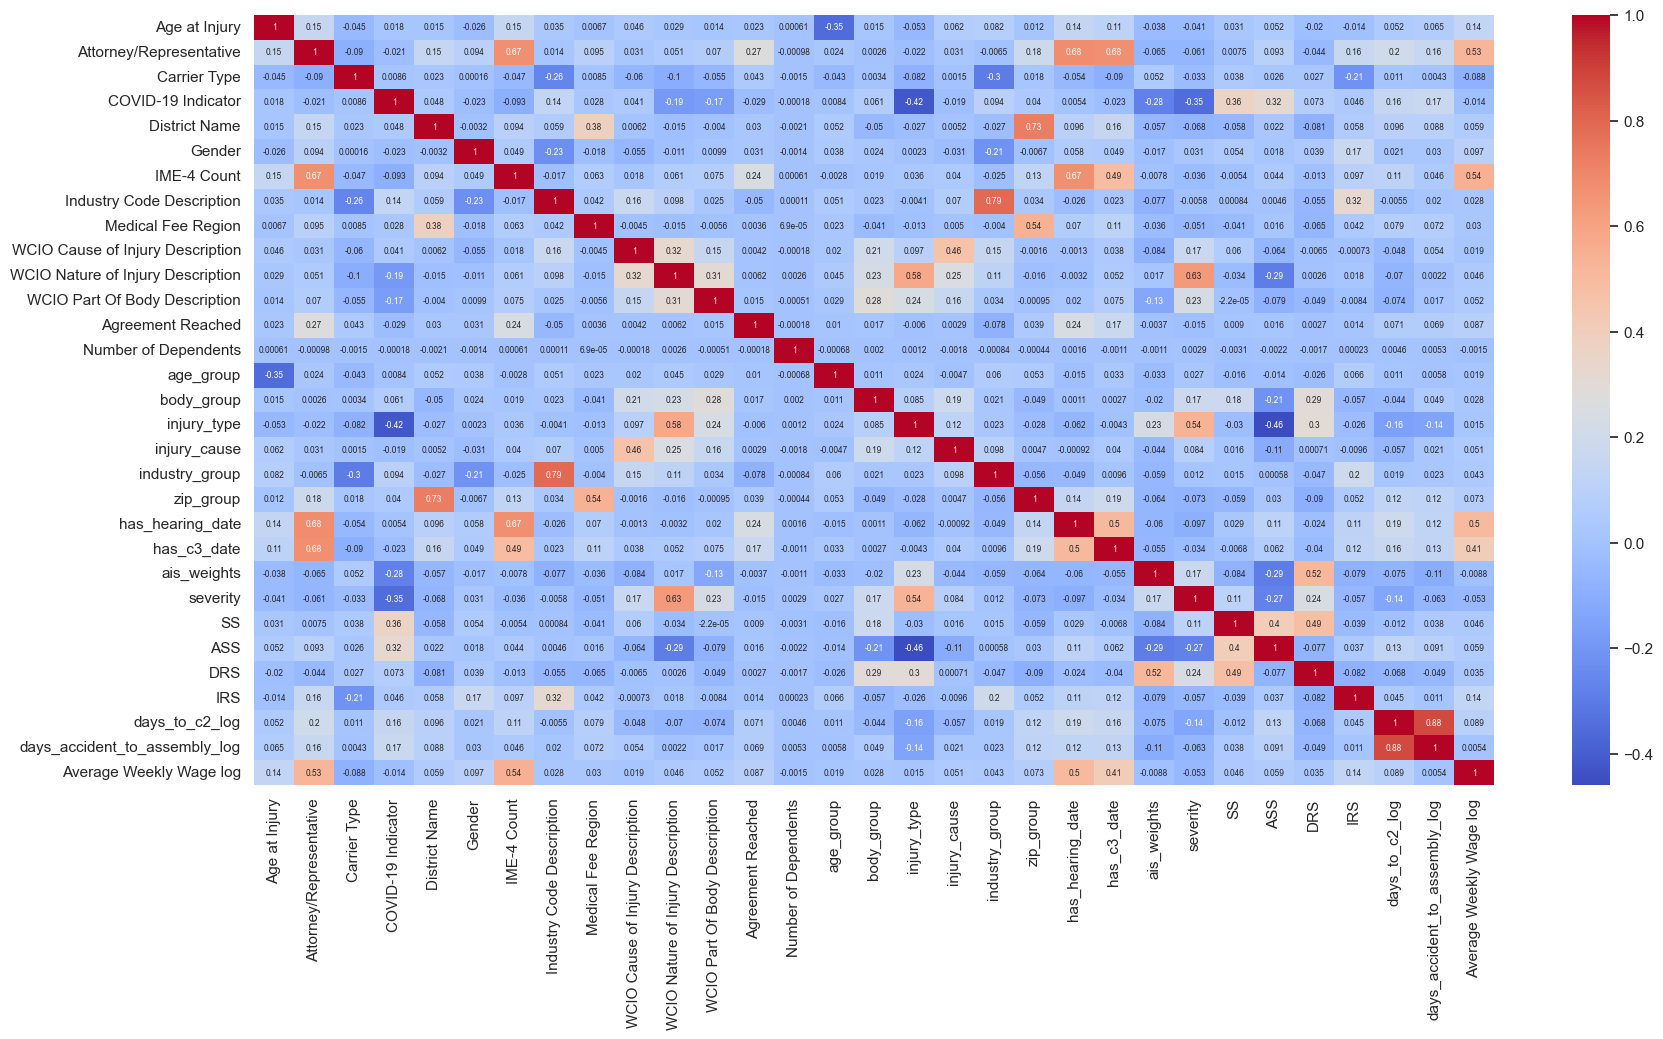

In [314]:
corr = X_resampled.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.show()

### 2) Variance

Variance was also used to identify any univariate variables and remove them. This was done because univariate variables don't offer any new information to the model.

In [315]:
pd.set_option('display.max_rows', None)
X_resampled.var().sort_values(ascending=False)

Gender                               0.240828
Attorney/Representative              0.223272
has_c3_date                          0.222041
has_hearing_date                     0.203998
District Name                        0.162816
injury_type                          0.147043
Medical Fee Region                   0.146740
WCIO Nature of Injury Description    0.138927
severity                             0.124524
body_group                           0.120034
zip_group                            0.111857
Number of Dependents                 0.110309
Carrier Type                         0.106075
ais_weights                          0.103481
Industry Code Description            0.103396
age_group                            0.101283
WCIO Part Of Body Description        0.088964
injury_cause                         0.085153
industry_group                       0.084119
WCIO Cause of Injury Description     0.075402
Average Weekly Wage log              0.054403
COVID-19 Indicator                

The threshold chosen for the variance was 0.10.

#### 3) ANOVA

In [316]:
f_values, p_values = f_classif(X_resampled, y_resampled)

anova_results = pd.DataFrame({'Feature': X_resampled.columns, 'F-Value': f_values, 'P-Value': p_values})

anova_results = anova_results.sort_values(by='F-Value', ascending=False)
print(anova_results)

                              Feature        F-Value        P-Value
30            Average Weekly Wage log  158911.800705   0.000000e+00
1             Attorney/Representative   43235.159143   0.000000e+00
20                   has_hearing_date   33956.271956   0.000000e+00
6                         IME-4 Count   23889.213957   0.000000e+00
21                        has_c3_date   19877.668408   0.000000e+00
12                  Agreement Reached    9175.022700   0.000000e+00
11      WCIO Part Of Body Description    2637.212372   0.000000e+00
29      days_accident_to_assembly_log    2602.152171   0.000000e+00
23                           severity    2474.493958   0.000000e+00
28                     days_to_c2_log    2457.923505   0.000000e+00
9    WCIO Cause of Injury Description    2291.640536   0.000000e+00
16                        injury_type    2200.839622   0.000000e+00
3                  COVID-19 Indicator    2038.423539   0.000000e+00
10  WCIO Nature of Injury Description    1908.50

In [317]:
features_anova = anova_results[anova_results['P-Value'] >= 0.05]['Feature']
features_anova

Series([], Name: Feature, dtype: object)

The group established a threshold for significance, considering features with a p-value lower than 0.05 as statistically significant. Variables with a p-value higher than this threshold were candidates to be dropped. In this case, only the "Number of Dependents" feature was a candidate.

### 4) Mutual Information

In [318]:
def calculate_mutual_information(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_scores_series

mi_scores = calculate_mutual_information(X_resampled, y_resampled)

print("Mutual Information Scores:")
print(mi_scores)

low_mi_features = mi_scores[mi_scores < 0.05].index.tolist()
print("\nFeatures with Low Mutual Information:")
print(low_mi_features)

Mutual Information Scores:
Average Weekly Wage log              0.528797
IME-4 Count                          0.300515
Attorney/Representative              0.230356
has_hearing_date                     0.197414
WCIO Cause of Injury Description     0.161400
WCIO Part Of Body Description        0.157258
days_to_c2_log                       0.149685
WCIO Nature of Injury Description    0.139064
has_c3_date                          0.130316
Age at Injury                        0.128296
days_accident_to_assembly_log        0.124471
ASS                                  0.113692
DRS                                  0.110367
Industry Code Description            0.109610
IRS                                  0.101928
injury_cause                         0.101141
Number of Dependents                 0.095843
ais_weights                          0.091405
severity                             0.083248
zip_group                            0.082950
Carrier Type                         0.078236
SS     

<Axes: title={'center': 'Mutual Information'}>

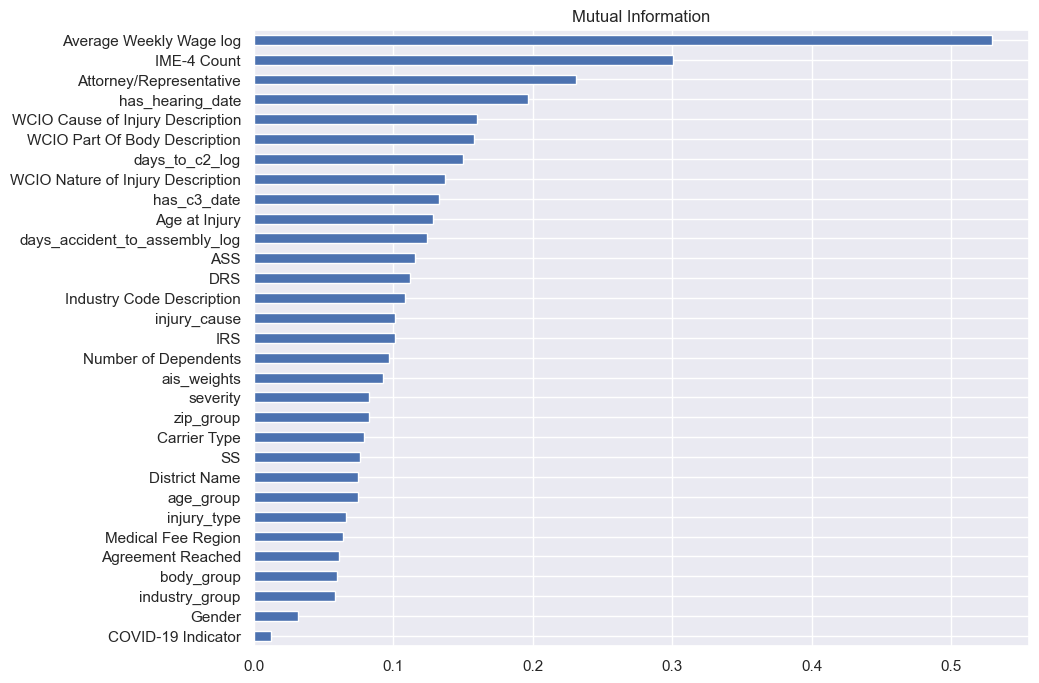

In [319]:
mi = mutual_info_classif(X_resampled, y_resampled)
mi = pd.Series(mi)
mi.index = X_resampled.columns
mi.sort_values(ascending=False)
mi.sort_values().plot(kind='barh', title = "Mutual Information", figsize=(10, 8))

The threshold chosen was 0.05.

## Wrapper Methods

### 5) RFE

In [320]:
#model = LogisticRegression(multi_class='ovr', solver='liblinear', penalty='l1', 
                           #class_weight='balanced', max_iter=100, random_state=42)

#rfe = RFE(estimator=model, n_features_to_select=15)

#rfe.fit(X_resampled, y_resampled)

#selected_features_rfe = X_resampled.columns[rfe.support_]
#print("Selected Features:", selected_features_rfe)

## Embedded Methods

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created, meaning that they integrate feature selection directly into the learning algorithm. The method the group chose was Lasso, a regression technique that works by reducing the coefficients of the least important features to zero. This means that it simultaneously indentifies those features and removes them from the model. The automatic feature selection that Lasso provides was the main reason to choose it over Ridge regression.

### 6) LASSO Regression

In [321]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [322]:
warnings.filterwarnings('ignore')

reg = LassoCV()
reg.fit(X_resampled, y_resampled)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_resampled, y_resampled))
coef = pd.Series(reg.coef_, index = X_resampled.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef.sort_values()

Best alpha using built-in LassoCV: 0.000369
Best score using built-in LassoCV: 0.666005
Lasso picked 28 variables and eliminated the other 3 variables


days_accident_to_assembly_log       -0.793070
has_c3_date                         -0.222629
severity                            -0.161833
WCIO Part Of Body Description       -0.120892
District Name                       -0.086732
WCIO Cause of Injury Description    -0.083472
age_group                           -0.071516
zip_group                           -0.068103
COVID-19 Indicator                  -0.065580
Carrier Type                        -0.054726
Medical Fee Region                  -0.016132
ASS                                 -0.006984
industry_group                       0.000000
Number of Dependents                 0.000000
Industry Code Description            0.000000
ais_weights                          0.001976
IRS                                  0.009192
injury_type                          0.010840
WCIO Nature of Injury Description    0.025233
body_group                           0.040860
Gender                               0.043096
injury_cause                      

In [323]:
lasso_drop = coef[coef == 0].index
lasso_drop

Index(['Industry Code Description', 'Number of Dependents', 'industry_group'], dtype='object')

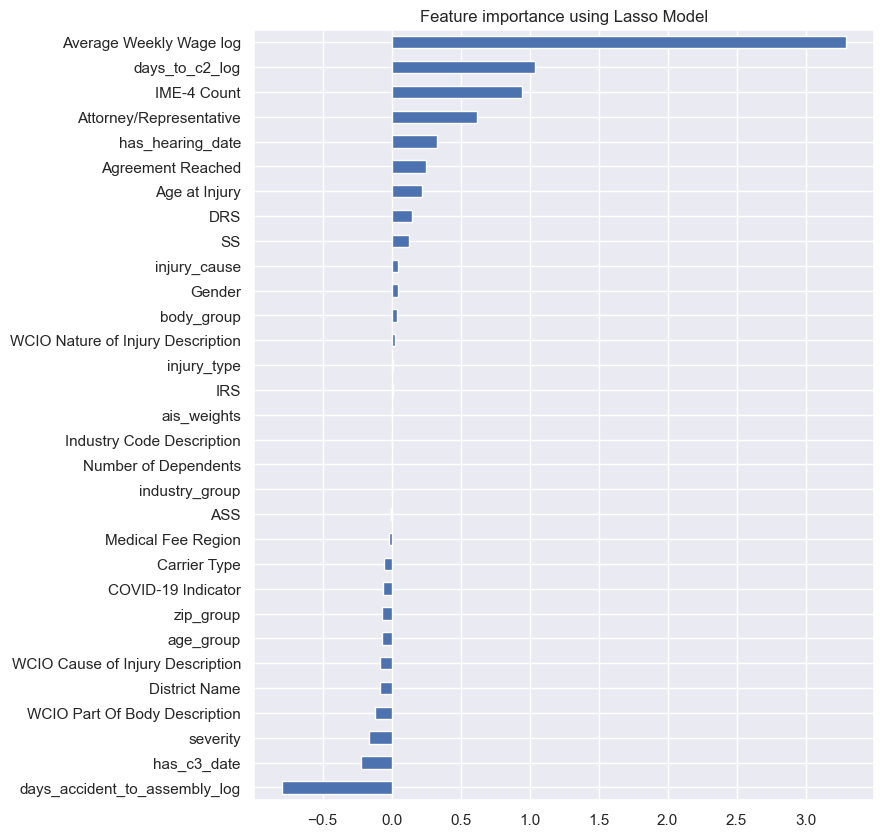

In [324]:
plot_importance(coef,'Lasso')

### 7) Random Forest

In [325]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)
rf.fit(X_resampled, y_resampled)
importances = rf.feature_importances_
rf_results = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(rf_results)

                              Feature  Importance
30            Average Weekly Wage log    0.258989
6                         IME-4 Count    0.063217
28                     days_to_c2_log    0.055630
0                       Age at Injury    0.049524
29      days_accident_to_assembly_log    0.049211
1             Attorney/Representative    0.047568
20                   has_hearing_date    0.039676
9    WCIO Cause of Injury Description    0.034328
12                  Agreement Reached    0.033959
13               Number of Dependents    0.032275
11      WCIO Part Of Body Description    0.031513
19                          zip_group    0.025677
7           Industry Code Description    0.024682
21                        has_c3_date    0.022677
27                                IRS    0.022649
17                       injury_cause    0.022043
2                        Carrier Type    0.019581
4                       District Name    0.019418
10  WCIO Nature of Injury Description    0.016719


The threshold chosen was 0.03.

### 8) Light GBM

In [326]:
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=13, importance_type='split', objective='multiclass', metric='multi_logloss', learning_rate=0.01)
lgb_clf.fit(X_resampled, y_resampled)
importances = lgb_clf.feature_importances_
lgb_results = pd.DataFrame({'Feature': X_resampled.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(lgb_results)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6146
[LightGBM] [Info] Number of data points in the train set: 444435, number of used features: 31
[LightGBM] [Info] Start training from score -3.860572
[LightGBM] [Info] Start training from score -0.710897
[LightGBM] [Info] Start training from score -2.151752
[LightGBM] [Info] Start training from score -1.383856
[LightGBM] [Info] Start training from score -2.507468
[LightGBM] [Info] Start training from score -3.794219
[LightGBM] [Info] Start training from score -5.180513
[LightGBM] [Info] Start training from score -4.487366
                              Feature  Importance
30            Average Weekly Wage log        3091
6                         IME-4 Co

### 9) XGBoost

In [327]:
y_train_adjusted = y_resampled - 1
y_val_adjusted = y_val - 1

model = XGBClassifier(objective='multi:softprob',  
    num_class=8,                
    n_estimators=100,
    random_state=13)
model.fit(X_resampled, y_train_adjusted)

xgb_importances = model.feature_importances_
xgb_df = pd.DataFrame({"Feature": X_resampled.columns, "Importance": xgb_importances})
xgb_df = xgb_df.sort_values(by="Importance", ascending=False)
print(xgb_df)

                              Feature  Importance
12                  Agreement Reached    0.287259
30            Average Weekly Wage log    0.210994
1             Attorney/Representative    0.110146
6                         IME-4 Count    0.049723
21                        has_c3_date    0.038957
20                   has_hearing_date    0.038352
22                        ais_weights    0.031737
3                  COVID-19 Indicator    0.025990
28                     days_to_c2_log    0.023887
23                           severity    0.023716
14                          age_group    0.015229
2                        Carrier Type    0.013253
15                         body_group    0.011003
18                     industry_group    0.010031
24                                 SS    0.009092
4                       District Name    0.008840
7           Industry Code Description    0.008653
27                                IRS    0.008541
16                        injury_type    0.007979


### Final List of Features

Based on the results of the feature selection methods, we decided to retain only the features listed in List 1. Although the variable `IRS` was shown to be dropped by some methods, it was kept due to its observed impact in the exploratory analysis. Regarding the variables `days_accident_to_assembly_log` and `days_to_c2_log`, we opted to keep `days_to_c2_log` instead of `days_accident_to_assembly_log` because it was retained by more feature selection methods and because the two variables were highly correlated. Finally, the group chose to keep `age_groups` instead of `Age at Injury` because age_groups is a more discrete variable, which is generally preferred in modeling for better interpretability and categorization.

In [328]:
list1 = ['Attorney/Representative', 'Average Weekly Wage log', 'has_c3_date', 'has_hearing_date',
         'IME-4 Count', 'ais_weights', 'WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
          'days_to_c2_log', 'age_group', 'IRS'
]

# Feature Selection - Agreement Reached

The methods chosen for feature selection were based on a logical progression through the different types of methods. First, filter methods were applied to evaluate the relationship between the features and the secondary target variable (Agreement Reached). After that, wrapper methods were used to evaluate feature subsets in conjunction with the model's training, allowing for the capture of interactions between the different features. Finally, embedded methods were used, combining feature selection and model training.


The group decided to choose Pearson to ensure the identification of linearly correlated features an mutual Information is used to capture non-linar relationships (they were missed by Pearson). RFE ensures the selected features perform well within the model and Lasso eliminates irrelevant features while improving model generalization.

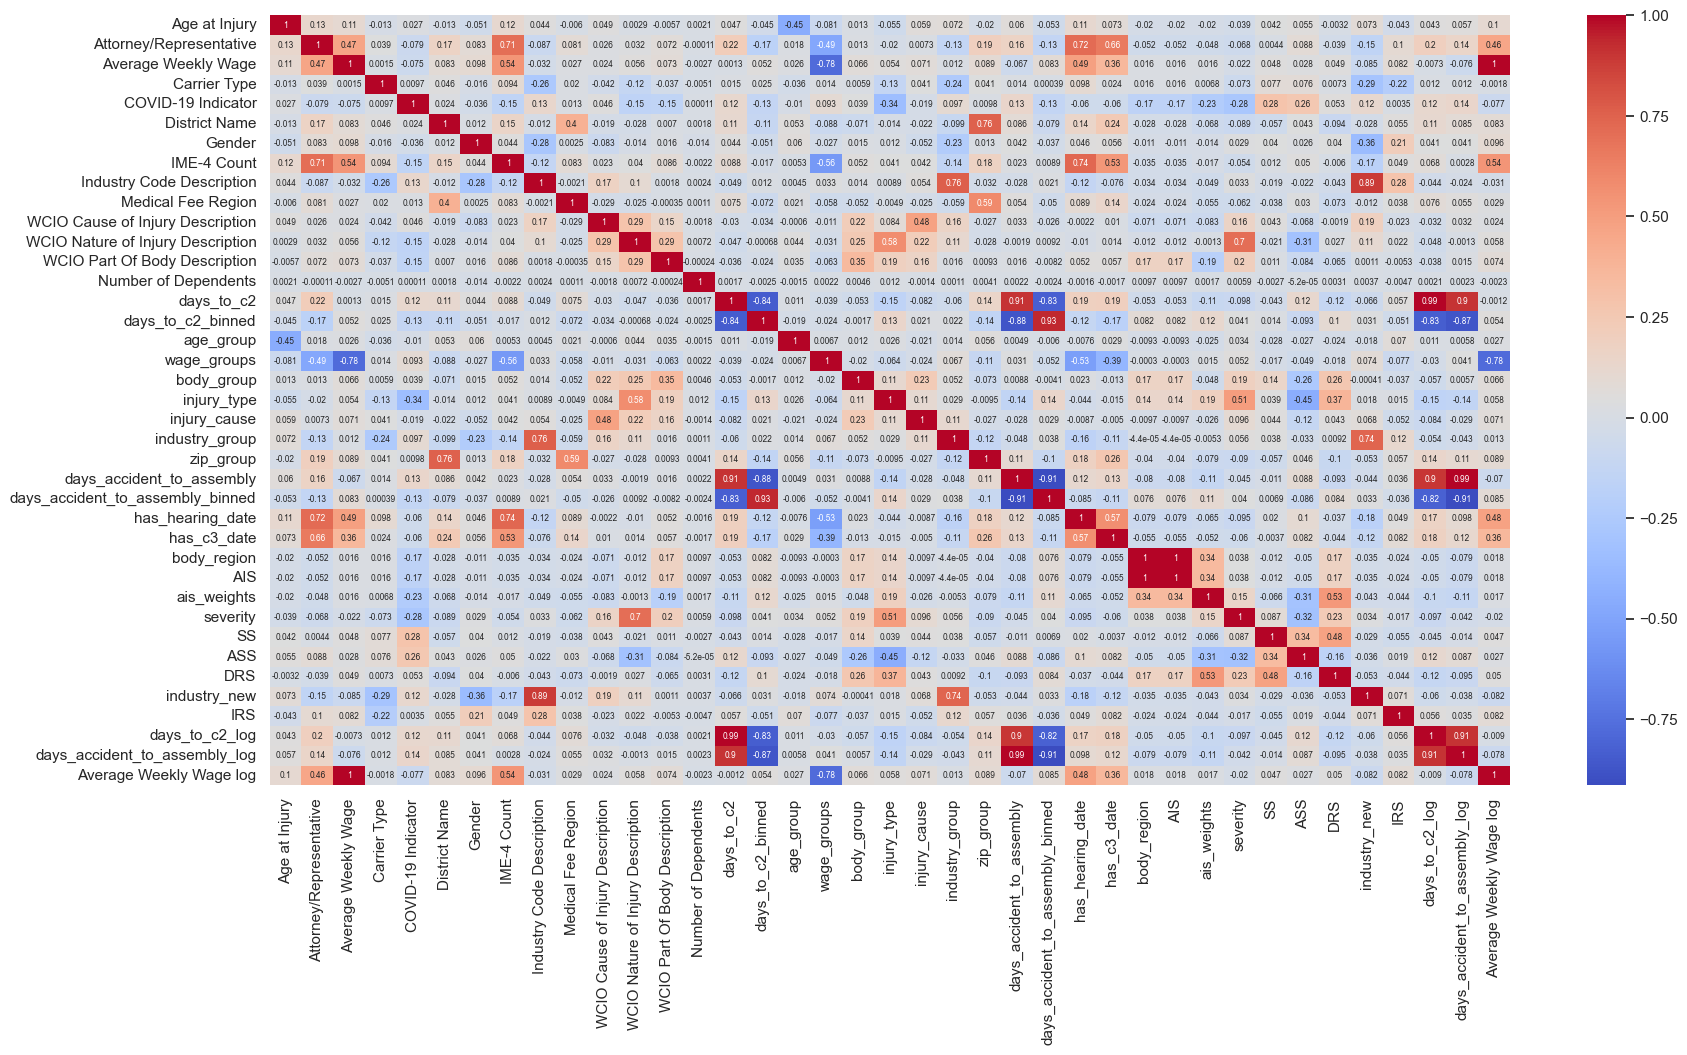

In [329]:
corr = X_train_scaled_ar.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.show()

After analyzing the correlation matrix, the group identified features that were highly correlated, making them redundant for the model. To decide what features to remove, the group identified, through the feature selection methods, the feature that had the higher score between the subset of features highly correlated.

In [330]:
X_train_scaled_ar.drop(columns=['Average Weekly Wage', 'wage_groups', 'Industry Code Description', 'industry_new', 'days_to_c2', 'days_to_c2_log', 'AIS',
                                'days_accident_to_assembly_log', 'days_accident_to_assembly_binned', 'age_group', 'body_group', 'WCIO Part Of Body Description', 
                                'injury_cause', 'WCIO Nature of Injury Description', 'SS', 'days_to_c2_binned'], inplace=True)
X_val_scaled_ar.drop(columns=['Average Weekly Wage', 'wage_groups', 'Industry Code Description', 'industry_new', 'days_to_c2', 'days_to_c2_log', 'AIS',
                                'days_accident_to_assembly_log', 'days_accident_to_assembly_binned', 'age_group', 'body_group', 'WCIO Part Of Body Description', 
                                'injury_cause', 'WCIO Nature of Injury Description', 'SS', 'days_to_c2_binned'], inplace=True)

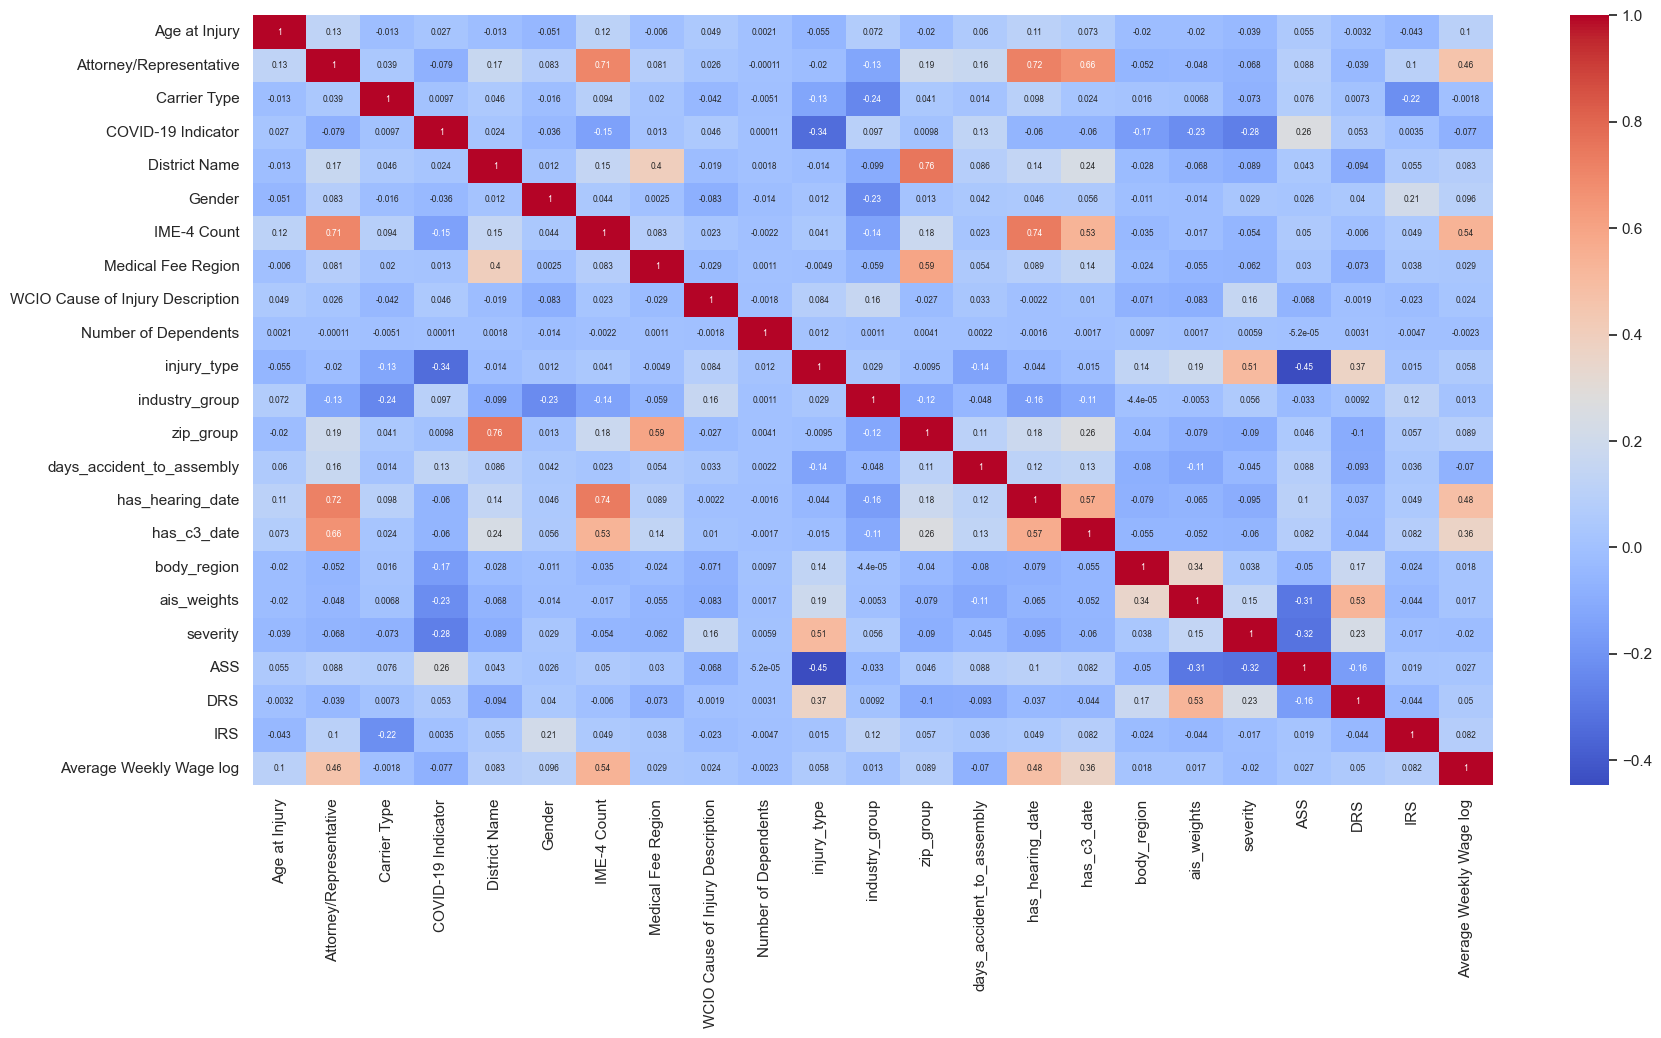

In [331]:
corr = X_train_scaled_ar.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.show()

## Filter Methods

#### ANOVA

ANOVA measures how well each feature separates the two classes of the target. The features with a p-value below 0.05 are considered significant.

In [332]:
f_scores, p_values = f_classif(X_train_scaled_ar, y_train_ar)

anova_df = pd.DataFrame({"Feature": X_train_scaled_ar.columns, "F-Value": f_scores, "P-value": p_values}).sort_values(by="F-Value", ascending=False)
print(anova_df)

                             Feature        F-Value        P-value
1            Attorney/Representative  773379.838482   0.000000e+00
14                  has_hearing_date  487710.633144   0.000000e+00
6                        IME-4 Count  222175.329989   0.000000e+00
15                       has_c3_date  216242.387335   0.000000e+00
22           Average Weekly Wage log  111782.069510   0.000000e+00
11                    industry_group   31995.613677   0.000000e+00
2                       Carrier Type   25656.755542   0.000000e+00
12                         zip_group   12558.856792   0.000000e+00
13         days_accident_to_assembly    8905.688611   0.000000e+00
4                      District Name    8100.373764   0.000000e+00
21                               IRS    6582.269953   0.000000e+00
3                 COVID-19 Indicator    6567.041946   0.000000e+00
18                          severity    4489.798281   0.000000e+00
0                      Age at Injury    4373.268724   0.000000

In [333]:
features_anova = anova_df[anova_df['P-value'] >= 0.05]['Feature']
features_anova

9                Number of Dependents
8    WCIO Cause of Injury Description
Name: Feature, dtype: object

The variables chosen to be removed were WCIO Cause of Injury Description and Number of Dependents because they have a p-value equal to or grather than 0.05.

#### Mutual Information

In [334]:
mutual_info = mutual_info_classif(X_train_scaled_ar, y_train_ar)

mutual_info_df = pd.DataFrame({"Feature": X_train_scaled_ar.columns, "Score": mutual_info}).sort_values(by="Score", ascending=False)

print(mutual_info_df)

                             Feature     Score
0                      Age at Injury  0.529449
13         days_accident_to_assembly  0.520492
6                        IME-4 Count  0.402654
8   WCIO Cause of Injury Description  0.396904
1            Attorney/Representative  0.384542
9               Number of Dependents  0.352672
14                  has_hearing_date  0.293085
12                         zip_group  0.257250
21                               IRS  0.247186
4                      District Name  0.202837
15                       has_c3_date  0.192218
7                 Medical Fee Region  0.174680
2                       Carrier Type  0.165538
11                    industry_group  0.164833
22           Average Weekly Wage log  0.154282
20                               DRS  0.117423
19                               ASS  0.116966
18                          severity  0.112864
16                       body_region  0.103641
10                       injury_type  0.101788
5            

For Mutual Information method, the threshold chosen was 0.3.

## Wrapper Methods

#### Recursive Feature Elimination
Due to computational costs, the group defined 15 features for RFE.

In [335]:
#model = LogisticRegression()

#rfe = RFE(estimator=model, n_features_to_select=15)

#rfe.fit(X_train_scaled_ar, y_train_ar)

#selected_features_rfe = X_train_scaled_ar.columns[rfe.support_]
#print("Selected Features:", selected_features_rfe)

## Embedded Methods

#### Random Forest

In [336]:
model = RandomForestClassifier()
model.fit(X_train_scaled_ar, y_train_ar)
feature_importances = pd.Series(model.feature_importances_, index=X_train_scaled_ar.columns)
print(feature_importances.sort_values(ascending=False))

Attorney/Representative             0.202635
IME-4 Count                         0.187509
has_hearing_date                    0.092946
Average Weekly Wage log             0.069416
days_accident_to_assembly           0.061415
Carrier Type                        0.055463
has_c3_date                         0.041893
industry_group                      0.037505
IRS                                 0.035675
Number of Dependents                0.030699
Age at Injury                       0.029349
WCIO Cause of Injury Description    0.024871
zip_group                           0.022881
District Name                       0.020702
Medical Fee Region                  0.015475
body_region                         0.012925
DRS                                 0.012894
severity                            0.012777
ASS                                 0.012760
ais_weights                         0.008900
injury_type                         0.005578
Gender                              0.005076
COVID-19 I

The threshold chosen for Random Forest was 0.05.

#### XGBOOST 

In [337]:
model = XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=13)
model.fit(X_train_scaled_ar, y_train_ar)

xgb_importances = model.feature_importances_
xgb_df = pd.DataFrame({"Feature": X_train_scaled_ar.columns, "Importance": xgb_importances})
xgb_df = xgb_df.sort_values(by="Importance", ascending=False)
print(xgb_df)

                             Feature  Importance
1            Attorney/Representative    0.625935
9               Number of Dependents    0.067722
6                        IME-4 Count    0.047906
2                       Carrier Type    0.043325
14                  has_hearing_date    0.028697
11                    industry_group    0.023413
22           Average Weekly Wage log    0.022296
13         days_accident_to_assembly    0.020551
15                       has_c3_date    0.019008
7                 Medical Fee Region    0.015664
4                      District Name    0.011947
12                         zip_group    0.011823
8   WCIO Cause of Injury Description    0.011227
17                       ais_weights    0.009380
21                               IRS    0.007931
18                          severity    0.007307
16                       body_region    0.006200
20                               DRS    0.006010
3                 COVID-19 Indicator    0.004125
0                   

The threshold choosen for XGBoost was 0.015.

# Modelation: Agreament Reached

In [338]:
features = ['Attorney/Representative', 'Carrier Type', 'days_accident_to_assembly', 'IME-4 Count']

features1 = ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage log', 'Carrier Type', 'days_accident_to_assembly', 'has_hearing_date', 'has_c3_date', 'IME-4 Count', 'industry_group', 'Medical Fee Region']

features2 = ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage log', 'Carrier Type', 'days_accident_to_assembly', 'has_hearing_date', 'has_c3_date', 'IME-4 Count']

## Logistic Regression

The first model that was tried to predict Agreement Reached was a logistic regression. This model was choosen as it works particularly well in binary classification, where the target has only 2 possible outcomes (Agreement Reached and Agreement Not Reached). However, the results of the model were not as good as expected, leading the group to explore others to improve predictive performance.

In [339]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]

model = LogisticRegression(random_state=13, max_iter=1000)
model.fit(X_train_selected, y_train_ar)
y_pred = model.predict(X_val_selected)

accuracy = accuracy_score(y_val_ar, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_ar, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)

print("Classification Report:\n", classification_report(y_val_ar, y_pred))

conf_matrix = confusion_matrix(y_val_ar, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7836830259151122
F1-Score (Weighted): 0.8449556560076362
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87    136801
           1       0.16      0.88      0.28      6706

    accuracy                           0.78    143507
   macro avg       0.58      0.83      0.57    143507
weighted avg       0.95      0.78      0.84    143507

Confusion Matrix:
 [[106547  30254]
 [   789   5917]]


In [340]:
f1_val = f1_score(y_val_ar, y_pred, average='weighted')
f1_train = f1_score(y_train_ar, model.predict(X_train_selected), average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

F1 Score (Train): 0.854350
F1 Score (Validation): 0.844956


In [341]:
clf = LogisticRegression(random_state=13, max_iter=1000)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

f1_scorer = make_scorer(f1_score, average='weighted')

cv_scores = cross_val_score(clf, X_train_scaled_ar[features1], y_train_ar, cv=cv, scoring=f1_scorer)

print("Cross-Validation F1 Scores:", cv_scores)
print(f"Mean F1 Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of F1 Scores: {cv_scores.std():.2f}")

Cross-Validation F1 Scores: [0.85322528 0.85563489 0.85315331 0.85560747 0.85373441]
Mean F1 Score: 0.85
Standard Deviation of F1 Scores: 0.00


##  Random Forest

The next model the group decided to test was Random Forest because it is capable of capturing non-linear relationships between the features and the target variable, which logistic regression cannot do effectively. The results of the model showed that it was overfitted, as it performed significantly better on the training set compared to the validation set, indicating poor generalization to unseen data. For this reason, the group decided to move into another model.

In [342]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]

model = RandomForestClassifier(random_state=13, class_weight='balanced')
model.fit(X_train_selected, y_train_ar)

y_pred = model.predict(X_val_selected)

accuracy = accuracy_score(y_val_ar, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_ar, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)

print("Classification Report:\n", classification_report(y_val_ar, y_pred))

conf_matrix = confusion_matrix(y_val_ar, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.937480401652881
F1-Score (Weighted): 0.9372660025495185
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97    136801
           1       0.33      0.32      0.33      6706

    accuracy                           0.94    143507
   macro avg       0.65      0.65      0.65    143507
weighted avg       0.94      0.94      0.94    143507

Confusion Matrix:
 [[132363   4438]
 [  4534   2172]]


In [343]:
f1_val = f1_score(y_val_ar, y_pred, average='weighted')
f1_train = f1_score(y_train_ar, model.predict(X_train_selected), average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

F1 Score (Train): 0.999179
F1 Score (Validation): 0.937266


##### ROC curve

AUC-ROC Score: 0.9069633770442912


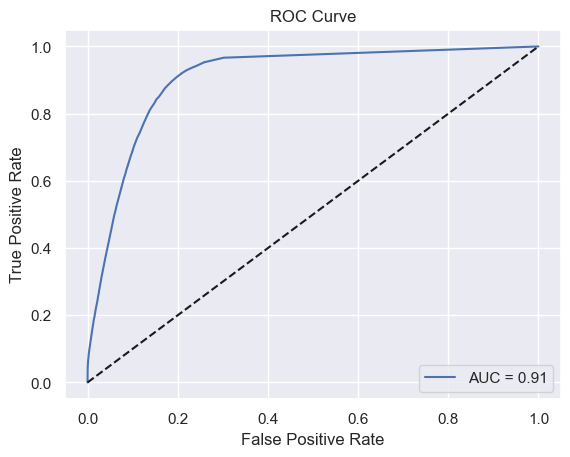

In [344]:
y_pred_proba = model.predict_proba(X_val_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_ar, y_pred_proba)
auc_score = roc_auc_score(y_val_ar, y_pred_proba)
print("AUC-ROC Score:", auc_score)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

#### Naive Bayes

In [345]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]

model = GaussianNB()

model.fit(X_train_selected, y_train_ar)

y_pred = model.predict(X_val_selected)

accuracy = accuracy_score(y_val_ar, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_ar, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)

print("Classification Report:\n", classification_report(y_val_ar, y_pred))

conf_matrix = confusion_matrix(y_val_ar, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7939264286759531
F1-Score (Weighted): 0.8515273248612131
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88    136801
           1       0.16      0.82      0.27      6706

    accuracy                           0.79    143507
   macro avg       0.58      0.80      0.58    143507
weighted avg       0.95      0.79      0.85    143507

Confusion Matrix:
 [[108460  28341]
 [  1232   5474]]


In [346]:
f1_val = f1_score(y_val_ar, y_pred, average='weighted')
f1_train = f1_score(y_train_ar, model.predict(X_train_selected), average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

F1 Score (Train): 0.832217
F1 Score (Validation): 0.851527


#### KNN

In [347]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]

model = KNeighborsClassifier(n_neighbors=5)  

model.fit(X_train_selected, y_train_ar)
y_pred = model.predict(X_val_selected)

accuracy = accuracy_score(y_val_ar, y_pred)
f1 = f1_score(y_val_ar, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_val_ar, y_pred)

print("Accuracy:", accuracy)
print("F1-Score (Weighted):", f1)
print("Classification Report:\n", classification_report(y_val_ar, y_pred))
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.890723100615301
F1-Score (Weighted): 0.9128248813500195
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94    136801
           1       0.24      0.63      0.35      6706

    accuracy                           0.89    143507
   macro avg       0.61      0.77      0.65    143507
weighted avg       0.95      0.89      0.91    143507

Confusion Matrix:
 [[123572  13229]
 [  2453   4253]]


In [348]:
f1_val = f1_score(y_val_ar, y_pred, average='weighted')
f1_train = f1_score(y_train_ar, model.predict(X_train_selected), average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

F1 Score (Train): 0.948999
F1 Score (Validation): 0.912825


### Decision Tree Classifier

The group decided to predict Agreement Reached with a Decision Tree due to its simplicity of implementation. Although decision trees are prone to overfitting, the group managed this with hyperparameter tuning by setting parameters such as min_samples_split, splitter and criterion (other parameters were tested, but the best result were achieved with these three). Using the Decision Tree model with Borderline-SMOTE showed good validation performance (without overfitting), indicating that the model is able to generalize well to unseen data.

In [349]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]
X_test_selected = X_test_scaled[features1]

dt = DecisionTreeClassifier(random_state=13, splitter = 'random', min_samples_split = 200, criterion='entropy')

dt.fit(X_train_selected, y_train_ar)
y_pred = dt.predict(X_val_selected)
                                                   
accuracy = accuracy_score(y_val_ar, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_ar, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)

print("Classification Report:\n", classification_report(y_val_ar, y_pred))

conf_matrix = confusion_matrix(y_val_ar, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8956845310681709
F1-Score (Weighted): 0.9161265919625954
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94    136801
           1       0.25      0.64      0.36      6706

    accuracy                           0.90    143507
   macro avg       0.62      0.77      0.65    143507
weighted avg       0.95      0.90      0.92    143507

Confusion Matrix:
 [[124249  12552]
 [  2418   4288]]


In [350]:
f1_val = f1_score(y_val_ar, y_pred, average='weighted')
f1_train = f1_score(y_train_ar, dt.predict(X_train_selected), average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

F1 Score (Train): 0.926242
F1 Score (Validation): 0.916127


In [351]:
dt = DecisionTreeClassifier(random_state=13, splitter='random', min_samples_split=200, criterion='entropy')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

f1_scorer = make_scorer(f1_score, average='weighted')

cv_scores = cross_val_score(dt, X_train_scaled_ar[features1], y_train_ar, cv=cv, scoring=f1_scorer)

print("Cross-Validation F1 Scores:", cv_scores)
print(f"Mean F1 Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of F1 Scores: {cv_scores.std():.2f}")

Cross-Validation F1 Scores: [0.91737726 0.91985731 0.9179249  0.92141849 0.91653185]
Mean F1 Score: 0.92
Standard Deviation of F1 Scores: 0.00


### Final Model - Decision Tree

In [352]:
X_train_selected = X_train_scaled_ar[features1]
X_val_selected = X_val_scaled_ar[features1]
X_test_selected = X_test_scaled[features1]

dt = DecisionTreeClassifier(random_state=13, splitter = 'random', min_samples_split = 200, criterion='entropy')

dt.fit(X_train_selected, y_train_ar)
y_pred = dt.predict(X_val_selected)
                                                   
accuracy = accuracy_score(y_val_ar, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_ar, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)

print("Classification Report:\n", classification_report(y_val_ar, y_pred))

conf_matrix = confusion_matrix(y_val_ar, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8956845310681709
F1-Score (Weighted): 0.9161265919625954
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94    136801
           1       0.25      0.64      0.36      6706

    accuracy                           0.90    143507
   macro avg       0.62      0.77      0.65    143507
weighted avg       0.95      0.90      0.92    143507

Confusion Matrix:
 [[124249  12552]
 [  2418   4288]]


In [353]:
y_pred_test = dt.predict(X_test_selected)
X_test_scaled['Agreement Reached'] = y_pred_test

# Modelation

## Model 1: Decision Tree Classifier

The first model that was tried was a decision tree. This model was picked based on its implementation simplicity. The group tried various iterations of the model based on the feature selection methods, but the results were not as good as expected, so the group moved to a more complex model.

In [354]:
list2 = ['Attorney/Representative', 'Average Weekly Wage log', 'has_c3_date', 'has_hearing_date',
         'IME-4 Count', 'ais_weights', 'WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
          'days_to_c2_log', 'age_group', 'IRS', 'Agreement Reached'
]

### Without Agreement Reached

F1 Score (Train): 0.7752
F1 Score (Validation): 0.9161
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.29      0.38      3119
           2       0.85      0.96      0.90     72770
           3       0.33      0.11      0.16     17227
           4       0.71      0.81      0.75     37127
           5       0.61      0.54      0.57     12070
           6       0.09      0.02      0.04      1053
           7       0.01      0.04      0.02        24
           8       0.20      0.52      0.29       117

    accuracy                           0.76    143507
   macro avg       0.42      0.41      0.39    143507
weighted avg       0.72      0.76      0.73    143507



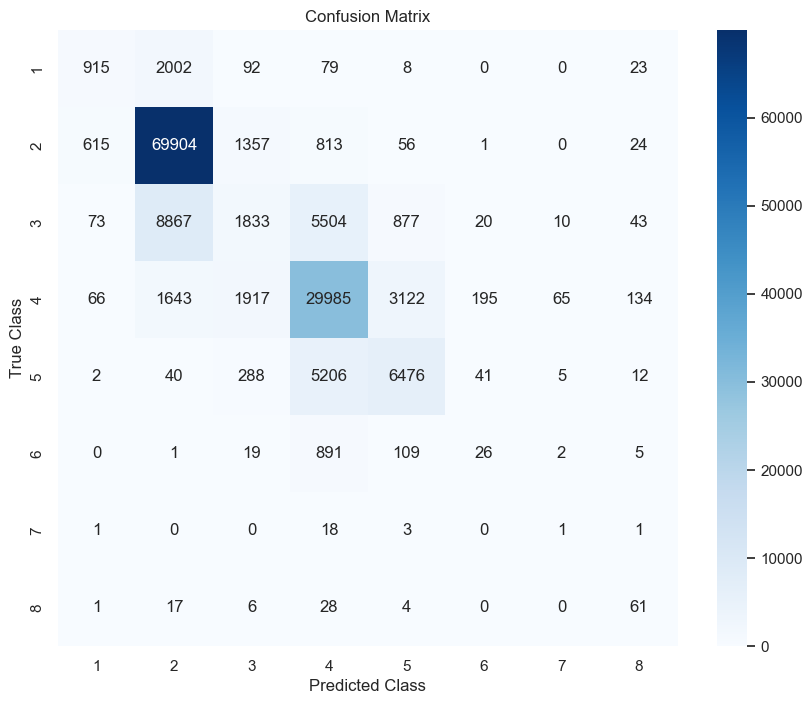

In [355]:
dt = DecisionTreeClassifier(random_state=13, criterion='entropy', min_samples_split=50)

dt.fit(X_resampled[list1], y_resampled)

y_pred_train = dt.predict(X_resampled[list1])

y_pred_val = dt.predict(X_val_scaled[list1])

f1_train = f1_score(y_resampled, y_pred_train, average='weighted')
report = classification_report(y_val, y_pred_val)

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### With Agreement Reached

In [356]:
dt = DecisionTreeClassifier(random_state=13, criterion='entropy', min_samples_split=50)

dt.fit(X_resampled[list2], y_resampled)

y_pred_train = dt.predict(X_resampled[list2])

y_pred_val = dt.predict(X_val_scaled[list2])

accuracy = accuracy_score(y_val, y_pred_val)
report = classification_report(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(report)
confusion_matrix(y_val, y_pred_val)


Accuracy: 0.78
F1 Score: 0.74
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.29      0.39      3119
           2       0.86      0.96      0.91     72770
           3       0.35      0.11      0.17     17227
           4       0.74      0.84      0.79     37127
           5       0.61      0.58      0.59     12070
           6       0.11      0.04      0.05      1053
           7       0.02      0.04      0.02        24
           8       0.20      0.51      0.29       117

    accuracy                           0.78    143507
   macro avg       0.43      0.42      0.40    143507
weighted avg       0.73      0.78      0.74    143507



array([[  919,  2038,   100,    43,     7,     0,     0,    12],
       [  606, 70157,  1470,   437,    67,     0,     0,    33],
       [   78,  9006,  1971,  4991,  1100,    24,     9,    48],
       [   15,   655,  1633, 31213,  3201,   241,    44,   125],
       [    2,    46,   378,  4583,  6993,    49,     7,    12],
       [    0,     2,    22,   854,   129,    37,     4,     5],
       [    1,     0,     0,    19,     1,     1,     1,     1],
       [    0,    21,     9,    25,     2,     0,     0,    60]])

In [357]:
y_pred_proba = dt.predict(X_test_scaled[list1])
# y_pred = np.argmax(y_pred_proba, axis=1)

label_mapping = {
     1:'1. CANCELLED',
     2:'2. NON-COMP',
     3:'3. MED ONLY',
     4:'4. TEMPORARY',
     5:'5. PPD SCH LOSS',
     6:'6. PPD NSL',
     7:'7. PTD',
     8:'8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred_proba]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled[list1].index,
    'Claim Injury Type': test_predictions_full_labels
})

submission_df.to_csv("Group13_Version1.csv", index=False, header=True)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Agreement Reached


## Model 2: Random Forest

After testing the decision tree model, the group decided to try the next model: Random Forest. <br>
This model, to put it simply, combines an ensemble of decision trees to improve overall accuracy and reduce the risk of overfitting.<br>
Like the Decision Tree, this model underwent many iterations with different combinations of features and 'n_estimators' (the number of decision trees in the forest). Its performance was much better than the previous model, but after a certain number of iterations, the model plateaued, and the search for an optimal model began again.

### Without Agreement Reached

F1 Score (Train): 0.754231
F1 Score (Validation): 0.729257
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.26      0.37      3119
           2       0.84      0.97      0.90     72770
           3       0.55      0.06      0.11     17227
           4       0.69      0.89      0.78     37127
           5       0.68      0.53      0.60     12070
           6       0.00      0.00      0.00      1053
           7       0.00      0.00      0.00        24
           8       0.32      0.56      0.41       117

    accuracy                           0.78    143507
   macro avg       0.47      0.41      0.40    143507
weighted avg       0.74      0.78      0.73    143507



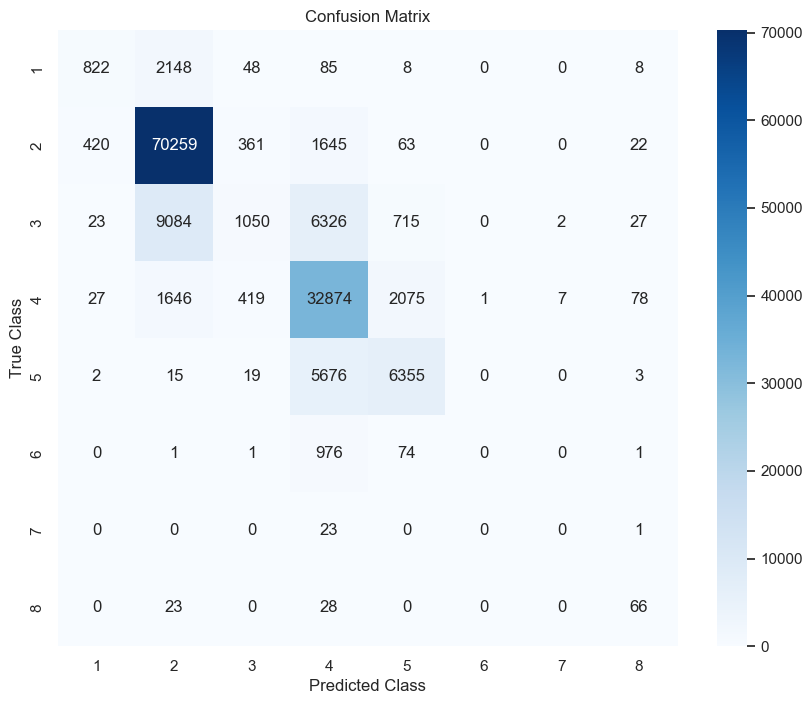

In [358]:
clf = RandomForestClassifier(random_state=13, n_estimators=100, min_samples_split = 50, criterion='entropy')

clf.fit(X_resampled[list1], y_resampled)

y_pred_train = clf.predict(X_resampled[list1])
y_pred_val = clf.predict(X_val_scaled[list1])
report = classification_report(y_val, y_pred_val)

f1_val = f1_score(y_val, y_pred_val, average='weighted')
f1_train = f1_score(y_resampled, y_pred_train, average='weighted')

print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### With Agreement Reached

In [359]:
clf = RandomForestClassifier(random_state=13, n_estimators=100, min_samples_split = 50, criterion='entropy')

clf.fit(X_resampled[list2], y_resampled)

y_pred = clf.predict(X_resampled[list2])
y_pred = clf.predict(X_val_scaled[list2])
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.79
F1 Score: 0.74
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.26      0.38      3119
           2       0.86      0.97      0.91     72770
           3       0.64      0.06      0.12     17227
           4       0.72      0.92      0.81     37127
           5       0.67      0.60      0.63     12070
           6       0.00      0.00      0.00      1053
           7       0.00      0.00      0.00        24
           8       0.32      0.55      0.41       117

    accuracy                           0.79    143507
   macro avg       0.48      0.42      0.41    143507
weighted avg       0.77      0.79      0.74    143507



In [360]:
y_pred_proba = clf.predict(X_test_scaled[list1])
# y_pred = np.argmax(y_pred_proba, axis=1)

label_mapping = {
     1:'1. CANCELLED',
     2:'2. NON-COMP',
     3:'3. MED ONLY',
     4:'4. TEMPORARY',
     5:'5. PPD SCH LOSS',
     6:'6. PPD NSL',
     7:'7. PTD',
     8:'8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred_proba]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled[list1].index,
    'Claim Injury Type': test_predictions_full_labels
})

submission_df.to_csv("Group13_Version2.csv", index=False, header=True)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Agreement Reached


## Model 3: Light GBM

The final model the group ended up choosing to present in this phase of the project was the Light GBM (short for Light Gradient Boosting Machine). Like in the previous models, this model type suffered through many iterations and in the end the best combination was created using all features generated with the 64 lockers in the 'hashing trick'. In the future, the group plans to retrace some steps a take a second look at important sections such as imputation, dealing with outliers and the aforementioned filter, embedded and wrapper methods.

Light GBM is a model that, much like a random forest, uses an ensemble of models, combining them sequentially. The objective is that each model corrects the previous models mistakes. The models are optimized based on the gradient of a loss function (in this case 'multi_logloss). The choice of this metric can be atributed to its suitability for multiclass classification. Several key parameters were fine-tuned (by trial and error) to optimize model performance:
- 'learning_rate' controls the speed of learning, with lower values enabling more gradual, precise learning.
- 'num_leaves' and 'max_depth' determine the complexity of each tree, allowing for more detailed splits.
- 'is_unbalanced' helps the model handle class imbalance by adjusting the weight of each class in the loss function, in this case the target is unbalanced and as no resampling was done this parameter is added to counter it.
- 'feature_fraction' and 'bagging_fraction' control feature and instance sampling, which helps reduce overfitting by ensuring diversity in each iteration.

References:

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html# <br>
https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/ <br>
https://medium.com/@pritmanvar/lightgbm-essentials-how-it-works-and-why-its-fast-586b83dda7af <br>
https://medium.com/@soyoungluna/simple-explanation-of-lightgbm-without-complicated-mathematics-973998ec848f <br>
https://lightgbm.readthedocs.io/en/latest/Features.html <br>

The target variable needed a slight adjustment, this is due to the constrains of the light gbm model. This model expects the classes to start at 0, so 1 is subtracted to each value in the train and validation set and afterwards the map function is changed.

In [361]:
y_train_adjusted = y_resampled - 1
y_val_adjusted = y_val - 1

### Without Agreement Reached

F1 Score (Train): 0.7495
F1 Score (Validation): 0.7372
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.35      0.44      3119
           1       0.84      0.98      0.91     72770
           2       0.55      0.06      0.11     17227
           3       0.71      0.87      0.79     37127
           4       0.67      0.55      0.61     12070
           5       1.00      0.00      0.00      1053
           6       0.09      0.04      0.06        24
           7       0.42      0.52      0.46       117

    accuracy                           0.78    143507
   macro avg       0.61      0.42      0.42    143507
weighted avg       0.76      0.78      0.74    143507



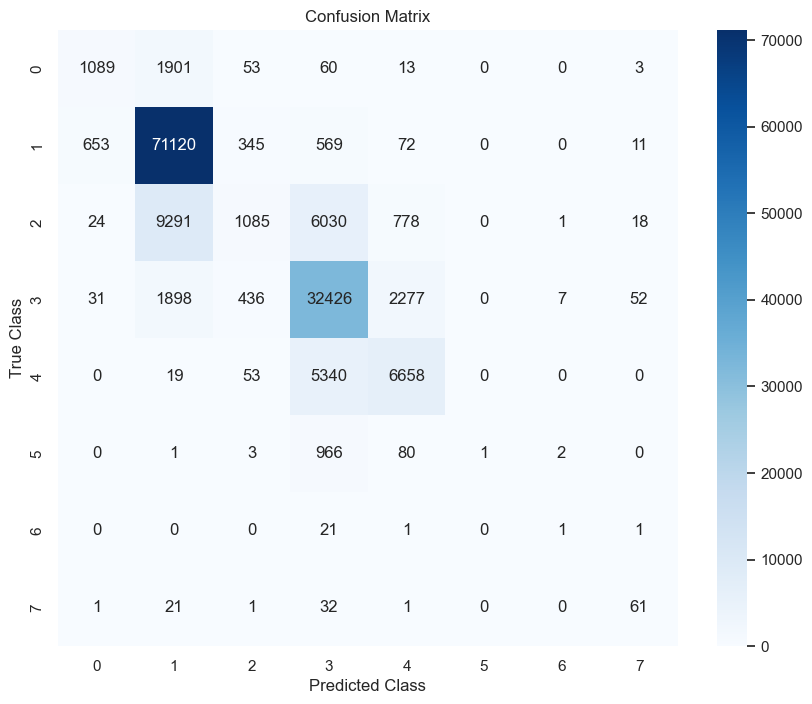

In [362]:
train_data = lgb.Dataset(X_resampled[list1], label=y_train_adjusted)
val_data = lgb.Dataset(X_val_scaled[list1], label=y_val_adjusted, reference=train_data)

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 8,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2.0,
    'verbose': -1,
    'class_weight': 'balanced'}


lgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])


y_pred_proba_val = lgbm.predict(X_val_scaled[list1])
y_pred_val = np.argmax(y_pred_proba_val, axis=1)

y_pred_proba_train = lgbm.predict(X_resampled[list1])
y_pred_train = np.argmax(y_pred_proba_train, axis=1)


f1_train = f1_score(y_train_adjusted, y_pred_train, average='weighted')
f1_val = f1_score(y_val_adjusted, y_pred_val, average='weighted')
report = classification_report(y_val_adjusted, y_pred_val)

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val_adjusted, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### With Agreement Reached

F1-Score (Weighted): 0.7538340841602356
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.34      0.44      3119
           1       0.86      0.98      0.91     72770
           2       0.62      0.07      0.13     17227
           3       0.75      0.90      0.82     37127
           4       0.66      0.63      0.64     12070
           5       0.25      0.00      0.00      1053
           6       0.08      0.04      0.06        24
           7       0.42      0.53      0.47       117

    accuracy                           0.80    143507
   macro avg       0.53      0.44      0.43    143507
weighted avg       0.77      0.80      0.75    143507



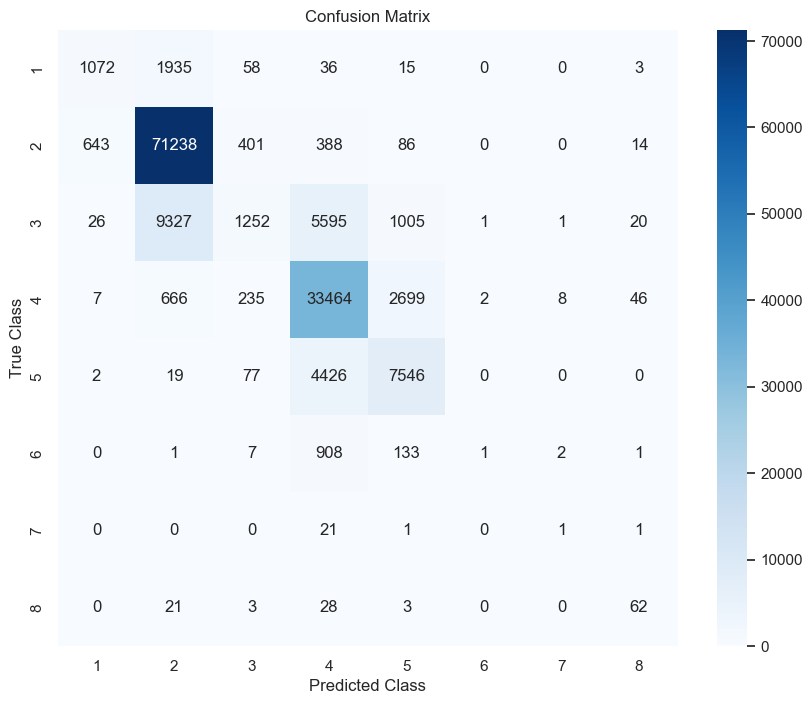

In [363]:
train_data = lgb.Dataset(X_resampled[list2], label=y_train_adjusted)
val_data = lgb.Dataset(X_val_scaled[list2], label=y_val_adjusted, reference=train_data)

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 8,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2.0,
    'verbose': -1,
    'class_weight': 'balanced'}


model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

y_pred_proba = model.predict(X_val_scaled[list2])
y_pred = np.argmax(y_pred_proba, axis=1)

f1 = f1_score(y_val_adjusted, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)
print("Classification Report:\n", classification_report(y_val_adjusted, y_pred))

cm = confusion_matrix(y_val_adjusted, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [364]:
y_pred_proba = model.predict(X_test_scaled[list1])
y_pred = np.argmax(y_pred_proba, axis=1)

label_mapping = {
    0: '1. CANCELED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled.index,
    'Claim Injury Type': test_predictions_full_labels
})

submission_df.to_csv("Group13_Version3.csv", index=False, header=True)

[LightGBM] [Fatal] The number of features in data (12) is not the same as it was in training data (13).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (12) is not the same as it was in training data (13).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

## Model 4: XGBoost

In [365]:
y_train_adjusted = y_resampled - 1
y_val_adjusted = y_val - 1

### Without Agreement Reached

F1 Score (Train): 0.7786
F1 Score (Validation): 0.7407
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.30      0.41      3119
           1       0.85      0.98      0.91     72770
           2       0.53      0.08      0.14     17227
           3       0.72      0.87      0.79     37127
           4       0.67      0.57      0.61     12070
           5       0.00      0.00      0.00      1053
           6       0.00      0.00      0.00        24
           7       0.46      0.44      0.45       117

    accuracy                           0.78    143507
   macro avg       0.48      0.41      0.41    143507
weighted avg       0.75      0.78      0.74    143507



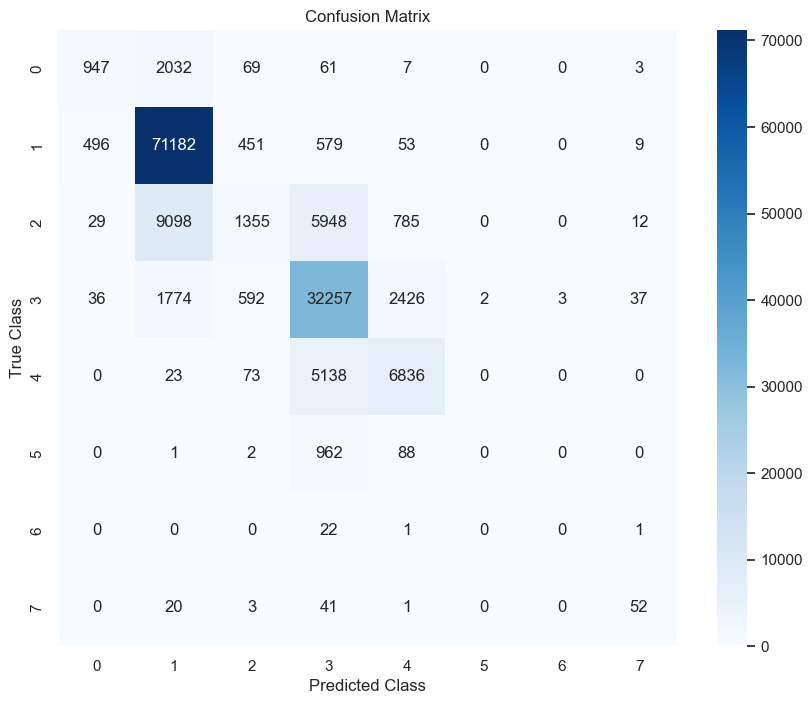

In [366]:
modelxgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=8,
    max_depth=10, 
    learning_rate=0.05, 
    min_child_weight=5,
    gamma=0,  
    subsample=0.8,
    colsample_bytree=0.7, 
    reg_alpha=0.1,
    reg_lambda=1.5, 
    n_estimators=1000,  
    early_stopping_rounds=50,
    eval_metric='mlogloss',  
    seed=4
    )


modelxgb.fit(
    X_resampled[list1], 
    y_train_adjusted,
    eval_set=[(X_val_scaled[list1], y_val_adjusted)],
    verbose=False
)

y_pred_val = modelxgb.predict(X_val_scaled[list1])
y_pred_train = modelxgb.predict(X_resampled[list1])

f1_train = f1_score(y_train_adjusted, y_pred_train, average='weighted')
f1_val = f1_score(y_val_adjusted, y_pred_val, average='weighted')
report = classification_report(y_val_adjusted, y_pred_val)

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val_adjusted, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### With Agreement Reached

F1 Score (Train): 0.7913
F1 Score (Validation): 0.7572
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.28      0.39      3119
           1       0.86      0.98      0.91     72770
           2       0.58      0.09      0.16     17227
           3       0.75      0.90      0.82     37127
           4       0.66      0.63      0.65     12070
           5       0.40      0.00      0.00      1053
           6       0.25      0.04      0.07        24
           7       0.48      0.45      0.46       117

    accuracy                           0.80    143507
   macro avg       0.58      0.42      0.43    143507
weighted avg       0.77      0.80      0.76    143507



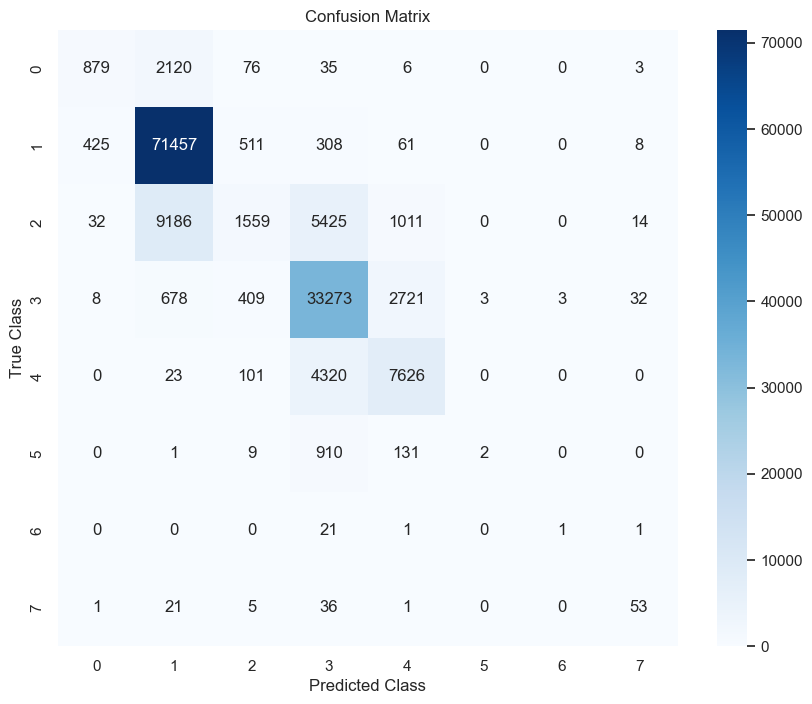

In [367]:
y_train_adjusted = y_resampled - 1
y_val_adjusted = y_val - 1

modelxgb = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=8,
    max_depth=10, 
    learning_rate=0.05, 
    min_child_weight=5,
    gamma=0,  
    subsample=0.8,
    colsample_bytree=0.7, 
    reg_alpha=0.1,
    reg_lambda=1.5, 
    n_estimators=1000,  
    early_stopping_rounds=50,
    eval_metric='mlogloss',  
    seed=4
    )


modelxgb.fit(
    X_resampled[list2], 
    y_train_adjusted,
    eval_set=[(X_val_scaled[list2], y_val_adjusted)],
    verbose=False
)

y_pred_val = modelxgb.predict(X_val_scaled[list2])
y_pred_train = modelxgb.predict(X_resampled[list2])

f1_train = f1_score(y_train_adjusted, y_pred_train, average='weighted')
f1_val = f1_score(y_val_adjusted, y_pred_val, average='weighted')
report = classification_report(y_val_adjusted, y_pred_val)

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val_adjusted, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [368]:
y_pred = modelxgb.predict(X_test_scaled[list1])

y_pred_series = pd.Series(y_pred)

y_pred_mapped = y_pred_series.map({
    0: '1. CANCELLED', 
    1: '2. NON-COMP', 
    2: '3. MED ONLY', 
    3: '4. TEMPORARY', 
    4: '5. PPD SCH LOSS', 
    5: '6. PPD NSL', 
    6: '7. PTD', 
    7: '8. DEATH'
})

y_pred_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled[list1].index, 
    'Predicted Claim Injury Type': y_pred_mapped
})

y_pred_df.to_csv('Group13_Version4.csv', index=False, header=True)

ValueError: feature_names mismatch: ['Attorney/Representative', 'Average Weekly Wage log', 'has_c3_date', 'has_hearing_date', 'IME-4 Count', 'ais_weights', 'WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'days_to_c2_log', 'age_group', 'IRS', 'Agreement Reached'] ['Attorney/Representative', 'Average Weekly Wage log', 'has_c3_date', 'has_hearing_date', 'IME-4 Count', 'ais_weights', 'WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'days_to_c2_log', 'age_group', 'IRS']
expected Agreement Reached in input data

## Model 5: Neural Networks

### SGD

#### Without Agreement Reached

F1 Score (Train): 0.7205
F1 Score (Validation): 0.7207
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.28      0.39      3119
           1       0.86      0.98      0.91     72770
           2       0.58      0.09      0.16     17227
           3       0.75      0.90      0.82     37127
           4       0.66      0.63      0.65     12070
           5       0.40      0.00      0.00      1053
           6       0.25      0.04      0.07        24
           7       0.48      0.45      0.46       117

    accuracy                           0.80    143507
   macro avg       0.58      0.42      0.43    143507
weighted avg       0.77      0.80      0.76    143507



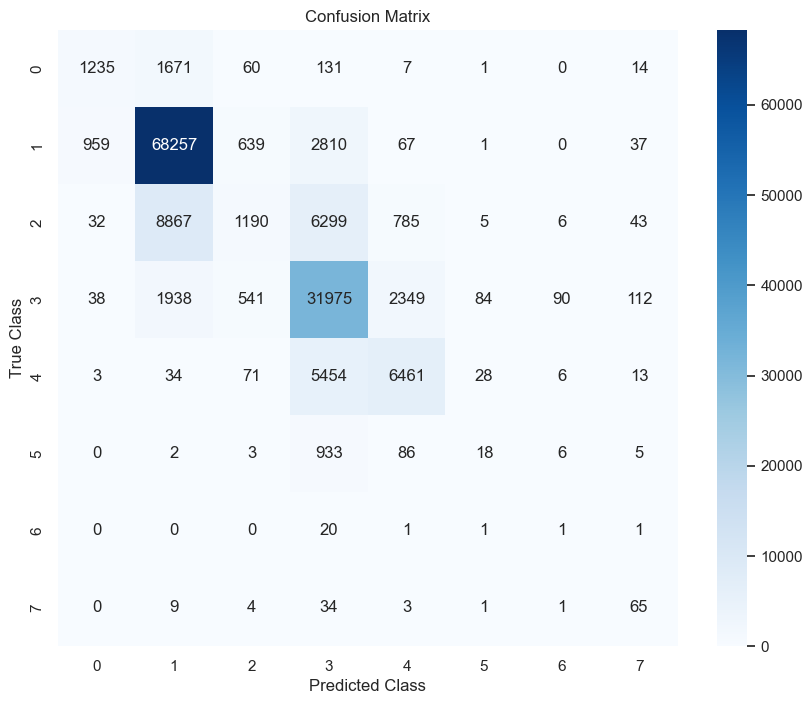

In [369]:
X_train_adam = X_resampled[list1]
X_val_adam = X_val_scaled[list1]
X_test_adam = X_test_scaled[list1]

model_adam = MLPClassifier(
    hidden_layer_sizes = (100, 50, 25),
    solver= 'sgd',
    activation = 'tanh',
    n_iter_no_change = 90,
    max_iter = 300,
    learning_rate = 'constant',
    learning_rate_init = 0.01,
    verbose = False,
    random_state=13)

model_adam.fit(X_train_adam, y_resampled)
y_pred_val = model_adam.predict(X_val_adam)
y_pred_train = model_adam.predict(X_train_adam)

f1_val = f1_score(y_val, y_pred_val, average='weighted')
f1_train = f1_score(y_resampled, y_pred_train, average='weighted')

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

#### With Agreement Reached

F1 Score (Train): 0.7323
F1 Score (Validation): 0.7348
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.28      0.39      3119
           1       0.86      0.98      0.91     72770
           2       0.58      0.09      0.16     17227
           3       0.75      0.90      0.82     37127
           4       0.66      0.63      0.65     12070
           5       0.40      0.00      0.00      1053
           6       0.25      0.04      0.07        24
           7       0.48      0.45      0.46       117

    accuracy                           0.80    143507
   macro avg       0.58      0.42      0.43    143507
weighted avg       0.77      0.80      0.76    143507



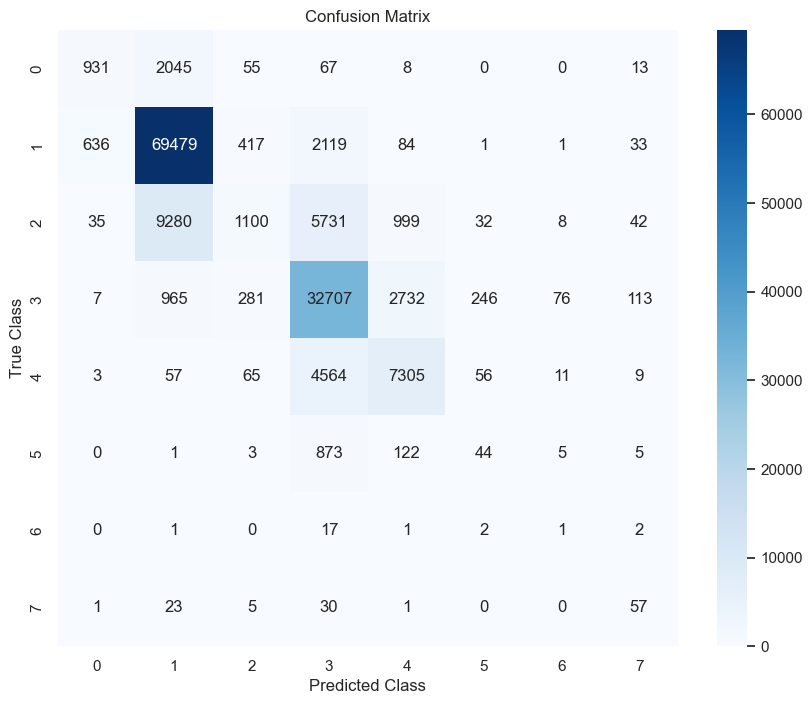

In [371]:
X_train_adam_2= X_resampled[list2]
X_val_adam_2 = X_val_scaled[list2]
X_test_adam_2 = X_test_scaled[list2]

model_adam = MLPClassifier(
    hidden_layer_sizes = (100, 50, 25),
    solver= 'sgd',
    activation = 'tanh',
    n_iter_no_change = 90,
    max_iter = 300,
    learning_rate = 'constant',
    learning_rate_init = 0.01,
    verbose = False,
    random_state=13)

model_adam.fit(X_train_adam_2, y_resampled)
y_pred_val = model_adam.predict(X_val_adam_2)
y_pred_train = model_adam.predict(X_train_adam_2)

f1_val = f1_score(y_val, y_pred_val, average='weighted')
f1_train = f1_score(y_resampled, y_pred_train, average='weighted')

print(f"F1 Score (Train): {f1_train:.4f}")
print(f"F1 Score (Validation): {f1_val:.4f}")
print("Classification Report:")
print(report)

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(8), yticklabels=range(8))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [372]:
y_pred = model_adam.predict(X_test_adam)

label_mapping = {
    1: '1. CANCELED',
    2: '2. NON-COMP',
    3: '3. MED ONLY',
    4: '4. TEMPORARY',
    5: '5. PPD SCH LOSS',
    6: '6. PPD NSL',
    7: '7. PTD',
    8: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_adam.index,
    'Claim Injury Type': test_predictions_full_labels
})

submission_df.to_csv("Group13_Version5.csv", index=False, header=True)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Agreement Reached


# Model Selection

## Model assessment strategy
### Metrics
To access the model the group use the following metrics:
- Weighted F1 Score:
    This metric provided an overall sense of the model's performance and was used to compare training and validation results, helping to identify potential overfitting. The weighted F1 score was specifically chosen for its suitability in handling imbalanced datasets.
- Classification Report:
    While not a single metric, the classification report provides a collection of key performance metrics. It was chosen for its versatility, allowing the group to observe the model's performance across each target class. Particular focus was given to the Macro Average F1 Score, as it closely aligned with the results obtained in the Kaggle competition.
- Confusion Matrix:
    Lastly, the confusion matrix served as a visual aid, showing the number of correct and incorrect predictions for each class. By analyzing the confusion matrix, the group could pinpoint where the model struggled, identifying poorly defined classes that required further study and refinement.

### Objective
The goal was to identify the best algorithm for multiclass classification, ensuring the model generalizes well to unseen data while maintaining high accuracy and balanced class performance.

## Performance Comparison between Candidate Algorithms
### Decision Tree
This model fitted quite quickly tacking 4.6 seconds to train. Here are its metrics:
- F1 Weighted(Train): 0.7727
- F1 Weighted(Validation): 0.7282
- Macro Average F1 Score: 0.39
- The model is fast to train and provides reasonable performance on both training and validation sets but has the largest gap between training and validation. The low Macro F1 score suggests that it struggles to balance performance across all classes.
### Random Forest
The random forest model fitted in a slower fashion but overall was still quick tacking 1 minute and 50 seconds to train. Here are its metrics:
- F1 Weighted(Train): 0.7484
- F1 Weighted(Validation): 0.7297
- Macro Average F1 Score: 0.37
- The model undeperforms compared to the Decision tree in terms of Weighted F1 but provides less overfitting, indicatting better generalization. The low Macro F1 score suggests challenges in handling minority classes.
### Light GBM
Light GBM is where the fitting process started to slow down, the model took 12 minutes and 26 seconds to train. Here are its metrics:
- F1 Weighted(Train): 0.7410
- F1 Weighted(Validation): 0.7375
- Macro Average F1 Score: 0.41
- The model achieves an extremely small gap between training and validation, indicating less overfitting. Its higher Macro F1 score compared to Decision Tree and Random Forest suggests better handling of class imbalance. However, training time is significantly longer.
### XGBOOST
XGBOOST model took 4 minutes and 52 seconds to train. Here are its metrics:
- F1 Weighted(Train): 0.7736
- F1 Weighted(Validation): 0.7401
- Macro Average F1 Score: 0.41
- The model achieves the highest Weighted F1 scores for both training and validation and shares the highest Macro F1 score with LightGBM making it one of the best-performing models in terms of both overall accuracy and class balance. Additionally, its training time is significantly lower than LightGBM, making it a more efficient option. It has a slight gap between train and validation.
### Neural Networks (SGD)
The Neural Network (MLP Classifier SGD) was the slowest model taking 32 minutes and 34 seconds to fit. Here are its metrics:
- F1 Weighted(Train): 0.7268
- F1 Weighted(Validation): 0.7237
- Macro Average F1 Score: 0.41
- The model has the smallest gap between training and validation, showing very low overfitting. However, it achieves slightly lower Weighted F1 scores compared to XGBoost and LightGBM. Its Macro F1 score matches theirs, suggesting it handles minority classes reasonably well. Its training time is the longest, raising concerns about its efficiency.

## Final Decision
In the end, the group decided to select the XGBoost model as the final model. Of all the models tried, XGBoost managed to achieve a good balance between performance and training time. The neural networks (including those in the model and others that were tried during the project's development) took a long time to train and often failed to yield good results, likely due to the group's inexperience with this type of model.